# Building a 5000 dimensional Logistic Regression and Softmax Regression Sentiment Classifier Based on the Netflix Large Movie Review dataset
The final exercise in Chapter 4 suggests implementing a final project for sentiment analysis. "Sentiment analysis can be considered a binary classification problem. The input is natural language text, and the output is a binary decision that infers positive or negative sentiment." The chapter end suggests taking a look at some datasets in particular the [Large Movie Review Dataset](http://mng.bz/60nj). The excercise also suggests visiting the Kaggle challenge for [Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial). 

The Kaggle tutorial is excellent, and I've borrowed big pieces from it. The main differences in the Kaggle tutorial are that they use Scikit-Learn and Random Forrest, and there is no Tensorflow in it. They also use Pandas and assume that the train data is a 25000 * 5000 column Pandas data frame, and that each vertical slice / column in the frame is the full term frequency feature set counts for word X1, word X2.... word XN.

I've made a few changes to the tutorial besides using Tensorflow. I outline them below:

   1. Instead of using [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/), I used [Tika Python](http://github.com/chrismattmann/tika-python) to clean the review text. Should be obvious why...
   2. I added [TQDM](https://github.com/tqdm/tqdm) progress bars on the most important iterations. 
   3. I added some plots here and there, including looking at the term frequency distribution for the first 100 words in the 5000 word vocabulary, and a plot for the ROC curve.
   4. I added computation of precision and recall, and TP, TN, FP, FN
   5. I added saving for the model weights. 
   
I have a feeling I made this harder than it needed to be &#9786; That said, I couldn't even visualize based on the example given in the book for 2d logistic regresion what 5000d logistic regression looked like. So, I made a visual of it to hopefully help others when they are similarly thinking about it. I think once I learn more about Tensorflow, I will be able to clean this code up some more too. 

<img src="figs/ch04-final-bow-model.png" width="400" height="200" alt="Bag of Word Model in 5000 dimensions"/>

Here are some immensely useful references I found along the way. FWIW, my Nd logreg classifier is <b>~87%</b> accurate. The softmax reg classifier is <b>~81%</b> Not bad!

## Useful References

   1. [Plot ROC Curve for Binary Classification](https://qiita.com/bmj0114/items/460424c110a8ce22d945) by @bmj0114
   2. [Intersecting Lists and Finding their Indices](https://stackoverflow.com/questions/12570417/python-finding-corresponding-indices-for-an-intersection-of-two-lists) by mgilson
   3. [An Introduction to Bag of Words](https://medium.freecodecamp.org/an-introduction-to-bag-of-words-and-how-to-code-it-in-python-for-nlp-282e87a9da04) by Free Code Camp.
   4. [Bag of Words Meets Popcorn Tutorial](https://www.kaggle.com/c/word2vec-nlp-tutorial/overview) by Kaggle.
   5. [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/) by Stanford.
   6. [What Bag of Words Looks Like Visually](https://bit.ly/2KCTYGe) by Unknown.
   7. [Working with Bag of Words - Tensorflow Cookbook](https://github.com/nfmcclure/tensorflow_cookbook/blob/master/07_Natural_Language_Processing/02_Working_with_Bag_of_Words/02_bag_of_words.ipynb) by Nick F. Mcclure.


In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tika import parser
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc
import re
import math
from tqdm import tqdm_notebook as tqdm
from os import listdir
from os.path import isfile, join
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package movie_review

True

In [2]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = parser.from_buffer( "<html>" + raw_review + "</html>" )["content"]
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words )) 

In [3]:
train = pd.read_csv("word2vec-nlp-tutorial/labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)

In [4]:
train.shape

(25000, 3)

In [5]:
train.columns.values

array(['id', 'sentiment', 'review'], dtype=object)

In [6]:
train.head()

id  sentiment                                             review
0  "5814_8"          1  "With all this stuff going down at the moment ...
1  "2381_9"          1  "\"The Classic War of the Worlds\" by Timothy ...
2  "7759_3"          0  "The film starts with a manager (Nicholas Bell...
3  "3630_4"          0  "It must be assumed that those who praised thi...
4  "9495_8"          1  "Superbly trashy and wondrously unpretentious ...

In [7]:
parsed = parser.from_buffer("<html>"+train["review"][0]+"</html>")
print(train["review"][0])
print(parsed["content"])

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [8]:
# Get the number of reviews based on the dataframe column size
num_reviews = train["review"].size

# Initialize an empty list to hold the clean reviews
clean_train_reviews = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
for i in tqdm(range( 0, num_reviews )):
    # Call our function for each one, and add the result to the list of
    # clean reviews
    clean_train_reviews.append( review_to_words( train["review"][i] ) )

In [9]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

In [10]:
print(train_data_features.shape)

(25000, 5000)


In [11]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print("size %d %s " % (len(vocab), vocab))

size 5000 ['abandoned', 'abc', 'abilities', 'ability', 'able', 'abraham', 'absence', 'absent', 'absolute', 'absolutely', 'absurd', 'abuse', 'abusive', 'abysmal', 'academy', 'accent', 'accents', 'accept', 'acceptable', 'accepted', 'access', 'accident', 'accidentally', 'accompanied', 'accomplished', 'according', 'account', 'accuracy', 'accurate', 'accused', 'achieve', 'achieved', 'achievement', 'acid', 'across', 'act', 'acted', 'acting', 'action', 'actions', 'activities', 'actor', 'actors', 'actress', 'actresses', 'acts', 'actual', 'actually', 'ad', 'adam', 'adams', 'adaptation', 'adaptations', 'adapted', 'add', 'added', 'adding', 'addition', 'adds', 'adequate', 'admire', 'admit', 'admittedly', 'adorable', 'adult', 'adults', 'advance', 'advanced', 'advantage', 'adventure', 'adventures', 'advertising', 'advice', 'advise', 'affair', 'affect', 'affected', 'afford', 'aforementioned', 'afraid', 'africa', 'african', 'afternoon', 'afterwards', 'age', 'aged', 'agent', 'agents', 'ages', 'aging', 

In [12]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print("%d, %s" % (count, tag))

187, abandoned
125, abc
108, abilities
454, ability
1259, able
85, abraham
116, absence
83, absent
352, absolute
1485, absolutely
306, absurd
192, abuse
91, abusive
98, abysmal
297, academy
485, accent
203, accents
300, accept
130, acceptable
144, accepted
92, access
318, accident
200, accidentally
88, accompanied
124, accomplished
296, according
186, account
81, accuracy
284, accurate
123, accused
179, achieve
139, achieved
124, achievement
90, acid
971, across
1251, act
660, acted
6494, acting
3355, action
311, actions
83, activities
2389, actor
4488, actors
1219, actress
369, actresses
394, acts
793, actual
4240, actually
148, ad
303, adam
98, adams
454, adaptation
80, adaptations
154, adapted
810, add
440, added
166, adding
347, addition
337, adds
113, adequate
124, admire
621, admit
134, admittedly
101, adorable
511, adult
376, adults
101, advance
90, advanced
153, advantage
510, adventure
204, adventures
91, advertising
259, advice
90, advise
346, affair
93, affect
113, affected


83, contest
260, context
307, continue
128, continued
261, continues
212, continuity
130, contract
116, contrary
224, contrast
227, contrived
511, control
152, controversial
109, conventional
189, conversation
110, conversations
171, convey
197, convince
216, convinced
539, convincing
93, convincingly
121, convoluted
159, cook
971, cool
166, cooper
620, cop
90, copies
301, cops
576, copy
259, core
153, corner
258, corny
96, corporate
127, corpse
223, correct
82, correctly
133, corrupt
100, corruption
220, cost
234, costs
223, costume
418, costumes
7923, could
352, count
87, counter
136, countless
151, countries
935, country
103, countryside
1719, couple
93, couples
148, courage
2506, course
193, court
147, cousin
526, cover
212, covered
135, covers
212, cowboy
132, cox
106, crack
79, cracking
113, craft
167, crafted
122, craig
1040, crap
242, crappy
201, crash
118, craven
82, crawford
79, crazed
657, crazy
612, create
542, created
245, creates
284, creating
129, creation
362, creative


86, mundane
1063, murder
260, murdered
179, murderer
109, murderous
367, murders
213, murphy
81, murray
96, museum
3057, music
992, musical
175, musicals
85, muslim
3250, must
97, myers
105, mysteries
405, mysterious
850, mystery
98, nail
218, naive
437, naked
1604, name
800, named
96, namely
391, names
227, nancy
192, narration
424, narrative
125, narrator
342, nasty
82, nathan
187, nation
255, national
238, native
463, natural
267, naturally
711, nature
162, navy
190, nazi
114, nazis
145, nd
824, near
109, nearby
815, nearly
149, neat
180, necessarily
324, necessary
141, neck
182, ned
1807, need
683, needed
162, needless
841, needs
352, negative
139, neighbor
143, neighborhood
89, neighbors
134, neil
537, neither
152, nelson
112, neo
84, nephew
84, nerd
97, nervous
190, network
6485, never
236, nevertheless
4312, new
89, newly
79, newman
331, news
113, newspaper
1716, next
2012, nice
299, nicely
92, nicholas
113, nicholson
293, nick
82, nicole
2165, night
318, nightmare
108, nightmar

714, sexual
150, sexuality
135, sexually
445, sexy
103, sh
182, shadow
117, shadows
95, shake
296, shakespeare
80, shaky
133, shall
259, shallow
671, shame
81, shanghai
159, shape
367, share
141, shark
78, sharon
206, sharp
100, shaw
82, shed
247, sheer
103, shelf
95, shelley
244, sheriff
109, shine
149, shines
129, shining
347, ship
79, ships
103, shirley
118, shirt
385, shock
209, shocked
339, shocking
121, shoes
460, shoot
479, shooting
142, shoots
263, shop
1867, short
122, shortly
148, shorts
2051, shot
948, shots
6295, show
90, showcase
84, showdown
489, showed
159, shower
775, showing
994, shown
2308, shows
168, shut
125, shy
487, sick
82, sid
1277, side
105, sidekick
157, sides
180, sidney
323, sight
274, sign
89, signed
80, significance
182, significant
106, signs
130, silence
439, silent
889, silly
139, silver
852, similar
98, similarities
98, similarly
84, simmons
272, simon
1023, simple
91, simplicity
101, simplistic
1966, simply
95, simpson
157, sin
245, sinatra
2907, sinc

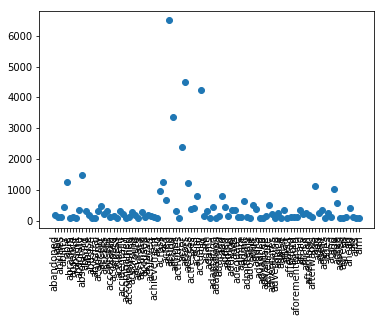

In [13]:
# plot the word count for first 100 words
plt.scatter(vocab[0:99], dist[0:99])
plt.xticks(vocab[0:99], rotation='vertical')
plt.show()

In [14]:
# set up Tensorflow nD logistic regression
learning_rate = 0.1
training_epochs = 2000

In [15]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [16]:
Y = tf.placeholder(tf.float32, shape=(None,), name="y")
w = tf.Variable([0.] * (len(train_data_features)+1), name="w", trainable=True)
print(w.shape)

Instructions for updating:
Colocations handled automatically by placer.
(25001,)


In [17]:
ys = train['sentiment'].values

In [18]:
Xs = {}
for i in range(train_data_features.shape[1]):
    Xs["X"+str(i)] = tf.placeholder(tf.float32, shape=(None,), name="x"+str(i))

In [19]:
linear = w[0]
for i in range(0, train_data_features.shape[1]):
    linear = linear + (w[i+1] * Xs["X"+str(i)])
y_model = tf.sigmoid(linear)

In [20]:
cost = tf.reduce_mean(-tf.log(y_model * Y + (1 - y_model) * (1 - Y)))
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [21]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    prev_err = 0
    for epoch in tqdm(range(training_epochs)):
        feed_dict = {}
        for i in range(train_data_features.shape[1]):
            feed_dict[Xs["X"+str(i)]] = train_data_features[:, i, None].reshape(len(train_data_features))
        feed_dict[Y] = ys
        err, _ = sess.run([cost, train_op], feed_dict=feed_dict)
        print(epoch, err)
        if abs(prev_err - err) < 0.0001:
            break
        prev_err = err
    
    w_val = sess.run(w, feed_dict)
    save_path = saver.save(sess, "./en-netflix-binary-sentiment.ckpt")

0 0.6931475
1 0.68367267
2 0.67517424
3 0.6673778
4 0.6601468
5 0.6533886
6 0.6470343
7 0.64103085
8 0.6353368
9 0.62991923
10 0.62475115
11 0.6198105
12 0.6150785
13 0.6105392
14 0.6061786
15 0.6019846
16 0.59794647
17 0.59405404
18 0.5902991
19 0.58667326
20 0.5831693
21 0.5797805
22 0.5765007
23 0.5733241
24 0.57024544
25 0.5672598
26 0.5643625
27 0.5615493
28 0.5588163
29 0.55615956
30 0.5535756
31 0.55106133
32 0.5486133
33 0.546229
34 0.54390526
35 0.54163986
36 0.53943014
37 0.537274
38 0.535169
39 0.5331134
40 0.5311051
41 0.52914226
42 0.5272231
43 0.5253461
44 0.5235097
45 0.5217122
46 0.5199523
47 0.51822865
48 0.51654017
49 0.5148855
50 0.5132633
51 0.51167256
52 0.5101124
53 0.5085817
54 0.5070795
55 0.50560474
56 0.5041569
57 0.5027348
58 0.50133777
59 0.499965
60 0.49861583
61 0.49728957
62 0.49598548
63 0.49470282
64 0.4934411
65 0.4921997
66 0.49097803
67 0.48977554
68 0.48859173
69 0.4874259
70 0.48627788
71 0.48514712
72 0.4840329
73 0.482935
74 0.481853
75 0.4807864

569 0.3361943
570 0.3360846
571 0.33597508
572 0.33586586
573 0.3357568
574 0.3356481
575 0.33553946
576 0.3354311
577 0.33532292
578 0.335215
579 0.33510736
580 0.33499983
581 0.3348925
582 0.33478546
583 0.33467856
584 0.334572
585 0.3344655
586 0.33435938
587 0.3342533
588 0.33414757
589 0.33404186
590 0.3339366
591 0.3338314
592 0.3337264
593 0.3336217
594 0.3335171
595 0.33341283
596 0.33330867
597 0.3332047
598 0.33310097
599 0.3329974
600 0.33289415
601 0.33279103
602 0.33268812
603 0.33258536
604 0.3324828
605 0.33238044
606 0.3322783
607 0.33217642
608 0.33207464
609 0.33197314
610 0.33187172
611 0.3317706
612 0.3316696
613 0.3315689
614 0.33146828
615 0.33136788
616 0.33126768
617 0.33116767
618 0.3310678


In [22]:
print(w_val)
print(np.max(w_val))

[ 0.0028774  -0.00082148  0.01867105 ...  0.          0.
  0.        ]
0.49940136


In [23]:
def predict(test_review, vocab, weights, threshold=0.5):
    #clean the review
    test_review_c = review_to_words(test_review)
    
    #create the test vocabulary and counts
    n_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
    ex_data_features = n_vectorizer.fit_transform([test_review_c])
    ex_data_features = ex_data_features.toarray()
    test_vocab = n_vectorizer.get_feature_names()
    test_vocab_counts = ex_data_features.reshape(ex_data_features.shape[1])
    
    # figure out the intersection of the test vocabulary from the review with the actual full vocabulary
    ind_dict = dict((k, i) for i, k in enumerate(vocab))
    test_ind_dict = dict((k, i) for i, k in enumerate(test_vocab))
    inter = set(ind_dict).intersection(test_vocab)
    indices = [ ind_dict[x] for x in inter ]
    test_indices = [test_ind_dict[x] for x in inter]
    
    # all zeros for the 5000 feature vec except for the overlap indices that we have counts for
    test_feature_vec = np.zeros(train_data_features.shape[1])
    for i in range(len(indices)):
        test_feature_vec[indices[i]] = test_vocab_counts[test_indices[i]]
     
    # our log reg model
    test_linear = weights[0]
    for i in range(0, train_data_features.shape[1]):
        test_linear = test_linear + (weights[i+1] * test_feature_vec[i])
    y_test = sigmoid(test_linear)
    
    # here it is the prediction
    return np.greater(y_test, threshold).astype(float)

In [24]:
test = pd.read_csv("word2vec-nlp-tutorial/testData.tsv", header=0, \
                    delimiter="\t", quoting=3)

In [25]:
test.head()

id                                             review
0  "12311_10"  "Naturally in a film who's main themes are of ...
1    "8348_2"  "This movie is a disaster within a disaster fi...
2    "5828_4"  "All in all, this is a movie for kids. We saw ...
3    "7186_2"  "Afraid of the Dark left me with the impressio...
4   "12128_7"  "A very accurate depiction of small time mob l...

In [26]:
#try it out on new data
new_neg_review = "Man, this movie really sucked. It was terrible. I could not possibly watch this movie again!"
new_pos_review = "I think that this is a fantastic movie, it really "

In [27]:
new_neg_review_c = review_to_words(new_neg_review)
new_pos_review_c = review_to_words(new_pos_review)
print(new_neg_review_c)
print(new_pos_review_c)         

man movie really sucked terrible could possibly watch movie
think fantastic movie really


In [28]:
predict(new_neg_review, vocab, w_val)

0.0

In [29]:
predict(new_pos_review, vocab, w_val)

1.0

In [30]:
# Generate Kaggle Submission
# Create an empty list and append the clean reviews one by one
num_reviews = len(test["review"])
result = [] 
for i in tqdm(range(0, num_reviews)):
    r = predict(test["review"][i], vocab, w_val)
    result.append(r)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

# Use pandas to write the comma-separated output file
output.to_csv( "Bag_of_Words_model.csv", index=False, quoting=3 )

In [31]:
# test on unseen samples from IMDB movie reviews and compute TP, TN, FP, FN and precision + accuracy
pos_test_path = "aclImdb/test/pos/"
neg_test_path = "aclImdb/test/neg/"
only_pos_files = [f for f in listdir(pos_test_path) if isfile(join(pos_test_path, f))]
only_neg_files = [f for f in listdir(neg_test_path) if isfile(join(neg_test_path, f))]

only_pos_file_contents = []
for i in range(0, len(only_pos_files)):
    with open(pos_test_path + only_pos_files[i], 'r') as file:
        r_data = file.read()
        only_pos_file_contents.append(r_data)
        
only_neg_file_contents = []
for i in range(0, len(only_neg_files)):
    with open(neg_test_path + only_neg_files[i], 'r') as file:
        r_data = file.read()
        only_neg_file_contents.append(r_data)

In [32]:
TP = 0.
TN = 0.
FP = 0.
FN = 0.
predictions_test = np.zeros(len(only_pos_file_contents) * 2)

In [33]:
for i in tqdm(range(0, len(only_pos_file_contents))):
    sent = predict(only_pos_file_contents[i], vocab, w_val)
    predictions_test[i] = sent
    if sent == 1.:
        TP += 1
    elif sent == 0.:
        FN += 1

In [34]:
for i in tqdm(range(0, len(only_neg_file_contents))):
    sent = predict(only_neg_file_contents[i], vocab, w_val)
    predictions_test[len(only_neg_file_contents)+i] = sent
    if sent == 0.:
        TN += 1
    elif sent == 1.:
        FP += 1

In [35]:
precision = (TP) / (TP + FP)

In [36]:
recall = (TP) / (TP + FN)

In [37]:
print("precision %f recall %f" % (precision, recall))

precision 0.859793 recall 0.875200


In [38]:
print(TP)
print(TN)
print(FP)
print(FN)

10940.0
10716.0
1784.0
1560.0


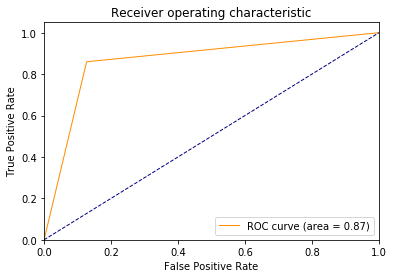

In [39]:
outcome_test = np.ones(len(only_pos_files))
outcome_test = np.append(outcome_test, np.zeros(len(only_neg_files)))

fpr, tpr, thresholds = roc_curve(predictions_test, outcome_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Try Softmax Regression
Chapter 4 in the book teaches us also about softmax regression. The big difference with softmax is that we can predict more than 2 classes (N output classes) and to do so, we set up an equation like Y = WX + B, where W are the weights (num_features * num_labels), X is the input feature data (num_train * num_features), and B the offset constant (num_labels) and Y is the one-hot encoded class labels we are trying to predict (num_labels). Y, X, W and B are matrices. The book also teaches us to use batch training, so we'll set all that up here. One interesting property is that Softmax natively provides class confidence for each prediction. This could be done with n-d logistic regression by estimating tthe difference from absolute 0 or 1 for the predicted y_model value and then divide by 0.5.

In [40]:
learning_rate = 0.01
training_epochs = 1000
num_labels = 2
batch_size = 100

In [41]:
def softmax_feat_vec_from_review(test_review, vocab):
    #assumption: review is clean
    #create the test vocabulary and counts
    n_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
    
    ex_data_features = n_vectorizer.fit_transform([test_review])
    ex_data_features = ex_data_features.toarray()
    test_vocab = n_vectorizer.get_feature_names()
    test_vocab_counts = ex_data_features.reshape(ex_data_features.shape[1])
    
    # figure out the intersection of the test vocabulary from the review with the actual full vocabulary
    ind_dict = dict((k, i) for i, k in enumerate(vocab))
    test_ind_dict = dict((k, i) for i, k in enumerate(test_vocab))
    inter = set(ind_dict).intersection(test_vocab)
    indices = [ ind_dict[x] for x in inter ]
    test_indices = [test_ind_dict[x] for x in inter]
    
    # all zeros for the 5000 feature vec except for the overlap indices that we have counts for
    test_feature_vec = np.zeros(train_data_features.shape[1])
    for i in range(len(indices)):
        test_feature_vec[indices[i]] = test_vocab_counts[test_indices[i]]
     
    
    return test_feature_vec


In [42]:
num_pos_labels = len(train.loc[train['sentiment'] == 1.])
num_neg_labels = len(train.loc[train['sentiment'] == 0.])
lab_mat = []
for i in range(len(train['sentiment'])):
    if train['sentiment'][i] == 1.0:
        #lab_mat = lab_mat + [[1., 0.]]
        lab_mat = lab_mat + [[0., 1.]]
    elif train['sentiment'][i] == 0.0:
        #lab_mat = lab_mat + [[0., 1.]]
        lab_mat = lab_mat + [[1., 0.]]

labels = np.matrix(lab_mat)
print(labels)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [43]:
xs = train_data_features.astype(float)
train_size, num_features = xs.shape
print(xs.shape)
print(labels.shape)

(25000, 5000)
(25000, 2)


In [44]:
#shuffle the labels so that the system doesn't learn that the order of the data matters
arr = np.arange(xs.shape[0])
np.random.shuffle(arr)
xs = xs[arr, :]
labels = labels[arr, :]

In [45]:
X = tf.placeholder("float", shape=[None, num_features])
Y = tf.placeholder("float", shape=[None, num_labels])
W = tf.Variable(tf.zeros([num_features, num_labels]))
b = tf.Variable(tf.zeros([num_labels]))
y_model = tf.nn.softmax(tf.matmul(X, W) + b)

In [46]:
# sometimes the result of y_model can be 0, and log0 is NaN, so account for it
# see: https://stackoverflow.com/questions/38538635/tensorflow-returning-nan-when-implementing-logistic-regression
cost = -tf.reduce_sum(Y * tf.log(tf.maximum(y_model, 1e-15))) 
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [47]:
correct_prediction = tf.equal(tf.argmax(y_model, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [48]:
test_reviews = []
clean_test_reviews = []
test_reviews.extend(only_pos_file_contents)
test_reviews.extend(only_neg_file_contents)

In [49]:
for i in tqdm(range(len(test_reviews))):
    test_review_c = review_to_words(test_reviews[i])
    clean_test_reviews.append(test_review_c)

In [50]:
test_xs = np.zeros((len(clean_test_reviews), num_features))
for i in tqdm(range(len(clean_test_reviews))):
    test_xs[i] = softmax_feat_vec_from_review(clean_test_reviews[i], vocab)

In [51]:
test_xs.shape

(25000, 5000)

In [52]:
test_labels = np.matrix([[0., 1.]] * len(only_pos_file_contents) + [[1., 0.]] * len(only_neg_file_contents))

In [53]:
saver = tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for step in tqdm(range(training_epochs * train_size // batch_size)):
        offset = (step * batch_size) % train_size
        batch_xs = xs[offset:(offset + batch_size), :]
        batch_labels = labels[offset:(offset + batch_size)]
        err, _ = sess.run([cost, train_op], feed_dict={X: batch_xs, Y: batch_labels})
        print (step, err)            
    
    W_val = sess.run(W)
    print('w', W_val)
    b_val = sess.run(b)
    print('b', b_val)
    print("accuracy", accuracy.eval(feed_dict={X: test_xs, Y: test_labels}))
    save_path = saver.save(sess, "./ch4-softmax-netflix-sentiment.ckpt")
    print("Model saved in path: %s" % save_path)

0 69.31473
1 212.88655
2 709.235
3 109.381645
4 503.28833
5 318.28293
6 185.83055
7 388.35086
8 481.54663
9 93.21055
10 85.21361
11 53.504982
12 55.854233
13 92.09408
14 229.34029
15 245.52412
16 92.85612
17 59.863262
18 43.94036
19 52.958187
20 82.39439
21 209.01477
22 283.4557
23 149.22273
24 193.654
25 366.8817
26 275.6861
27 82.89486
28 65.128006
29 82.801605
30 54.831554
31 66.69322
32 74.02371
33 56.069054
34 62.722656
35 57.552593
36 87.485275
37 105.25307
38 141.31085
39 120.14569
40 48.724953
41 81.11392
42 92.05252
43 269.62387
44 426.42804
45 317.2046
46 119.29706
47 95.01802
48 78.38808
49 78.32021
50 95.57049
51 48.723923
52 50.351517
53 34.57825
54 36.14247
55 49.219833
56 65.90669
57 39.96253
58 37.47415
59 48.36048
60 61.812134
61 57.440567
62 56.340744
63 62.90424
64 115.65947
65 135.63742
66 62.81759
67 54.85202
68 44.527176
69 48.635612
70 52.991024
71 38.406616
72 62.487827
73 72.269684
74 68.38187
75 61.52322
76 69.35154
77 51.294228
78 45.486946
79 43.859062
80 74

644 35.32641
645 33.380543
646 25.462557
647 32.33837
648 36.63872
649 23.483192
650 26.903511
651 26.49181
652 29.885952
653 32.800323
654 30.1131
655 23.92854
656 24.55295
657 22.56242
658 22.151215
659 23.676964
660 25.188057
661 30.243313
662 21.063812
663 21.449558
664 42.98922
665 41.528206
666 28.518211
667 26.03654
668 60.893425
669 98.052315
670 54.212753
671 17.786531
672 33.59984
673 15.808048
674 28.242899
675 23.329609
676 25.587624
677 23.17466
678 29.331375
679 16.456945
680 29.261814
681 47.50479
682 36.094643
683 51.428673
684 43.088997
685 31.080353
686 39.603336
687 40.867413
688 36.39083
689 24.493263
690 18.10559
691 39.702477
692 37.0789
693 20.204882
694 28.051323
695 32.730072
696 19.194036
697 37.81472
698 36.697388
699 22.315567
700 13.910212
701 15.259912
702 24.383755
703 25.931147
704 21.173376
705 33.46583
706 37.794815
707 24.680313
708 45.041832
709 41.32319
710 18.886751
711 19.623442
712 40.364246
713 34.533634
714 27.073776
715 33.752777
716 22.481184

1280 26.806534
1281 25.166042
1282 24.85419
1283 21.151333
1284 14.999771
1285 24.962818
1286 25.989426
1287 22.116634
1288 23.140156
1289 31.534712
1290 20.140854
1291 19.58795
1292 20.181536
1293 36.304844
1294 15.972282
1295 30.681149
1296 20.7944
1297 13.851364
1298 20.436447
1299 18.178493
1300 16.491085
1301 19.0475
1302 28.800365
1303 16.381968
1304 15.287009
1305 19.585127
1306 22.271805
1307 11.7562275
1308 18.994326
1309 23.090055
1310 22.803911
1311 35.915142
1312 26.665264
1313 22.887712
1314 10.896498
1315 28.889103
1316 41.410248
1317 20.433603
1318 15.960958
1319 13.7524395
1320 21.178818
1321 14.106943
1322 18.387894
1323 13.69797
1324 18.05016
1325 27.726326
1326 25.892344
1327 13.66521
1328 10.586672
1329 12.239925
1330 30.284502
1331 23.752056
1332 21.714275
1333 30.201612
1334 34.783455
1335 39.965214
1336 52.57468
1337 51.040695
1338 32.89984
1339 62.760963
1340 44.055374
1341 45.069176
1342 29.156742
1343 43.08554
1344 94.51213
1345 50.431915
1346 36.15833
1347 29

1840 9.809177
1841 17.56382
1842 19.578972
1843 26.505013
1844 34.492092
1845 13.964325
1846 19.766691
1847 15.029019
1848 18.220554
1849 13.272348
1850 12.808318
1851 30.97547
1852 23.779152
1853 29.76851
1854 24.436478
1855 20.93142
1856 20.199394
1857 16.01871
1858 16.967375
1859 19.115522
1860 14.459148
1861 20.470863
1862 18.219143
1863 12.396707
1864 20.37974
1865 28.64588
1866 17.046682
1867 25.6072
1868 22.875563
1869 14.762201
1870 16.890211
1871 35.193176
1872 16.072575
1873 30.235046
1874 20.954224
1875 15.878574
1876 19.94464
1877 16.89947
1878 17.05464
1879 32.806713
1880 15.795361
1881 15.951236
1882 22.614828
1883 25.793999
1884 15.931799
1885 44.1718
1886 19.94304
1887 18.682335
1888 28.491138
1889 21.631222
1890 26.441044
1891 17.991589
1892 11.089981
1893 21.49948
1894 22.901474
1895 22.045082
1896 20.538301
1897 24.456993
1898 24.541357
1899 20.542538
1900 19.852394
1901 22.228573
1902 25.906336
1903 31.781696
1904 30.634417
1905 21.360731
1906 13.512096
1907 13.1660

2396 18.923828
2397 27.74498
2398 37.526024
2399 24.103441
2400 18.384062
2401 20.202948
2402 23.537
2403 25.983486
2404 26.333092
2405 19.191776
2406 12.084946
2407 12.024681
2408 13.017129
2409 23.200628
2410 20.418034
2411 20.81882
2412 14.876878
2413 8.500937
2414 33.173313
2415 17.775963
2416 18.741083
2417 17.19635
2418 27.21637
2419 29.952217
2420 22.000418
2421 28.253084
2422 38.098392
2423 14.91648
2424 21.336153
2425 11.249775
2426 18.934969
2427 14.673989
2428 24.046734
2429 14.711518
2430 18.736517
2431 22.167295
2432 16.750496
2433 23.51095
2434 16.393915
2435 32.746243
2436 25.447184
2437 18.444073
2438 20.34323
2439 12.319923
2440 12.467715
2441 25.55732
2442 22.225275
2443 15.062194
2444 13.725719
2445 21.757318
2446 19.359566
2447 25.840355
2448 28.234335
2449 23.173248
2450 16.727673
2451 11.769634
2452 17.463093
2453 15.320588
2454 14.118539
2455 21.504482
2456 25.108608
2457 17.186398
2458 23.701042
2459 25.842178
2460 11.740782
2461 9.963723
2462 27.630016
2463 27.

2989 20.17742
2990 27.480877
2991 19.070286
2992 11.449057
2993 17.702696
2994 9.995107
2995 19.83654
2996 13.318032
2997 20.077074
2998 17.469173
2999 16.89845
3000 23.936039
3001 31.800186
3002 18.31338
3003 15.060057
3004 11.168312
3005 16.64547
3006 14.736944
3007 22.145796
3008 12.832516
3009 17.380524
3010 22.1197
3011 9.650801
3012 26.446718
3013 16.15266
3014 18.557943
3015 18.550001
3016 15.560016
3017 19.944857
3018 15.138382
3019 12.028887
3020 23.390398
3021 32.463367
3022 15.828875
3023 13.79859
3024 14.065752
3025 16.388493
3026 16.001694
3027 17.302395
3028 16.026342
3029 22.347353
3030 16.967083
3031 21.91319
3032 17.46666
3033 16.339455
3034 14.494895
3035 25.66671
3036 27.198288
3037 19.113436
3038 22.60081
3039 22.643923
3040 19.0062
3041 15.323894
3042 16.26936
3043 26.845436
3044 11.87499
3045 21.532944
3046 9.951763
3047 15.692153
3048 17.9544
3049 16.625483
3050 14.725668
3051 17.448395
3052 21.86887
3053 14.34331
3054 13.218567
3055 17.278938
3056 16.582882
3057

3557 8.696724
3558 13.2127285
3559 18.446712
3560 18.081451
3561 28.951487
3562 21.080143
3563 16.425034
3564 7.1458797
3565 15.346759
3566 25.989944
3567 15.012734
3568 14.632647
3569 10.640103
3570 18.402817
3571 12.635513
3572 14.251375
3573 10.935314
3574 14.315315
3575 24.596825
3576 20.525333
3577 10.281959
3578 9.380985
3579 9.055349
3580 22.568457
3581 21.236385
3582 16.744442
3583 20.714535
3584 31.769215
3585 21.707024
3586 24.884369
3587 17.342764
3588 18.502178
3589 16.659306
3590 10.198971
3591 13.61978
3592 13.231636
3593 23.7463
3594 24.285458
3595 12.100787
3596 16.157831
3597 12.079995
3598 16.310951
3599 10.238892
3600 10.939182
3601 25.87387
3602 19.03521
3603 26.19817
3604 23.276525
3605 15.949171
3606 16.672392
3607 13.024816
3608 15.178681
3609 12.953518
3610 11.235991
3611 17.917337
3612 15.484208
3613 12.958676
3614 16.205095
3615 25.258549
3616 12.876012
3617 22.806614
3618 17.498653
3619 11.99172
3620 13.079099
3621 30.78833
3622 14.587187
3623 26.856907
3624 

4139 20.828909
4140 22.531837
4141 16.312954
4142 9.669336
4143 19.372087
4144 20.604538
4145 15.144747
4146 16.56473
4147 23.745628
4148 20.319038
4149 17.979008
4150 15.587027
4151 18.707598
4152 21.353619
4153 23.733757
4154 24.865969
4155 16.960682
4156 11.659002
4157 10.188906
4158 9.147008
4159 18.444267
4160 16.501411
4161 17.560062
4162 13.4049015
4163 7.3562756
4164 32.316532
4165 16.257462
4166 16.57425
4167 15.213077
4168 25.626057
4169 27.47013
4170 17.426176
4171 10.982099
4172 21.265274
4173 6.343196
4174 14.95924
4175 7.8767896
4176 15.074093
4177 12.143201
4178 23.099983
4179 14.843939
4180 16.675665
4181 18.429535
4182 14.508766
4183 22.516
4184 14.029907
4185 27.582937
4186 18.88556
4187 15.093079
4188 17.200747
4189 10.733082
4190 10.596762
4191 24.23558
4192 18.814861
4193 14.406189
4194 11.747824
4195 17.975914
4196 16.134758
4197 24.708702
4198 24.256624
4199 20.749813
4200 12.408795
4201 10.302802
4202 15.947723
4203 15.510913
4204 13.286936
4205 18.927887
4206 1

4708 19.468662
4709 22.394659
4710 9.976551
4711 9.331519
4712 24.460638
4713 24.80992
4714 13.755896
4715 29.136658
4716 13.852892
4717 15.91493
4718 19.991783
4719 9.571623
4720 13.250367
4721 25.195347
4722 25.929081
4723 13.284112
4724 14.720133
4725 16.112963
4726 27.500942
4727 9.275282
4728 19.093245
4729 16.160671
4730 23.504889
4731 17.512655
4732 13.981237
4733 17.889822
4734 27.612272
4735 20.07679
4736 11.052242
4737 26.830406
4738 14.749006
4739 15.692036
4740 26.216503
4741 17.896564
4742 9.188117
4743 15.010741
4744 9.465836
4745 16.603165
4746 12.082401
4747 20.311388
4748 14.422685
4749 15.635729
4750 16.737736
4751 27.884365
4752 17.409128
4753 13.682118
4754 10.146126
4755 14.177048
4756 14.375539
4757 19.827423
4758 12.911774
4759 15.370834
4760 19.522675
4761 7.6582437
4762 24.651514
4763 15.377552
4764 17.405754
4765 16.736938
4766 14.214647
4767 17.738144
4768 12.618879
4769 11.705466
4770 20.606829
4771 29.506271
4772 13.115042
4773 12.425576
4774 11.709587
4775

5314 6.987803
5315 13.185397
5316 23.667616
5317 15.385636
5318 13.93908
5319 8.728714
5320 16.34066
5321 12.564293
5322 12.384601
5323 9.822945
5324 13.820638
5325 21.943485
5326 19.522598
5327 9.543364
5328 10.148077
5329 8.697192
5330 19.75861
5331 20.512848
5332 16.661991
5333 24.279627
5334 37.01426
5335 23.107935
5336 24.709492
5337 20.911238
5338 18.39501
5339 13.884179
5340 11.125729
5341 13.615095
5342 11.724237
5343 22.266455
5344 18.81862
5345 11.167252
5346 14.217829
5347 11.08279
5348 15.858501
5349 8.386957
5350 10.124649
5351 25.368168
5352 16.500862
5353 23.378475
5354 20.383865
5355 13.393751
5356 15.41973
5357 12.738123
5358 14.10253
5359 12.11327
5360 11.360345
5361 17.16504
5362 12.831804
5363 10.588533
5364 13.849619
5365 23.09068
5366 11.087216
5367 22.388292
5368 16.041445
5369 11.628658
5370 12.733576
5371 27.11335
5372 12.922478
5373 22.98529
5374 17.941496
5375 13.821979
5376 16.81663
5377 14.904419
5378 12.978437
5379 26.675875
5380 12.329467
5381 11.737312
5

5891 15.9907055
5892 8.148499
5893 16.705667
5894 18.049938
5895 14.194551
5896 15.320517
5897 21.400402
5898 14.651056
5899 15.580629
5900 12.921284
5901 17.927357
5902 19.71065
5903 22.30233
5904 25.524652
5905 13.727137
5906 11.566372
5907 9.754299
5908 7.1800866
5909 16.052372
5910 16.186909
5911 16.3904
5912 12.543005
5913 6.8743744
5914 30.733261
5915 13.035311
5916 17.949457
5917 15.288137
5918 23.993816
5919 25.863728
5920 17.569897
5921 12.531751
5922 21.19777
5923 6.021683
5924 12.36253
5925 7.186218
5926 13.029127
5927 10.099755
5928 20.966543
5929 13.149313
5930 15.590568
5931 16.31316
5932 11.696234
5933 19.603043
5934 12.759896
5935 22.610031
5936 15.972593
5937 12.859973
5938 13.743279
5939 8.874631
5940 8.962219
5941 20.944489
5942 17.257442
5943 13.344116
5944 11.311695
5945 16.92744
5946 13.206295
5947 22.561157
5948 23.342657
5949 19.470871
5950 12.164806
5951 9.843939
5952 14.663907
5953 13.393835
5954 12.380846
5955 16.68277
5956 15.558059
5957 10.779507
5958 18.43

6488 13.165948
6489 14.26018
6490 25.571983
6491 17.218212
6492 8.018365
6493 12.65308
6494 9.626846
6495 14.899353
6496 10.886776
6497 20.171001
6498 13.075971
6499 15.074718
6500 15.22529
6501 27.208445
6502 17.349577
6503 11.5345955
6504 9.566897
6505 12.360671
6506 14.01095
6507 17.938408
6508 11.599226
6509 14.430908
6510 18.319191
6511 7.023247
6512 22.507938
6513 15.245413
6514 16.89375
6515 16.654217
6516 13.364622
6517 17.784563
6518 12.6411295
6519 10.726128
6520 17.887802
6521 27.316442
6522 11.281965
6523 12.151447
6524 10.692472
6525 14.408461
6526 13.949908
6527 14.546208
6528 12.908932
6529 18.168413
6530 11.223593
6531 19.783052
6532 17.720142
6533 12.301669
6534 6.5430384
6535 14.047779
6536 23.7986
6537 15.274028
6538 18.693634
6539 19.461494
6540 14.685381
6541 12.484142
6542 14.238161
6543 17.58712
6544 9.639309
6545 18.524235
6546 8.556473
6547 12.383221
6548 14.453359
6549 12.953548
6550 11.58586
6551 18.36448
6552 18.774685
6553 11.722918
6554 11.780016
6555 15.0

7093 20.854237
7094 16.36769
7095 11.559069
7096 13.469968
7097 9.619639
7098 15.249245
7099 8.428084
7100 9.818134
7101 26.135212
7102 14.958328
7103 22.260738
7104 19.168999
7105 12.332464
7106 14.070375
7107 12.75337
7108 13.73816
7109 10.65354
7110 10.278973
7111 16.499264
7112 12.316601
7113 9.993841
7114 12.555828
7115 23.107573
7116 9.731156
7117 21.85214
7118 13.681404
7119 9.584293
7120 11.60757
7121 25.58636
7122 12.296302
7123 21.209534
7124 16.960487
7125 13.804262
7126 15.502334
7127 11.745918
7128 11.179098
7129 25.554398
7130 11.947383
7131 10.0894
7132 13.292118
7133 14.223225
7134 14.332598
7135 26.785467
7136 14.666108
7137 14.994985
7138 24.919214
7139 20.582264
7140 20.513725
7141 15.538684
7142 7.776822
7143 13.986395
7144 18.308338
7145 13.056889
7146 15.27289
7147 20.65182
7148 12.8387785
7149 14.61395
7150 12.965859
7151 17.257616
7152 18.80895
7153 21.429008
7154 24.141537
7155 13.664394
7156 11.280771
7157 8.636191
7158 7.2067513
7159 15.686776
7160 16.601078


7737 22.672493
7738 12.606081
7739 12.712776
7740 24.783154
7741 16.723568
7742 7.8955226
7743 12.174257
7744 8.992026
7745 13.555497
7746 10.439529
7747 20.483124
7748 12.309431
7749 14.13883
7750 13.50778
7751 25.086336
7752 16.421082
7753 11.091181
7754 9.403361
7755 11.245552
7756 13.96744
7757 17.076706
7758 11.476953
7759 13.326447
7760 17.276663
7761 6.469223
7762 21.779942
7763 15.151963
7764 15.988443
7765 15.5827
7766 13.03483
7767 16.67806
7768 12.132717
7769 10.135929
7770 16.539137
7771 25.800564
7772 10.191357
7773 11.941184
7774 9.888657
7775 14.218833
7776 14.174591
7777 13.2369795
7778 12.004764
7779 17.226105
7780 10.326325
7781 18.809856
7782 15.33921
7783 12.393826
7784 6.0413313
7785 14.278047
7786 22.132118
7787 13.7036
7788 18.23338
7789 18.88624
7790 14.619619
7791 11.909384
7792 14.043081
7793 14.771902
7794 9.336187
7795 17.350191
7796 7.634774
7797 12.364215
7798 14.326468
7799 12.373753
7800 10.641924
7801 18.227367
7802 18.25466
7803 11.161291
7804 11.50022

8345 10.841141
8346 12.804532
8347 9.113066
8348 14.874534
8349 8.600181
8350 8.954467
8351 23.743866
8352 14.41856
8353 21.179174
8354 17.847464
8355 12.553378
8356 13.508088
8357 12.655113
8358 13.120944
8359 10.441545
8360 10.417127
8361 16.379368
8362 11.646625
8363 9.264029
8364 11.4164505
8365 21.835781
8366 8.757464
8367 21.88348
8368 12.759474
8369 9.480013
8370 10.918254
8371 24.02356
8372 11.821569
8373 20.303932
8374 16.879362
8375 13.929729
8376 15.046407
8377 11.146347
8378 11.128254
8379 24.784138
8380 11.756266
8381 9.878397
8382 12.460301
8383 13.376555
8384 13.697547
8385 25.509903
8386 14.322069
8387 14.839667
8388 25.127575
8389 20.394367
8390 20.217896
8391 15.4654455
8392 7.320371
8393 12.288681
8394 17.06432
8395 12.652387
8396 14.829557
8397 20.074833
8398 12.53526
8399 14.441848
8400 12.639448
8401 17.142748
8402 17.996576
8403 20.194126
8404 23.291046
8405 13.343981
8406 10.853033
8407 8.16394
8408 7.2414746
8409 15.466778
8410 16.284203
8411 14.536846
8412 12.

8972 21.536678
8973 10.767862
8974 10.986172
8975 14.8014965
8976 23.85187
8977 7.8648314
8978 11.713434
8979 13.562494
8980 20.276468
8981 15.533703
8982 11.645597
8983 17.882933
8984 24.016758
8985 15.708992
8986 10.136493
8987 21.08936
8988 12.270687
8989 12.320244
8990 24.916174
8991 16.341026
8992 7.6571016
8993 15.729126
8994 7.3180685
8995 12.304057
8996 9.853759
8997 20.433731
8998 12.166987
8999 13.298354
9000 12.130903
9001 23.498222
9002 16.332174
9003 10.932151
9004 9.497465
9005 10.829718
9006 14.154325
9007 16.864647
9008 11.395891
9009 12.762562
9010 16.701328
9011 5.72397
9012 21.181213
9013 14.55772
9014 15.548227
9015 15.43237
9016 12.989473
9017 15.850736
9018 11.565621
9019 10.32056
9020 15.325028
9021 24.77877
9022 9.501184
9023 11.645617
9024 9.248438
9025 13.931812
9026 13.813981
9027 12.127239
9028 11.509237
9029 16.586864
9030 10.029504
9031 18.527203
9032 16.218765
9033 12.3393955
9034 5.9161196
9035 15.25712
9036 21.768387
9037 13.960678
9038 18.137346
9039 1

9530 10.040762
9531 17.997267
9532 14.003995
9533 12.793491
9534 5.3449917
9535 14.171072
9536 21.536251
9537 13.072194
9538 17.31105
9539 18.042778
9540 14.493935
9541 11.45468
9542 13.766684
9543 12.674682
9544 9.191722
9545 16.897987
9546 7.4372416
9547 12.204987
9548 13.848496
9549 11.875341
9550 9.950884
9551 17.779243
9552 18.449017
9553 11.104268
9554 11.361412
9555 14.458658
9556 13.171562
9557 7.778328
9558 8.1951275
9559 15.798014
9560 15.709277
9561 21.93964
9562 16.032537
9563 12.425596
9564 5.1372585
9565 11.1718025
9566 19.664957
9567 14.585016
9568 12.376581
9569 7.220664
9570 14.7620125
9571 10.772059
9572 10.327475
9573 9.217402
9574 12.952314
9575 18.537376
9576 16.589985
9577 8.233696
9578 9.313032
9579 7.312854
9580 16.620934
9581 19.775576
9582 13.442226
9583 16.97722
9584 30.124508
9585 13.322631
9586 15.984477
9587 12.140514
9588 13.473151
9589 11.1539135
9590 10.453079
9591 10.961018
9592 9.062888
9593 18.700428
9594 15.045765
9595 10.28735
9596 12.404673
9597 9

10110 9.967983
10111 16.396013
10112 11.126886
10113 8.679135
10114 10.467464
10115 20.910992
10116 8.471329
10117 21.647238
10118 12.662842
10119 9.573675
10120 10.896194
10121 23.716318
10122 11.003102
10123 19.046099
10124 16.353325
10125 13.486099
10126 13.984065
10127 11.531248
10128 10.686869
10129 24.936806
10130 11.00486
10131 9.736851
10132 10.4312725
10133 11.547014
10134 12.470493
10135 24.039583
10136 12.598335
10137 11.066316
10138 25.007048
10139 20.145086
10140 19.438486
10141 15.450488
10142 6.7647123
10143 9.964163
10144 15.186922
10145 12.405135
10146 14.113373
10147 19.379436
10148 10.608284
10149 13.481325
10150 12.002213
10151 16.983631
10152 17.192225
10153 18.651413
10154 22.87568
10155 11.402262
10156 11.096753
10157 7.647775
10158 6.9633846
10159 14.548297
10160 16.7188
10161 13.713743
10162 11.77426
10163 5.997966
10164 28.060255
10165 10.960014
10166 15.567856
10167 12.772692
10168 23.310986
10169 24.33192
10170 13.375149
10171 6.50538
10172 16.435404
10173 5

10633 11.124574
10634 12.104916
10635 23.522121
10636 12.58375
10637 11.010194
10638 24.636494
10639 20.013206
10640 19.594437
10641 15.382028
10642 6.6385612
10643 9.74049
10644 14.979477
10645 12.350002
10646 13.785324
10647 19.485165
10648 10.827397
10649 13.436224
10650 11.870783
10651 16.980879
10652 17.158817
10653 17.634201
10654 22.508083
10655 11.250872
10656 11.493879
10657 7.7029867
10658 6.441025
10659 14.642582
10660 16.252138
10661 13.533752
10662 11.402128
10663 5.879015
10664 28.313164
10665 10.59821
10666 15.806154
10667 12.767513
10668 23.002033
10669 23.964733
10670 12.91071
10671 6.7171774
10672 15.983452
10673 5.374023
10674 10.810949
10675 6.741614
10676 10.407005
10677 7.7310104
10678 16.313107
10679 10.619726
10680 14.505564
10681 15.3607435
10682 10.100796
10683 18.255978
10684 11.309256
10685 19.757114
10686 13.291074
10687 11.107439
10688 12.280624
10689 9.18188
10690 8.055249
10691 18.508102
10692 14.343274
10693 13.200681
10694 9.749039
10695 14.57524
10696

11196 10.341919
11197 21.005909
11198 20.466152
11199 16.98693
11200 10.057564
11201 8.84236
11202 12.57172
11203 11.557935
11204 11.392471
11205 14.0773945
11206 12.159676
11207 8.597932
11208 14.732759
11209 17.22287
11210 8.785528
11211 7.186249
11212 19.935467
11213 19.529453
11214 11.317422
11215 26.54169
11216 12.302187
11217 12.530483
11218 16.146194
11219 9.420263
11220 10.776608
11221 23.827879
11222 20.628006
11223 10.331886
11224 9.83131
11225 12.901593
11226 21.771152
11227 7.860354
11228 9.785503
11229 13.436939
11230 19.039371
11231 14.658107
11232 10.863317
11233 17.216698
11234 22.178308
11235 15.304985
11236 10.057245
11237 19.412193
11238 11.336262
11239 11.248102
11240 23.963114
11241 16.100033
11242 7.1461787
11243 11.56848
11244 7.7425723
11245 11.504686
11246 9.601152
11247 20.744421
11248 10.928871
11249 12.310238
11250 11.195109
11251 22.560411
11252 15.194706
11253 10.280537
11254 9.623315
11255 10.151135
11256 14.04067
11257 16.01056
11258 11.051916
11259 11.9

11793 11.063126
11794 9.098985
11795 15.883341
11796 6.7383947
11797 12.542017
11798 14.374378
11799 11.794458
11800 9.856705
11801 17.354952
11802 17.169601
11803 10.450165
11804 11.287109
11805 14.176847
11806 12.708864
11807 7.753529
11808 6.7165384
11809 15.68757
11810 15.996519
11811 21.019745
11812 15.327137
11813 12.462097
11814 5.132235
11815 9.859058
11816 18.437435
11817 14.133942
11818 11.722073
11819 6.764701
11820 14.364593
11821 10.810076
11822 9.7948065
11823 9.0307
11824 12.907089
11825 17.637623
11826 15.755294
11827 7.742916
11828 9.233094
11829 7.039974
11830 15.375051
11831 19.430641
11832 12.754969
11833 15.603663
11834 29.033562
11835 11.93556
11836 12.468641
11837 11.5107765
11838 11.476755
11839 10.9822445
11840 11.146196
11841 9.969681
11842 8.33892
11843 17.522827
11844 13.9788065
11845 9.47161
11846 11.224207
11847 8.607217
11848 14.260155
11849 7.7140894
11850 7.936985
11851 20.414152
11852 12.81456
11853 19.668667
11854 15.31333
11855 11.709053
11856 12.210

12325 16.869425
12326 15.605366
12327 7.5044827
12328 9.013418
12329 6.912476
12330 15.051827
12331 19.210468
12332 12.577002
12333 15.633916
12334 29.673325
12335 11.756672
12336 13.201391
12337 10.573787
12338 11.71615
12339 10.880438
12340 10.635523
12341 10.16124
12342 8.385298
12343 17.061953
12344 13.896704
12345 9.864295
12346 11.159616
12347 8.711124
12348 14.468736
12349 8.182071
12350 6.844052
12351 18.04802
12352 12.594713
12353 19.664257
12354 14.968718
12355 11.894827
12356 12.468477
12357 11.68483
12358 12.213246
12359 9.113831
12360 9.537716
12361 16.18199
12362 10.82277
12363 8.183038
12364 9.922486
12365 20.321629
12366 7.8766513
12367 21.52901
12368 11.438997
12369 9.214175
12370 10.239164
12371 22.133783
12372 10.47668
12373 17.897348
12374 15.597067
12375 12.897018
12376 13.487856
12377 10.976135
12378 11.255896
12379 24.691753
12380 10.778255
12381 9.60324
12382 10.215336
12383 11.10503
12384 11.6550865
12385 22.152493
12386 12.616304
12387 11.3143835
12388 24.8126

12886 12.904293
12887 11.709913
12888 24.679432
12889 20.013542
12890 18.573742
12891 15.339769
12892 6.371543
12893 9.661826
12894 14.429734
12895 11.425476
12896 13.458998
12897 19.652876
12898 11.51917
12899 13.017057
12900 11.20864
12901 16.660406
12902 16.344036
12903 16.540705
12904 20.878826
12905 11.424675
12906 11.056446
12907 7.1570015
12908 5.981688
12909 14.638292
12910 15.357223
12911 12.767729
12912 11.155924
12913 5.5038166
12914 27.236927
12915 10.134425
12916 15.565138
12917 12.505421
12918 21.86799
12919 22.627155
12920 12.714017
12921 7.4421134
12922 16.239662
12923 5.141387
12924 10.045938
12925 6.8094234
12926 9.721981
12927 7.2429714
12928 15.516563
12929 10.41178
12930 14.0991535
12931 14.586793
12932 9.53269
12933 17.231215
12934 10.565324
12935 18.103645
12936 13.199509
12937 10.731018
12938 11.31011
12939 8.112844
12940 7.5507774
12941 17.941772
12942 14.197922
12943 12.915041
12944 9.37211
12945 13.807759
12946 9.762224
12947 20.679092
12948 19.816334
12949 1

13465 26.158752
13466 12.201117
13467 11.936716
13468 15.446276
13469 9.227774
13470 10.263632
13471 23.800077
13472 19.591791
13473 9.914555
13474 9.15101
13475 12.35788
13476 21.149626
13477 7.6634245
13478 8.856352
13479 13.059311
13480 18.391209
13481 13.999545
13482 10.062987
13483 16.407475
13484 21.081331
13485 14.711703
13486 9.888029
13487 18.06858
13488 10.554231
13489 10.714712
13490 23.268936
13491 15.853693
13492 6.71603
13493 11.101137
13494 7.75479
13495 10.705089
13496 9.160456
13497 21.04913
13498 10.43887
13499 11.659681
13500 10.439248
13501 21.301271
13502 14.743806
13503 9.658152
13504 9.30414
13505 9.415717
13506 14.17717
13507 14.970053
13508 10.738039
13509 11.555928
13510 15.153313
13511 5.0355134
13512 18.615725
13513 14.958847
13514 13.921816
13515 14.416108
13516 11.972525
13517 14.5728855
13518 10.868832
13519 9.867437
13520 12.993799
13521 22.83351
13522 8.305101
13523 11.419625
13524 8.142077
13525 13.164101
13526 13.50918
13527 11.258579
13528 10.369621


14020 12.8405
14021 22.519182
14022 8.145834
14023 11.271594
14024 8.114883
14025 13.059582
14026 13.473223
14027 10.942981
14028 10.281324
14029 15.157705
14030 9.028511
14031 16.637306
14032 13.568388
14033 12.506008
14034 4.8544292
14035 13.765596
14036 20.11772
14037 11.506521
14038 15.214859
14039 16.938742
14040 13.642585
14041 10.494022
14042 12.50565
14043 10.002936
14044 8.813519
14045 15.443861
14046 6.592107
14047 11.855234
14048 13.058807
14049 10.922955
14050 9.11911
14051 17.376638
14052 16.856709
14053 10.115018
14054 10.849606
14055 13.462448
14056 12.398593
14057 7.544651
14058 6.3059607
14059 15.024279
14060 15.367108
14061 21.16872
14062 14.779367
14063 11.669222
14064 4.3187866
14065 9.596653
14066 17.890928
14067 13.49655
14068 11.374715
14069 6.351083
14070 14.248018
14071 9.972376
14072 9.436182
14073 8.673794
14074 12.433831
14075 15.913856
14076 14.725424
14077 7.1057696
14078 8.925304
14079 6.6188455
14080 14.600002
14081 19.069046
14082 12.1833935
14083 14.98

14594 13.136557
14595 9.184259
14596 10.668324
14597 8.515324
14598 13.373336
14599 8.068807
14600 7.7251816
14601 19.80539
14602 12.175045
14603 18.919838
14604 13.866981
14605 11.202331
14606 12.0901985
14607 12.06794
14608 11.690416
14609 8.685367
14610 8.948988
14611 16.161987
14612 10.314729
14613 7.8166037
14614 9.457594
14615 20.183624
14616 7.7015686
14617 21.309196
14618 10.342412
14619 8.276823
14620 10.014349
14621 20.95395
14622 9.761641
14623 16.621683
14624 15.359159
14625 13.118251
14626 13.026445
14627 10.324959
14628 10.913109
14629 24.396957
14630 10.506015
14631 9.034489
14632 9.221708
14633 9.982463
14634 11.049545
14635 20.321499
14636 12.429308
14637 10.745181
14638 24.52569
14639 19.783955
14640 18.003689
14641 15.272253
14642 6.01571
14643 8.935658
14644 14.241469
14645 11.461589
14646 13.074685
14647 18.149578
14648 9.257011
14649 12.642941
14650 11.166294
14651 16.4441
14652 15.845439
14653 16.330017
14654 21.015388
14655 10.856716
14656 10.994847
14657 6.9381

15146 13.078609
15147 18.201595
15148 8.881636
15149 12.732891
15150 11.284337
15151 16.477362
15152 15.6825485
15153 16.265236
15154 20.496943
15155 10.996188
15156 10.816036
15157 6.958843
15158 5.8603525
15159 13.61053
15160 15.683842
15161 12.379137
15162 11.407545
15163 5.4314766
15164 26.779854
15165 10.166072
15166 14.648647
15167 12.131252
15168 21.67565
15169 22.021675
15170 11.87586
15171 6.2369184
15172 15.255955
15173 5.1065373
15174 10.024498
15175 6.728098
15176 9.182735
15177 7.0474386
15178 14.912099
15179 9.796688
15180 13.640657
15181 14.710742
15182 10.7603655
15183 19.816822
15184 10.462568
15185 17.53729
15186 12.533318
15187 9.515658
15188 10.333763
15189 8.62522
15190 7.5130143
15191 17.198055
15192 13.652436
15193 13.063232
15194 8.929867
15195 13.040437
15196 9.0263605
15197 20.59107
15198 19.080738
15199 16.11937
15200 9.276148
15201 8.126342
15202 11.657146
15203 11.040379
15204 11.249058
15205 13.085772
15206 10.7299
15207 7.6855583
15208 13.049025
15209 15.

15680 13.451824
15681 14.939234
15682 10.048191
15683 18.62063
15684 10.446325
15685 17.559895
15686 12.406324
15687 9.544709
15688 10.360868
15689 8.584903
15690 7.6320686
15691 16.997484
15692 13.574231
15693 13.133721
15694 8.769193
15695 13.169109
15696 9.095725
15697 20.350803
15698 18.91644
15699 15.825373
15700 9.083172
15701 8.124608
15702 11.39644
15703 10.610017
15704 11.046696
15705 13.098798
15706 10.488434
15707 7.930399
15708 12.788329
15709 14.874073
15710 8.414322
15711 6.695689
15712 18.501923
15713 17.988644
15714 10.541986
15715 25.2962
15716 12.108055
15717 11.758345
15718 15.232809
15719 9.09732
15720 10.010633
15721 23.240786
15722 18.48983
15723 9.666419
15724 9.155989
15725 11.713581
15726 20.392029
15727 7.365352
15728 8.223149
15729 12.650019
15730 17.490507
15731 13.48626
15732 9.624868
15733 15.794686
15734 20.442219
15735 13.754728
15736 9.555475
15737 17.090954
15738 10.155493
15739 10.29048
15740 23.00682
15741 15.4176445
15742 6.4004974
15743 12.504267
1

16237 16.934742
16238 10.052922
16239 10.08256
16240 22.830885
16241 15.326754
16242 6.322059
16243 10.858086
16244 7.5287695
16245 9.882739
16246 8.797533
16247 20.83996
16248 9.94622
16249 10.879652
16250 9.548776
16251 20.194252
16252 14.267398
16253 8.923586
16254 9.01903
16255 9.013483
16256 13.937113
16257 14.526279
16258 10.476915
16259 11.059091
16260 14.542357
16261 4.7268414
16262 17.196188
16263 14.596714
16264 13.242294
16265 14.112288
16266 11.775675
16267 13.93561
16268 10.236097
16269 9.917725
16270 12.123401
16271 21.769295
16272 7.772187
16273 10.898018
16274 7.69517
16275 12.568449
16276 13.18855
16277 10.241735
16278 9.964775
16279 14.673497
16280 8.664549
16281 16.159092
16282 13.217388
16283 12.2264385
16284 4.5594997
16285 14.09733
16286 19.58289
16287 10.824868
16288 14.619337
16289 16.490059
16290 13.4053545
16291 10.171602
16292 12.360394
16293 9.48506
16294 8.802266
16295 15.149796
16296 6.35777
16297 11.667694
16298 12.596142
16299 10.511044
16300 8.737069
16

16811 20.781548
16812 14.179096
16813 11.723917
16814 4.458332
16815 9.099827
16816 17.145248
16817 13.729092
16818 10.917955
16819 6.093304
16820 14.138187
16821 9.623262
16822 9.47945
16823 8.341965
16824 12.328493
16825 15.263289
16826 14.037494
16827 6.9103484
16828 8.708696
16829 6.2792153
16830 14.080524
16831 18.791948
16832 11.345519
16833 14.120667
16834 29.238785
16835 9.790823
16836 11.20956
16837 9.344156
16838 10.500013
16839 10.070311
16840 10.933105
16841 9.319103
16842 7.7801204
16843 15.525816
16844 12.829121
16845 8.683935
16846 10.140481
16847 8.229733
16848 12.999971
16849 7.277541
16850 6.6397038
16851 17.080883
16852 11.511114
16853 18.337631
16854 13.240884
16855 10.94403
16856 11.533558
16857 11.650148
16858 11.564594
16859 8.464806
16860 8.591852
16861 16.00893
16862 10.096587
16863 7.740019
16864 9.226177
16865 19.668055
16866 7.208692
16867 20.862244
16868 10.29945
16869 8.119935
16870 10.027792
16871 20.336811
16872 9.317417
16873 15.866122
16874 14.697004
1

17368 10.083949
17369 8.174505
17370 9.91695
17371 20.255188
17372 9.169876
17373 15.813839
17374 14.740443
17375 12.282825
17376 12.612688
17377 10.361096
17378 10.93708
17379 24.677235
17380 9.918057
17381 8.960601
17382 9.412955
17383 10.06151
17384 10.596293
17385 18.811028
17386 12.283658
17387 10.829493
17388 24.453314
17389 19.833328
17390 17.517838
17391 15.306439
17392 5.8332872
17393 8.814283
17394 13.918065
17395 10.713963
17396 12.4652405
17397 18.805313
17398 9.411014
17399 12.235519
17400 10.8142395
17401 16.641886
17402 15.098528
17403 14.851709
17404 19.553967
17405 10.357054
17406 10.843126
17407 6.6024213
17408 5.7973495
17409 13.47344
17410 14.883183
17411 11.69879
17412 10.835761
17413 4.939507
17414 26.129593
17415 9.327066
17416 14.530414
17417 11.645393
17418 20.778505
17419 21.427965
17420 11.301195
17421 6.468289
17422 15.095615
17423 4.7493153
17424 9.6550865
17425 6.600588
17426 8.865488
17427 6.7077394
17428 14.188112
17429 9.48925
17430 13.152468
17431 14.0

17917 11.591108
17918 20.49044
17919 21.273932
17920 11.19269
17921 6.505389
17922 14.99602
17923 4.702651
17924 9.626766
17925 6.594875
17926 8.663382
17927 6.650365
17928 14.074821
17929 9.41175
17930 13.071936
17931 13.967585
17932 9.102946
17933 16.826586
17934 10.177614
17935 16.550142
17936 12.395052
17937 9.553031
17938 9.775121
17939 7.7968073
17940 7.1562066
17941 16.584972
17942 13.446791
17943 12.813788
17944 8.5172825
17945 12.667243
17946 8.649628
17947 20.024319
17948 18.624332
17949 15.582602
17950 8.832825
17951 7.9177246
17952 11.407081
17953 10.391296
17954 10.889122
17955 12.446659
17956 10.469921
17957 7.646616
17958 12.097118
17959 14.079855
17960 8.172022
17961 6.1119866
17962 17.881355
17963 17.023033
17964 10.270463
17965 25.480848
17966 11.989243
17967 11.08788
17968 14.625235
17969 8.800999
17970 9.558803
17971 23.59131
17972 17.904415
17973 9.546863
17974 8.559254
17975 11.12132
17976 19.82211
17977 7.28727
17978 7.942397
17979 12.646398
17980 17.046505
17981

18485 13.466722
18486 9.491526
18487 16.171753
18488 9.458843
18489 9.741553
18490 22.17998
18491 15.16353
18492 6.088974
18493 10.59421
18494 7.052164
18495 9.383245
18496 8.457489
18497 20.9125
18498 9.628845
18499 10.280985
18500 9.1394615
18501 19.45402
18502 13.545641
18503 8.682222
18504 8.944827
18505 8.53335
18506 14.112587
18507 14.011877
18508 10.221954
18509 10.739506
18510 14.225735
18511 4.5165315
18512 16.539246
18513 14.744636
18514 12.615871
18515 13.493216
18516 11.46026
18517 13.615595
18518 10.104704
18519 9.618328
18520 11.492705
18521 21.159996
18522 7.3835263
18523 10.791094
18524 7.3102236
18525 12.435944
18526 13.011589
18527 10.166026
18528 9.655471
18529 14.455471
18530 8.512017
18531 15.718064
18532 12.911783
18533 12.08617
18534 4.5166163
18535 13.759899
18536 19.168894
18537 10.637987
18538 13.974791
18539 16.008858
18540 13.062794
18541 9.738758
18542 11.8386
18543 9.272764
18544 8.805819
18545 14.371038
18546 6.053588
18547 11.608611
18548 12.481824
18549

19023 10.76281
19024 7.309377
19025 12.423876
19026 13.007586
19027 10.085554
19028 9.620739
19029 14.407758
19030 8.4826355
19031 15.653047
19032 12.7438755
19033 12.227119
19034 4.429284
19035 13.799843
19036 19.020882
19037 10.625028
19038 13.953204
19039 15.973973
19040 13.109514
19041 9.741972
19042 11.796487
19043 9.154737
19044 8.717895
19045 14.217055
19046 5.9665246
19047 11.662758
19048 12.409959
19049 10.072655
19050 8.501861
19051 17.012884
19052 16.237194
19053 9.333956
19054 10.387497
19055 12.776274
19056 11.942528
19057 7.3046074
19058 5.6000175
19059 14.541076
19060 14.984544
19061 20.777843
19062 13.886605
19063 10.8234625
19064 4.04144
19065 8.852368
19066 16.725697
19067 13.221048
19068 10.648896
19069 5.708706
19070 14.119257
19071 9.096595
19072 9.26058
19073 8.1508045
19074 12.060755
19075 14.15171
19076 13.427166
19077 6.5496216
19078 8.743019
19079 5.9915485
19080 13.529833
19081 18.390415
19082 11.187252
19083 13.976878
19084 29.62994
19085 9.360646
19086 12.2

19563 10.788343
19564 4.074725
19565 8.744686
19566 16.596785
19567 13.22421
19568 10.557641
19569 5.6679993
19570 14.107096
19571 9.039228
19572 9.263099
19573 8.13566
19574 12.038971
19575 14.030283
19576 13.324193
19577 6.5445423
19578 8.687525
19579 5.907195
19580 13.429468
19581 18.321037
19582 11.174791
19583 14.523163
19584 30.38181
19585 9.8996105
19586 12.518
19587 9.028475
19588 10.519233
19589 9.626633
19590 10.72489
19591 9.455874
19592 7.3503575
19593 14.796956
19594 12.189941
19595 8.39964
19596 9.575914
19597 8.422534
19598 12.19779
19599 7.894471
19600 6.6150994
19601 17.02602
19602 11.294128
19603 17.7727
19604 12.24923
19605 10.627611
19606 11.392626
19607 11.459259
19608 10.870293
19609 8.264904
19610 8.109094
19611 15.941004
19612 9.83259
19613 7.300431
19614 8.89241
19615 19.2602
19616 7.4158444
19617 21.010818
19618 9.455599
19619 7.6141434
19620 9.794962
19621 19.415174
19622 8.602325
19623 14.607233
19624 14.673866
19625 12.575415
19626 12.306668
19627 9.982862


20111 15.971334
20112 9.839189
20113 7.294116
20114 8.841634
20115 19.235447
20116 7.1471395
20117 20.858809
20118 9.338751
20119 7.5470624
20120 9.762424
20121 19.354427
20122 8.528318
20123 14.634214
20124 14.68294
20125 12.471425
20126 12.274552
20127 9.686159
20128 10.490672
20129 24.552582
20130 9.672906
20131 8.621359
20132 8.306843
20133 8.876313
20134 10.005136
20135 17.475727
20136 12.202086
20137 10.226803
20138 24.145721
20139 19.761204
20140 16.9058
20141 15.237959
20142 5.4706016
20143 8.16975
20144 13.560621
20145 10.603054
20146 11.9560585
20147 17.755121
20148 8.452724
20149 12.066772
20150 10.560205
20151 16.470812
20152 14.727694
20153 14.36541
20154 19.058302
20155 10.014335
20156 10.856583
20157 6.440756
20158 5.3930755
20159 12.808798
20160 14.377686
20161 11.337597
20162 11.043808
20163 4.8706207
20164 24.98344
20165 8.945969
20166 14.066187
20167 11.46515
20168 20.485931
20169 20.73068
20170 10.759594
20171 6.1818347
20172 15.110874
20173 4.632617
20174 9.737609


20649 12.056175
20650 10.519984
20651 16.500462
20652 14.643471
20653 14.256844
20654 19.06275
20655 9.84659
20656 10.820914
20657 6.4272094
20658 5.452725
20659 12.677988
20660 14.422461
20661 11.290657
20662 10.911823
20663 4.760264
20664 24.85329
20665 8.709535
20666 14.043331
20667 11.283975
20668 20.325735
20669 20.673443
20670 10.660024
20671 6.2202783
20672 15.067263
20673 4.596059
20674 9.599696
20675 6.411112
20676 8.246241
20677 6.392658
20678 13.425404
20679 8.397827
20680 12.491087
20681 14.135993
20682 9.087235
20683 16.707531
20684 10.014034
20685 15.965182
20686 11.925404
20687 8.661913
20688 8.925954
20689 7.709943
20690 7.1381626
20691 15.705725
20692 13.207634
20693 12.712463
20694 7.943782
20695 12.245886
20696 8.244732
20697 19.37632
20698 17.977505
20699 15.256831
20700 8.503969
20701 7.9108434
20702 10.867312
20703 9.702005
20704 10.773254
20705 12.270147
20706 9.901955
20707 7.187848
20708 11.424789
20709 13.20797
20710 7.8377147
20711 6.064226
20712 17.516731
20

21234 18.756721
21235 12.854937
21236 9.197165
21237 15.522293
21238 9.168827
21239 9.494938
21240 21.682941
21241 14.785316
21242 5.8357296
21243 10.577049
21244 6.7794614
21245 8.794033
21246 8.206026
21247 20.603657
21248 9.334496
21249 9.728042
21250 8.698869
21251 18.685541
21252 13.192629
21253 8.38596
21254 8.63262
21255 8.220042
21256 13.840122
21257 13.74552
21258 9.951065
21259 10.452142
21260 13.869704
21261 4.2871723
21262 15.599413
21263 14.48756
21264 12.081084
21265 13.260139
21266 11.263887
21267 13.130427
21268 9.645637
21269 9.598377
21270 10.930393
21271 20.505978
21272 7.1162405
21273 10.481169
21274 6.9824505
21275 11.955081
21276 12.549301
21277 9.750289
21278 9.441099
21279 13.997799
21280 8.3290825
21281 15.3104
21282 12.4200325
21283 12.08021
21284 4.334425
21285 13.889252
21286 18.675781
21287 10.062544
21288 13.5048895
21289 15.608217
21290 12.841385
21291 9.3936825
21292 11.579422
21293 8.9610615
21294 8.8512535
21295 13.792038
21296 5.7558417
21297 11.57220

21845 8.241367
21846 9.1611
21847 7.8210497
21848 12.277113
21849 6.7898707
21850 5.539607
21851 15.0417595
21852 10.489115
21853 17.409332
21854 12.295621
21855 10.643929
21856 10.827865
21857 11.386623
21858 11.085447
21859 7.87041
21860 8.034285
21861 15.7720995
21862 9.606517
21863 7.1315227
21864 8.707544
21865 18.467411
21866 6.5797615
21867 20.435602
21868 9.348837
21869 7.868428
21870 9.635605
21871 18.95502
21872 8.407738
21873 14.434271
21874 14.074718
21875 11.560878
21876 11.970005
21877 10.066578
21878 10.586708
21879 24.91475
21880 9.239384
21881 8.634603
21882 8.850916
21883 9.349955
21884 9.8451805
21885 16.79018
21886 11.967555
21887 10.437606
21888 23.75634
21889 19.845295
21890 16.678541
21891 15.281759
21892 5.6032276
21893 8.679859
21894 13.528412
21895 10.19573
21896 11.748478
21897 18.518934
21898 8.5327015
21899 11.6638775
21900 10.582718
21901 16.601131
21902 14.262241
21903 13.766823
21904 18.125172
21905 9.678813
21906 10.658006
21907 6.25927
21908 5.326993
2

22426 8.178802
22427 6.2545724
22428 13.205127
22429 8.598835
22430 12.2293005
22431 13.3655
22432 8.2752695
22433 15.239978
22434 9.94862
22435 15.3647785
22436 11.884758
22437 8.730627
22438 8.775577
22439 7.1957607
22440 6.829912
22441 15.573746
22442 13.145813
22443 12.473344
22444 7.8623943
22445 12.046284
22446 8.066692
22447 19.254505
22448 17.76529
22449 14.980856
22450 8.419413
22451 7.7213626
22452 10.882635
22453 9.59304
22454 10.691529
22455 11.861046
22456 10.021041
22457 7.2474036
22458 11.1084175
22459 12.748458
22460 7.7939453
22461 5.733986
22462 17.21928
22463 16.082546
22464 9.682884
22465 25.047134
22466 11.834682
22467 10.441331
22468 13.88594
22469 8.246334
22470 8.901093
22471 23.52808
22472 16.769522
22473 9.146273
22474 8.12141
22475 10.3227625
22476 19.021498
22477 6.9647117
22478 7.3391695
22479 12.42099
22480 16.109318
22481 12.302942
22482 8.368863
22483 13.631549
22484 18.418064
22485 12.778003
22486 9.222242
22487 15.104047
22488 8.863775
22489 9.2868595


22967 10.3562765
22968 13.836765
22969 8.201442
22970 8.842021
22971 23.538662
22972 16.716616
22973 9.099712
22974 8.087862
22975 10.237263
22976 18.953241
22977 6.9314146
22978 7.273634
22979 12.418091
22980 16.002975
22981 12.239811
22982 8.284096
22983 13.480476
22984 18.326252
22985 12.718508
22986 9.173056
22987 14.997349
22988 8.798235
22989 9.216557
22990 21.36117
22991 14.657375
22992 5.6276865
22993 10.104286
22994 6.936291
22995 8.588313
22996 8.078501
22997 20.588272
22998 9.129203
22999 9.355371
23000 8.4977045
23001 18.391497
23002 12.686881
23003 8.062383
23004 8.5874195
23005 7.955413
23006 13.979269
23007 13.43092
23008 9.856597
23009 10.167402
23010 13.572868
23011 4.29621
23012 15.180003
23013 14.610266
23014 11.847214
23015 12.743015
23016 11.032727
23017 13.072532
23018 9.665951
23019 9.345528
23020 10.751617
23021 20.109268
23022 6.910836
23023 10.347233
23024 6.839136
23025 11.942711
23026 12.563068
23027 9.609691
23028 9.247726
23029 14.00061
23030 8.183357
2303

23531 15.027256
23532 12.127176
23533 11.936178
23534 4.174246
23535 13.843753
23536 18.33487
23537 10.052887
23538 13.216635
23539 15.314125
23540 12.710625
23541 9.238981
23542 11.288672
23543 8.699768
23544 8.750102
23545 13.206047
23546 5.541772
23547 11.5835285
23548 12.004929
23549 9.478198
23550 8.201605
23551 16.823172
23552 15.771063
23553 8.839297
23554 10.062982
23555 12.319345
23556 11.6395
23557 7.1443906
23558 5.248229
23559 14.256693
23560 14.7340355
23561 20.591524
23562 13.300249
23563 10.37096
23564 3.8576646
23565 8.357231
23566 15.92085
23567 12.901637
23568 10.216093
23569 5.346737
23570 14.029831
23571 8.498133
23572 9.136933
23573 7.8226147
23574 11.777147
23575 13.131908
23576 12.582014
23577 6.22707
23578 8.588594
23579 5.5534577
23580 12.796337
23581 17.934628
23582 10.567793
23583 13.391653
23584 29.740236
23585 8.70541
23586 11.540745
23587 8.25686
23588 9.882908
23589 9.180733
23590 10.680614
23591 9.061686
23592 7.01229
23593 13.895847
23594 11.682976
2359

24108 10.677465
24109 7.8327985
24110 7.574372
24111 15.769709
24112 9.515843
24113 6.9490104
24114 8.541519
24115 18.606197
24116 6.8686867
24117 20.552494
24118 8.888638
24119 7.2295146
24120 9.681453
24121 18.460732
24122 7.9001346
24123 13.570847
24124 14.208889
24125 11.913982
24126 11.744074
24127 9.47331
24128 10.312888
24129 24.737103
24130 9.141121
24131 8.324499
24132 7.958284
24133 8.464731
24134 9.498257
24135 16.179188
24136 11.97451
24137 10.027359
24138 23.661764
24139 19.790375
24140 16.189775
24141 15.14809
24142 5.2243567
24143 7.8527064
24144 13.1615925
24145 10.052589
24146 11.245056
24147 17.664154
24148 7.9475174
24149 11.706369
24150 10.289955
24151 16.517551
24152 14.079752
24153 13.576256
24154 17.940483
24155 9.5312805
24156 10.66402
24157 6.173058
24158 5.1855345
24159 12.331065
24160 13.388654
24161 10.828892
24162 10.633023
24163 4.5559626
24164 24.229748
24165 8.394668
24166 13.70417
24167 10.979042
24168 19.86446
24169 19.994469
24170 10.103397
24171 6.06

24683 15.807315
24684 9.789375
24685 14.994818
24686 11.619794
24687 8.096449
24688 8.171418
24689 7.3059363
24690 6.8355923
24691 15.0812845
24692 12.92132
24693 12.499396
24694 7.488823
24695 11.706684
24696 7.8200626
24697 18.891548
24698 17.326641
24699 14.847367
24700 8.124014
24701 7.7176456
24702 10.589993
24703 9.243156
24704 10.67906
24705 11.744255
24706 9.421226
24707 6.7670746
24708 10.723941
24709 12.164931
24710 7.5724287
24711 5.6992965
24712 16.939232
24713 15.696127
24714 9.448034
24715 24.448366
24716 11.783587
24717 10.271931
24718 13.518791
24719 8.069445
24720 8.791815
24721 23.284908
24722 16.287865
24723 8.814796
24724 8.107692
24725 10.200647
24726 18.790794
24727 6.7008896
24728 7.023077
24729 12.313416
24730 15.609663
24731 12.092923
24732 8.169028
24733 13.009789
24734 18.149944
24735 12.283915
24736 8.978949
24737 14.748262
24738 8.68324
24739 9.159702
24740 21.124102
24741 14.481535
24742 5.5735636
24743 10.562838
24744 6.309969
24745 8.265966
24746 7.90534

25235 12.240483
25236 8.950398
25237 14.660533
25238 8.619624
25239 9.110415
25240 21.027004
25241 14.456875
25242 5.5179825
25243 10.2709
25244 6.4792633
25245 8.217747
25246 7.884388
25247 20.327093
25248 8.979937
25249 9.034247
25250 8.21595
25251 17.901194
25252 12.568542
25253 7.9582906
25254 8.352415
25255 7.7619305
25256 13.71487
25257 13.326819
25258 9.656804
25259 10.024981
25260 13.428282
25261 4.133581
25262 14.621986
25263 14.33028
25264 11.455061
25265 12.576588
25266 10.937386
25267 12.727929
25268 9.326458
25269 9.345144
25270 10.37195
25271 19.71539
25272 6.743349
25273 10.112928
25274 6.5761733
25275 11.536397
25276 12.116195
25277 9.342319
25278 9.118027
25279 13.694502
25280 8.093814
25281 14.767336
25282 11.868722
25283 11.853914
25284 4.07362
25285 13.9208355
25286 17.99505
25287 9.467082
25288 12.90975
25289 15.097712
25290 12.621473
25291 9.037523
25292 11.179504
25293 8.547541
25294 8.8256645
25295 12.903025
25296 5.4489646
25297 11.520678
25298 11.820379
25299 

25789 15.004833
25790 12.613733
25791 8.970285
25792 11.150295
25793 8.498854
25794 8.839639
25795 12.800646
25796 5.395015
25797 11.558457
25798 11.814491
25799 9.324112
25800 8.154503
25801 16.774513
25802 15.431917
25803 8.673523
25804 10.000555
25805 12.255258
25806 11.599528
25807 7.135405
25808 5.129671
25809 14.153411
25810 14.715346
25811 20.577888
25812 12.986244
25813 10.478596
25814 3.7448368
25815 8.185328
25816 15.503675
25817 12.934141
25818 10.017878
25819 5.2552032
25820 14.047375
25821 8.319067
25822 9.207789
25823 7.553295
25824 11.674992
25825 12.977956
25826 12.256912
25827 6.1393127
25828 8.436888
25829 5.3858914
25830 12.650949
25831 17.841032
25832 9.876031
25833 12.159164
25834 28.936958
25835 8.217529
25836 9.89982
25837 8.093981
25838 9.181433
25839 9.075009
25840 10.760437
25841 8.583133
25842 6.858794
25843 13.139003
25844 11.568132
25845 7.8194594
25846 8.669258
25847 7.7153826
25848 11.561924
25849 6.671139
25850 5.1229672
25851 14.359351
25852 10.017358
2

26360 7.580945
26361 15.589334
26362 9.309301
26363 6.7632804
26364 8.48546
26365 17.808746
26366 6.337232
26367 20.11446
26368 8.853064
26369 7.4131556
26370 9.58033
26371 18.093021
26372 7.728801
26373 13.290266
26374 13.685275
26375 11.172216
26376 11.340622
26377 9.736475
26378 10.330009
26379 24.99202
26380 8.743113
26381 8.317753
26382 8.294642
26383 8.780873
26384 9.310511
26385 15.619845
26386 11.776634
26387 10.234966
26388 23.157835
26389 19.850782
26390 15.900388
26391 15.193712
26392 5.316272
26393 8.274169
26394 13.044287
26395 9.711836
26396 11.016409
26397 18.203947
26398 7.86168
26399 11.314814
26400 10.371995
26401 16.616634
26402 13.650174
26403 13.136273
26404 17.01625
26405 9.268728
26406 10.45253
26407 5.9986076
26408 5.084531
26409 12.318663
26410 12.806521
26411 10.499307
26412 10.082974
26413 4.306182
26414 24.366997
26415 8.213595
26416 13.5413
26417 10.652174
26418 19.342098
26419 19.680185
26420 9.697117
26421 6.2029138
26422 14.684363
26423 4.2688336
26424 9

26929 7.9531517
26930 11.523382
26931 12.952965
26932 7.9877634
26933 14.907038
26934 9.725803
26935 14.361337
26936 11.56822
26937 8.102607
26938 8.012518
26939 6.872047
26940 6.5252466
26941 14.935691
26942 12.82038
26943 12.348621
26944 7.3739667
26945 11.5123825
26946 7.627436
26947 18.79532
26948 17.062788
26949 14.596447
26950 8.008898
26951 7.516157
26952 10.658972
26953 9.161173
26954 10.645264
26955 11.346487
26956 9.354843
26957 6.6895514
26958 10.463273
26959 11.757829
26960 7.5070467
26961 5.400629
26962 16.66621
26963 15.369105
26964 9.285223
26965 24.619959
26966 11.773645
26967 9.932545
26968 13.353597
26969 7.79134
26970 8.42329
26971 23.428804
26972 15.992429
26973 8.811815
26974 7.831384
26975 9.7084675
26976 18.45165
26977 6.6732984
26978 6.9129133
26979 12.286789
26980 15.33544
26981 11.782149
26982 7.8117313
26983 12.3265085
26984 17.753847
26985 12.154018
26986 8.919446
26987 14.233331
26988 8.319667
26989 8.897118
26990 20.75914
26991 14.3461
26992 5.3255825
2699

27475 9.657407
27476 18.39571
27477 6.6379385
27478 6.8816175
27479 12.264748
27480 15.256181
27481 11.7284775
27482 7.773487
27483 12.192648
27484 17.697285
27485 12.071215
27486 8.893719
27487 14.158006
27488 8.265816
27489 8.867372
27490 20.705217
27491 14.32381
27492 5.3114367
27493 9.851212
27494 6.4777913
27495 8.027588
27496 7.7442594
27497 20.203861
27498 8.773117
27499 8.645994
27500 7.984453
27501 17.579739
27502 12.038845
27503 7.708122
27504 8.289902
27505 7.48874
27506 13.768614
27507 13.072224
27508 9.536545
27509 9.771891
27510 13.155386
27511 4.10273
27512 14.1963415
27513 14.381465
27514 11.197771
27515 12.134851
27516 10.726513
27517 12.642744
27518 9.291203
27519 9.101011
27520 10.189155
27521 19.296713
27522 6.53897
27523 9.950701
27524 6.423025
27525 11.470159
27526 12.032319
27527 9.256402
27528 8.91882
27529 13.674912
27530 7.9285045
27531 14.551003
27532 11.645071
27533 11.626174
27534 3.9325137
27535 13.819031
27536 17.77236
27537 9.467721
27538 12.708371
27539

28046 5.2694454
28047 11.519634
28048 11.569911
28049 9.043566
28050 7.86577
28051 16.668081
28052 15.322312
28053 8.481842
28054 9.76498
28055 11.932646
28056 11.431149
28057 7.0152187
28058 5.024742
28059 14.005415
28060 14.502403
28061 20.495872
28062 12.825932
28063 10.0287285
28064 3.6518025
28065 8.037323
28066 15.294149
28067 12.576443
28068 9.896798
28069 5.088763
28070 13.969809
28071 7.9972754
28072 9.031098
28073 7.5058446
28074 11.525925
28075 12.40737
28076 11.930144
28077 5.964478
28078 8.456827
28079 5.2297697
28080 12.25408
28081 17.588703
28082 9.9920635
28083 12.377784
28084 29.320633
28085 7.9492893
28086 10.7787895
28087 7.672166
28088 9.341719
28089 8.794447
28090 10.581753
28091 8.693885
28092 6.744749
28093 13.03038
28094 11.2391615
28095 7.570001
28096 8.5058
28097 8.008722
28098 10.912039
28099 7.226526
28100 5.5694675
28101 15.199939
28102 10.369637
28103 16.478352
28104 10.950731
28105 9.965241
28106 10.3442335
28107 10.904304
28108 10.513397
28109 7.532907
2

28644 12.731449
28645 9.5701
28646 10.57925
28647 17.528164
28648 7.47204
28649 11.375956
28650 10.093241
28651 16.542522
28652 13.480481
28653 13.002441
28654 16.793434
28655 9.165486
28656 10.431575
28657 5.9224834
28658 4.9951134
28659 11.90526
28660 12.3130245
28661 10.384366
28662 10.264553
28663 4.293131
28664 23.566391
28665 7.999937
28666 13.3647
28667 10.557633
28668 19.395536
28669 19.365744
28670 9.503392
28671 5.8997636
28672 14.737665
28673 4.232407
28674 9.156467
28675 6.115857
28676 7.67861
28677 5.946286
28678 12.168046
28679 7.3991117
28680 11.289374
28681 13.324976
28682 8.257363
28683 15.233139
28684 9.612758
28685 14.194347
28686 11.378788
28687 7.6428723
28688 7.608926
28689 6.9926243
28690 6.5714827
28691 14.584721
28692 12.659243
28693 12.362561
28694 7.121498
28695 11.258062
28696 7.486249
28697 18.518372
28698 16.767723
28699 14.485834
28700 7.7987137
28701 7.5350947
28702 10.402179
28703 8.866485
28704 10.640142
28705 11.315371
28706 8.983443
28707 6.3924913
2

29206 8.942603
29207 6.3258295
29208 10.159195
29209 11.254191
29210 7.343089
29211 5.3635507
29212 16.460732
29213 15.032042
29214 9.103304
29215 24.162598
29216 11.785942
29217 9.803389
29218 12.982191
29219 7.630042
29220 8.311104
29221 23.24749
29222 15.577389
29223 8.51597
29224 7.8084145
29225 9.7148
29226 18.285473
29227 6.4427233
29228 6.6800985
29229 12.199865
29230 14.9028015
29231 11.637634
29232 7.6816483
29233 11.722052
29234 17.55375
29235 11.715124
29236 8.706829
29237 13.981647
29238 8.1745205
29239 8.823372
29240 20.489796
29241 14.172472
29242 5.2534037
29243 10.002174
29244 6.2427135
29245 7.7790823
29246 7.622072
29247 19.997505
29248 8.710827
29249 8.471166
29250 7.842906
29251 17.32949
29252 12.050129
29253 7.624163
29254 8.09841
29255 7.3893347
29256 13.5507345
29257 13.022522
29258 9.408002
29259 9.662464
29260 13.063528
29261 4.032812
29262 13.846205
29263 14.134396
29264 10.952278
29265 12.013685
29266 10.660645
29267 12.400332
29268 9.056409
29269 9.095385
29

29782 11.310202
29783 11.607267
29784 3.8440518
29785 13.940112
29786 17.38332
29787 8.937454
29788 12.431621
29789 14.602565
29790 12.43103
29791 8.676487
29792 10.767902
29793 8.186775
29794 8.852298
29795 11.968266
29796 5.168338
29797 11.507561
29798 11.452982
29799 8.959932
29800 7.854505
29801 16.646484
29802 15.078321
29803 8.383038
29804 9.746832
29805 11.921214
29806 11.422209
29807 7.026975
29808 4.960268
29809 13.931906
29810 14.487635
29811 20.50668
29812 12.619121
29813 10.177998
29814 3.5860176
29815 7.9220333
29816 14.98235
29817 12.618989
29818 9.765408
29819 5.067385
29820 13.979023
29821 7.916122
29822 9.104063
29823 7.2950497
29824 11.47138
29825 12.359734
29826 11.725703
29827 5.930543
29828 8.326424
29829 5.1234093
29830 12.221313
29831 17.560858
29832 9.467117
29833 11.610867
29834 28.846062
29835 7.779895
29836 9.562359
29837 7.6332073
29838 8.842421
29839 8.754873
29840 10.650959
29841 8.353583
29842 6.6639366
29843 12.478756
29844 11.189835
29845 7.4824314
2984

30357 10.868744
30358 10.600296
30359 7.12771
30360 7.2731295
30361 15.467941
30362 9.113104
30363 6.4785547
30364 8.307313
30365 17.32197
30366 6.099168
30367 19.799114
30368 8.538999
30369 7.1389294
30370 9.46972
30371 17.443853
30372 7.2934723
30373 12.527501
30374 13.362225
30375 10.748199
30376 10.889901
30377 9.45427
30378 10.097967
30379 25.109528
30380 8.352875
30381 8.02692
30382 7.9558473
30383 8.480275
30384 8.985333
30385 14.917412
30386 11.588455
30387 10.103596
30388 22.661564
30389 19.799604
30390 15.235995
30391 15.138974
30392 5.1219177
30393 8.06772
30394 12.667539
30395 9.350264
30396 10.507213
30397 17.865349
30398 7.346216
30399 11.055975
30400 10.245993
30401 16.61157
30402 13.18792
30403 12.757393
30404 16.073376
30405 8.962771
30406 10.264824
30407 5.8051124
30408 4.8998933
30409 11.907029
30410 11.929747
30411 10.168257
30412 9.883937
30413 4.123205
30414 23.763855
30415 7.92078
30416 13.266044
30417 10.319348
30418 18.98247
30419 19.176659
30420 9.231014
30421

30916 13.244681
30917 10.270939
30918 18.938854
30919 19.11014
30920 9.181467
30921 5.996768
30922 14.476237
30923 4.0974665
30924 8.960199
30925 6.0609508
30926 7.6350117
30927 5.8546085
30928 11.991667
30929 7.4480224
30930 11.003084
30931 12.688831
30932 7.719468
30933 14.465684
30934 9.579338
30935 13.657272
30936 11.308133
30937 7.645845
30938 7.4849567
30939 6.6364493
30940 6.3166013
30941 14.42086
30942 12.5801525
30943 12.2393875
30944 7.0160623
30945 11.124104
30946 7.339105
30947 18.424135
30948 16.538914
30949 14.249704
30950 7.7190595
30951 7.3595743
30952 10.486641
30953 8.801033
30954 10.61654
30955 10.974988
30956 8.915712
30957 6.3175125
30958 10.019805
30959 11.040101
30960 7.308551
30961 5.166536
30962 16.306305
30963 14.872652
30964 9.005832
30965 24.315132
30966 11.767867
30967 9.580412
30968 12.916646
30969 7.4204097
30970 8.060238
30971 23.350311
30972 15.391878
30973 8.536061
30974 7.626807
30975 9.302401
30976 18.081825
30977 6.4427567
30978 6.6332035
30979 12.1

31495 7.636198
31496 7.51713
31497 19.847271
31498 8.521808
31499 8.143545
31500 7.6595573
31501 17.1209
31502 11.568703
31503 7.388714
31504 8.026169
31505 7.159089
31506 13.585695
31507 12.822012
31508 9.304152
31509 9.442017
31510 12.81432
31511 4.0078545
31512 13.49926
31513 14.158159
31514 10.762127
31515 11.639481
31516 10.482159
31517 12.348232
31518 9.024904
31519 8.872524
31520 9.832964
31521 18.692493
31522 6.3065453
31523 9.63961
31524 6.1408424
31525 11.119984
31526 11.603393
31527 8.974256
31528 8.683983
31529 13.4841
31530 7.759455
31531 14.143769
31532 11.212711
31533 11.365611
31534 3.729978
31535 13.783453
31536 17.27726
31537 8.982069
31538 12.341539
31539 14.465239
31540 12.337093
31541 8.61809
31542 10.542654
31543 8.074579
31544 8.811639
31545 11.573364
31546 5.0786285
31547 11.487386
31548 11.287544
31549 8.775455
31550 7.65559
31551 16.58208
31552 14.998087
31553 8.241137
31554 9.571079
31555 11.666163
31556 11.312286
31557 6.931411
31558 4.8922825
31559 13.83079

32062 12.474146
32063 9.793272
32064 3.5119042
32065 7.7818403
32066 14.791867
32067 12.295866
32068 9.664026
32069 4.9263506
32070 13.918053
32071 7.6501255
32072 8.954567
32073 7.2541456
32074 11.346348
32075 11.905199
32076 11.462034
32077 5.7890735
32078 8.333893
32079 4.998364
32080 11.877016
32081 17.334572
32082 9.615888
32083 11.897823
32084 29.2243
32085 7.592841
32086 10.335037
32087 7.2905674
32088 8.95611
32089 8.530176
32090 10.48978
32091 8.468786
32092 6.5391903
32093 12.425179
32094 10.917235
32095 7.290173
32096 8.165327
32097 7.8784647
32098 10.4509
32099 6.935754
32100 5.227498
32101 14.638445
32102 10.0247555
32103 15.933592
32104 10.490654
32105 9.754072
32106 10.006886
32107 10.651436
32108 10.390117
32109 7.270277
32110 6.9679146
32111 15.479794
32112 9.113016
32113 6.413268
32114 8.158962
32115 17.619919
32116 6.355264
32117 19.916473
32118 8.268532
32119 6.7313843
32120 9.466632
32121 17.121439
32122 7.030843
32123 12.06846
32124 13.390068
32125 10.827442
32126

32636 11.572624
32637 9.85013
32638 22.541096
32639 19.720589
32640 14.810621
32641 14.978387
32642 4.832192
32643 7.5562763
32644 12.376556
32645 9.208308
32646 10.093659
32647 17.358955
32648 7.125251
32649 11.110199
32650 9.959839
32651 16.563435
32652 13.044365
32653 12.623604
32654 15.835154
32655 8.904748
32656 10.252428
32657 5.735903
32658 4.820918
32659 11.600552
32660 11.435189
32661 10.078716
32662 10.02714
32663 4.117976
32664 23.070915
32665 7.7608037
32666 13.12639
32667 10.258553
32668 19.067457
32669 18.916636
32670 9.086431
32671 5.7514067
32672 14.537702
32673 4.100644
32674 8.960947
32675 5.99024
32676 7.491523
32677 5.790409
32678 11.698954
32679 7.0015893
32680 10.805471
32681 13.0167885
32682 7.9554486
32683 14.751479
32684 9.458558
32685 13.500589
32686 11.166516
32687 7.260057
32688 7.1607313
32689 6.7376757
32690 6.3427954
32691 14.150431
32692 12.427158
32693 12.243406
32694 6.811901
32695 10.8881035
32696 7.2279315
32697 18.195826
32698 16.287062
32699 14.174

33173 4.0862627
33174 8.940059
33175 5.9765134
33176 7.4736443
33177 5.772748
33178 11.646639
33179 6.968355
33180 10.757343
33181 12.985443
33182 7.932811
33183 14.711574
33184 9.435923
33185 13.411833
33186 11.137203
33187 7.2094755
33188 7.107351
33189 6.710363
33190 6.3190985
33191 14.097901
33192 12.4009495
33193 12.222881
33194 6.7748504
33195 10.846101
33196 7.203794
33197 18.15472
33198 16.231245
33199 14.147098
33200 7.5008817
33201 7.3514705
33202 10.27828
33203 8.529073
33204 10.626831
33205 10.886268
33206 8.586182
33207 6.0198603
33208 9.766962
33209 10.634285
33210 7.16853
33211 5.1339855
33212 16.136444
33213 14.5933075
33214 8.863587
33215 23.933136
33216 11.787996
33217 9.473829
33218 12.569984
33219 7.283008
33220 7.9594264
33221 23.206339
33222 15.022245
33223 8.273163
33224 7.6148767
33225 9.347435
33226 17.964508
33227 6.2467766
33228 6.441208
33229 12.123898
33230 14.39359
33231 11.280624
33232 7.330898
33233 10.637979
33234 17.136887
33235 11.26919
33236 8.478249

33732 7.2919865
33733 10.507257
33734 17.091618
33735 11.214531
33736 8.451286
33737 13.354596
33738 7.766958
33739 8.572073
33740 19.971836
33741 13.877904
33742 5.011424
33743 9.805261
33744 5.962142
33745 7.3938107
33746 7.3763323
33747 19.606655
33748 8.473211
33749 7.9539986
33750 7.4974117
33751 16.840664
33752 11.566621
33753 7.313176
33754 7.833168
33755 7.044513
33756 13.347523
33757 12.774756
33758 9.163155
33759 9.296139
33760 12.725744
33761 3.941761
33762 13.165423
33763 13.891115
33764 10.491322
33765 11.460154
33766 10.402119
33767 12.090636
33768 8.809433
33769 8.826731
33770 9.592864
33771 18.458107
33772 6.195628
33773 9.450962
33774 5.944251
33775 10.823434
33776 11.22021
33777 8.764402
33778 8.595009
33779 13.31094
33780 7.7281055
33781 13.8774185
33782 10.92573
33783 11.327209
33784 3.6553092
33785 13.885664
33786 16.932755
33787 8.529707
33788 12.118828
33789 14.248158
33790 12.274852
33791 8.428681
33792 10.408802
33793 7.910556
33794 8.872175
33795 11.201723
337

34337 7.21003
34338 8.535637
34339 8.450585
34340 10.523951
34341 8.135105
34342 6.492939
34343 11.892223
34344 10.843706
34345 7.160622
34346 7.9665885
34347 7.5434084
34348 10.443369
34349 6.3340225
34350 4.5870576
34351 13.560049
34352 9.351374
34353 15.673496
34354 10.468538
34355 9.775281
34356 9.72997
34357 10.675962
34358 10.468759
34359 6.863572
34360 7.016305
34361 15.365536
34362 8.977077
34363 6.236369
34364 8.156802
34365 16.922653
34366 5.904793
34367 19.483948
34368 8.29595
34369 6.8961015
34370 9.33602
34371 16.900223
34372 6.939234
34373 11.890068
34374 13.074757
34375 10.342686
34376 10.487854
34377 9.217918
34378 9.890637
34379 25.210508
34380 8.020382
34381 7.764352
34382 7.6710114
34383 8.243669
34384 8.719439
34385 14.405743
34386 11.428951
34387 10.00175
34388 22.184916
34389 19.712101
34390 14.619246
34391 15.070143
34392 4.948939
34393 7.9049993
34394 12.313841
34395 9.0340185
34396 10.059212
34397 17.569513
34398 6.9330125
34399 10.836773
34400 10.142252
34401 

34927 5.711338
34928 11.551981
34929 7.006112
34930 10.54828
34931 12.467889
34932 7.491729
34933 14.099335
34934 9.443092
34935 13.04567
34936 11.088871
34937 7.264377
34938 7.064706
34939 6.4432006
34940 6.130432
34941 13.9793415
34942 12.358587
34943 12.151804
34944 6.7155027
34945 10.793829
34946 7.1050534
34947 18.107357
34948 16.078068
34949 13.9484825
34950 7.4671555
34951 7.222335
34952 10.374088
34953 8.497154
34954 10.612055
34955 10.645245
34956 8.5484295
34957 5.997136
34958 9.657588
34959 10.459923
34960 7.1407375
34961 4.9722753
34962 16.011969
34963 14.452579
34964 8.774358
34965 24.063593
34966 11.782096
34967 9.280204
34968 12.51314
34969 7.0910587
34970 7.7470775
34971 23.296354
34972 14.867802
34973 8.286217
34974 7.453852
34975 8.974629
34976 17.797691
34977 6.241943
34978 6.4073668
34979 12.120619
34980 14.260714
34981 11.082916
34982 7.1282434
34983 10.1858425
34984 16.92383
34985 11.234511
34986 8.443866
34987 13.119671
34988 7.613392
34989 8.44519
34990 19.80815

35507 12.635643
35508 9.097557
35509 9.147026
35510 12.523203
35511 3.931769
35512 12.932875
35513 13.929157
35514 10.393898
35515 11.205282
35516 10.269224
35517 12.102519
35518 8.799798
35519 8.653584
35520 9.542709
35521 18.16662
35522 6.1202493
35523 9.359285
35524 5.896863
35525 10.814203
35526 11.193553
35527 8.742878
35528 8.479942
35529 13.342925
35530 7.6160684
35531 13.775347
35532 10.827545
35533 11.114353
35534 3.562761
35535 13.749171
35536 16.830235
35537 8.566205
35538 12.059991
35539 14.11947
35540 12.200396
35541 8.3781395
35542 10.20182
35543 7.8133287
35544 8.840828
35545 10.851551
35546 4.8993974
35547 11.465908
35548 10.980707
35549 8.517981
35550 7.413331
35551 16.470692
35552 14.673433
35553 8.019325
35554 9.357185
35555 11.392287
35556 11.191779
35557 6.8340635
35558 4.773505
35559 13.661859
35560 14.165356
35561 20.396772
35562 12.209859
35563 9.622784
35564 3.4107614
35565 7.591256
35566 14.39625
35567 12.053536
35568 9.489815
35569 4.8175716
35570 13.877001
3

36076 11.070368
36077 5.643375
36078 8.2169075
36079 4.809661
36080 11.561628
36081 17.11467
36082 9.286903
36083 11.471403
36084 29.132975
36085 7.2962704
36086 9.958519
36087 6.9897037
36088 8.641753
36089 8.293799
36090 10.399567
36091 8.264818
36092 6.374607
36093 11.926042
36094 10.645748
36095 7.0455966
36096 7.8846345
36097 7.751958
36098 10.072153
36099 6.6669965
36100 4.9468937
36101 14.174437
36102 9.72223
36103 15.419014
36104 10.107973
36105 9.564486
36106 9.715027
36107 10.429083
36108 10.302521
36109 7.027628
36110 6.7517796
36111 15.361022
36112 8.98419
36113 6.1881213
36114 8.009002
36115 17.195808
36116 6.148185
36117 19.590895
36118 8.072679
36119 6.5339193
36120 9.317459
36121 16.604809
36122 6.716409
36123 11.500549
36124 13.061118
36125 10.364365
36126 10.495971
36127 8.875179
36128 9.754451
36129 25.15548
36130 7.9945784
36131 7.553584
36132 7.2662063
36133 7.8199806
36134 8.565319
36135 14.270492
36136 11.434214
36137 9.805722
36138 22.10804
36139 19.6385
36140 1

36648 6.8136806
36649 10.877696
36650 9.854898
36651 16.585648
36652 12.677061
36653 12.321594
36654 14.981503
36655 8.676558
36656 10.090338
36657 5.581032
36658 4.667026
36659 11.33406
36660 10.7535095
36661 9.830505
36662 9.822819
36663 3.964178
36664 22.629938
36665 7.557972
36666 12.929803
36667 9.981993
36668 18.778433
36669 18.544441
36670 8.739153
36671 5.6168885
36672 14.311828
36673 3.992448
36674 8.771549
36675 5.876846
36676 7.3274717
36677 5.6539755
36678 11.301219
36679 6.6460195
36680 10.377707
36681 12.74466
36682 7.685155
36683 14.332685
36684 9.320423
36685 12.893229
36686 10.98366
36687 6.939027
36688 6.8005023
36689 6.523836
36690 6.139946
36691 13.764553
36692 12.216618
36693 12.148085
36694 6.549154
36695 10.576048
36696 7.015136
36697 17.912037
36698 15.860208
36699 13.8912325
36700 7.296567
36701 7.228607
36702 10.221116
36703 8.285966
36704 10.6297
36705 10.599019
36706 8.321068
36707 5.7860317
36708 9.47694
36709 10.187563
36710 7.0383983
36711 4.9647064
36712

37214 8.656628
37215 23.744717
37216 11.805421
37217 9.189844
37218 12.189933
37219 6.971714
37220 7.6522713
37221 23.184471
37222 14.534812
37223 8.058956
37224 7.445741
37225 9.028497
37226 17.704323
37227 6.0764866
37228 6.245227
37229 12.061046
37230 13.953523
37231 10.96973
37232 7.0401587
37233 9.648029
37234 16.762653
37235 10.888506
37236 8.261678
37237 12.949184
37238 7.505966
37239 8.40871
37240 19.607025
37241 13.675556
37242 4.8449903
37243 9.567482
37244 5.8483305
37245 7.161926
37246 7.2170887
37247 19.339205
37248 8.3060055
37249 7.6132565
37250 7.276974
37251 16.55047
37252 11.213015
37253 7.1072855
37254 7.653503
37255 6.815827
37256 13.199592
37257 12.62842
37258 8.995382
37259 9.045666
37260 12.484436
37261 3.8915958
37262 12.718528
37263 13.710692
37264 10.190184
37265 11.093918
37266 10.218958
37267 11.902201
37268 8.640181
37269 8.625591
37270 9.357595
37271 18.020807
37272 6.044981
37273 9.222218
37274 5.7432456
37275 10.582882
37276 10.888578
37277 8.59109
37278

37809 13.587577
37810 14.103164
37811 20.399044
37812 12.0418
37813 9.724889
37814 3.3552659
37815 7.501541
37816 14.115258
37817 12.002823
37818 9.38686
37819 4.8119907
37820 13.865259
37821 7.296728
37822 8.911166
37823 6.8644695
37824 11.170958
37825 11.438595
37826 10.920715
37827 5.6194525
37828 8.117207
37829 4.735661
37830 11.561682
37831 17.099075
37832 8.844194
37833 10.768708
37834 28.735899
37835 7.172544
37836 9.088542
37837 6.9897966
37838 8.331245
37839 8.238419
37840 10.438421
37841 7.9732733
37842 6.372218
37843 11.514118
37844 10.61067
37845 6.945222
37846 7.7499485
37847 7.464437
37848 10.106564
37849 6.2054253
37850 4.420567
37851 13.288588
37852 9.157799
37853 15.248362
37854 10.127759
37855 9.59777
37856 9.498046
37857 10.508177
37858 10.37735
37859 6.6664085
37860 6.818913
37861 15.284016
37862 8.892039
37863 6.056246
37864 8.037926
37865 16.628586
37866 5.765424
37867 19.20898
37868 8.12015
37869 6.7000055
37870 9.207848
37871 16.485909
37872 6.6781545
37873 11.4

38410 10.61509
38411 9.687865
38412 9.562027
38413 3.8361049
38414 22.75885
38415 7.4881954
38416 12.856266
38417 9.767118
38418 18.438469
38419 18.416397
38420 8.537021
38421 5.684717
38422 14.080341
38423 3.9008665
38424 8.639958
38425 5.8329887
38426 7.293066
38427 5.599609
38428 11.217409
38429 6.6650558
38430 10.19453
38431 12.296514
38432 7.3187456
38433 13.828767
38434 9.326487
38435 12.568586
38436 10.92465
38437 6.977868
38438 6.7583685
38439 6.2995176
38440 5.982436
38441 13.639942
38442 12.177741
38443 12.090131
38444 6.490004
38445 10.539008
38446 6.932247
38447 17.862003
38448 15.714409
38449 13.71278
38450 7.2695365
38451 7.1144686
38452 10.312316
38453 8.264763
38454 10.621746
38455 10.385515
38456 8.274391
38457 5.752756
38458 9.384661
38459 10.037336
38460 7.0140185
38461 4.828079
38462 15.788172
38463 14.129516
38464 8.596465
38465 23.875164
38466 11.802607
38467 9.052131
38468 12.182304
38469 6.8340063
38470 7.5071
38471 23.26561
38472 14.454648
38473 8.091431
38474 

38992 4.7081175
38993 9.186615
38994 6.027381
38995 7.100401
38996 7.173868
38997 19.234947
38998 8.160239
38999 7.409944
39000 7.1809306
39001 16.4833
39002 10.859795
39003 6.948472
39004 7.5998344
39005 6.67585
39006 13.239076
39007 12.511517
39008 8.931026
39009 8.913236
39010 12.296939
39011 3.873968
39012 12.51558
39013 13.7281475
39014 10.111195
39015 10.86706
39016 10.099884
39017 11.914907
39018 8.625305
39019 8.47298
39020 9.322683
39021 17.7575
39022 5.9816914
39023 9.134041
39024 5.7072573
39025 10.574945
39026 10.854879
39027 8.568438
39028 8.321278
39029 13.243907
39030 7.5055547
39031 13.475031
39032 10.520514
39033 10.90609
39034 3.4395628
39035 13.722357
39036 16.467064
39037 8.2478895
39038 11.8616905
39039 13.840197
39040 12.093508
39041 8.189804
39042 9.920196
39043 7.6045747
39044 8.866685
39045 10.298857
39046 4.7609315
39047 11.453154
39048 10.731964
39049 8.324096
39050 7.223914
39051 16.381618
39052 14.404152
39053 7.849144
39054 9.185798
39055 11.171127
39056 1

39559 13.516256
39560 14.008362
39561 20.345356
39562 11.950031
39563 9.452537
39564 3.315093
39565 7.40897
39566 13.988466
39567 11.7831545
39568 9.317305
39569 4.720328
39570 13.839914
39571 7.130722
39572 8.813943
39573 6.8465858
39574 11.099224
39575 11.167783
39576 10.777424
39577 5.5333314
39578 8.120909
39579 4.671893
39580 11.320948
39581 16.942284
39582 9.025161
39583 11.119524
39584 29.054111
39585 7.0693445
39586 9.672796
39587 6.7739105
39588 8.409868
39589 8.104947
39590 10.324615
39591 8.097181
39592 6.258175
39593 11.554508
39594 10.439817
39595 6.8546405
39596 7.673714
39597 7.641943
39598 9.793049
39599 6.4514313
39600 4.743232
39601 13.8319
39602 9.48922
39603 14.988127
39604 9.817783
39605 9.410158
39606 9.488346
39607 10.2567
39608 10.244459
39609 6.8301682
39610 6.587245
39611 15.268429
39612 8.89947
39613 6.016111
39614 7.8917103
39615 16.867317
39616 5.982809
39617 19.301056
39618 7.9315734
39619 6.3803835
39620 9.183052
39621 16.209532
39622 6.485901
39623 11.08

40097 7.626352
40098 9.756383
40099 6.42224
40100 4.7168703
40101 13.786861
40102 9.457949
40103 14.927749
40104 9.778945
40105 9.388809
40106 9.457893
40107 10.233481
40108 10.237071
40109 6.8031025
40110 6.5651026
40111 15.255751
40112 8.888961
40113 5.9932847
40114 7.87579
40115 16.823143
40116 5.960495
40117 19.259573
40118 7.91309
40119 6.359687
40120 9.16385
40121 16.156609
40122 6.4557447
40123 11.028613
40124 12.767661
40125 9.938645
40126 10.135869
40127 8.723463
40128 9.59275
40129 25.254845
40130 7.711943
40131 7.3345003
40132 7.103424
40133 7.69811
40134 8.361168
40135 13.902239
40136 11.291746
40137 9.757254
40138 21.637045
40139 19.515388
40140 13.740923
40141 14.830409
40142 4.5631924
40143 7.422397
40144 11.764146
40145 8.659073
40146 9.347838
40147 17.071653
40148 6.5635114
40149 10.694071
40150 9.77734
40151 16.604973
40152 12.399153
40153 12.098839
40154 14.314209
40155 8.494392
40156 9.961427
40157 5.4656124
40158 4.546354
40159 11.126467
40160 10.302181
40161 9.647

40690 5.9573045
40691 13.414353
40692 12.0229
40693 12.072534
40694 6.323663
40695 10.30545
40696 6.8342204
40697 17.654434
40698 15.4726305
40699 13.626959
40700 7.090827
40701 7.101037
40702 10.187115
40703 8.042087
40704 10.644947
40705 10.302628
40706 8.061224
40707 5.5462065
40708 9.18539
40709 9.755225
40710 6.911244
40711 4.7987595
40712 15.657334
40713 13.916974
40714 8.491661
40715 23.604345
40716 11.826334
40717 8.972245
40718 11.878738
40719 6.726964
40720 7.414133
40721 23.177826
40722 14.147565
40723 7.893642
40724 7.311781
40725 8.78042
40726 17.515844
40727 5.944742
40728 6.098015
40729 12.011007
40730 13.614107
40731 10.725825
40732 6.8243694
40733 8.898862
40734 16.45632
40735 10.597956
40736 8.08158
40737 12.592123
40738 7.280015
40739 8.2708435
40740 19.277416
40741 13.47847
40742 4.701136
40743 9.374493
40744 5.723475
40745 6.9645
40746 7.07742
40747 19.091099
40748 8.15978
40749 7.3170514
40750 7.080732
40751 16.300062
40752 10.901508
40753 6.929741
40754 7.481963


41277 8.414585
41278 8.241642
41279 13.125105
41280 7.4846587
41281 13.240259
41282 10.287678
41283 10.862129
41284 3.3823154
41285 13.799734
41286 16.177578
41287 7.9181976
41288 11.704366
41289 13.657041
41290 12.040871
41291 8.040596
41292 9.793731
41293 7.463297
41294 8.913712
41295 10.016331
41296 4.6790676
41297 11.449237
41298 10.598022
41299 8.228575
41300 7.1683326
41301 16.339
41302 14.201226
41303 7.7611685
41304 9.135834
41305 11.120388
41306 11.078817
41307 6.7376914
41308 4.653309
41309 13.466752
41310 13.962926
41311 20.35619
41312 11.8389015
41313 9.562558
41314 3.278642
41315 7.3491716
41316 13.780338
41317 11.7525835
41318 9.25309
41319 4.7318134
41320 13.827609
41321 7.0789614
41322 8.8318615
41323 6.705353
41324 11.072764
41325 11.120033
41326 10.643872
41327 5.5114403
41328 8.0311985
41329 4.6062455
41330 11.326366
41331 16.927359
41332 8.619303
41333 10.469716
41334 28.708202
41335 6.9722223
41336 8.916943
41337 6.7855363
41338 8.151653
41339 8.047274
41340 10.355

41852 8.964037
41853 14.772665
41854 9.782547
41855 9.409203
41856 9.267758
41857 10.320529
41858 10.290834
41859 6.472219
41860 6.614544
41861 15.194342
41862 8.818875
41863 5.881235
41864 7.9110994
41865 16.33659
41866 5.6342397
41867 18.896801
41868 7.9475613
41869 6.490814
41870 9.053835
41871 16.06357
41872 6.422546
41873 10.948583
41874 12.612368
41875 9.66055
41876 9.832607
41877 8.852233
41878 9.554758
41879 25.34565
41880 7.5200143
41881 7.332169
41882 7.237585
41883 7.904034
41884 8.323608
41885 13.720686
41886 11.189021
41887 9.857071
41888 21.352993
41889 19.468235
41890 13.571247
41891 14.907093
41892 4.661936
41893 7.6614246
41894 11.696269
41895 8.534443
41896 9.3469925
41897 17.114265
41898 6.3463335
41899 10.491548
41900 9.95591
41901 16.634857
41902 12.226086
41903 12.020362
41904 13.860546
41905 8.333628
41906 9.833184
41907 5.398429
41908 4.4724
41909 11.056247
41910 10.220054
41911 9.528761
41912 9.44276
41913 3.7315962
41914 22.374842
41915 7.3348346
41916 12.7113

42410 10.17025
42411 9.507815
42412 9.426619
42413 3.7175546
42414 22.322372
42415 7.3142395
42416 12.69187
42417 9.53326
42418 18.21035
42419 18.111069
42420 8.269175
42421 5.536459
42422 13.842772
42423 3.8232987
42424 8.4683075
42425 5.7311525
42426 7.136982
42427 5.4824657
42428 10.882174
42429 6.32143
42430 9.833481
42431 12.118422
42432 7.1440115
42433 13.561367
42434 9.193399
42435 12.078346
42436 10.761981
42437 6.692633
42438 6.4577575
42439 6.156196
42440 5.827137
42441 13.292599
42442 11.984116
42443 12.033601
42444 6.2660904
42445 10.275988
42446 6.761914
42447 17.604609
42448 15.332658
42449 13.466559
42450 7.064391
42451 7.00285
42452 10.26991
42453 8.026507
42454 10.643727
42455 10.119599
42456 8.0054
42457 5.507579
42458 9.107155
42459 9.627315
42460 6.8871794
42461 4.6867485
42462 15.558413
42463 13.799105
42464 8.409662
42465 23.686516
42466 11.828463
42467 8.824102
42468 11.82551
42469 6.571399
42470 7.264427
42471 23.245632
42472 14.021769
42473 7.894144
42474 7.184

42998 8.005589
42999 7.101274
43000 6.9716854
43001 16.21225
43002 10.55172
43003 6.7715454
43004 7.3997335
43005 6.469694
43006 13.057767
43007 12.400311
43008 8.7539425
43009 8.667094
43010 12.058031
43011 3.8158884
43012 12.105402
43013 13.501377
43014 9.823687
43015 10.518873
43016 9.9176235
43017 11.723006
43018 8.444019
43019 8.279779
43020 9.099137
43021 17.33884
43022 5.8448744
43023 8.897203
43024 5.514436
43025 10.328367
43026 10.495555
43027 8.391558
43028 8.158932
43029 13.1486025
43030 7.392734
43031 13.153511
43032 10.199476
43033 10.682912
43034 3.3185477
43035 13.692889
43036 16.077763
43037 7.924694
43038 11.672596
43039 13.541254
43040 11.983488
43041 7.9929667
43042 9.615233
43043 7.3865094
43044 8.893963
43045 9.764317
43046 4.6198597
43047 11.440668
43048 10.464516
43049 8.128778
43050 7.0277057
43051 16.28906
43052 14.11071
43053 7.6744304
43054 9.00377
43055 10.934906
43056 11.020451
43057 6.6608496
43058 4.6098137
43059 13.404179
43060 13.883028
43061 20.301525


43569 4.642576
43570 13.808458
43571 6.901676
43572 8.73794
43573 6.6596975
43574 10.997492
43575 10.846827
43576 10.487411
43577 5.4225163
43578 8.017999
43579 4.5377903
43580 11.0761385
43581 16.763859
43582 8.752709
43583 10.759413
43584 28.985603
43585 6.8482323
43586 9.390612
43587 6.5636215
43588 8.179178
43589 7.9090266
43590 10.245663
43591 7.91969
43592 6.146705
43593 11.189861
43594 10.23101
43595 6.6606483
43596 7.4614882
43597 7.5188437
43598 9.518383
43599 6.226971
43600 4.544923
43601 13.482649
43602 9.245685
43603 14.509681
43604 9.524144
43605 9.245504
43606 9.25695
43607 10.078869
43608 10.188079
43609 6.622305
43610 6.419151
43611 15.168749
43612 8.822588
43613 5.843543
43614 7.7687826
43615 16.527325
43616 5.8133283
43617 18.970167
43618 7.7931604
43619 6.2227774
43620 9.026865
43621 15.805931
43622 6.261608
43623 10.675484
43624 12.541462
43625 9.604108
43626 9.843006
43627 8.602158
43628 9.459157
43629 25.321522
43630 7.4937706
43631 7.1558633
43632 6.9744554
43633

44137 9.717386
44138 21.189873
44139 19.367697
44140 13.2283745
44141 14.745034
44142 4.443591
44143 7.3734837
44144 11.465733
44145 8.418156
44146 9.024143
44147 16.919243
44148 6.302473
44149 10.499962
44150 9.695671
44151 16.62508
44152 12.119431
44153 11.877504
44154 13.633219
44155 8.3020315
44156 9.827338
44157 5.3501587
44158 4.4201636
44159 10.914458
44160 9.902245
44161 9.466502
44162 9.499729
44163 3.7202165
44164 21.90846
44165 7.23258
44166 12.626133
44167 9.512252
44168 18.286015
44169 17.97726
44170 8.215107
44171 5.3921137
44172 13.8379
44173 3.8379514
44174 8.42896
44175 5.691705
44176 7.053297
44177 5.4308357
44178 10.697914
44179 6.0732975
44180 9.697742
44181 12.297121
44182 7.247966
44183 13.658614
44184 9.0838
44185 11.937569
44186 10.6971
44187 6.459477
44188 6.268693
44189 6.199013
44190 5.8114758
44191 13.130914
44192 11.864657
44193 12.018242
44194 6.1506643
44195 10.094055
44196 6.696363
44197 17.442362
44198 15.157927
44199 13.4095955
44200 6.928859
44201 7.0

44691 13.091976
44692 11.842777
44693 12.011215
44694 6.127554
44695 10.065528
44696 6.6779513
44697 17.412807
44698 15.114557
44699 13.379463
44700 6.906894
44701 6.9873443
44702 10.175482
44703 7.8219748
44704 10.668571
44705 10.040849
44706 7.836502
44707 5.33751
44708 8.925816
44709 9.390988
44710 6.8001523
44711 4.6575613
44712 15.442122
44713 13.613407
44714 8.314632
44715 23.461927
44716 11.848558
44717 8.752925
44718 11.54544
44719 6.475666
44720 7.173444
44721 23.179398
44722 13.737462
44723 7.727133
44724 7.172579
44725 8.523168
44726 17.337704
44727 5.8114767
44728 5.9500256
44729 11.956208
44730 13.269184
44731 10.470598
44732 6.612076
44733 8.206339
44734 16.127747
44735 10.303947
44736 7.8867702
44737 12.232471
44738 7.055477
44739 8.135889
44740 18.934046
44741 13.260372
44742 4.557457
44743 9.169981
44744 5.591441
44745 6.773979
44746 6.937277
44747 18.849457
44748 8.009363
44749 7.0215454
44750 6.881282
44751 16.052372
44752 10.583342
44753 6.754425
44754 7.29846
44755

45280 7.3731184
45281 12.937027
45282 9.989689
45283 10.634361
45284 3.2659447
45285 13.756142
45286 15.811739
45287 7.655873
45288 11.544035
45289 13.368627
45290 11.932274
45291 7.8613396
45292 9.492372
45293 7.255541
45294 8.932277
45295 9.531016
45296 4.5435104
45297 11.44012
45298 10.341154
45299 8.039709
45300 6.9749026
45301 16.251337
45302 13.92915
45303 7.5882406
45304 8.950222
45305 10.8796215
45306 10.996423
45307 6.6367016
45308 4.580371
45309 13.344612
45310 13.818495
45311 20.306547
45312 11.635317
45313 9.3939
45314 3.2035894
45315 7.1937556
45316 13.418741
45317 11.48266
45318 9.117658
45319 4.654745
45320 13.792527
45321 6.8555355
45322 8.744553
45323 6.541518
45324 10.97386
45325 10.796959
45326 10.368641
45327 5.402105
45328 7.9374447
45329 4.479015
45330 11.082588
45331 16.748264
45332 8.387403
45333 10.17057
45334 28.697836
45335 6.7756486
45336 8.742818
45337 6.579683
45338 7.968438
45339 7.8489294
45340 10.26622
45341 7.672798
45342 6.1684904
45343 10.881903
4534

45886 11.083271
45887 9.798818
45888 20.937263
45889 19.306042
45890 13.06194
45891 14.807215
45892 4.525399
45893 7.5582304
45894 11.395795
45895 8.307965
45896 9.027956
45897 16.898624
45898 6.096392
45899 10.32914
45900 9.853842
45901 16.645842
45902 11.971377
45903 11.826154
45904 13.249643
45905 8.172726
45906 9.708565
45907 5.289965
45908 4.353507
45909 10.838205
45910 9.857706
45911 9.37155
45912 9.319309
45913 3.6246777
45914 21.969896
45915 7.1781287
45916 12.561886
45917 9.34547
45918 18.022665
45919 17.869732
45920 8.064865
45921 5.4151373
45922 13.624039
45923 3.7682018
45924 8.319228
45925 5.6521025
45926 7.0086017
45927 5.386563
45928 10.623359
45929 6.0549254
45930 9.550032
45931 11.975248
45932 7.005471
45933 13.347163
45934 9.077538
45935 11.693166
45936 10.636361
45937 6.473395
45938 6.2276497
45939 6.043889
45940 5.7018023
45941 13.013274
45942 11.82476
45943 11.992054
45944 6.0938816
45945 10.065758
45946 6.630726
45947 17.39025
45948 15.021957
45949 13.264738
45950

46481 10.336517
46482 6.492707
46483 7.959616
46484 15.965345
46485 10.2807255
46486 7.8418403
46487 12.033953
46488 6.943428
46489 8.044571
46490 18.768837
46491 13.186707
46492 4.4484453
46493 8.871745
46494 5.733079
46495 6.7249184
46496 6.906435
46497 18.769884
46498 7.8845825
46499 6.8656197
46500 6.8079815
46501 16.002975
46502 10.314236
46503 6.637649
46504 7.236409
46505 6.311059
46506 12.903973
46507 12.321638
46508 8.609726
46509 8.466157
46510 11.858999
46511 3.7710133
46512 11.791971
46513 13.306557
46514 9.598478
46515 10.242178
46516 9.765359
46517 11.569121
46518 8.297804
46519 8.121849
46520 8.922606
46521 17.009418
46522 5.7410316
46523 8.706965
46524 5.364213
46525 10.131767
46526 10.20681
46527 8.251301
46528 8.030594
46529 13.076069
46530 7.304166
46531 12.890277
46532 9.942621
46533 10.49894
46534 3.2258775
46535 13.666512
46536 15.757467
46537 7.6702366
46538 11.530266
46539 13.293945
46540 11.896433
46541 7.8336325
46542 9.360878
46543 7.2124777
46544 8.914336
46

47063 9.18557
47064 3.174399
47065 7.121178
47066 13.293298
47067 11.305935
47068 9.052862
47069 4.585532
47070 13.785368
47071 6.7218633
47072 8.6714525
47073 6.5112925
47074 10.918272
47075 10.594794
47076 10.264759
47077 5.3354673
47078 7.9336286
47079 4.4360585
47080 10.88348
47081 16.622433
47082 8.53515
47083 10.482705
47084 28.947107
47085 6.683267
47086 9.172978
47087 6.402426
47088 7.999044
47089 7.7533712
47090 10.183219
47091 7.7759867
47092 6.0626755
47093 10.913048
47094 10.06591
47095 6.5092626
47096 7.295438
47097 7.41365
47098 9.308604
47099 6.0475917
47100 4.3935347
47101 13.198177
47102 9.045148
47103 14.100567
47104 9.294846
47105 9.111113
47106 9.073618
47107 9.938311
47108 10.142766
47109 6.454817
47110 6.285866
47111 15.083828
47112 8.766291
47113 5.7107277
47114 7.669218
47115 16.252956
47116 5.6805334
47117 18.6839
47118 7.6860313
47119 6.0980773
47120 8.8880825
47121 15.485928
47122 6.0931196
47123 10.366739
47124 12.342255
47125 9.306313
47126 9.569559
47127 8

47660 9.621755
47661 9.32779
47662 9.370075
47663 3.623551
47664 21.609604
47665 7.1016192
47666 12.501374
47667 9.315521
47668 18.07197
47669 17.749949
47670 8.011745
47671 5.295325
47672 13.601192
47673 3.7822406
47674 8.27561
47675 5.6160936
47676 6.936902
47677 5.336529
47678 10.464671
47679 5.845664
47680 9.4277725
47681 12.110606
47682 7.0738435
47683 13.385612
47684 8.978794
47685 11.55992
47686 10.580196
47687 6.2754064
47688 6.0619473
47689 6.0712433
47690 5.676877
47691 12.865957
47692 11.714991
47693 11.972224
47694 5.996467
47695 9.90266
47696 6.573328
47697 17.23848
47698 14.861774
47699 13.202813
47700 6.7805357
47701 6.9098535
47702 10.177158
47703 7.6706095
47704 10.690266
47705 9.865029
47706 7.686614
47707 5.198353
47708 8.747942
47709 9.152704
47710 6.725562
47711 4.5648613
47712 15.292403
47713 13.406271
47714 8.187247
47715 23.364513
47716 11.861387
47717 8.605054
47718 11.310162
47719 6.3048296
47720 7.0121217
47721 23.185596
47722 13.448295
47723 7.61602
47724 7.

48248 7.889129
48249 6.7934504
48250 6.7238493
48251 15.8604965
48252 10.3343525
48253 6.6200676
48254 7.1475058
48255 6.2590103
48256 12.749032
48257 12.325241
48258 8.531527
48259 8.364866
48260 11.823187
48261 3.7540598
48262 11.6641
48263 13.140956
48264 9.447215
48265 10.149664
48266 9.715435
48267 11.422569
48268 8.196724
48269 8.07494
48270 8.787405
48271 16.910244
48272 5.6788883
48273 8.609176
48274 5.249247
48275 9.976179
48276 9.991242
48277 8.147932
48278 7.9768157
48279 12.999326
48280 7.295862
48281 12.724625
48282 9.7834015
48283 10.470692
48284 3.1885767
48285 13.724348
48286 15.552643
48287 7.4838157
48288 11.443272
48289 13.161388
48290 11.854778
48291 7.736672
48292 9.276549
48293 7.111577
48294 8.94318
48295 9.226065
48296 4.449547
48297 11.432106
48298 10.158859
48299 7.9110126
48300 6.841836
48301 16.192904
48302 13.734111
48303 7.4683447
48304 8.816898
48305 10.708962
48306 10.941535
48307 6.5608125
48308 4.53174
48309 13.262174
48310 13.719868
48311 20.268751
48

48857 10.020247
48858 10.165045
48859 6.1882877
48860 6.3025017
48861 15.0408745
48862 8.722523
48863 5.6328764
48864 7.7008467
48865 15.896819
48866 5.4426885
48867 18.36284
48868 7.697776
48869 6.173315
48870 8.7711115
48871 15.418249
48872 6.0596285
48873 10.295687
48874 12.251961
48875 9.123084
48876 9.317519
48877 8.568465
48878 9.286785
48879 25.408352
48880 7.1552653
48881 6.977126
48882 6.924793
48883 7.676137
48884 8.033422
48885 13.252247
48886 11.012043
48887 9.761983
48888 20.636002
48889 19.173717
48890 12.700258
48891 14.7271595
48892 4.4292383
48893 7.4897895
48894 11.184172
48895 8.152371
48896 8.811549
48897 16.742977
48898 5.9299746
48899 10.214333
48900 9.775797
48901 16.652374
48902 11.797281
48903 11.693184
48904 12.839901
48905 8.066741
48906 9.62038
48907 5.2156887
48908 4.2731028
48909 10.692289
48910 9.630289
48911 9.266962
48912 9.234519
48913 3.5516791
48914 21.686054
48915 7.0716405
48916 12.45793
48917 9.195309
48918 17.868488
48919 17.678398
48920 7.907722

49439 5.9408426
49440 5.585243
49441 12.752998
49442 11.6734295
49443 11.955563
49444 5.939829
49445 9.872671
49446 6.5122457
49447 17.181862
49448 14.729642
49449 13.0729065
49450 6.747973
49451 6.8335514
49452 10.235892
49453 7.6572013
49454 10.699734
49455 9.726706
49456 7.6242104
49457 5.1507416
49458 8.679451
49459 9.046837
49460 6.6990585
49461 4.4856424
49462 15.201967
49463 13.2982235
49464 8.1064415
49465 23.402966
49466 11.864351
49467 8.489425
49468 11.2466755
49469 6.179525
49470 6.9032793
49471 23.23663
49472 13.337726
49473 7.6021767
49474 6.9793186
49475 8.134049
49476 17.160147
49477 5.7027025
49478 5.817191
49479 11.908618
49480 12.928079
49481 10.172068
49482 6.367779
49483 7.593601
49484 15.746911
49485 10.081296
49486 7.700529
49487 11.810617
49488 6.807672
49489 7.9657297
49490 18.541567
49491 13.025843
49492 4.361984
49493 8.759448
49494 5.626019
49495 6.605275
49496 6.8137913
49497 18.637022
49498 7.789449
49499 6.684848
49500 6.678871
49501 15.839197
49502 10.13

49984 15.711888
49985 10.049688
49986 7.6775584
49987 11.775219
49988 6.7861834
49989 7.9532385
49990 18.505161
49991 12.999229
49992 4.348338
49993 8.741407
49994 5.6087565
49995 6.5867276
49996 6.798929
49997 18.617975
49998 7.774274
49999 6.656411
50000 6.6582227
50001 15.813069
50002 10.102551
50003 6.518925
50004 7.082727
50005 6.1695194
50006 12.7537155
50007 12.255649
50008 8.474907
50009 8.276659
50010 11.666334
50011 3.7303324
50012 11.512591
50013 13.114671
50014 9.394272
50015 9.9886465
50016 9.620137
50017 11.423481
50018 8.161247
50019 7.9741793
50020 8.75983
50021 16.710278
50022 5.648809
50023 8.531456
50024 5.2285314
50025 9.94874
50026 9.940509
50027 8.121695
50028 7.912532
50029 13.010288
50030 7.223891
50031 12.642774
50032 9.705674
50033 10.324165
50034 3.1430895
50035 13.640643
50036 15.454657
50037 7.4374666
50038 11.403622
50039 13.057661
50040 11.817075
50041 7.684422
50042 9.116869
50043 7.0526576
50044 8.930889
50045 9.051674
50046 4.408229
50047 11.413076
500

50549 7.815938
50550 6.705347
50551 16.142584
50552 13.596767
50553 7.3891983
50554 8.69207
50555 10.531668
50556 10.892291
50557 6.4898853
50558 4.4866133
50559 13.201473
50560 13.647966
50561 20.205196
50562 11.399225
50563 9.077997
50564 3.120597
50565 7.005887
50566 12.991692
50567 11.099511
50568 8.950671
50569 4.535588
50570 13.765962
50571 6.5577664
50572 8.604794
50573 6.375547
50574 10.845005
50575 10.364479
50576 10.065637
50577 5.2552357
50578 7.854502
50579 4.3458195
50580 10.707552
50581 16.494078
50582 8.334607
50583 10.235115
50584 28.924059
50585 6.5387726
50586 8.976465
50587 6.2580123
50588 7.834683
50589 7.6105337
50590 10.127032
50591 7.64132
50592 5.9888544
50593 10.667246
50594 9.913757
50595 6.371587
50596 7.144366
50597 7.3107514
50598 9.122007
50599 5.8828316
50600 4.2587657
50601 12.928052
50602 8.854232
50603 13.700768
50604 9.087122
50605 8.984983
50606 8.904153
50607 9.8112545
50608 10.099452
50609 6.2991266
50610 6.1631155
50611 15.000029
50612 8.716881
50

51088 7.812331
51089 7.5910807
51090 10.119497
51091 7.6227384
51092 5.9790382
51093 10.634268
51094 9.892921
51095 6.3528857
51096 7.123874
51097 7.296262
51098 9.096985
51099 5.8604636
51100 4.240713
51101 12.890497
51102 8.827716
51103 13.644467
51104 9.058999
51105 8.967609
51106 8.88092
51107 9.794163
51108 10.093362
51109 6.277779
51110 6.1463623
51111 14.98814
51112 8.710245
51113 5.5774455
51114 7.5634766
51115 15.960831
51116 5.544525
51117 18.363243
51118 7.575039
51119 5.9681797
51120 8.728615
51121 15.151494
51122 5.9263844
51123 10.057821
51124 12.1441145
51125 9.008823
51126 9.279478
51127 8.371116
51128 9.194233
51129 25.40451
51130 7.09578
51131 6.813097
51132 6.723528
51133 7.4402456
51134 7.9206038
51135 13.151745
51136 10.978683
51137 9.662024
51138 20.458593
51139 19.0676
51140 12.411213
51141 14.588067
51142 4.2629547
51143 7.314449
51144 10.994384
51145 8.057504
51146 8.55047
51147 16.63497
51148 5.9023495
51149 10.1893635
51150 9.56072
51151 16.65333
51152 11.701

51679 5.6116986
51680 9.149819
51681 11.911011
51682 6.8949933
51683 13.099759
51684 8.862995
51685 11.1755295
51686 10.456756
51687 6.089382
51688 5.8503504
51689 5.938406
51690 5.5355706
51691 12.583784
51692 11.552961
51693 11.926876
51694 5.8397202
51695 9.706764
51696 6.446875
51697 17.01262
51698 14.543041
51699 12.976769
51700 6.6250935
51701 6.815428
51702 10.190001
51703 7.485134
51704 10.722851
51705 9.654926
51706 7.50706
51707 5.0332704
51708 8.52949
51709 8.872351
51710 6.636058
51711 4.4560266
51712 15.104384
51713 13.15208
51714 8.022976
51715 23.244375
51716 11.871602
51717 8.425654
51718 11.014881
51719 6.0976725
51720 6.8188114
51721 23.199244
51722 13.083901
51723 7.4837646
51724 6.9585066
51725 8.1240635
51726 17.100155
51727 5.6150217
51728 5.72853
51729 11.862035
51730 12.750141
51731 10.069033
51732 6.305889
51733 7.3570967
51734 15.612024
51735 9.868315
51736 7.5729375
51737 11.697389
51738 6.725959
51739 7.940879
51740 18.405056
51741 12.889502
51742 4.346712
5

52245 6.49014
52246 6.713262
52247 18.53732
52248 7.762046
52249 6.561249
52250 6.5596776
52251 15.662408
52252 10.078661
52253 6.4837155
52254 6.9846053
52255 6.1012473
52256 12.594162
52257 12.249683
52258 8.3843565
52259 8.148402
52260 11.600809
52261 3.7105293
52262 11.367319
52263 12.93757
52264 9.232536
52265 9.866954
52266 9.552979
52267 11.271084
52268 8.0546875
52269 7.904395
52270 8.618647
52271 16.579588
52272 5.5757504
52273 8.421129
52274 5.107422
52275 9.792351
52276 9.718797
52277 8.012905
52278 7.84544
52279 12.936682
52280 7.200424
52281 12.459869
52282 9.528553
52283 10.261575
52284 3.096291
52285 13.684515
52286 15.226209
52287 7.283605
52288 11.329641
52289 12.895451
52290 11.755724
52291 7.581916
52292 9.001112
52293 6.933598
52294 8.95316
52295 8.883037
52296 4.33278
52297 11.418753
52298 9.929487
52299 7.7538476
52300 6.679255
52301 16.124874
52302 13.48512
52303 7.319508
52304 8.646274
52305 10.494343
52306 10.876028
52307 6.4595823
52308 4.4728165
52309 13.1625

52829 4.285081
52830 10.678804
52831 16.457842
52832 8.0098095
52833 9.705364
52834 28.728762
52835 6.473159
52836 8.461813
52837 6.250964
52838 7.67091
52839 7.5237527
52840 10.118416
52841 7.412223
52842 6.0146027
52843 10.405243
52844 9.854664
52845 6.263982
52846 7.0617704
52847 7.1348543
52848 9.065474
52849 5.698904
52850 3.9826455
52851 12.433266
52852 8.546371
52853 13.513886
52854 9.024004
52855 8.961626
52856 8.750937
52857 9.864141
52858 10.101662
52859 6.050832
52860 6.144907
52861 14.952488
52862 8.675535
52863 5.517749
52864 7.586037
52865 15.673733
52866 5.351537
52867 18.069775
52868 7.5761666
52869 6.015647
52870 8.6073065
52871 15.090149
52872 5.8879213
52873 9.993395
52874 12.06967
52875 8.859526
52876 9.058926
52877 8.42313
52878 9.149386
52879 25.418255
52880 6.979356
52881 6.791584
52882 6.7755575
52883 7.5729713
52884 7.8906965
52885 13.028681
52886 10.926208
52887 9.719959
52888 20.245884
52889 18.985645
52890 12.244107
52891 14.614103
52892 4.3086243
52893 7.40

53426 6.7541685
53427 5.1956134
53428 10.153907
53429 5.573036
53430 9.025431
53431 11.698248
53432 6.745982
53433 12.933516
53434 8.834226
53435 10.988796
53436 10.407989
53437 6.079073
53438 5.8142843
53439 5.8318863
53440 5.462145
53441 12.475834
53442 11.509284
53443 11.917511
53444 5.782426
53445 9.672944
53446 6.389232
53447 16.94809
53448 14.415436
53449 12.863379
53450 6.58684
53451 6.7491126
53452 10.231974
53453 7.468039
53454 10.738048
53455 9.537315
53456 7.445711
53457 4.980465
53458 8.459771
53459 8.773783
53460 6.606829
53461 4.39169
53462 15.015959
53463 13.045615
53464 7.9425535
53465 23.26017
53466 11.874853
53467 8.325614
53468 10.940025
53469 5.987585
53470 6.7256875
53471 23.241957
53472 12.981334
53473 7.4602094
53474 6.877796
53475 7.956923
53476 17.047403
53477 5.590071
53478 5.690252
53479 11.852175
53480 12.6478195
53481 9.9670315
53482 6.219098
53483 7.1997514
53484 15.477622
53485 9.84062
53486 7.521163
53487 11.540441
53488 6.643879
53489 7.870212
53490 18.

53978 5.6751547
53979 11.845106
53980 12.614628
53981 9.94239
53982 6.201747
53983 7.1564193
53984 15.445663
53985 9.812426
53986 7.499438
53987 11.50861
53988 6.624616
53989 7.8589087
53990 18.228025
53991 12.788472
53992 4.2459803
53993 8.603238
53994 5.476413
53995 6.4509363
53996 6.685405
53997 18.49665
53998 7.6589503
53999 6.444354
54000 6.500709
54001 15.614436
54002 9.887218
54003 6.3978477
54004 6.917485
54005 6.025898
54006 12.585809
54007 12.19118
54008 8.33146
54009 8.072204
54010 11.452473
54011 3.6878197
54012 11.227285
54013 12.898701
54014 9.18355
54015 9.724378
54016 9.463146
54017 11.263485
54018 8.015608
54019 7.8175154
54020 8.587638
54021 16.400661
54022 5.5546675
54023 8.347737
54024 5.08855
54025 9.752731
54026 9.661706
54027 7.984404
54028 7.787756
54029 12.940492
54030 7.141135
54031 12.377844
54032 9.456715
54033 10.134226
54034 3.0582604
54035 13.612782
54036 15.128378
54037 7.1959777
54038 11.274128
54039 12.799612
54040 11.733896
54041 7.525178
54042 8.8499

54521 16.364094
54522 5.5435963
54523 8.325975
54524 5.0720577
54525 9.729133
54526 9.628705
54527 7.967966
54528 7.7728176
54529 12.932056
54530 7.131371
54531 12.346036
54532 9.427099
54533 10.111124
54534 3.048292
54535 13.609445
54536 15.089001
54537 7.1678314
54538 11.259065
54539 12.768168
54540 11.723844
54541 7.5061216
54542 8.817488
54543 6.8651705
54544 8.946072
54545 8.707181
54546 4.2903466
54547 11.388724
54548 9.774267
54549 7.6709237
54550 6.5554323
54551 16.078804
54552 13.340457
54553 7.2543235
54554 8.539269
54555 10.335897
54556 10.836631
54557 6.399012
54558 4.4299326
54559 13.110005
54560 13.53797
54561 20.153538
54562 11.2445965
54563 8.966011
54564 3.0658188
54565 6.885787
54566 12.660861
54567 10.876608
54568 8.847027
54569 4.484722
54570 13.747692
54571 6.386235
54572 8.528228
54573 6.234482
54574 10.765755
54575 10.123295
54576 9.862115
54577 5.169864
54578 7.769846
54579 4.2540107
54580 10.523449
54581 16.362753
54582 8.124011
54583 9.9815235
54584 28.91193
5

55137 9.636656
55138 20.064419
55139 18.878452
55140 11.98687
55141 14.493679
55142 4.1729374
55143 7.289956
55144 10.754394
55145 7.8777328
55146 8.320503
55147 16.460697
55148 5.7015257
55149 10.02565
55150 9.486887
55151 16.665377
55152 11.494129
55153 11.379881
55154 12.153106
55155 7.8320746
55156 9.510977
55157 5.0901814
55158 4.1219845
55159 10.4347
55160 9.160212
55161 9.075477
55162 9.1238785
55163 3.4442906
55164 21.028559
55165 6.8584676
55166 12.252825
55167 8.93663
55168 17.6414
55169 17.317293
55170 7.6383853
55171 5.101211
55172 13.072524
55173 3.687325
55174 7.963971
55175 5.472833
55176 6.707278
55177 5.1493607
55178 10.040482
55179 5.426637
55180 8.929523
55181 11.747363
55182 6.755106
55183 12.871581
55184 8.765242
55185 10.876581
55186 10.356903
55187 5.9442444
55188 5.6840096
55189 5.8320136
55190 5.422468
55191 12.353292
55192 11.418154
55193 11.891502
55194 5.7167764
55195 9.553631
55196 6.345906
55197 16.819567
55198 14.279751
55199 12.786983
55200 6.4993405
552

55708 8.328699
55709 8.626616
55710 6.55632
55711 4.3614717
55712 14.926125
55713 12.917713
55714 7.8645706
55715 23.131933
55716 11.873288
55717 8.263229
55718 10.7382
55719 5.9114256
55720 6.6466694
55721 23.217485
55722 12.741701
55723 7.3664293
55724 6.851289
55725 7.9213123
55726 16.996864
55727 5.5192213
55728 5.617519
55729 11.808226
55730 12.490142
55731 9.86091
55732 6.15938
55733 7.009033
55734 15.352018
55735 9.656629
55736 7.4067583
55737 11.43345
55738 6.5653424
55739 7.8458576
55740 18.138012
55741 12.6827755
55742 4.2439623
55743 8.692774
55744 5.2727213
55745 6.382342
55746 6.621054
55747 18.455307
55748 7.6587024
55749 6.379589
55750 6.4275894
55751 15.5029955
55752 9.87756
55753 6.376832
55754 6.849303
55755 5.978549
55756 12.461254
55757 12.192079
55758 8.263961
55759 7.969952
55760 11.411488
55761 3.6747258
55762 11.133658
55763 12.760816
55764 9.063647
55765 9.640934
55766 9.419264
55767 11.142546
55768 7.9366426
55769 7.7674837
55770 8.482194
55771 16.315544
55772

56239 7.8346176
56240 18.10624
56241 12.657213
56242 4.2318707
56243 8.673678
56244 5.2597313
56245 6.3679876
56246 6.608404
56247 18.446655
56248 7.644505
56249 6.355168
56250 6.409503
56251 15.481073
56252 9.850502
56253 6.362397
56254 6.8304577
56255 5.962106
56256 12.44239
56257 12.184349
56258 8.247373
56259 7.945256
56260 11.384832
56261 3.6697946
56262 11.101957
56263 12.7356205
56264 9.040818
56265 9.610157
56266 9.400734
56267 11.124374
56268 7.9202256
56269 7.7488136
56270 8.4634075
56271 16.27958
56272 5.483489
56273 8.249338
56274 4.980465
56275 9.620359
56276 9.47089
56277 7.887546
56278 7.7248774
56279 12.876965
56280 7.113408
56281 12.2139
56282 9.294378
56283 10.06319
56284 3.0143623
56285 13.648715
56286 14.9192295
56287 7.107094
56288 11.232287
56289 12.641073
56290 11.662613
56291 7.438221
56292 8.738668
56293 6.7704725
56294 8.958246
56295 8.596948
56296 4.2255344
56297 11.401274
56298 9.714466
56299 7.6111946
56300 6.5319905
56301 16.066538
56302 13.246912
56303 7.

56794 8.958594
56795 8.564499
56796 4.2128673
56797 11.398716
56798 9.688463
56799 7.5942993
56800 6.514556
56801 16.059755
56802 13.217729
56803 7.166165
56804 8.4649515
56805 10.270003
56806 10.812098
56807 6.3468976
56808 4.4123697
56809 13.062456
56810 13.477896
56811 20.161333
56812 11.181386
56813 8.982845
56814 3.0393288
56815 6.8303337
56816 12.465444
56817 10.805008
56818 8.804435
56819 4.4856825
56820 13.730024
56821 6.3194346
56822 8.507106
56823 6.158243
56824 10.727533
56825 10.036378
56826 9.754004
56827 5.1412277
56828 7.6936984
56829 4.1998253
56830 10.486498
56831 16.326057
56832 7.8328714
56833 9.4951105
56834 28.760063
56835 6.3379145
56836 8.32975
56837 6.100543
56838 7.5297623
56839 7.3715963
56840 10.050339
56841 7.2859793
56842 5.9469337
56843 10.189951
56844 9.694527
56845 6.1259165
56846 6.9181285
56847 7.0453362
56848 8.861144
56849 5.579456
56850 3.9097548
56851 12.245634
56852 8.422581
56853 13.077956
56854 8.7991905
56855 8.818462
56856 8.590822
56857 9.720

57345 6.1095886
57346 6.9009104
57347 7.034118
57348 8.837388
57349 5.5647154
57350 3.90106
57351 12.222172
57352 8.407258
57353 13.024495
57354 8.772801
57355 8.801239
57356 8.571499
57357 9.703336
57358 10.036199
57359 5.9116983
57360 5.9838448
57361 14.852686
57362 8.625241
57363 5.4061613
57364 7.4621186
57365 15.43636
57366 5.2599764
57367 17.753254
57368 7.4533696
57369 5.8575764
57370 8.425654
57371 14.749926
57372 5.7195415
57373 9.6994
57374 11.882147
57375 8.597378
57376 8.793196
57377 8.274278
57378 9.007422
57379 25.411457
57380 6.802578
57381 6.5990415
57382 6.625855
57383 7.4709415
57384 7.7445836
57385 12.805332
57386 10.839109
57387 9.679513
57388 19.819206
57389 18.76167
57390 11.767848
57391 14.481398
57392 4.1848097
57393 7.3296947
57394 10.650002
57395 7.7644386
57396 8.283181
57397 16.31882
57398 5.533186
57399 9.913077
57400 9.555364
57401 16.662165
57402 11.364836
57403 11.35562
57404 11.876005
57405 7.8079677
57406 9.389594
57407 5.030324
57408 4.0754476
57409 1

57877 8.258841
57878 8.992411
57879 25.409782
57880 6.7840023
57881 6.5788326
57882 6.6101027
57883 7.460102
57884 7.7291265
57885 12.782164
57886 10.829885
57887 9.675357
57888 19.772436
57889 18.736153
57890 11.717489
57891 14.466564
57892 4.1719947
57893 7.3222256
57894 10.621708
57895 7.743774
57896 8.255575
57897 16.294537
57898 5.5124545
57899 9.89602
57900 9.542978
57901 16.662558
57902 11.341815
57903 11.336946
57904 11.826972
57905 7.7929335
57906 9.376936
57907 5.020399
57908 4.0647125
57909 10.322332
57910 9.093964
57911 9.000657
57912 9.008883
57913 3.3613088
57914 20.917603
57915 6.798021
57916 12.172883
57917 8.7933235
57918 17.432602
57919 17.170454
57920 7.510739
57921 5.05122
57922 12.823209
57923 3.6422207
57924 7.8369093
57925 5.4343386
57926 6.6154604
57927 5.088722
57928 9.917501
57929 5.332592
57930 8.755952
57931 11.541366
57932 6.6078506
57933 12.70105
57934 8.697488
57935 10.635375
57936 10.290705
57937 5.883793
57938 5.607726
57939 5.717187
57940 5.3350134
579

58455 9.329636
58456 7.2537813
58457 4.7974777
58458 8.207866
58459 8.47814
58460 6.505951
58461 4.2900887
58462 14.796099
58463 12.756523
58464 7.7467365
58465 23.099949
58466 11.87489
58467 8.141342
58468 10.583834
58469 5.773726
58470 6.5269117
58471 23.257235
58472 12.565162
58473 7.305738
58474 6.762892
58475 7.752225
58476 16.930353
58477 5.4660826
58478 5.5469937
58479 11.781273
58480 12.331697
58481 9.728189
58482 6.0560093
58483 6.8106437
58484 15.174016
58485 9.576463
58486 7.3109922
58487 11.23827
58488 6.4614954
58489 7.7621536
58490 17.943573
58491 12.556484
58492 4.1433506
58493 8.458806
58494 5.338702
58495 6.320656
58496 6.56817
58497 18.421007
58498 7.539954
58499 6.2334175
58500 6.337754
58501 15.409878
58502 9.670427
58503 6.2760754
58504 6.743986
58505 5.883887
58506 12.402988
58507 12.127583
58508 8.182101
58509 7.8546724
58510 11.219845
58511 3.6437547
58512 10.94199
58513 12.660461
58514 8.972063
58515 9.455184
58516 9.298375
58517 11.089213
58518 7.8633795
58519

59025 9.526085
59026 9.349897
59027 7.8270874
59028 7.6439896
59029 12.858495
59030 7.0477695
59031 12.072618
59032 9.174078
59033 9.908331
59034 2.9641523
59035 13.58127
59036 14.748047
59037 6.9390697
59038 11.135742
59039 12.492372
59040 11.63357
59041 7.34342
59042 8.534447
59043 6.693128
59044 8.953742
59045 8.422657
59046 4.181348
59047 11.361439
59048 9.53844
59049 7.522346
59050 6.4037037
59051 16.016392
59052 13.069506
59053 7.1125813
59054 8.375277
59055 10.129442
59056 10.781324
59057 6.295766
59058 4.3721
59059 13.017586
59060 13.42379
59061 20.097506
59062 11.093109
59063 8.850477
59064 3.0118887
59065 6.7632732
59066 12.304693
59067 10.642689
59068 8.743717
59069 4.4333096
59070 13.7314205
59071 6.2092032
59072 8.44175
59073 6.093397
59074 10.678854
59075 9.874593
59076 9.659177
59077 5.080286
59078 7.680164
59079 4.162593
59080 10.331869
59081 16.232553
59082 7.908746
59083 9.726679
59084 28.913952
59085 6.249635
59086 8.569628
59087 5.961349
59088 7.4901137
59089 7.3055

59581 16.219105
59582 7.886138
59583 9.700003
59584 28.915077
59585 6.2346992
59586 8.548528
59587 5.945833
59588 7.4721313
59589 7.2889276
59590 10.0044775
59591 7.3282456
59592 5.836702
59593 10.138187
59594 9.566591
59595 6.0639834
59596 6.8103013
59597 7.0606422
59598 8.71429
59599 5.5304184
59600 3.983079
59601 12.309702
59602 8.425124
59603 12.724356
59604 8.627708
59605 8.692108
59606 8.519216
59607 9.536028
59608 9.991183
59609 5.951292
59610 5.8840923
59611 14.790472
59612 8.606876
59613 5.3510737
59614 7.358051
59615 15.411006
59616 5.307889
59617 17.721014
59618 7.365967
59619 5.7234526
59620 8.390138
59621 14.527697
59622 5.635906
59623 9.519383
59624 11.804426
59625 8.506403
59626 8.738912
59627 8.139686
59628 8.928929
59629 25.412102
59630 6.734457
59631 6.4824886
59632 6.469398
59633 7.2718205
59634 7.654279
59635 12.731157
59636 10.79963
59637 9.611275
59638 19.63633
59639 18.653133
59640 11.542362
59641 14.379662
59642 4.077289
59643 7.2592483
59644 10.507559
59645 7.6

60145 7.6723933
60146 8.061899
60147 16.23136
60148 5.4769545
60149 9.837067
60150 9.392328
60151 16.674719
60152 11.259114
60153 11.19204
60154 11.641185
60155 7.655616
60156 9.379617
60157 4.990141
60158 4.009381
60159 10.252779
60160 8.91992
60161 8.9345045
60162 8.984093
60163 3.3419356
60164 20.66838
60165 6.7210283
60166 12.097534
60167 8.715593
60168 17.37944
60169 17.06084
60170 7.429718
60171 4.978235
60172 12.711414
60173 3.6400075
60174 7.7708254
60175 5.3909507
60176 6.564792
60177 5.0347295
60178 9.800718
60179 5.188325
60180 8.644845
60181 11.534309
60182 6.582135
60183 12.583551
60184 8.62899
60185 10.501922
60186 10.227747
60187 5.7580633
60188 5.4727287
60189 5.694726
60190 5.278131
60191 12.047122
60192 11.235249
60193 11.845363
60194 5.558775
60195 9.359167
60196 6.2132363
60197 16.546814
60198 13.926441
60199 12.529579
60200 6.3321795
60201 6.643158
60202 10.240088
60203 7.140537
60204 10.801358
60205 9.286583
60206 7.185629
60207 4.7430053
60208 8.118412
60209 8.38

60709 8.356957
60710 6.4674263
60711 4.2602835
60712 14.712078
60713 12.645006
60714 7.674533
60715 22.996258
60716 11.863848
60717 8.081085
60718 10.412007
60719 5.7046146
60720 6.4555573
60721 23.244205
60722 12.343502
60723 7.2342815
60724 6.7329073
60725 7.6964283
60726 16.890942
60727 5.4105253
60728 5.488962
60729 11.7399435
60730 12.193151
60731 9.622355
60732 5.999857
60733 6.6579413
60734 15.060801
60735 9.421829
60736 7.208843
60737 11.137728
60738 6.3873854
60739 7.738636
60740 17.834383
60741 12.430054
60742 4.1295695
60743 8.510788
60744 5.14838
60745 6.2488375
60746 6.499691
60747 18.399506
60748 7.5231533
60749 6.1512547
60750 6.2546315
60751 15.291359
60752 9.625025
60753 6.240855
60754 6.6657615
60755 5.825276
60756 12.273189
60757 12.119004
60758 8.104509
60759 7.7312894
60760 11.150093
60761 3.6275344
60762 10.832785
60763 12.509189
60764 8.848131
60765 9.348782
60766 9.23975
60767 10.961842
60768 7.777216
60769 7.5901856
60770 8.3009
60771 15.973877
60772 5.391073
6

61286 14.558313
61287 6.8975906
61288 11.118115
61289 12.340203
61290 11.558013
61291 7.2704134
61292 8.427963
61293 6.586413
61294 8.959257
61295 8.299534
61296 4.106134
61297 11.371941
61298 9.4622135
61299 7.4510098
61300 6.366405
61301 16.002155
61302 12.9604845
61303 7.0274167
61304 8.29697
61305 10.062644
61306 10.757992
61307 6.238126
61308 4.3561954
61309 12.97311
61310 13.368285
61311 20.10437
61312 11.041876
61313 8.851476
61314 2.98862
61315 6.7129545
61316 12.1206455
61317 10.57308
61318 8.704647
61319 4.4317584
61320 13.717646
61321 6.1440387
61322 8.416511
61323 6.032823
61324 10.638636
61325 9.79023
61326 9.564077
61327 5.052127
61328 7.6100435
61329 4.115219
61330 10.288297
61331 16.196459
61332 7.649605
61333 9.282742
61334 28.796333
61335 6.2033176
61336 8.191387
61337 5.948985
61338 7.380013
61339 7.217429
61340 9.984344
61341 7.152585
61342 5.878595
61343 9.967663
61344 9.528538
61345 5.985512
61346 6.768323
61347 6.9442186
61348 8.660116
61349 5.4483366
61350 3.832

61847 6.932991
61848 8.639374
61849 5.4340725
61850 3.8241844
61851 12.006242
61852 8.267096
61853 12.555111
61854 8.550445
61855 8.652912
61856 8.403532
61857 9.561245
61858 9.976497
61859 5.7821193
61860 5.839772
61861 14.753095
61862 8.576397
61863 5.309062
61864 7.346222
61865 15.203404
61866 5.1749363
61867 17.451101
61868 7.3427687
61869 5.719218
61870 8.250053
61871 14.437795
61872 5.574746
61873 9.443001
61874 11.714962
61875 8.36894
61876 8.548317
61877 8.142769
61878 8.877142
61879 25.390633
61880 6.64186
61881 6.4256144
61882 6.488798
61883 7.3751526
61884 7.610505
61885 12.607363
61886 10.758847
61887 9.644147
61888 19.40227
61889 18.528349
61890 11.3331995
61891 14.348126
61892 4.076278
61893 7.2704644
61894 10.407197
61895 7.5860205
61896 8.04705
61897 16.10175
61898 5.3539715
61899 9.761272
61900 9.447848
61901 16.665846
61902 11.165954
61903 11.190999
61904 11.459541
61905 7.669455
61906 9.278965
61907 4.9442806
61908 3.9811506
61909 10.182661
61910 8.904472
61911 8.897

62427 4.9873633
62428 9.709215
62429 5.122296
62430 8.514907
62431 11.382366
62432 6.4776754
62433 12.471888
62434 8.572342
62435 10.326431
62436 10.182709
62437 5.7153025
62438 5.4247017
62439 5.6083903
62440 5.2182164
62441 11.921611
62442 11.173351
62443 11.837381
62444 5.4893274
62445 9.306261
62446 6.150824
62447 16.436668
62448 13.777151
62449 12.41498
62450 6.271217
62451 6.5838547
62452 10.260147
62453 7.0940785
62454 10.827829
62455 9.182957
62456 7.1200333
62457 4.6726894
62458 8.024538
62459 8.271641
62460 6.436637
62461 4.2184963
62462 14.62752
62463 12.543368
62464 7.5975714
62465 22.985718
62466 11.863647
62467 8.00695
62468 10.322531
62469 5.6199055
62470 6.38373
62471 23.275639
62472 12.252993
62473 7.1995964
62474 6.677801
62475 7.596348
62476 16.85291
62477 5.379301
62478 5.4440384
62479 11.724047
62480 12.100901
62481 9.547585
62482 5.939893
62483 6.5551233
62484 14.954824
62485 9.391134
62486 7.153487
62487 11.018335
62488 6.3298545
62489 7.682447
62490 17.71196
624

62984 14.928801
62985 9.369384
62986 7.1343813
62987 10.992009
62988 6.314193
62989 7.6728234
62990 17.684284
62991 12.33075
62992 4.0516596
62993 8.323593
62994 5.211029
62995 6.208247
62996 6.4612703
62997 18.398485
62998 7.4297075
62999 6.0457034
63000 6.187683
63001 15.221737
63002 9.473057
63003 6.166387
63004 6.5826607
63005 5.7591186
63006 12.227388
63007 12.069068
63008 8.043526
63009 7.6480055
63010 10.996583
63011 3.6027596
63012 10.687613
63013 12.427467
63014 8.784664
63015 9.21067
63016 9.145674
63017 10.919596
63018 7.721437
63019 7.507038
63020 8.247496
63021 15.801189
63022 5.371192
63023 7.991474
63024 4.8206735
63025 9.358606
63026 9.127953
63027 7.7114735
63028 7.5370092
63029 12.795666
63030 6.9787025
63031 11.84823
63032 8.967529
63033 9.734976
63034 2.8967838
63035 13.559109
63036 14.463471
63037 6.7702713
63038 11.042895
63039 12.257376
63040 11.55251
63041 7.211645
63042 8.296843
63043 6.5504236
63044 8.954418
63045 8.205921
63046 4.0897427
63047 11.336358
63048

63554 8.217569
63555 9.935625
63556 10.732123
63557 6.191379
63558 4.3195505
63559 12.933626
63560 13.31835
63561 20.04451
63562 10.96133
63563 8.742421
63564 2.964786
63565 6.6521277
63566 11.964539
63567 10.425454
63568 8.650618
63569 4.3861113
63570 13.7195015
63571 6.045548
63572 8.355035
63573 5.96937
63574 10.592056
63575 9.645548
63576 9.479351
63577 4.996292
63578 7.5953846
63579 4.0819507
63580 10.151687
63581 16.118261
63582 7.7137527
63583 9.496595
63584 28.928177
63585 6.121923
63586 8.3894005
63587 5.8280835
63588 7.3360705
63589 7.160907
63590 9.955118
63591 7.201746
63592 5.783604
63593 9.937178
63594 9.428356
63595 5.943956
63596 6.68169
63597 6.957773
63598 8.553022
63599 5.406376
63600 3.8942528
63601 12.078483
63602 8.275108
63603 12.319511
63604 8.448233
63605 8.571423
63606 8.368504
63607 9.429337
63608 9.943671
63609 5.822685
63610 5.771411
63611 14.701481
63612 8.561416
63613 5.2673535
63614 7.2645555
63615 15.186036
63616 5.219452
63617 17.444824
63618 7.276584


64118 7.265776
64119 5.6058035
64120 8.2132435
64121 14.233729
64122 5.5038958
64123 9.285194
64124 11.6516905
64125 8.293119
64126 8.493377
64127 8.023422
64128 8.804705
64129 25.38612
64130 6.5760326
64131 6.323529
64132 6.349865
64133 7.195338
64134 7.531493
64135 12.541379
64136 10.720388
64137 9.587536
64138 19.219658
64139 18.416555
64140 11.131157
64141 14.255941
64142 3.9851413
64143 7.2217684
64144 10.281379
64145 7.520313
64146 7.8727818
64147 16.041826
64148 5.316478
64149 9.698365
64150 9.31358
64151 16.67806
64152 11.087305
64153 11.05492
64154 11.289268
64155 7.5344152
64156 9.2768345
64157 4.915706
64158 3.9292283
64159 10.119659
64160 8.751885
64161 8.833451
64162 8.885409
64163 3.2680037
64164 20.389866
64165 6.6226897
64166 11.979024
64167 8.554892
64168 17.184212
64169 16.86873
64170 7.2825375
64171 4.883526
64172 12.4209385
64173 3.6100163
64174 7.625231
64175 5.3322344
64176 6.4558687
64177 4.947944
64178 9.627787
64179 5.016993
64180 8.43825
64181 11.378846
64182 

64680 8.413611
64681 11.360008
64682 6.448628
64683 12.354845
64684 8.510226
64685 10.20915
64686 10.123934
64687 5.6077757
64688 5.304977
64689 5.5832157
64690 5.163922
64691 11.792135
64692 11.079983
64693 11.806059
64694 5.4310827
64695 9.205166
64696 6.1033163
64697 16.301708
64698 13.629579
64699 12.310443
64700 6.192266
64701 6.5646667
64702 10.270446
64703 6.977439
64704 10.845942
64705 9.126579
64706 7.043037
64707 4.613744
64708 7.921914
64709 8.165096
64710 6.404065
64711 4.190339
64712 14.545267
64713 12.439674
64714 7.529016
64715 22.891243
64716 11.847078
64717 7.949952
64718 10.165413
64719 5.5567684
64720 6.3178906
64721 23.268192
64722 12.046497
64723 7.1381016
64724 6.6488366
64725 7.536965
64726 16.819668
64727 5.3306737
64728 5.3928413
64729 11.683929
64730 11.973873
64731 9.446912
64732 5.88789
64733 6.4237757
64734 14.851904
64735 9.254202
64736 7.0576115
64737 10.923506
64738 6.260338
64739 7.6594343
64740 17.611805
64741 12.233059
64742 4.0474467
64743 8.37748
64

65265 9.112142
65266 9.088524
65267 10.80043
65268 7.642485
65269 7.4464912
65270 8.149284
65271 15.696522
65272 5.3082943
65273 7.9138656
65274 4.7376137
65275 9.256008
65276 8.98497
65277 7.632927
65278 7.4821696
65279 12.744364
65280 6.949377
65281 11.715754
65282 8.8332205
65283 9.65797
65284 2.8591366
65285 13.58366
65286 14.285351
65287 6.7381144
65288 11.029989
65289 12.112692
65290 11.481367
65291 7.145243
65292 8.193545
65293 6.4522276
65294 8.956213
65295 8.097288
65296 4.0204926
65297 11.343937
65298 9.273399
65299 7.335683
65300 6.2469316
65301 15.953691
65302 12.741232
65303 6.9141827
65304 8.157738
65305 9.890778
65306 10.716619
65307 6.144882
65308 4.309311
65309 12.900949
65310 13.278595
65311 20.054443
65312 10.930584
65313 8.748171
65314 2.94776
65315 6.6173363
65316 11.826693
65317 10.379723
65318 8.623986
65319 4.387472
65320 13.710077
65321 6.001189
65322 8.336164
65323 5.929603
65324 10.560932
65325 9.5898
65326 9.411928
65327 4.9770365
65328 7.540781
65329 4.0482

65849 5.3237333
65850 3.7595477
65851 11.81048
65852 8.142944
65853 12.157997
65854 8.372155
65855 8.529483
65856 8.262903
65857 9.448826
65858 9.926645
65859 5.673994
65860 5.7235904
65861 14.66577
65862 8.533684
65863 5.233094
65864 7.2490177
65865 15.001085
65866 5.1045656
65867 17.196882
65868 7.2522006
65869 5.609312
65870 8.099463
65871 14.180738
65872 5.46119
65873 9.240318
65874 11.58243
65875 8.191109
65876 8.347102
65877 8.03685
65878 8.769912
65879 25.361614
65880 6.510875
65881 6.285099
65882 6.3752337
65883 7.293606
65884 7.5004272
65885 12.448931
65886 10.692072
65887 9.615835
65888 19.038197
65889 18.31449
65890 10.980264
65891 14.229187
65892 3.9903436
65893 7.2278748
65894 10.2109995
65895 7.439848
65896 7.8570786
65897 15.910544
65898 5.2075114
65899 9.630511
65900 9.35801
65901 16.668945
65902 11.003288
65903 11.051714
65904 11.1321335
65905 7.545307
65906 9.185298
65907 4.873235
65908 3.902307
65909 10.05435
65910 8.736158
65911 8.79978
65912 8.82468
65913 3.219505


66420 7.20284
66421 4.8420124
66422 12.222351
66423 3.5831118
66424 7.5327597
66425 5.3071036
66426 6.384139
66427 4.9019012
66428 9.54326
66429 4.955757
66430 8.320116
66431 11.241249
66432 6.370053
66433 12.275924
66434 8.469303
66435 10.083994
66436 10.093258
66437 5.583
66438 5.2781954
66439 5.516906
66440 5.1230736
66441 11.70158
66442 11.0377245
66443 11.802611
66444 5.3806715
66445 9.174746
66446 6.0579014
66447 16.215652
66448 13.520387
66449 12.223877
66450 6.149025
66451 6.519276
66452 10.285497
66453 6.948544
66454 10.866743
66455 9.051342
66456 7.000135
66457 4.5630627
66458 7.8548603
66459 8.086409
66460 6.3759437
66461 4.1541123
66462 14.46289
66463 12.342953
66464 7.4549465
66465 22.87978
66466 11.843077
66467 7.8828526
66468 10.079499
66469 5.479465
66470 6.2525115
66471 23.297913
66472 11.958524
66473 7.105446
66474 6.5984893
66475 7.448756
66476 16.786797
66477 5.30109
66478 5.3494663
66479 11.6660185
66480 11.886059
66481 9.376362
66482 5.834647
66483 6.334976
66484 

66982 5.822193
66983 6.309509
66984 14.731105
66985 9.20519
66986 6.9857264
66987 10.789743
66988 6.1946964
66989 7.598241
66990 17.471966
66991 12.135633
66992 3.9778016
66993 8.210381
66994 5.1052938
66995 6.119822
66996 6.374044
66997 18.413036
66998 7.3384256
66999 5.89583
67000 6.0636997
67001 15.065209
67002 9.3125
67003 6.077646
67004 6.44796
67005 5.660701
67006 12.075807
67007 12.018985
67008 7.928362
67009 7.4727116
67010 10.807278
67011 3.568891
67012 10.482296
67013 12.223875
67014 8.635508
67015 9.011097
67016 9.018253
67017 10.771248
67018 7.6025734
67019 7.385874
67020 8.1139145
67021 15.568207
67022 5.2984986
67023 7.8540716
67024 4.7189283
67025 9.199916
67026 8.92666
67027 7.603545
67028 7.4359345
67029 12.733904
67030 6.914457
67031 11.639206
67032 8.776313
67033 9.568586
67034 2.8353753
67035 13.539861
67036 14.193385
67037 6.623511
67038 10.960341
67039 12.032454
67040 11.472368
67041 7.090228
67042 8.072022
67043 6.4166665
67044 8.950571
67045 8.0151615
67046 4.00

67563 8.65324
67564 2.9270818
67565 6.561426
67566 11.675425
67567 10.244461
67568 8.574553
67569 4.346706
67570 13.7120495
67571 5.9103312
67572 8.277729
67573 5.87013
67574 10.514647
67575 9.456766
67576 9.335077
67577 4.92539
67578 7.5243196
67579 4.0180426
67580 10.000614
67581 16.028954
67582 7.554575
67583 9.308645
67584 28.945286
67585 6.02002
67586 8.24454
67587 5.720735
67588 7.211626
67589 7.041191
67590 9.9084015
67591 7.081953
67592 5.736907
67593 9.749381
67594 9.298475
67595 5.8325663
67596 6.561999
67597 6.8589864
67598 8.402939
67599 5.29521
67600 3.8183568
67601 11.8611765
67602 8.141191
67603 11.935692
67604 8.281824
67605 8.455297
67606 8.227521
67607 9.330887
67608 9.897272
67609 5.7062364
67610 5.665139
67611 14.615137
67612 8.5168
67613 5.194664
67614 7.173211
67615 14.975315
67616 5.140735
67617 17.186033
67618 7.192364
67619 5.5205326
67620 8.078973
67621 14.019707
67622 5.409713
67623 9.121937
67624 11.542004
67625 8.145464
67626 8.318491
67627 7.937853
67628 8

68135 12.387527
68136 10.655065
68137 9.567196
68138 18.855753
68139 18.199097
68140 10.795018
68141 14.140736
68142 3.9080403
68143 7.186959
68144 10.096037
68145 7.377788
68146 7.6978817
68147 15.850094
68148 5.1696334
68149 9.567605
68150 9.234932
68151 16.679478
68152 10.927821
68153 10.926083
68154 10.977661
68155 7.4229865
68156 9.177042
68157 4.8455815
68158 3.855411
68159 9.996164
68160 8.600344
68161 8.73944
68162 8.794757
68163 3.1999934
68164 20.1216
68165 6.5324936
68166 11.864784
68167 8.40556
68168 16.998117
68169 16.685501
68170 7.149187
68171 4.7935643
68172 12.129406
68173 3.5848775
68174 7.48747
68175 5.277904
68176 6.352502
68177 4.8651114
68178 9.469812
68179 4.8614163
68180 8.247921
68181 11.230619
68182 6.354763
68183 12.189414
68184 8.422061
68185 10.00605
68186 10.0492935
68187 5.501446
68188 5.1865773
68189 5.50231
68190 5.083561
68191 11.6058235
68192 10.965607
68193 11.775934
68194 5.340349
68195 9.098176
68196 6.023445
68197 16.111637
68198 13.411631
68199 1

68721 23.294497
68722 11.766849
68723 7.0503626
68724 6.571596
68725 7.390671
68726 16.75765
68727 5.257008
68728 5.302767
68729 11.626574
68730 11.768427
68731 9.282409
68732 5.786886
68733 6.2200727
68734 14.661499
68735 9.102341
68736 6.9128857
68737 10.72496
68738 6.1444016
68739 7.5845103
68740 17.404753
68741 12.041317
68742 3.9723985
68743 8.252607
68744 4.9707875
68745 6.0730047
68746 6.3277683
68747 18.424276
68748 7.3318315
68749 5.8467617
68750 6.0080023
68751 14.982632
68752 9.286987
68753 6.0552697
68754 6.3949404
68755 5.623753
68756 11.977602
68757 12.012827
68758 7.875429
68759 7.381215
68760 10.760105
68761 3.560559
68762 10.414848
68763 12.110616
68764 8.554806
68765 8.942375
68766 8.977148
68767 10.675518
68768 7.5429745
68769 7.3435593
68770 8.038502
68771 15.497236
68772 5.2488585
68773 7.799286
68774 4.6559606
68775 9.121517
68776 8.8202
68777 7.543116
68778 7.3958006
68779 12.692614
68780 6.8947215
68781 11.540579
68782 8.674879
68783 9.513044
68784 2.8073516
687

69301 15.905374
69302 12.532391
69303 6.8082876
69304 8.0260105
69305 9.728843
69306 10.680198
69307 6.0543804
69308 4.265176
69309 12.834318
69310 13.194521
69311 20.005846
69312 10.829428
69313 8.654654
69314 2.9103384
69315 6.5288944
69316 11.544812
69317 10.197525
69318 8.549357
69319 4.3458548
69320 13.70488
69321 5.868381
69322 8.256044
69323 5.8341084
69324 10.483351
69325 9.403525
69326 9.272825
69327 4.9054527
69328 7.475382
69329 3.9878523
69330 9.973852
69331 16.00872
69332 7.3598733
69333 8.956978
69334 28.858727
69335 6.0001893
69336 7.9694643
69337 5.717317
69338 7.1386333
69339 6.978445
69340 9.886656
69341 6.9350743
69342 5.7735147
69343 9.609054
69344 9.2623825
69345 5.765744
69346 6.527071
69347 6.7670207
69348 8.355591
69349 5.2336054
69350 3.7076588
69351 11.640669
69352 8.038847
69353 11.828323
69354 8.228054
69355 8.426434
69356 8.14635
69357 9.358771
69358 9.884771
69359 5.585644
69360 5.6291475
69361 14.590956
69362 8.496522
69363 5.1738453
69364 7.1671066
69365

69856 8.130167
69857 9.346444
69858 9.87892
69859 5.5735073
69860 5.6161337
69861 14.580411
69862 8.491226
69863 5.1658783
69864 7.15561
69865 14.805916
69866 5.0395722
69867 16.958437
69868 7.167336
69869 5.508749
69870 7.953842
69871 13.939915
69872 5.3580084
69873 9.057514
69874 11.461628
69875 8.032709
69876 8.161239
69877 7.9381514
69878 8.67028
69879 25.323383
69880 6.3904953
69881 6.1544538
69882 6.2689967
69883 7.2160087
69884 7.3981285
69885 12.303974
69886 10.628736
69887 9.589363
69888 18.678827
69889 18.095264
69890 10.656453
69891 14.108622
69892 3.9114313
69893 7.189129
69894 10.030057
69895 7.303215
69896 7.6818843
69897 15.720157
69898 5.0720487
69899 9.50503
69900 9.271394
69901 16.671368
69902 10.851766
69903 10.919321
69904 10.839153
69905 7.4258566
69906 9.094418
69907 4.8062906
69908 3.828696
69909 9.935484
69910 8.584178
69911 8.707848
69912 8.739492
69913 3.156533
69914 20.058964
69915 6.5079184
69916 11.825937
69917 8.335358
69918 16.884008
69919 16.598955
69920

70445 9.05756
70446 5.9709673
70447 15.996953
70448 13.278265
70449 12.038979
70450 6.0352435
70451 6.459121
70452 10.314531
70453 6.812888
70454 10.9049015
70455 8.932943
70456 6.8919783
70457 4.465354
70458 7.696471
70459 7.9185863
70460 6.3223057
70461 4.0957937
70462 14.300385
70463 12.152813
70464 7.3187094
70465 22.779179
70466 11.814061
70467 7.7681875
70468 9.852011
70469 5.35093
70470 6.131486
70471 23.322845
70472 11.681105
70473 7.0204616
70474 6.5248632
70475 7.310838
70476 16.729086
70477 5.229542
70478 5.261655
70479 11.606867
70480 11.68482
70481 9.214727
70482 5.73897
70483 6.142086
70484 14.572254
70485 9.074184
70486 6.861225
70487 10.623918
70488 6.098011
70489 7.5359526
70490 17.298332
70491 11.96946
70492 3.918219
70493 8.116161
70494 5.018379
70495 6.04969
70496 6.3031673
70497 18.446175
70498 7.2634325
70499 5.776409
70500 5.961608
70501 14.934873
70502 9.182685
70503 6.005982
70504 6.336075
70505 5.583116
70506 11.945845
70507 11.975561
70508 7.833152
70509 7.32

71028 7.3398314
71029 12.672379
71030 6.8549786
71031 11.44371
71032 8.598889
71033 9.409409
71034 2.7791324
71035 13.523307
71036 13.935427
71037 6.491538
71038 10.884181
71039 11.817964
71040 11.394085
71041 6.9778376
71042 7.8597026
71043 6.291175
71044 8.943155
71045 7.8450613
71046 3.923629
71047 11.282666
71048 9.000231
71049 7.1905503
71050 6.0708323
71051 15.871417
71052 12.430328
71053 6.7758756
71054 7.971222
71055 9.63845
71056 10.663048
71057 6.0210137
71058 4.2400374
71059 12.808641
71060 13.158962
71061 19.9607
71062 10.773588
71063 8.580946
71064 2.8965313
71065 6.487525
71066 11.432774
71067 10.094248
71068 8.512317
71069 4.3138256
71070 13.707378
71071 5.799363
71072 8.209937
71073 5.7899857
71074 10.446632
71075 9.301901
71076 9.218534
71077 4.8658543
71078 7.4653816
71079 3.967287
71080 9.87528
71081 15.959574
71082 7.4246025
71083 9.154995
71084 28.961193
71085 5.9388027
71086 8.1272
71087 5.6344056
71088 7.1107564
71089 6.9430847
71090 9.869518
71091 6.982194
71092

71609 5.5992165
71610 5.56518
71611 14.531471
71612 8.4727745
71613 5.130891
71614 7.0848293
71615 14.774801
71616 5.0690136
71617 16.94442
71618 7.112832
71619 5.4297543
71620 7.9301996
71621 13.789553
71622 5.310297
71623 8.9521055
71624 11.425461
71625 7.9928646
71626 8.133309
71627 7.8460546
71628 8.620085
71629 25.312698
71630 6.3473163
71631 6.0824337
71632 6.1698613
71633 7.079921
71634 7.347174
71635 12.263084
71636 10.600605
71637 9.549702
71638 18.541016
71639 18.004583
71640 10.523676
71641 14.037493
71642 3.845026
71643 7.1569767
71644 9.94502
71645 7.2602186
71646 7.555503
71647 15.681805
71648 5.0504074
71649 9.458518
71650 9.167498
71651 16.679964
71652 10.797151
71653 10.818737
71654 10.732022
71655 7.3303976
71656 9.092308
71657 4.7873
71658 3.7948995
71659 9.895014
71660 8.478887
71661 8.661247
71662 8.720503
71663 3.1447277
71664 19.895477
71665 6.4591503
71666 11.767811
71667 8.282873
71668 16.841301
71669 16.53095
71670 7.041949
71671 4.71906
71672 11.873926
71673 

72159 9.881037
72160 8.462279
72161 8.650319
72162 8.710241
72163 3.1371257
72164 19.863802
72165 6.4490433
72166 11.754182
72167 8.265909
72168 16.81932
72169 16.509254
72170 7.0272713
72171 4.7087407
72172 11.83745
72173 3.5631793
72174 7.3573165
72175 5.2269835
72176 6.254882
72177 4.786146
72178 9.325232
72179 4.7199388
72180 8.071829
72181 11.0864105
72182 6.255686
72183 12.010109
72184 8.326309
72185 9.796495
72186 9.969172
72187 5.39009
72188 5.0620985
72189 5.414959
72190 4.9995193
72191 11.404469
72192 10.841698
72193 11.741556
72194 5.244926
72195 8.988181
72196 5.9376073
72197 15.895518
72198 13.175757
72199 11.964845
72200 5.980822
72201 6.4477334
72202 10.326814
72203 6.7307506
72204 10.919096
72205 8.899683
72206 6.8402414
72207 4.4298944
72208 7.624507
72209 7.8514867
72210 6.30303
72211 4.0778866
72212 14.238281
72213 12.081395
72214 7.2724805
72215 22.706255
72216 11.793567
72217 7.7317386
72218 9.741151
72219 5.3127837
72220 6.0883694
72221 23.319187
72222 11.535458
7

72727 5.1891212
72728 5.218479
72729 11.567875
72730 11.57514
72731 9.127243
72732 5.6949387
72733 6.0403357
72734 14.4873295
72735 8.964188
72736 6.774563
72737 10.539379
72738 6.037876
72739 7.5129814
72740 17.211224
72741 11.855351
72742 3.903435
72743 8.134611
72744 4.8895235
72745 5.9980917
72746 6.2512913
72747 18.472778
72748 7.2454653
72749 5.7159166
72750 5.895856
72751 14.839567
72752 9.139343
72753 5.974075
72754 6.269998
72755 5.5389404
72756 11.833914
72757 11.960793
72758 7.770774
72759 7.2176733
72760 10.580171
72761 3.530259
72762 10.229824
72763 11.914767
72764 8.42838
72765 8.761398
72766 8.855843
72767 10.53359
72768 7.434374
72769 7.2342567
72770 7.9188967
72771 15.284666
72772 5.185078
72773 7.677136
72774 4.5698957
72775 8.972576
72776 8.646939
72777 7.4462805
72778 7.3014135
72779 12.633139
72780 6.836671
72781 11.352161
72782 8.506007
72783 9.354425
72784 2.7529137
72785 13.543255
72786 13.805748
72787 6.4726214
72788 10.877796
72789 11.714909
72790 11.344171
72

73329 3.9332213
73330 9.830253
73331 15.931683
73332 7.2306333
73333 8.814247
73334 28.888996
73335 5.9120603
73336 7.8697844
73337 5.6163397
73338 7.030797
73339 6.871597
73340 9.842743
73341 6.8349905
73342 5.7275147
73343 9.442518
73344 9.140666
73345 5.6674004
73346 6.4166603
73347 6.681273
73348 8.220741
73349 5.138174
73350 3.653803
73351 11.450181
73352 7.926264
73353 11.473945
73354 8.074892
73355 8.313345
73356 8.020066
73357 9.263694
73358 9.838772
73359 5.491749
73360 5.528151
73361 14.507705
73362 8.454094
73363 5.1133046
73364 7.076556
73365 14.641363
73366 4.986743
73367 16.763481
73368 7.0970454
73369 5.427159
73370 7.8306727
73371 13.741036
73372 5.2745075
73373 8.911487
73374 11.363695
73375 7.9072704
73376 8.010421
73377 7.8567133
73378 8.588868
73379 25.283213
73380 6.2929792
73381 6.0469465
73382 6.181615
73383 7.15116
73384 7.314275
73385 12.1866255
73386 10.575455
73387 9.567131
73388 18.367517
73389 17.899754
73390 10.395705
73391 14.001747
73392 3.8471432
73393 

73888 18.323267
73889 17.871588
73890 10.360099
73891 13.986383
73892 3.8382955
73893 7.1521645
73894 9.862339
73895 7.174785
73896 7.5191703
73897 15.530815
73898 4.946429
73899 9.385063
73900 9.18731
73901 16.673187
73902 10.709822
73903 10.793255
73904 10.575323
73905 7.312546
73906 9.005723
73907 4.742794
73908 3.7601109
73909 9.82465
73910 8.445161
73911 8.619912
73912 8.659571
73913 3.0981302
73914 19.799046
73915 6.425239
73916 11.716507
73917 8.200751
73918 16.712738
73919 16.42508
73920 6.974221
73921 4.680433
73922 11.683485
73923 3.5437279
73924 7.2917895
73925 5.2086053
73926 6.204564
73927 4.7528005
73928 9.270295
73929 4.6839423
73930 7.9935207
73931 10.982793
73932 6.190168
73933 11.93573
73934 8.291168
73935 9.695681
73936 9.940609
73937 5.367357
73938 5.036503
73939 5.3588214
73940 4.9660087
73941 11.323568
73942 10.803135
73943 11.737141
73944 5.2023554
73945 8.964911
73946 5.899174
73947 15.807065
73948 13.077694
73949 11.882458
73950 5.9417
73951 6.40951
73952 10.34

74484 14.405246
74485 8.936768
74486 6.724858
74487 10.445538
74488 5.9955044
74489 7.467612
74490 17.111996
74491 11.78509
74492 3.8551133
74493 8.013269
74494 4.9247994
74495 5.9764786
74496 6.2278657
74497 18.50172
74498 7.1828737
74499 5.651655
74500 5.8514423
74501 14.792278
74502 9.045197
74503 5.9301605
74504 6.214551
74505 5.503069
74506 11.800098
74507 11.925516
74508 7.7300844
74509 7.1632137
74510 10.478466
74511 3.5117402
74512 10.139168
74513 11.85014
74514 8.392733
74515 8.674695
74516 8.795766
74517 10.496883
74518 7.3956547
74519 7.1826615
74520 7.884966
74521 15.175432
74522 5.1742682
74523 7.62334
74524 4.550839
74525 8.918141
74526 8.595268
74527 7.418642
74528 7.2592306
74529 12.618392
74530 6.8064632
74531 11.282778
74532 8.453781
74533 9.275742
74534 2.7336342
74535 13.510727
74536 13.718319
74537 6.3854065
74538 10.821281
74539 11.63876
74540 11.327052
74541 6.886261
74542 7.6839404
74543 6.1875443
74544 8.934227
74545 7.710008
74546 3.8581777
74547 11.257836
745

75066 11.167619
75067 9.931023
75068 8.445289
75069 4.2777596
75070 13.70364
75071 5.68019
75072 8.132402
75073 5.7048364
75074 10.368461
75075 9.135442
75076 9.09452
75077 4.8004513
75078 7.4013968
75079 3.914369
75080 9.739258
75081 15.88927
75082 7.285364
75083 8.990041
75084 28.979069
75085 5.8539567
75086 8.00217
75087 5.543439
75088 7.0036907
75089 6.837943
75090 9.826715
75091 6.873544
75092 5.6616917
75093 9.421412
75094 9.074553
75095 5.643882
75096 6.3567743
75097 6.682882
75098 8.150401
75099 5.1117263
75100 3.6972504
75101 11.4722
75102 7.915647
75103 11.280498
75104 8.001245
75105 8.249298
75106 7.98471
75107 9.167786
75108 9.814445
75109 5.5121775
75110 5.4825354
75111 14.460564
75112 8.434572
75113 5.081181
75114 7.010061
75115 14.6063
75116 5.010763
75117 16.747082
75118 7.046692
75119 5.3557253
75120 7.8046074
75121 13.599796
75122 5.229654
75123 8.816011
75124 11.33029
75125 7.871231
75126 7.982801
75127 7.770755
75128 8.542297
75129 25.26866
75130 6.2522326
75131 5.9

75653 10.701265
75654 10.477018
75655 7.2289443
75656 8.99824
75657 4.7237816
75658 3.7297695
75659 9.786292
75660 8.35063
75661 8.57519
75662 8.640633
75663 3.0858645
75664 19.646152
75665 6.3807573
75666 11.660135
75667 8.15086
75668 16.66827
75669 16.35956
75670 6.928773
75671 4.6385784
75672 11.582512
75673 3.54637
75674 7.249446
75675 5.1847687
75676 6.1739492
75677 4.7200847
75678 9.208434
75679 4.606307
75680 7.9279
75681 10.962353
75682 6.1750536
75683 11.860549
75684 8.246672
75685 9.630191
75686 9.902928
75687 5.300557
75688 4.9613237
75689 5.342457
75690 4.932053
75691 11.237449
75692 10.73901
75693 11.711382
75694 5.167893
75695 8.901343
75696 5.866813
75697 15.707484
75698 12.980295
75699 11.811001
75700 5.8906727
75701 6.3977056
75702 10.355145
75703 6.6254654
75704 10.951823
75705 8.807629
75706 6.7580047
75707 4.355463
75708 7.4975524
75709 7.72206
75710 6.262764
75711 4.031583
75712 14.095867
75713 11.924561
75714 7.159982
75715 22.624626
75716 11.759353
75717 7.640076

76251 14.719412
76252 9.019252
76253 5.9083366
76254 6.166077
76255 5.4719787
76256 11.710653
76257 11.914776
76258 7.68384
76259 7.0799255
76260 10.43133
76261 3.5053186
76262 10.078917
76263 11.745719
76264 8.327331
76265 8.61301
76266 8.754297
76267 10.410193
76268 7.3434515
76269 7.145171
76270 7.8197603
76271 15.11042
76272 5.1323366
76273 7.5769105
76274 4.50019
76275 8.845963
76276 8.507335
76277 7.3662214
76278 7.2220592
76279 12.580702
76280 6.789114
76281 11.19693
76282 8.367726
76283 9.221249
76284 2.7089803
76285 13.527691
76286 13.594251
76287 6.3634005
76288 10.812421
76289 11.5414295
76290 11.281273
76291 6.844636
76292 7.614686
76293 6.125231
76294 8.931299
76295 7.6478224
76296 3.8156555
76297 11.259421
76298 8.812979
76299 7.068359
76300 5.96751
76301 15.815475
76302 12.19194
76303 6.6373053
76304 7.8106365
76305 9.465757
76306 10.625837
76307 5.9027867
76308 4.1935997
76309 12.728455
76310 13.057843
76311 19.924194
76312 10.671692
76313 8.510086
76314 2.851775
76315 

76817 9.882536
76818 8.42178
76819 4.273475
76820 13.699493
76821 5.641921
76822 8.106663
76823 5.6736097
76824 10.336621
76825 9.085716
76826 9.039833
76827 4.77967
76828 7.361364
76829 3.8895507
76830 9.710702
76831 15.872013
76832 7.1250668
76833 8.6986065
76834 28.914524
76835 5.8408756
76836 7.7881136
76837 5.534831
76838 6.943103
76839 6.783931
76840 9.805653
76841 6.7518
76842 5.690093
76843 9.301851
76844 9.03951
76845 5.586788
76846 6.3248816
76847 6.608075
76848 8.110288
76849 5.0609055
76850 3.6109452
76851 11.286943
76852 7.8331156
76853 11.184738
76854 7.949693
76855 8.2179365
76856 7.915198
76857 9.186547
76858 9.80018
76859 5.4153643
76860 5.4451704
76861 14.436974
76862 8.416817
76863 5.0656962
76864 6.9998264
76865 14.482378
76866 4.93721
76867 16.5815
76868 7.0300255
76869 5.3507953
76870 7.711724
76871 13.552196
76872 5.196356
76873 8.776663
76874 11.271873
76875 7.792136
76876 7.8698063
76877 7.779339
76878 8.512377
76879 25.237513
76880 6.2019196
76881 5.94506
7688

77404 10.364764
77405 7.2183323
77406 8.929718
77407 4.689683
77408 3.7038236
77409 9.7333765
77410 8.3322315
77411 8.545301
77412 8.593743
77413 3.0503983
77414 19.579372
77415 6.35744
77416 11.623232
77417 8.089757
77418 16.56792
77419 16.277363
77420 6.8793697
77421 4.611032
77422 11.432581
77423 3.5286021
77424 7.1879406
77425 5.166458
77426 6.1269827
77427 4.687861
77428 9.157019
77429 4.5719533
77430 7.8552704
77431 10.864643
77432 6.1148357
77433 11.788283
77434 8.213579
77435 9.538626
77436 9.875151
77437 5.2783284
77438 4.9357667
77439 5.290468
77440 4.9012504
77441 11.160389
77442 10.701847
77443 11.706156
77444 5.1285076
77445 8.880202
77446 5.830971
77447 15.618439
77448 12.887041
77449 11.730788
77450 5.8532176
77451 6.362277
77452 10.369986
77453 6.595618
77454 10.96919
77455 8.752336
77456 6.726403
77457 4.3167987
77458 7.4422035
77459 7.658716
77460 6.242073
77461 4.0051537
77462 14.017332
77463 11.840712
77464 7.0951543
77465 22.611465
77466 11.744919
77467 7.587167
77

78005 5.439714
78006 11.674953
78007 11.880863
78008 7.6444883
78009 7.0263658
78010 10.337186
78011 3.4876966
78012 9.994698
78013 11.679527
78014 8.293567
78015 8.531918
78016 8.6979885
78017 10.370464
78018 7.3053474
78019 7.0972223
78020 7.7861867
78021 15.008926
78022 5.120782
78023 7.525608
78024 4.4809484
78025 8.791992
78026 8.458231
78027 7.3391914
78028 7.1814117
78029 12.564123
78030 6.760786
78031 11.13056
78032 8.317191
78033 9.146951
78034 2.691256
78035 13.4996805
78036 13.508276
78037 6.286597
78038 10.761154
78039 11.467271
78040 11.261087
78041 6.800522
78042 7.5172505
78043 6.0891685
78044 8.923376
78045 7.585641
78046 3.796785
78047 11.232631
78048 8.731367
78049 7.034794
78050 5.9126873
78051 15.781136
78052 12.101316
78053 6.6051416
78054 7.760333
78055 9.386436
78056 10.611053
78057 5.8705244
78058 4.172351
78059 12.705468
78060 13.024212
78061 19.886066
78062 10.6235895
78063 8.451634
78064 2.8407934
78065 6.35287
78066 10.977454
78067 9.814008
78068 8.397399
78

78584 28.993889
78585 5.785894
78586 7.899661
78587 5.4698424
78588 6.9166393
78589 6.7515793
78590 9.790131
78591 6.7828283
78592 5.6307964
78593 9.2760935
78594 8.977672
78595 5.5636883
78596 6.2682753
78597 6.6045117
78598 8.043911
78599 5.0353394
78600 3.6475914
78601 11.296839
78602 7.8189325
78603 11.0058975
78604 7.8823395
78605 8.157856
78606 7.8797812
78607 9.100216
78608 9.777943
78609 5.4305773
78610 5.4040194
78611 14.391834
78612 8.396536
78613 5.0362296
78614 6.937719
78615 14.443615
78616 4.9559793
78617 16.5627
78618 6.983469
78619 5.2862606
78620 7.6834345
78621 13.420019
78622 5.154154
78623 8.690042
78624 11.240585
78625 7.7589126
78626 7.8420663
78627 7.6997824
78628 8.469139
78629 25.219471
78630 6.1632843
78631 5.882151
78632 6.01928
78633 6.979993
78634 7.1933494
78635 12.038702
78636 10.496543
78637 9.514542
78638 17.91985
78639 17.606777
78640 10.041331
78641 13.826977
78642 3.7309873
78643 7.0989275
78644 9.670516
78645 7.0425644
78646 7.296878
78647 15.346432

79182 6.0993404
79183 11.717088
79184 8.170527
79185 9.477653
79186 9.839854
79187 5.217511
79188 4.8671255
79189 5.273229
79190 4.869686
79191 11.078247
79192 10.641445
79193 11.681007
79194 5.096245
79195 8.822183
79196 5.7996254
79197 15.520506
79198 12.794514
79199 11.661689
79200 5.805363
79201 6.3499107
79202 10.384218
79203 6.5258217
79204 10.983484
79205 8.722893
79206 6.682376
79207 4.286893
79208 7.3772955
79209 7.6015444
79210 6.2260957
79211 3.988266
79212 13.953144
79213 11.773523
79214 7.0519342
79215 22.545197
79216 11.719803
79217 7.55391
79218 9.388602
79219 5.1161833
79220 5.900779
79221 23.37236
79222 11.107431
79223 6.8542147
79224 6.392299
79225 7.053413
79226 16.625399
79227 5.0896516
79228 5.0926332
79229 11.46971
79230 11.283537
79231 8.892437
79232 5.5614705
79233 5.7883267
79234 14.234225
79235 8.764041
79236 6.5628724
79237 10.260952
79238 5.881747
79239 7.4026566
79240 16.921347
79241 11.566207
79242 3.8023007
79243 7.954637
79244 4.7662387
79245 5.8902273
7

79745 5.882535
79746 6.1308913
79747 18.59382
79748 7.1065326
79749 5.5135794
79750 5.714506
79751 14.603361
79752 8.906511
79753 5.846987
79754 6.0669394
79755 5.4110126
79756 11.589678
79757 11.867869
79758 7.6009026
79759 6.9467545
79760 10.290368
79761 3.4817567
79762 9.937129
79763 11.579094
79764 8.234334
79765 8.472787
79766 8.656537
79767 10.287682
79768 7.2560716
79769 7.061637
79770 7.7252493
79771 14.945969
79772 5.082058
79773 7.482058
79774 4.435151
79775 8.722337
79776 8.377864
79777 7.2901764
79778 7.1453257
79779 12.527794
79780 6.7441225
79781 11.050079
79782 8.237444
79783 9.0928955
79784 2.6681402
79785 13.513841
79786 13.389451
79787 6.2621565
79788 10.750048
79789 11.375423
79790 11.218642
79791 6.7613826
79792 7.449971
79793 6.031617
79794 8.919275
79795 7.528085
79796 3.7582867
79797 11.23197
79798 8.682277
79799 6.9967527
79800 5.890921
79801 15.765942
79802 12.032719
79803 6.557667
79804 7.709449
79805 9.3425865
79806 10.602324
79807 5.8305025
79808 4.1600304
7

80339 6.7012
80340 9.769261
80341 6.6724453
80342 5.6548796
80343 9.16499
80344 8.942859
80345 5.51082
80346 6.237185
80347 6.536646
80348 8.006115
80349 4.988964
80350 3.5714738
80351 11.126936
80352 7.744405
80353 10.915519
80354 7.8317976
80355 8.12545
80356 7.8151226
80357 9.114371
80358 9.76326
80359 5.343892
80360 5.3667774
80361 14.368328
80362 8.379345
80363 5.022272
80364 6.925425
80365 14.328626
80366 4.8904953
80367 16.412298
80368 6.965975
80369 5.2790956
80370 7.5971265
80371 13.372577
80372 5.1228647
80373 8.651642
80374 11.1853485
80375 7.685813
80376 7.738615
80377 7.70565
80378 8.44037
80379 25.186905
80380 6.1166124
80381 5.848337
80382 6.02081
80383 7.0285892
80384 7.160071
80385 11.974388
80386 10.472754
80387 9.523676
80388 17.752789
80389 17.500942
80390 9.932581
80391 13.785341
80392 3.7301035
80393 7.0942492
80394 9.61413
80395 6.9813547
80396 7.2774944
80397 15.226868
80398 4.760505
80399 9.201492
80400 9.055771
80401 16.675606
80402 10.496362
80403 10.599821
8

80934 8.138996
80935 9.394301
80936 9.812836
80937 5.195495
80938 4.8413353
80939 5.2251744
80940 4.841262
80941 11.004616
80942 10.60543
80943 11.674807
80944 5.0597577
80945 8.802476
80946 5.7660036
80947 15.431014
80948 12.705809
80949 11.583823
80950 5.7693295
80951 6.31703
80952 10.398904
80953 6.495529
80954 10.999902
80955 8.672672
80956 6.653178
80957 4.251164
80958 7.324666
80959 7.5421224
80960 6.2072177
80961 3.9640193
80962 13.875219
80963 11.693274
80964 6.990228
80965 22.530209
80966 11.702406
80967 7.5047293
80968 9.319159
80969 5.059797
80970 5.8522286
80971 23.396948
80972 11.027561
80973 6.8294764
80974 6.354084
80975 6.9909077
80976 16.604183
80977 5.066801
80978 5.0574894
80979 11.445959
80980 11.209719
80981 8.8315325
80982 5.524355
80983 5.7299337
80984 14.162657
80985 8.736687
80986 6.5158353
80987 10.177504
80988 5.844568
80989 7.3620768
80990 16.832766
80991 11.498582
80992 3.7622643
80993 7.8550577
80994 4.7842574
80995 5.870493
80996 6.117173
80997 18.620499


81534 2.6517015
81535 13.489935
81536 13.304542
81537 6.19419
81538 10.703452
81539 11.303312
81540 11.195931
81541 6.7202435
81542 7.359325
81543 5.9956207
81544 8.910919
81545 7.470354
81546 3.7391791
81547 11.207298
81548 8.606781
81549 6.965925
81550 5.841206
81551 15.730854
81552 11.947041
81553 6.5256615
81554 7.66118
81555 9.268249
81556 10.588678
81557 5.7988896
81558 4.1402903
81559 12.657724
81560 12.960636
81561 19.84981
81562 10.555214
81563 8.393976
81564 2.8151553
81565 6.2912793
81566 10.765202
81567 9.682913
81568 8.343618
81569 4.222105
81570 13.699839
81571 5.502057
81572 8.0064745
81573 5.5789194
81574 10.2402525
81575 8.885947
81576 8.909758
81577 4.6997576
81578 7.304096
81579 3.8381975
81580 9.532764
81581 15.793089
81582 7.077388
81583 8.742325
81584 29.005733
81585 5.731618
81586 7.8162956
81587 5.410781
81588 6.846566
81589 6.6813607
81590 9.759085
81591 6.708047
81592 5.605989
81593 9.154493
81594 8.898022
81595 5.49846
81596 6.195656
81597 6.53915
81598 7.957

82071 5.489085
82072 7.9967957
82073 5.5698023
82074 10.230337
82075 8.867754
82076 8.896272
82077 4.6922855
82078 7.2969112
82079 3.832778
82080 9.517556
82081 15.786503
82082 7.0622315
82083 8.724169
82084 29.007627
82085 5.722906
82086 7.802765
82087 5.4012737
82088 6.835277
82089 6.6699753
82090 9.753923
82091 6.6958323
82092 5.6019926
82093 9.134456
82094 8.885018
82095 5.487893
82096 6.183831
82097 6.528426
82098 7.943725
82099 4.9640827
82100 3.6013162
82101 11.1250725
82102 7.7267733
82103 10.751591
82104 7.769992
82105 8.069043
82106 7.7795753
82107 9.037315
82108 9.742985
82109 5.353901
82110 5.3293467
82111 14.325335
82112 8.358543
82113 4.995288
82114 6.867759
82115 14.286347
82116 4.904122
82117 16.39086
82118 6.922924
82119 5.2209616
82120 7.5668335
82121 13.249447
82122 5.08318
82123 8.572956
82124 11.155662
82125 7.6545143
82126 7.710315
82127 7.632764
82128 8.400202
82129 25.165668
82130 6.07981
82131 5.78979
82132 5.9495516
82133 6.9321613
82134 7.1218014
82135 11.937

82609 5.3433266
82610 5.3189673
82611 14.316019
82612 8.353114
82613 4.989733
82614 6.8579516
82615 14.264302
82616 4.896929
82617 16.36731
82618 6.91448
82619 5.211961
82620 7.550549
82621 13.225784
82622 5.0733743
82623 8.5569
82624 11.143876
82625 7.640187
82626 7.692173
82627 7.623492
82628 8.390663
82629 25.15765
82630 6.068301
82631 5.7769823
82632 5.939867
82633 6.9254284
82634 7.111843
82635 11.922987
82636 10.438965
82637 9.493797
82638 17.569729
82639 17.375616
82640 9.79876
82641 13.705235
82642 3.6724064
82643 7.0665903
82644 9.527983
82645 6.927433
82646 7.1628556
82647 15.156744
82648 4.7213144
82649 9.143821
82650 8.967224
82651 16.680721
82652 10.43005
82653 10.507053
82654 10.08422
82655 7.0614185
82656 8.839897
82657 4.619391
82658 3.624904
82659 9.610854
82660 8.147976
82661 8.43
82662 8.512205
82663 2.9925008
82664 19.22977
82665 6.2553253
82666 11.479385
82667 7.938837
82668 16.380205
82669 16.06941
82670 6.7513905
82671 4.508639
82672 11.077955
82673 3.517444
8267

83162 8.503539
83163 2.9862497
83164 19.200853
83165 6.2468586
83166 11.466847
83167 7.924543
83168 16.36031
83169 16.049057
83170 6.7396135
83171 4.499845
83172 11.042351
83173 3.5155778
83174 7.0360737
83175 5.10054
83176 6.012876
83177 4.5874434
83178 8.984062
83179 4.389805
83180 7.6466036
83181 10.7009325
83182 6.018096
83183 11.559904
83184 8.087333
83185 9.317905
83186 9.771283
83187 5.1296587
83188 4.7665167
83189 5.1977615
83190 4.8040395
83191 10.90498
83192 10.535847
83193 11.645999
83194 5.020282
83195 8.739897
83196 5.7268195
83197 15.308094
83198 12.593365
83199 11.496418
83200 5.713249
83201 6.2975245
83202 10.417973
83203 6.418355
83204 11.018271
83205 8.633915
83206 6.6030765
83207 4.2147107
83208 7.2473164
83209 7.473313
83210 6.1879234
83211 3.9417515
83212 13.789148
83213 11.60744
83214 6.9337645
83215 22.456282
83216 11.66862
83217 7.461439
83218 9.204234
83219 5.01477
83220 5.8027906
83221 23.404478
83222 10.882324
83223 6.789633
83224 6.330918
83225 6.939513
8322

83698 12.569021
83699 11.476157
83700 5.7021246
83701 6.2911243
83702 10.422212
83703 6.405379
83704 11.022518
83705 8.623328
83706 6.593651
83707 4.2061033
83708 7.2316055
83709 7.457929
83710 6.183399
83711 3.9361286
83712 13.768572
83713 11.58715
83714 6.9193783
83715 22.445265
83716 11.661812
83717 7.4502892
83718 9.182001
83719 5.00259
83720 5.790956
83721 23.40856
83722 10.855141
83723 6.7818737
83724 6.323462
83725 6.92577
83726 16.578007
83727 5.0276785
83728 5.0126295
83729 11.399973
83730 11.096005
83731 8.740992
83732 5.4788322
83733 5.637155
83734 14.077638
83735 8.640034
83736 6.425207
83737 10.082607
83738 5.784128
83739 7.329956
83740 16.735723
83741 11.375695
83742 3.7389708
83743 7.8370175
83744 4.686465
83745 5.8237276
83746 6.0689263
83747 18.677057
83748 7.033141
83749 5.410654
83750 5.618336
83751 14.475135
83752 8.785518
83753 5.781703
83754 5.959133
83755 5.347889
83756 11.454184
83757 11.812924
83758 7.5106277
83759 6.799811
83760 10.138564
83761 3.4564383
83762

84248 7.024233
84249 5.398361
84250 5.606665
84251 14.459423
84252 8.7709255
84253 5.773877
84254 5.9460564
84255 5.340452
84256 11.437444
84257 11.805941
84258 7.4996743
84259 6.781825
84260 10.120243
84261 3.4533896
84262 9.766825
84263 11.368685
84264 8.125418
84265 8.303062
84266 8.535718
84267 10.131815
84268 7.148454
84269 6.961615
84270 7.60983
84271 14.747429
84272 5.0205503
84273 7.3669214
84274 4.357559
84275 8.567241
84276 8.224814
84277 7.1977663
84278 7.0500164
84279 12.459013
84280 6.689452
84281 10.872656
84282 8.080506
84283 8.934366
84284 2.619724
84285 13.498102
84286 13.13501
84287 6.1421275
84288 10.6736965
84289 11.172705
84290 11.13834
84291 6.662075
84292 7.250986
84293 5.91765
84294 8.901722
84295 7.3862453
84296 3.6894274
84297 11.196857
84298 8.523565
84299 6.91304
84300 5.7994366
84301 15.696146
84302 11.83754
84303 6.460286
84304 7.5851345
84305 9.191414
84306 10.575033
84307 5.741131
84308 4.118573
84309 12.620277
84310 12.913605
84311 19.835278
84312 10.51

84800 5.7897167
84801 15.687923
84802 11.816461
84803 6.44979
84804 7.571706
84805 9.175085
84806 10.572197
84807 5.731445
84808 4.114063
84809 12.613861
84810 12.904919
84811 19.82983
84812 10.503874
84813 8.361931
84814 2.7899466
84815 6.2398443
84816 10.574007
84817 9.5790825
84818 8.298262
84819 4.202591
84820 13.696938
84821 5.427704
84822 7.948641
84823 5.524194
84824 10.177736
84825 8.784027
84826 8.821182
84827 4.656323
84828 7.249872
84829 3.801833
84830 9.455844
84831 15.759018
84832 6.906946
84833 8.462677
84834 28.9682
84835 5.695266
84836 7.6188684
84837 5.3690786
84838 6.763818
84839 6.6014524
84840 9.722969
84841 6.5757594
84842 5.612214
84843 8.993602
84844 8.824535
84845 5.4193454
84846 6.1299076
84847 6.4474773
84848 7.8804455
84849 4.903503
84850 3.5249538
84851 10.926041
84852 7.6360693
84853 10.598509
84854 7.689753
84855 8.01045
84856 7.692934
84857 9.02805
84858 9.718392
84859 5.2585974
84860 5.2721267
84861 14.2830715
84862 8.330751
84863 4.9715824
84864 6.83310

85369 5.183819
85370 7.4412317
85371 13.130526
85372 5.0249066
85373 8.487688
85374 11.0697975
85375 7.5468464
85376 7.566091
85377 7.606178
85378 8.344352
85379 25.10708
85380 6.0035887
85381 5.718391
85382 5.9160395
85383 6.9455867
85384 7.0591183
85385 11.838255
85386 10.40136
85387 9.49243
85388 17.320581
85389 17.211561
85390 9.644638
85391 13.629665
85392 3.6548567
85393 7.0510244
85394 9.440773
85395 6.843852
85396 7.108245
85397 14.997485
85398 4.6306696
85399 9.06917
85400 8.958923
85401 16.677593
85402 10.344318
85403 10.459095
85404 9.940813
85405 7.0184374
85406 8.761364
85407 4.5756664
85408 3.5865972
85409 9.541132
85410 8.098389
85411 8.379648
85412 8.456138
85413 2.9516172
85414 19.099361
85415 6.2157717
85416 11.418415
85417 7.857523
85418 16.253712
85419 15.950714
85420 6.6859303
85421 4.464942
85422 10.867577
85423 3.4998531
85424 6.9697905
85425 5.077497
85426 5.962162
85427 4.549414
85428 8.925377
85429 4.344363
85430 7.5667014
85431 10.59856
85432 5.959257
85433 1

85932 5.950194
85933 11.454832
85934 8.037119
85935 9.206947
85936 9.728636
85937 5.0865765
85938 4.715914
85939 5.136697
85940 4.7629833
85941 10.793616
85942 10.4755745
85943 11.629292
85944 4.9694147
85945 8.701882
85946 5.678326
85947 15.16526
85948 12.462183
85949 11.381723
85950 5.656822
85951 6.25513
85952 10.440863
85953 6.3614397
85954 11.0419445
85955 8.569068
85956 6.557803
85957 4.1654778
85958 7.1665707
85959 7.3882647
85960 6.1622014
85961 3.9088407
85962 13.6707
85963 11.491651
85964 6.847985
85965 22.415628
85966 11.633627
85967 7.394923
85968 9.094449
85969 4.940185
85970 5.734869
85971 23.435238
85972 10.750834
85973 6.750846
85974 6.281704
85975 6.856515
85976 16.554045
85977 4.9999256
85978 4.971554
85979 11.366865
85980 11.006255
85981 8.667055
85982 5.437063
85983 5.569523
85984 13.996804
85985 8.598796
85986 6.36491
85987 9.987276
85988 5.739673
85989 7.2850776
85990 16.634714
85991 11.289279
85992 3.697834
85993 7.739661
85994 4.6844416
85995 5.7978735
85996 6.0

86523 7.30871
86524 4.329473
86525 8.496592
86526 8.164249
86527 7.1615562
86528 7.0021596
86529 12.430615
86530 6.659315
86531 10.793697
86532 8.016333
86533 8.852128
86534 2.5996127
86535 13.47788
86536 13.023326
86537 6.0719686
86538 10.624696
86539 11.081743
86540 11.103836
86541 6.6142426
86542 7.1480775
86543 5.869692
86544 8.890934
86545 7.3189073
86546 3.6628807
86547 11.1712
86548 8.438689
86549 6.876855
86550 5.7464695
86551 15.651367
86552 11.73708
86553 6.418086
86554 7.5260935
86555 9.107355
86556 10.560204
86557 5.7008333
86558 4.096083
86559 12.592903
86560 12.873334
86561 19.798996
86562 10.463331
86563 8.318864
86564 2.7806938
86565 6.2090616
86566 10.480147
86567 9.504972
86568 8.269875
86569 4.1814556
86570 13.697834
86571 5.376684
86572 7.909842
86573 5.491022
86574 10.140791
86575 8.709528
86576 8.778955
86577 4.626723
86578 7.2339454
86579 3.7865183
86580 9.384586
86581 15.7321825
86582 6.9305644
86583 8.565894
86584 29.023544
86585 5.6484976
86586 7.6854677
86587

87106 7.6439223
87107 8.954676
87108 9.69583
87109 5.2520113
87110 5.228714
87111 14.23407
87112 8.304185
87113 4.9426126
87114 6.771786
87115 14.070476
87116 4.834229
87117 16.16594
87118 6.8407564
87119 5.134177
87120 7.4082417
87121 13.020407
87122 4.988611
87123 8.419213
87124 11.04138
87125 7.5168877
87126 7.5361776
87127 7.543152
87128 8.308141
87129 25.081675
87130 5.9690466
87131 5.6658916
87132 5.8559036
87133 6.8660088
87134 7.0247264
87135 11.801936
87136 10.375203
87137 9.469513
87138 17.180666
87139 17.113272
87140 9.551283
87141 13.567688
87142 3.6116447
87143 7.0306816
87144 9.378298
87145 6.804968
87146 7.02261
87147 14.946005
87148 4.6031685
87149 9.026218
87150 8.890711
87151 16.681551
87152 10.295265
87153 10.388712
87154 9.860897
87155 6.960042
87156 8.741851
87157 4.556238
87158 3.5629628
87159 9.50628
87160 8.029576
87161 8.338856
87162 8.436489
87163 2.9380763
87164 18.97301
87165 6.1812983
87166 11.368316
87167 7.8139925
87168 16.204288
87169 15.887458
87170 6.6

87676 5.923134
87677 4.51325
87678 8.86386
87679 4.274797
87680 7.4929223
87681 10.546108
87682 5.9325476
87683 11.390841
87684 7.99808
87685 9.154074
87686 9.69813
87687 5.0388036
87688 4.661188
87689 5.1170845
87690 4.736562
87691 10.720124
87692 10.424068
87693 11.606194
87694 4.9415364
87695 8.656435
87696 5.649496
87697 15.070778
87698 12.380407
87699 11.317163
87700 5.615923
87701 6.2408395
87702 10.456163
87703 6.3050156
87704 11.055587
87705 8.542465
87706 6.5217934
87707 4.1401486
87708 7.109791
87709 7.3395314
87710 6.148875
87711 3.8924792
87712 13.60313
87713 11.428372
87714 6.8073874
87715 22.357702
87716 11.604228
87717 7.364136
87718 9.010309
87719 4.908744
87720 5.699264
87721 23.441708
87722 10.644762
87723 6.722
87724 6.265438
87725 6.819429
87726 16.539215
87727 4.976767
87728 4.9458017
87729 11.336948
87730 10.938134
87731 8.613247
87732 5.411126
87733 5.515872
87734 13.949405
87735 8.538061
87736 6.308526
87737 9.932736
87738 5.7035193
87739 7.26762
87740 16.579525

88258 7.4144573
88259 6.640822
88260 9.978772
88261 3.429865
88262 9.625553
88263 11.185522
88264 8.037614
88265 8.161116
88266 8.432444
88267 9.995166
88268 7.0569553
88269 6.8789997
88270 7.512366
88271 14.581911
88272 4.968486
88273 7.270117
88274 4.2935925
88275 8.432595
88276 8.100129
88277 7.120228
88278 6.9680424
88279 12.397163
88280 6.6433377
88281 10.724871
88282 7.950061
88283 8.799004
88284 2.5801754
88285 13.485729
88286 12.916432
88287 6.0437555
88288 10.608943
88289 11.00224
88290 11.067044
88291 6.5804863
88292 7.0855184
88293 5.821932
88294 8.884609
88295 7.26985
88296 3.6325274
88297 11.165972
88298 8.390355
88299 6.845867
88300 5.7238555
88301 15.627547
88302 11.672049
88303 6.378037
88304 7.479745
88305 9.06316
88306 10.553226
88307 5.665117
88308 4.0830336
88309 12.569889
88310 12.845032
88311 19.792099
88312 10.440092
88313 8.308428
88314 2.7668662
88315 6.1839795
88316 10.38269
88317 9.455406
88318 8.246981
88319 4.1732473
88320 13.69606
88321 5.3417172
88322 7.8

88822 7.8702087
88823 5.456362
88824 10.097533
88825 8.645338
88826 8.720646
88827 4.5984135
88828 7.197354
88829 3.7632847
88830 9.336717
88831 15.713022
88832 6.8087196
88833 8.357943
88834 28.992382
88835 5.6297684
88836 7.5424795
88837 5.295378
88838 6.684074
88839 6.5185237
88840 9.681969
88841 6.4945383
88842 5.5762577
88843 8.844873
88844 8.724418
88845 5.3433843
88846 6.0393176
88847 6.37074
88848 7.7758026
88849 4.8335376
88850 3.4869325
88851 10.752006
88852 7.5444527
88853 10.342886
88854 7.5715265
88855 7.911661
88856 7.589942
88857 8.95673
88858 9.681039
88859 5.188388
88860 5.1932926
88861 14.21003
88862 8.287124
88863 4.9305425
88864 6.75406
88865 13.97554
88866 4.786534
88867 16.051626
88868 6.8212924
88869 5.121554
88870 7.33763
88871 12.970413
88872 4.9606276
88873 8.381866
88874 10.9937935
88875 7.457274
88876 7.454867
88877 7.5401025
88878 8.281379
88879 25.046413
88880 5.930024
88881 5.632751
88882 5.847145
88883 6.8892255
88884 6.9922266
88885 11.74943
88886 10.35

89398 4.5339193
89399 8.968454
89400 8.884107
89401 16.67953
89402 10.229182
89403 10.3506775
89404 9.753284
89405 6.925562
89406 8.679912
89407 4.5220633
89408 3.5332384
89409 9.452047
89410 7.99183
89411 8.298233
89412 8.393358
89413 2.9069145
89414 18.86858
89415 6.1507483
89416 11.3204365
89417 7.7514906
89418 16.104813
89419 15.791424
89420 6.599531
89421 4.3976126
89422 10.592619
89423 3.487907
89424 6.869915
89425 5.036327
89426 5.885388
89427 4.4849544
89428 8.821703
89429 4.2430735
89430 7.434725
89431 10.467012
89432 5.8887095
89433 11.326231
89434 7.968685
89435 9.087186
89436 9.6727085
89437 5.016221
89438 4.6339087
89439 5.0778666
89440 4.712757
89441 10.653238
89442 10.389797
89443 11.596915
89444 4.9110956
89445 8.637846
89446 5.620203
89447 14.980685
89448 12.301638
89449 11.245551
89450 5.5827317
89451 6.2133274
89452 10.4704075
89453 6.273355
89454 11.070011
89455 8.502783
89456 6.49664
89457 4.1103144
89458 7.0622306
89459 7.28828
89460 6.1333933
89461 3.8722498
8946

89952 10.474627
89953 6.2611437
89954 11.073923
89955 8.493689
89956 6.4882503
89957 4.102724
89958 7.0477343
89959 7.2744713
89960 6.129433
89961 3.8671384
89962 13.505505
89963 11.337467
89964 6.740471
89965 22.324419
89966 11.572474
89967 7.31301
89968 8.926615
89969 4.8516703
89970 5.646868
89971 23.466879
89972 10.543819
89973 6.6921935
89974 6.2270603
89975 6.7559175
89976 16.517176
89977 4.9506598
89978 4.9072704
89979 11.302687
89980 10.852592
89981 8.5427475
89982 5.3729324
89983 5.4540014
89984 13.875222
89985 8.496681
89986 6.249902
89987 9.843881
89988 5.6617675
89989 7.2259574
89990 16.485235
89991 11.128676
89992 3.6500788
89993 7.6507645
89994 4.609142
89995 5.744345
89996 5.9841723
89997 18.820724
89998 6.9129233
89999 5.2592506
90000 5.477928
90001 14.288336
90002 8.5961685
90003 5.6851373
90004 5.800253
90005 5.261378
90006 11.262031
90007 11.718678
90008 7.379467
90009 6.5886555
90010 9.907993
90011 3.41626
90012 9.559902
90013 11.115402
90014 8.008449
90015 8.096
90

90529 12.366806
90530 6.6152062
90531 10.649513
90532 7.887892
90533 8.721062
90534 2.561323
90535 13.469547
90536 12.805883
90537 5.981491
90538 10.564408
90539 10.914726
90540 11.030753
90541 6.5361705
90542 6.9905424
90543 5.7749653
90544 8.873575
90545 7.207271
90546 3.6065102
90547 11.142574
90548 8.311712
90549 6.8128514
90550 5.6760983
90551 15.580505
90552 11.576952
90553 6.33664
90554 7.423214
90555 8.984774
90556 10.539959
90557 5.6259685
90558 4.061857
90559 12.543269
90560 12.805958
90561 19.75905
90562 10.393795
90563 8.26446
90564 2.7547498
90565 6.147598
90566 10.267456
90567 9.369935
90568 8.212849
90569 4.150157
90570 13.696313
90571 5.2829733
90572 7.832814
90573 5.425516
90574 10.060814
90575 8.576963
90576 8.68014
90577 4.570853
90578 7.1803284
90579 3.748801
90580 9.271896
90581 15.690538
90582 6.820238
90583 8.432053
90584 29.035885
90585 5.5877934
90586 7.5871987
90587 5.2527523
90588 6.658822
90589 6.4892535
90590 9.666124
90591 6.498373
90592 5.538828
90593 8.8

91088 6.649287
91089 6.4793215
91090 9.66094
91091 6.487311
91092 5.535345
91093 8.783334
91094 8.663745
91095 5.3107386
91096 5.983382
91097 6.3429174
91098 7.7113113
91099 4.8013115
91100 3.49446
91101 10.699619
91102 7.5074787
91103 10.186456
91104 7.506568
91105 7.851557
91106 7.541191
91107 8.893924
91108 9.660531
91109 5.1762495
91110 5.152896
91111 14.164094
91112 8.260533
91113 4.9045625
91114 6.6982365
91115 13.904844
91116 4.781245
91117 16.002026
91118 6.7784567
91119 5.0697055
91120 7.288086
91121 12.848562
91122 4.918016
91123 8.306227
91124 10.955124
91125 7.4149876
91126 7.4076567
91127 7.476025
91128 8.239311
91129 25.008934
91130 5.8869057
91131 5.5730286
91132 5.7857623
91133 6.8148
91134 6.950775
91135 11.701343
91136 10.319187
91137 9.446862
91138 16.839813
91139 16.878542
91140 9.351527
91141 13.445198
91142 3.5618377
91143 6.9990597
91144 9.253622
91145 6.7018995
91146 6.9064417
91147 14.761573
91148 4.5048294
91149 8.926628
91150 8.825327
91151 16.682787
91152 10

91667 7.6971426
91668 16.035074
91669 15.707873
91670 6.5548096
91671 4.358806
91672 10.451028
91673 3.4870696
91674 6.8206196
91675 5.013763
91676 5.847042
91677 4.4504147
91678 8.764759
91679 4.1805143
91680 7.364479
91681 10.409468
91682 5.86102
91683 11.246868
91684 7.9221706
91685 9.020536
91686 9.63631
91687 4.964346
91688 4.5736027
91689 5.048783
91690 4.681538
91691 10.563904
91692 10.330481
91693 11.5704155
91694 4.876888
91695 8.589286
91696 5.584455
91697 14.861366
91698 12.202129
91699 11.163517
91700 5.5345
91701 6.1920285
91702 10.490016
91703 6.210485
91704 11.087101
91705 8.467875
91706 6.4556303
91707 4.0788555
91708 6.994602
91709 7.2286887
91710 6.116915
91711 3.8508701
91712 13.4361725
91713 11.275658
91714 6.7007008
91715 22.270576
91716 11.541576
91717 7.282936
91718 8.849013
91719 4.820819
91720 5.6124887
91721 23.475613
91722 10.4465885
91723 6.6655836
91724 6.210005
91725 6.7190804
91726 16.50316
91727 4.929389
91728 4.882622
91729 11.27313
91730 10.78791
91731

92225 6.706932
92226 16.498835
92227 4.923697
92228 4.8749657
92229 11.265106
92230 10.76964
92231 8.476669
92232 5.340723
92233 5.3920646
92234 13.815936
92235 8.431242
92236 6.18328
92237 9.772928
92238 5.618921
92239 7.199985
92240 16.412537
92241 11.037032
92242 3.631663
92243 7.6271696
92244 4.5466237
92245 5.712369
92246 5.9511466
92247 18.874208
92248 6.888898
92249 5.216557
92250 5.4292192
92251 14.215946
92252 8.551914
92253 5.6576557
92254 5.7478395
92255 5.2334113
92256 11.175613
92257 11.690922
92258 7.333422
92259 6.5048537
92260 9.845729
92261 3.4078155
92262 9.492828
92263 11.006248
92264 7.957363
92265 8.026679
92266 8.332698
92267 9.860628
92268 6.969102
92269 6.8017983
92270 7.419207
92271 14.425791
92272 4.9186106
92273 7.1777754
92274 4.2337666
92275 8.300685
92276 7.984926
92277 7.046566
92278 6.888351
92279 12.334568
92280 6.5991917
92281 10.585587
92282 7.827325
92283 8.668354
92284 2.5436027
92285 13.474611
92286 12.704383
92287 5.9521747
92288 10.546677
92289 1

92778 6.8785467
92779 12.326684
92780 6.5937986
92781 10.56874
92782 7.8124876
92783 8.652321
92784 2.539224
92785 13.473299
92786 12.678314
92787 5.9411573
92788 10.539055
92789 10.820953
92790 10.986826
92791 6.495505
92792 6.9113193
92793 5.720125
92794 8.864147
92795 7.1482096
92796 3.5729825
92797 11.131713
92798 8.248325
92799 6.777748
92800 5.6443505
92801 15.542217
92802 11.493762
92803 6.289926
92804 7.3665485
92805 8.925133
92806 10.531048
92807 5.583311
92808 4.0442924
92809 12.515223
92810 12.770081
92811 19.744225
92812 10.361458
92813 8.245411
92814 2.7388954
92815 6.116173
92816 10.151877
92817 9.303687
92818 8.182839
92819 4.1368465
92820 13.69474
92821 5.237415
92822 7.792224
92823 5.392457
92824 10.016977
92825 8.513841
92826 8.624908
92827 4.542753
92828 7.1466646
92829 3.7276552
92830 9.222428
92831 15.673071
92832 6.716925
92833 8.261002
92834 29.014618
92835 5.5682597
92836 7.470975
92837 5.226884
92838 6.6101956
92839 6.440522
92840 9.640946
92841 6.4174085
92842

93373 8.255202
93374 10.901307
93375 7.350017
93376 7.3222437
93377 7.458908
93378 8.204927
93379 24.963152
93380 5.8414803
93381 5.5285954
93382 5.7635393
93383 6.818572
93384 6.9100904
93385 11.641874
93386 10.288923
93387 9.440411
93388 16.644318
93389 16.743713
93390 9.246786
93391 13.380522
93392 3.5470343
93393 6.983881
93394 9.189657
93395 6.641681
93396 6.863055
93397 14.641028
93398 4.4428253
93399 8.8719635
93400 8.811655
93401 16.681847
93402 10.119104
93403 10.245512
93404 9.579201
93405 6.8368473
93406 8.600222
93407 4.470536
93408 3.4829772
93409 9.366739
93410 7.890957
93411 8.2173605
93412 8.334135
93413 2.8649302
93414 18.642775
93415 6.0889897
93416 11.225407
93417 7.651437
93418 15.960967
93419 15.633941
93420 6.518898
93421 4.333556
93422 10.324856
93423 3.4773047
93424 6.77561
93425 4.9970775
93426 5.811804
93427 4.423416
93428 8.72493
93429 4.148818
93430 7.309856
93431 10.336227
93432 5.822212
93433 11.18482
93434 7.8931665
93435 8.960087
93436 9.611541
93437 4.9

93956 6.423799
93957 4.0443144
93958 6.9350576
93959 7.1678276
93960 6.0989704
93961 3.8271494
93962 13.338749
93963 11.189224
93964 6.6383343
93965 22.23302
93966 11.506471
93967 7.2357645
93968 8.768551
93969 4.768778
93970 5.563432
93971 23.499163
93972 10.348574
93973 6.636748
93974 6.174898
93975 6.6608057
93976 16.48292
93977 4.9047656
93978 4.846575
93979 11.237961
93980 10.706363
93981 8.424377
93982 5.313305
93983 5.3482885
93984 13.7623
93985 8.400808
93986 6.139675
93987 9.707513
93988 5.5886045
93989 7.1689434
93990 16.342808
93991 10.973938
93992 3.605334
93993 7.564517
93994 4.537508
93995 5.6942368
93996 5.931363
93997 18.917488
93998 6.8517776
93999 5.175983
94000 5.392783
94001 14.168189
94002 8.496978
94003 5.6319137
94004 5.7061896
94005 5.2128067
94006 11.129662
94007 11.661304
94008 7.299818
94009 6.4527144
94010 9.781885
94011 3.3957791
94012 9.432523
94013 10.935233
94014 7.9291883
94015 7.9661875
94016 8.288331
94017 9.810123
94018 6.933707
94019 6.767465
94020 

94500 5.38242
94501 14.153408
94502 8.484975
94503 5.625496
94504 5.694762
94505 5.2070546
94506 11.113291
94507 11.654016
94508 7.2901416
94509 6.4360633
94510 9.766643
94511 3.3933249
94512 9.41714
94513 10.913012
94514 7.919752
94515 7.9504533
94516 8.27638
94517 9.793213
94518 6.9230404
94519 6.7585444
94520 7.373561
94521 14.335686
94522 4.896335
94523 7.125435
94524 4.205972
94525 8.230469
94526 7.9294996
94527 7.0110273
94528 6.8435993
94529 12.30229
94530 6.572913
94531 10.5134735
94532 7.766795
94533 8.594235
94534 2.5257528
94535 13.462118
94536 12.594591
94537 5.8966975
94538 10.506231
94539 10.756367
94540 10.958035
94541 6.4634867
94542 6.842521
94543 5.6852226
94544 8.855301
94545 7.10288
94546 3.553893
94547 11.114285
94548 8.190695
94549 6.7547207
94550 5.6098585
94551 15.502724
94552 11.422972
94553 6.2589164
94554 7.324603
94555 8.867165
94556 10.5216675
94557 5.5541654
94558 4.0284452
94559 12.495066
94560 12.74043
94561 19.719498
94562 10.32703
94563 8.214633
94564 

95082 6.703026
95083 8.288577
95084 29.047752
95085 5.524786
95086 7.4828634
95087 5.182844
95088 6.5760746
95089 6.402336
95090 9.619358
95091 6.4009495
95092 5.508232
95093 8.632229
95094 8.572231
95095 5.2391834
95096 5.9012213
95097 6.265013
95098 7.618162
95099 4.7372656
95100 3.4514208
95101 10.518152
95102 7.417044
95103 9.972094
95104 7.3994684
95105 7.759552
95106 7.443102
95107 8.837222
95108 9.627325
95109 5.105074
95110 5.080863
95111 14.096623
95112 8.216612
95113 4.86959
95114 6.627348
95115 13.745272
95116 4.7304907
95117 15.851129
95118 6.718996
95119 5.0091534
95120 7.1738453
95121 12.685846
95122 4.851356
95123 8.201014
95124 10.872828
95125 7.319249
95126 7.2878313
95127 7.412369
95128 8.174238
95129 24.93169
95130 5.8099723
95131 5.4852414
95132 5.719594
95133 6.764922
95134 6.879627
95135 11.60634
95136 10.263592
95137 9.422979
95138 16.504583
95139 16.64274
95140 9.168676
95141 13.322808
95142 3.5155976
95143 6.967641
95144 9.135991
95145 6.603821
95146 6.79747
95

95654 9.48788
95655 6.780947
95656 8.563822
95657 4.44441
95658 3.4562492
95659 9.322338
95660 7.8260283
95661 8.169222
95662 8.306157
95663 2.845321
95664 18.505726
95665 6.052923
95666 11.1694765
95667 7.59941
95668 15.8899975
95669 15.549625
95670 6.476658
95671 4.297308
95672 10.1846285
95673 3.4754982
95674 6.7277546
95675 4.9756756
95676 5.7739825
95677 4.3903217
95678 8.6721115
95679 4.092758
95680 7.242955
95681 10.273649
95682 5.79327
95683 11.108335
95684 7.849203
95685 8.896721
95686 9.57724
95687 4.895198
95688 4.491021
95689 4.9834595
95690 4.6306524
95691 10.414665
95692 10.241863
95693 11.534178
95694 4.8167467
95695 8.527882
95696 5.522537
95697 14.653585
95698 12.033491
95699 11.015085
95700 5.457471
95701 6.144402
95702 10.523557
95703 6.1212997
95704 11.117022
95705 8.398813
95706 6.39433
95707 4.021538
95708 6.885456
95709 7.124445
95710 6.0870037
95711 3.8109546
95712 13.267637
95713 11.128726
95714 6.5991726
95715 22.183321
95716 11.474417
95717 7.2061954
95718 8.

96203 6.110495
96204 11.120653
96205 8.390537
96206 6.386984
96207 4.0146346
96208 6.8722143
96209 7.111835
96210 6.0833883
96211 3.8060696
96212 13.246454
96213 11.110762
96214 6.5868397
96215 22.172382
96216 11.465719
96217 7.1968946
96218 8.678976
96219 4.7282443
96220 5.5200424
96221 23.514355
96222 10.237055
96223 6.605562
96224 6.150382
96225 6.612705
96226 16.465588
96227 4.8798714
96228 4.815525
96229 11.200617
96230 10.62735
96231 8.361143
96232 5.2827415
96233 5.2917366
96234 13.705765
96235 8.342265
96236 6.07694
96237 9.638074
96238 5.548581
96239 7.1420126
96240 16.27103
96241 10.886839
96242 3.5859876
96243 7.5333567
96244 4.4850974
96245 5.6651473
96246 5.901265
96247 18.972948
96248 6.8256326
96249 5.134918
96250 5.346467
96251 14.099358
96252 8.451513
96253 5.6051826
96254 5.656068
96255 5.1872735
96256 11.048579
96257 11.631128
96258 7.25631
96259 6.373819
96260 9.720476
96261 3.387164
96262 9.367867
96263 10.831034
96264 7.8838997
96265 7.8991427
96266 8.236227
96267

96804 7.2703657
96805 8.807658
96806 10.513191
96807 5.5137978
96808 4.0107803
96809 12.4678755
96810 12.705097
96811 19.702185
96812 10.294096
96813 8.1943865
96814 2.715473
96815 6.0593033
96816 9.960598
96817 9.175247
96818 8.127096
96819 4.1056194
96820 13.693151
96821 5.1502533
96822 7.714779
96823 5.332061
96824 9.936164
96825 8.388938
96826 8.5333805
96827 4.4892006
96828 7.0976467
96829 3.6946325
96830 9.112616
96831 15.638515
96832 6.630868
96833 8.170531
96834 29.034557
96835 5.5102673
96836 7.4035835
96837 5.163063
96838 6.5415926
96839 6.3669662
96840 9.599844
96841 6.3438864
96842 5.5085654
96843 8.55572
96844 8.536774
96845 5.2046413
96846 5.8704133
96847 6.224292
96848 7.5839562
96849 4.7082386
96850 3.4181929
96851 10.416685
96852 7.3722315
96853 9.897444
96854 7.35457
96855 7.7231884
96856 7.3978157
96857 8.827056
96858 9.6134
96859 5.0614786
96860 5.0488644
96861 14.0711975
96862 8.19842
96863 4.8576717
96864 6.604063
96865 13.667608
96866 4.6979246
96867 15.769346
96

97346 5.8603654
97347 6.215438
97348 7.5726724
97349 4.7009783
97350 3.4141302
97351 10.396248
97352 7.3618746
97353 9.872215
97354 7.3417807
97355 7.7118163
97356 7.386355
97357 8.819475
97358 9.60948
97359 5.054037
97360 5.040367
97361 14.062823
97362 8.192803
97363 4.8534727
97364 6.5950403
97365 13.649078
97366 4.692593
97367 15.753252
97368 6.6902595
97369 4.9835453
97370 7.104565
97371 12.610092
97372 4.817045
97373 8.150543
97374 10.823448
97375 7.2610598
97376 7.213162
97377 7.390046
97378 8.140774
97379 24.884602
97380 5.7679415
97381 5.441304
97382 5.693696
97383 6.757518
97384 6.840272
97385 11.551672
97386 10.2332
97387 9.413032
97388 16.3149
97389 16.508259
97390 9.072591
97391 13.256502
97392 3.4983768
97393 6.951208
97394 9.074451
97395 6.54793
97396 6.750942
97397 14.468286
97398 4.3567543
97399 8.779404
97400 8.741663
97401 16.684572
97402 10.013563
97403 10.143325
97404 9.416832
97405 6.752033
97406 8.522211
97407 4.4209266
97408 3.4355593
97409 9.284561
97410 7.79521

97877 7.381648
97878 8.132992
97879 24.874512
97880 5.7590575
97881 5.4307165
97882 5.685253
97883 6.750029
97884 6.831724
97885 11.540726
97886 10.226264
97887 9.409537
97888 16.274208
97889 16.478783
97890 9.051838
97891 13.241042
97892 3.4925423
97893 6.947174
97894 9.06049
97895 6.5365295
97896 6.7373953
97897 14.446954
97898 4.346319
97899 8.768101
97900 8.733107
97901 16.684942
97902 10.000668
97903 10.130756
97904 9.397301
97905 6.741686
97906 8.512568
97907 4.4148493
97908 3.429813
97909 9.274488
97910 7.7836013
97911 8.126842
97912 8.271238
97913 2.820578
97914 18.393919
97915 6.022996
97916 11.1220455
97917 7.545463
97918 15.804743
97919 15.458289
97920 6.4342175
97921 4.2649803
97922 10.034075
97923 3.4667208
97924 6.675543
97925 4.954999
97926 5.732395
97927 4.357408
97928 8.623405
97929 4.0502644
97930 7.177087
97931 10.189758
97932 5.751546
97933 11.032032
97934 7.811373
97935 8.827879
97936 9.545902
97937 4.8628197
97938 4.4513354
97939 4.944304
97940 4.604023
97941 10.3

98419 15.438831
98420 6.4251714
98421 4.257572
98422 10.002525
98423 3.4656165
98424 6.664782
98425 4.950445
98426 5.7237616
98427 4.350276
98428 8.612564
98429 4.039762
98430 7.1628065
98431 10.173492
98432 5.74393
98433 11.015457
98434 7.802479
98435 8.813812
98436 9.53881
98437 4.8545046
98438 4.4412575
98439 4.936815
98440 4.598138
98441 10.316697
98442 10.186524
98443 11.511617
98444 4.777151
98445 8.4932995
98446 5.4815845
98447 14.512181
98448 11.922937
98449 10.914263
98450 5.4080276
98451 6.109972
98452 10.545908
98453 6.0666246
98454 11.13679
98455 8.351783
98456 6.3565474
98457 3.9830697
98458 6.815159
98459 7.055317
98460 6.0668135
98461 3.7838192
98462 13.149234
98463 11.029194
98464 6.529553
98465 22.12957
98466 11.427143
98467 7.1538105
98468 8.60163
98469 4.6814337
98470 5.474455
98471 23.536215
98472 10.141993
98473 6.577586
98474 6.1187534
98475 6.559645
98476 16.447302
98477 4.8568087
98478 4.782183
98479 11.164643
98480 10.550096
98481 8.297813
98482 5.251054
98483 

98986 6.008216
98987 9.546082
98988 5.503178
98989 7.100458
98990 16.173433
98991 10.788528
98992 3.5531344
98993 7.4598556
98994 4.453003
98995 5.635776
98996 5.8699255
98997 19.042372
98998 6.7788763
98999 5.079685
99000 5.291641
99001 14.022671
99002 8.38039
99003 5.569879
99004 5.5951257
99005 5.1581182
99006 10.967773
99007 11.587411
99008 7.205678
99009 6.289655
99010 9.634325
99011 3.3721611
99012 9.283625
99013 10.716082
99014 7.8393736
99015 7.8131437
99016 8.170874
99017 9.643179
99018 6.82938
99019 6.6814346
99020 7.2732887
99021 14.1781025
99022 4.8413644
99023 7.0292935
99024 4.1430755
99025 8.085461
99026 7.8122625
99027 6.9323535
99028 6.757988
99029 12.228829
99030 6.5270624
99031 10.369301
99032 7.6386137
99033 8.456095
99034 2.4887276
99035 13.454565
99036 12.363875
99037 5.8073545
99038 10.442851
99039 10.588085
99040 10.876574
99041 6.3875422
99042 6.686476
99043 5.589816
99044 8.83399
99045 6.9929934
99046 3.49889
99047 11.082838
99048 8.060923
99049 6.6957746
9905

99561 19.670408
99562 10.246504
99563 8.158059
99564 2.70092
99565 6.0211716
99566 9.837149
99567 9.087387
99568 8.088783
99569 4.083177
99570 13.6919365
99571 5.0911913
99572 7.6609087
99573 5.2914224
99574 9.879965
99575 8.303026
99576 8.473356
99577 4.452555
99578 7.0665717
99579 3.6737177
99580 9.0345955
99581 15.616282
99582 6.593361
99583 8.153575
99584 29.057741
99585 5.466404
99586 7.3854766
99587 5.117831
99588 6.499834
99589 6.3207936
99590 9.572407
99591 6.308506
99592 5.4786463
99593 8.465706
99594 8.473572
99595 5.1633797
99596 5.8132744
99597 6.1808004
99598 7.5197277
99599 4.6705737
99600 3.406002
99601 10.320431
99602 7.319888
99603 9.753555
99604 7.2852216
99605 7.6592345
99606 7.3379292
99607 8.777306
99608 9.592388
99609 5.0302134
99610 5.004032
99611 14.023283
99612 8.166733
99613 4.83339
99614 6.550375
99615 13.572973
99616 4.6759925
99617 15.695745
99618 6.655183
99619 4.94508
99620 7.052352
99621 12.512468
99622 4.780511
99623 8.090731
99624 10.784655
99625 7.218

100101 10.298943
100102 7.309382
100103 9.730575
100104 7.272908
100105 7.6482964
100106 7.3265653
100107 8.77086
100108 9.588655
100109 5.0222425
100110 4.9957542
100111 14.015274
100112 8.161167
100113 4.829546
100114 6.5419774
100115 13.554308
100116 4.670124
100117 15.679392
100118 6.6482754
100119 4.938199
100120 7.0393195
100121 12.493772
100122 4.772889
100123 8.078958
100124 10.775124
100125 7.2072577
100126 7.149415
100127 7.3365707
100128 8.09749
100129 24.829445
100130 5.720452
100131 5.3819604
100132 5.641796
100133 6.7036343
100134 6.79411
100135 11.494436
100136 10.194538
100137 9.391032
100138 16.094872
100139 16.346903
100140 8.9610405
100141 13.170184
100142 3.4621367
100143 6.9285183
100144 8.997613
100145 6.4878554
100146 6.6699553
100147 14.359301
100148 4.303697
100149 8.717927
100150 8.686191
100151 16.687416
100152 9.943556
100153 10.068964
100154 9.3118105
100155 6.691983
100156 8.473375
100157 4.388877
100158 3.4046407
100159 9.230684
100160 7.726816
100161 8.0

100651 16.687757
100652 9.9309635
100653 10.057165
100654 9.293041
100655 6.682308
100656 8.463493
100657 4.3828554
100658 3.399096
100659 9.2207
100660 7.716077
100661 8.070354
100662 8.236271
100663 2.7961345
100664 18.238865
100665 5.983116
100666 11.058883
100667 7.484688
100668 15.715543
100669 15.353228
100670 6.385633
100671 4.2241006
100672 9.865633
100673 3.4625654
100674 6.618551
100675 4.9302382
100676 5.6865087
100677 4.3188047
100678 8.564329
100679 3.9909444
100680 7.0998135
100681 10.105282
100682 5.7134147
100683 10.9421425
100684 7.76168
100685 8.7538
100686 9.506825
100687 4.815279
100688 4.393717
100689 4.905822
100690 4.57202
100691 10.236981
100692 10.137247
100693 11.488001
100694 4.7472625
100695 8.457962
100696 5.449193
100697 14.39638
100698 11.835193
100699 10.836643
100700 5.3668375
100701 6.0862885
100702 10.564906
100703 6.016555
100704 11.152116
100705 8.319374
100706 6.3234653
100707 3.9547524
100708 6.7567472
100709 7.002305
100710 6.051775
100711 3.7630

101187 4.8076367
101188 4.3842998
101189 4.8983064
101190 4.5664415
101191 10.2197075
101192 10.127123
101193 11.483305
101194 4.740633
101195 8.45133
101196 5.442089
101197 14.370851
101198 11.816087
101199 10.819229
101200 5.3580856
101201 6.0805626
101202 10.569002
101203 6.006452
101204 11.155472
101205 8.311819
101206 6.316675
101207 3.9483426
101208 6.744314
101209 6.990555
101210 6.048364
101211 3.758355
101212 13.033418
101213 10.935795
101214 6.4677644
101215 22.061914
101216 11.375534
101217 7.107198
101218 8.502836
101219 4.6325207
101220 5.423121
101221 23.557789
101222 10.019278
101223 6.5424285
101224 6.0872545
101225 6.5019083
101226 16.427322
101227 4.8290787
101228 4.745523
101229 11.119396
101230 10.458659
101231 8.224192
101232 5.2157893
101233 5.177459
101234 13.578001
101235 8.237492
101236 5.950016
101237 9.478338
101238 5.466361
101239 7.0724874
101240 16.102558
101241 10.706795
101242 3.5328345
101243 7.420704
101244 4.4110904
101245 5.6098266
101246 5.842986
10

101763 10.596745
101764 7.7925587
101765 7.734123
101766 8.108595
101767 9.5513
101768 6.773473
101769 6.6376762
101770 7.212588
101771 14.088169
101772 4.807337
101773 6.9733906
101774 4.105356
101775 7.9976234
101776 7.743492
101777 6.884795
101778 6.7070894
101779 12.182427
101780 6.500533
101781 10.284601
101782 7.5624313
101783 8.374487
101784 2.4670196
101785 13.452321
101786 12.224178
101787 5.7577314
101788 10.407164
101789 10.489195
101790 10.826223
101791 6.3441668
101792 6.597559
101793 5.533287
101794 8.820845
101795 6.929409
101796 3.4663997
101797 11.065168
101798 7.985986
101799 6.662343
101800 5.4999895
101801 15.345085
101802 11.158344
101803 6.126182
101804 7.1555986
101805 8.667349
101806 10.493082
101807 5.430828
101808 3.9700322
101809 12.409651
101810 12.62583
101811 19.650326
101812 10.21268
101813 8.136875
101814 2.6877627
101815 5.992219
101816 9.739004
101817 9.022776
101818 8.05876
101819 4.0681205
101820 13.690329
101821 5.0482254
101822 7.6189394
101823 5.2

102284 2.463337
102285 13.451305
102286 12.199732
102287 5.748295
102288 10.400118
102289 10.471883
102290 10.817289
102291 6.336396
102292 6.5813856
102293 5.523511
102294 8.818378
102295 6.918094
102296 3.460915
102297 11.061571
102298 7.972185
102299 6.6566586
102300 5.4924784
102301 15.333109
102302 11.140438
102303 6.117525
102304 7.144445
102305 8.653711
102306 10.491196
102307 5.422761
102308 3.9660225
102309 12.403861
102310 12.618006
102311 19.645191
102312 10.204687
102313 8.131483
102314 2.685081
102315 5.985737
102316 9.717871
102317 9.008009
102318 8.051993
102319 4.0644593
102320 13.689989
102321 5.0384293
102322 7.6094213
102323 5.2541428
102324 9.824811
102325 8.22721
102326 8.413512
102327 4.418788
102328 7.0325313
102329 3.6528597
102330 8.968765
102331 15.598932
102332 6.519435
102333 8.051594
102334 29.056938
102335 5.436065
102336 7.314699
102337 5.0822926
102338 6.454729
102339 6.2722464
102340 9.5432
102341 6.2469726
102342 5.4651504
102343 8.361692
102344 8.4165

102800 5.4850054
102801 15.321039
102802 11.122601
102803 6.1089144
102804 7.13334
102805 8.640148
102806 10.489334
102807 5.414729
102808 3.9620178
102809 12.398071
102810 12.610204
102811 19.640066
102812 10.196724
102813 8.12617
102814 2.682408
102815 5.9792953
102816 9.696908
102817 8.993325
102818 8.045245
102819 4.0608244
102820 13.689628
102821 5.0287085
102822 7.5999246
102823 5.247331
102824 9.814688
102825 8.213061
102826 8.402926
102827 4.4125586
102828 7.026732
102829 3.6492486
102830 8.956103
102831 15.595748
102832 6.5095778
102833 8.04079
102834 29.05859
102835 5.42964
102836 7.3066835
102837 5.075336
102838 6.4472136
102839 6.2639685
102840 9.538038
102841 6.2383122
102842 5.461359
102843 8.344173
102844 8.405938
102845 5.110057
102846 5.7537403
102847 6.119929
102848 7.4538994
102849 4.6250396
102850 3.3703184
102851 10.174807
102852 7.250638
102853 9.612907
102854 7.2063484
102855 7.589726
102856 7.2640033
102857 8.740384
102858 9.568519
102859 4.9750233
102860 4.9504

103300 5.4775877
103301 15.308882
103302 11.104847
103303 6.100353
103304 7.122282
103305 8.626648
103306 10.487499
103307 5.406743
103308 3.9580307
103309 12.3923
103310 12.60243
103311 19.634953
103312 10.188784
103313 8.120921
103314 2.679748
103315 5.972895
103316 9.676133
103317 8.978737
103318 8.038502
103319 4.057196
103320 13.689262
103321 5.01905
103322 7.590439
103323 5.240558
103324 9.8045635
103325 8.199
103326 8.392381
103327 4.406366
103328 7.020949
103329 3.6456666
103330 8.943509
103331 15.592638
103332 6.4997425
103333 8.02998
103334 29.060198
103335 5.4232802
103336 7.298647
103337 5.0684357
103338 6.4397507
103339 6.255732
103340 9.532883
103341 6.2296576
103342 5.4575987
103343 8.326679
103344 8.395396
103345 5.102474
103346 5.7443886
103347 6.1114044
103348 7.4435787
103349 4.6184607
103350 3.3663704
103351 10.154938
103352 7.2407417
103353 9.590903
103354 7.1944876
103355 7.578912
103356 7.2531834
103357 8.733575
103358 9.5649805
103359 4.9680476
103360 4.942601
1

103855 7.568145
103856 7.242425
103857 8.726832
103858 9.561481
103859 4.961095
103860 4.93478
103861 13.956858
103862 8.119436
103863 4.8024144
103864 6.481682
103865 13.41497
103866 4.6245313
103867 15.557077
103868 6.598489
103869 4.8897133
103870 6.942354
103871 12.360155
103872 4.7175865
103873 7.994831
103874 10.7040615
103875 7.126519
103876 7.050461
103877 7.2849913
103878 8.043362
103879 24.748507
103880 5.6575737
103881 5.3094783
103882 5.5891805
103883 6.6633625
103884 6.732046
103885 11.413811
103886 10.143257
103887 9.366437
103888 15.79423
103889 16.12406
103890 8.8187275
103891 13.056725
103892 3.4266534
103893 6.899357
103894 8.899904
103895 6.404708
103896 6.582893
103897 14.194885
103898 4.2259574
103899 8.636682
103900 8.634274
103901 16.689764
103902 9.850567
103903 9.983608
103904 9.17447
103905 6.6221924
103906 8.398453
103907 4.3440447
103908 3.363901
103909 9.15631
103910 7.649968
103911 8.0070095
103912 8.192381
103913 2.76552
103914 18.070242
103915 5.940174
1

104385 11.403574
104386 10.136375
104387 9.362748
104388 15.754985
104389 16.094433
104390 8.800535
104391 13.041471
104392 3.421507
104393 6.8954215
104394 8.8870735
104395 6.394112
104396 6.570693
104397 14.174188
104398 4.216306
104399 8.626068
104400 8.626393
104401 16.690197
104402 9.83844
104403 9.9716625
104404 9.156824
104405 6.612605
104406 8.389053
104407 4.338308
104408 3.358635
104409 9.146671
104410 7.639316
104411 7.997079
104412 8.186024
104413 2.7611103
104414 18.043682
104415 5.9335136
104416 10.979498
104417 7.4033327
104418 15.5882
104419 15.205988
104420 6.321533
104421 4.1717935
104422 9.636948
104423 3.4533167
104424 6.540783
104425 4.8975887
104426 5.623062
104427 4.2676105
104428 8.488859
104429 3.9205317
104430 6.9981623
104431 9.978313
104432 5.6555414
104433 10.822084
104434 7.6989594
104435 8.653479
104436 9.456462
104437 4.7605414
104438 4.3256264
104439 4.849576
104440 4.5313363
104441 10.109806
104442 10.06363
104443 11.453236
104444 4.6986623
104445 8.41

104916 10.968874
104917 7.3928866
104918 15.571942
104919 15.186604
104920 6.313283
104921 4.164893
104922 9.607621
104923 3.452361
104924 6.530847
104925 4.8933244
104926 5.6148763
104927 4.2609563
104928 8.47905
104929 3.9111228
104930 6.9849772
104931 9.962027
104932 5.648407
104933 10.8064165
104934 7.69059
104935 8.640772
104936 9.44983
104937 4.7531796
104938 4.316413
104939 4.842512
104940 4.5260572
104941 10.093161
104942 10.053822
104943 11.448318
104944 4.692456
104945 8.404505
104946 5.390067
104947 14.180438
104948 11.676733
104949 10.690655
104950 5.294447
104951 6.03745
104952 10.599264
104953 5.933569
104954 11.179846
104955 8.256686
104956 6.267826
104957 3.9014156
104958 6.6537395
104959 6.9045887
104960 6.023112
104961 3.723704
104962 12.871812
104963 10.809694
104964 6.3828135
104965 21.979122
104966 11.304602
104967 7.0432024
104968 8.379444
104969 4.5646152
104970 5.353772
104971 23.590925
104972 9.866412
104973 6.4972644
104974 6.0413036
104975 6.4230776
104976 16

105433 10.790796
105434 7.6822557
105435 8.628137
105436 9.443237
105437 4.745882
105438 4.307268
105439 4.83547
105440 4.5208325
105441 10.076578
105442 10.044077
105443 11.44339
105444 4.6862965
105445 8.398161
105446 5.3833036
105447 14.155201
105448 11.658642
105449 10.673962
105450 5.2861056
105451 6.031905
105452 10.603305
105453 5.9238615
105454 11.182968
105455 8.2497635
105456 6.2613707
105457 3.8954322
105458 6.641864
105459 6.8934965
105460 6.019853
105461 3.7191873
105462 12.850292
105463 10.793343
105464 6.3719935
105465 21.96752
105466 11.294838
105467 7.0350256
105468 8.363234
105469 4.556025
105470 5.3448358
105471 23.595177
105472 9.84628
105473 6.4913034
105474 6.0354934
105475 6.412992
105476 16.397377
105477 4.789048
105478 4.689222
105479 11.050111
105480 10.322685
105481 8.113873
105482 5.1631
105483 5.088924
105484 13.476605
105485 8.153969
105486 5.847328
105487 9.349207
105488 5.4010587
105489 7.015396
105490 15.965312
105491 10.5604725
105492 3.4902573
105493 

105996 5.7913265
105997 19.221558
105998 6.6815248
105999 4.956731
106000 5.1586924
106001 13.826815
106002 8.2284975
106003 5.489998
106004 5.450791
106005 5.090983
106006 10.7481985
106007 11.480286
106008 7.0831423
106009 6.0748677
106010 9.443715
106011 3.3420453
106012 9.09174
106013 10.421649
106014 7.729068
106015 7.613785
106016 8.013589
106017 9.418599
106018 6.691415
106019 6.571945
106020 7.126137
106021 13.950241
106022 4.7606564
106023 6.8874846
106024 4.0533566
106025 7.8667755
106026 7.648059
106027 6.817832
106028 6.6291695
106029 12.112722
106030 6.458557
106031 10.161825
106032 7.454769
106033 8.2494755
106034 2.4368787
106035 13.443568
106036 12.019556
106037 5.6791477
106038 10.347229
106039 10.345779
106040 10.750581
106041 6.279978
106042 6.4636297
106043 5.4523845
106044 8.799803
106045 6.8356676
106046 3.421371
106047 11.034506
106048 7.8705764
106049 6.6164284
106050 5.437089
106051 15.239621
106052 11.007954
106053 6.054171
106054 7.062569
106055 8.553004
1060

106542 6.448556
106543 5.4430494
106544 8.797324
106545 6.8249946
106546 3.4161801
106547 11.031071
106548 7.857469
106549 6.6112924
106550 5.4300413
106551 15.226858
106552 10.990692
106553 6.045847
106554 7.0518565
106555 8.540041
106556 10.475946
106557 5.3558946
106558 3.9323237
106559 12.35477
106560 12.552163
106561 19.601303
106562 10.137281
106563 8.08759
106564 2.6629124
106565 5.932066
106566 9.545441
106567 8.885341
106568 7.9948406
106569 4.033749
106570 13.686581
106571 4.957661
106572 7.5289364
106573 5.1973653
106574 9.738635
106575 8.109016
106576 8.325157
106577 4.366597
106578 6.984108
106579 3.6231751
106580 8.862345
106581 15.573786
106582 6.440169
106583 7.967114
106584 29.070948
106585 5.382051
106586 7.2512302
106587 5.0243044
106588 6.3930798
106589 6.2038565
106590 9.499446
106591 6.1763573
106592 5.4323044
106593 8.214729
106594 8.32781
106595 5.0546746
106596 5.68451
106597 6.0574474
106598 7.377724
106599 4.577178
106600 3.3424768
106601 10.029467
106602 7.1

107038 10.3337555
107039 10.312973
107040 10.732645
107041 6.265545
107042 6.4335976
107043 5.43377
107044 8.794849
107045 6.8144026
107046 3.4110396
107047 11.027649
107048 7.8444195
107049 6.606229
107050 5.4230237
107051 15.213988
107052 10.973472
107053 6.0375605
107054 7.0411897
107055 8.527137
107056 10.474285
107057 5.348163
107058 3.9284377
107059 12.34897
107060 12.5445385
107061 19.596325
107062 10.129582
107063 8.082895
107064 2.6603122
107065 5.9259567
107066 9.525934
107067 8.871442
107068 7.988189
107069 4.030286
107070 13.68611
107071 4.948581
107072 7.5195765
107073 5.190938
107074 9.728521
107075 8.09568
107076 8.314949
107077 4.360637
107078 6.9784126
107079 3.6197858
107080 8.850384
107081 15.571188
107082 6.430049
107083 7.9549637
107084 29.071774
107085 5.3762655
107086 7.2424684
107087 5.0179305
107088 6.3859596
107089 6.1959286
107090 9.49424
107091 6.167466
107092 5.4289365
107093 8.1971855
107094 8.317713
107095 5.0473104
107096 5.6756477
107097 6.048983
107098

107574 9.718402
107575 8.082425
107576 8.304784
107577 4.354696
107578 6.972735
107579 3.6164322
107580 8.838459
107581 15.568651
107582 6.4200373
107583 7.942938
107584 29.072582
107585 5.3705044
107586 7.233796
107587 5.0115933
107588 6.3788977
107589 6.188064
107590 9.48905
107591 6.1586475
107592 5.4255633
107593 8.17968
107594 8.307674
107595 5.04
107596 5.666827
107597 6.0405617
107598 7.3584223
107599 4.5647726
107600 3.3340898
107601 9.989641
107602 7.158371
107603 9.412214
107604 7.0964437
107605 7.4886494
107606 7.163514
107607 8.676998
107608 9.536152
107609 4.9109464
107610 4.8777523
107611 13.897791
107612 8.0767145
107613 4.775505
107614 6.4190807
107615 13.285836
107616 4.5867457
107617 15.454727
107618 6.5483985
107619 4.839442
107620 6.854907
107621 12.224607
107622 4.6636925
107623 7.9118032
107624 10.638923
107625 7.0539103
107626 6.964299
107627 7.2272744
107628 7.9905076
107629 24.665745
107630 5.598568
107631 5.238488
107632 5.533044
107633 6.610741
107634 6.67215

108099 4.558646
108100 3.3299546
108101 9.969881
108102 7.1487026
108103 9.392569
108104 7.085194
108105 7.478318
108106 7.1531043
108107 8.670919
108108 9.532873
108109 4.9040394
108110 4.8702774
108111 13.890119
108112 8.071034
108113 4.772128
108114 6.411084
108115 13.268661
108116 4.5814786
108117 15.441025
108118 6.5419774
108119 4.8331504
108120 6.8433223
108121 12.207375
108122 4.6567373
108123 7.9012594
108124 10.63027
108125 7.0442667
108126 6.952853
108127 7.220111
108128 7.9836817
108129 24.654432
108130 5.5909224
108131 5.22937
108132 5.5260897
108133 6.6044893
108134 6.664263
108135 11.328543
108136 10.084835
108137 9.334261
108138 15.464933
108139 15.872156
108140 8.669512
108141 12.927487
108142 3.3840063
108143 6.8661327
108144 8.7932625
108145 6.3167114
108146 6.4812384
108147 14.021445
108148 4.1460423
108149 8.548039
108150 8.567778
108151 16.693663
108152 9.749066
108153 9.882782
108154 9.028546
108155 6.541943
108156 8.319632
108157 4.2961645
108158 3.3202314
10815

108629 24.643055
108630 5.5833316
108631 5.220308
108632 5.5191784
108633 6.598218
108634 6.656405
108635 11.318642
108636 10.078006
108637 9.330481
108638 15.426714
108639 15.842453
108640 8.652733
108641 12.912411
108642 3.3793807
108643 6.862246
108644 8.781106
108645 6.30656
108646 6.469976
108647 14.00102
108648 4.1367836
108649 8.537846
108650 8.56049
108651 16.694107
108652 9.737357
108653 9.871329
108654 9.0119705
108655 6.5328817
108656 8.310313
108657 4.2906127
108658 3.3152447
108659 9.065849
108660 7.550871
108661 7.91286
108662 8.133363
108663 2.7248714
108664 17.819752
108665 5.878215
108666 10.890381
108667 7.316734
108668 15.45206
108669 15.041437
108670 6.253145
108671 4.1141987
108672 9.393988
108673 3.4456291
108674 6.4582067
108675 4.861894
108676 5.554673
108677 4.212213
108678 8.407592
108679 3.8426397
108680 6.888562
108681 9.840279
108682 5.596156
108683 10.691002
108684 7.628889
108685 8.548454
108686 9.401068
108687 4.699751
108688 4.248925
108689 4.7907224
10

109184 7.620867
109185 8.536449
109186 9.394714
109187 4.692976
109188 4.2402706
109189 4.7838836
109190 4.48283
109191 9.954914
109192 9.972748
109193 11.405935
109194 4.641597
109195 8.352299
109196 5.3337293
109197 13.967199
109198 11.526712
109199 10.551117
109200 5.2251616
109201 5.9905205
109202 10.633377
109203 5.8530436
109204 11.205442
109205 8.1996765
109206 6.2142525
109207 3.8517542
109208 6.5549517
109209 6.8124976
109210 5.9957037
109211 3.6857758
109212 12.688178
109213 10.673179
109214 6.2930355
109215 21.8797
109216 11.220167
109217 6.975236
109218 8.245134
109219 4.4935174
109220 5.2793083
109221 23.627146
109222 9.699406
109223 6.447466
109224 5.992669
109225 6.339299
109226 16.373255
109227 4.755765
109228 4.6426754
109229 10.988685
109230 10.208042
109231 8.0213585
109232 5.1199503
109233 5.016094
109234 13.393482
109235 8.081036
109236 5.759243
109237 9.241726
109238 5.346251
109239 6.9682994
109240 15.850805
109241 10.435185
109242 3.4562926
109243 7.2521706
1092

109724 5.986981
109725 6.3296747
109726 16.37015
109727 4.7514725
109728 4.636589
109729 10.980504
109730 10.193097
109731 8.009319
109732 5.114381
109733 5.0067744
109734 13.382679
109735 8.071648
109736 5.7477956
109737 9.227665
109738 5.3391595
109739 6.9620676
109740 15.835739
109741 10.418846
109742 3.4518173
109743 7.2420816
109744 4.2906213
109745 5.523079
109746 5.7521396
109747 19.31862
109748 6.631399
109749 4.8956823
109750 5.091142
109751 13.725165
109752 8.15206
109753 5.450107
109754 5.378431
109755 5.058765
109756 10.633633
109757 11.421489
109758 7.0215263
109759 5.966307
109760 9.348448
109761 3.3271513
109762 8.996004
109763 10.269999
109764 7.6763897
109765 7.5134163
109766 7.932616
109767 9.302961
109768 6.621018
109769 6.518059
109770 7.051213
109771 13.836008
109772 4.719537
109773 6.8147945
109774 4.008768
109775 7.7530556
109776 7.567863
109777 6.7599645
109778 6.562168
109779 12.049419
109780 6.42306
109781 10.058124
109782 7.3631983
109783 8.142593
109784 2.41

110276 7.557592
110277 6.7524652
110278 6.553321
110279 12.040962
110280 6.4183607
110281 10.044668
110282 7.3513727
110283 8.128523
110284 2.4084458
110285 13.437278
110286 11.818821
110287 5.6070604
110288 10.290465
110289 10.209225
110290 10.6744175
110291 6.2200804
110292 6.3390207
110293 5.3748665
110294 8.778638
110295 6.7471786
110296 3.3785589
110297 11.005594
110298 7.761177
110299 6.5748205
110300 5.3783455
110301 15.127886
110302 10.8630495
110303 5.9847193
110304 6.9731054
110305 8.444734
110306 10.463882
110307 5.2987366
110308 3.9034257
110309 12.311239
110310 12.495291
110311 19.564085
110312 10.079928
110313 8.053604
110314 2.6436934
110315 5.8870773
110316 9.403089
110317 8.7829
110318 7.945151
110319 4.008137
110320 13.68268
110321 4.891071
110322 7.4590855
110323 5.1500125
110324 9.662735
110325 8.010941
110326 8.2496395
110327 4.322495
110328 6.9418163
110329 3.5984533
110330 8.773962
110331 15.555666
110332 6.365707
110333 7.8768873
110334 29.076065
110335 5.339665

110805 8.432203
110806 10.462328
110807 5.291285
110808 3.899603
110809 12.305429
110810 12.487761
110811 19.559065
110812 10.07228
110813 8.049196
110814 2.641198
110815 5.881196
110816 9.384796
110817 8.769496
110818 7.9385414
110819 4.004741
110820 13.682094
110821 4.882412
110822 7.449809
110823 5.1438265
110824 9.652602
110825 7.998068
110826 8.239774
110827 4.316702
110828 6.9362936
110829 3.5952785
110830 8.762294
110831 15.553454
110832 6.356438
110833 7.8659706
110834 29.076778
110835 5.3340344
110836 7.178526
110837 4.9714837
110838 6.3343115
110839 6.1381063
110840 9.455277
110841 6.1022854
110842 5.4038258
110843 8.066712
110844 8.243443
110845 4.993463
110846 5.610677
110847 5.9866686
110848 7.29737
110849 4.525849
110850 3.3073943
110851 9.86239
110852 7.096219
110853 9.287998
110854 7.024419
110855 7.4222374
110856 7.0966706
110857 8.638212
110858 9.515295
110859 4.8666205
110860 4.8299055
110861 13.848307
110862 8.039728
110863 4.754083
110864 6.3677316
110865 13.175561

111359 4.8601084
111360 4.8227296
111361 13.840733
111362 8.034008
111363 4.7508655
111364 6.3598776
111365 13.158962
111366 4.547725
111367 15.354729
111368 6.501008
111369 4.7932844
111370 6.7697854
111371 12.097794
111372 4.612465
111373 7.8344517
111374 10.575026
111375 6.982781
111376 6.8804708
111377 7.1743317
111378 7.9402666
111379 24.579678
111380 5.542549
111381 5.1714745
111382 5.482075
111383 6.5642867
111384 6.6136713
111385 11.26487
111386 10.04055
111387 9.309294
111388 15.218962
111389 15.679022
111390 8.563147
111391 12.829773
111392 3.3546546
111393 6.840933
111394 8.715557
111395 6.2517204
111396 6.409444
111397 13.8896475
111398 4.086852
111399 8.482641
111400 8.521036
111401 16.696627
111402 9.673856
111403 9.8089485
111404 8.922897
111405 6.4839177
111406 8.259437
111407 4.2605023
111408 3.2883418
111409 9.014328
111410 7.4968567
111411 7.858999
111412 8.100025
111413 2.7021916
111414 17.677837
111415 5.843857
111416 10.834753
111417 7.262957
111418 15.365421
1114

111901 16.697115
111902 9.662461
111903 9.797598
111904 8.907082
111905 6.475079
111906 8.250328
111907 4.255124
111908 3.2835462
111909 9.005051
111910 7.4871106
111911 7.8492002
111912 8.094078
111913 2.6981807
111914 17.652079
111915 5.8376713
111916 10.824736
111917 7.2533937
111918 15.349914
111919 14.915226
111920 6.2033157
111921 4.0719004
111922 9.217184
111923 3.4399052
111924 6.397443
111925 4.8354306
111926 5.503623
111927 4.171479
111928 8.348665
111929 3.7868311
111930 6.8083
111931 9.733894
111932 5.5515785
111933 10.593679
111934 7.5773344
111935 8.471872
111936 9.3603
111937 4.6567235
111938 4.193559
111939 4.746808
111940 4.456354
111941 9.868629
111942 9.922815
111943 11.378337
111944 4.6102567
111945 8.321173
111946 5.2986155
111947 13.831001
111948 11.433868
111949 10.46331
111950 5.1823645
111951 5.960067
111952 10.654953
111953 5.8037806
111954 11.220888
111955 8.164415
111956 6.181405
111957 3.8208332
111958 6.4938045
111959 6.755208
111960 5.9782224
111961 3.661

112399 8.462889
112400 8.506641
112401 16.697598
112402 9.65111
112403 9.7862835
112404 8.891358
112405 6.4662876
112406 8.241238
112407 4.249776
112408 3.278788
112409 8.995794
112410 7.477414
112411 7.8394084
112412 8.088165
112413 2.6941934
112414 17.626368
112415 5.831523
112416 10.814754
112417 7.2438884
112418 15.334463
112419 14.895843
112420 6.1958294
112421 4.065503
112422 9.190783
112423 3.4390993
112424 6.3883057
112425 4.8314233
112426 5.495906
112427 4.1653414
112428 8.339823
112429 3.7784395
112430 6.7962227
112431 9.717639
112432 5.5448956
112433 10.578945
112434 7.5695076
112435 8.460422
112436 9.354122
112437 4.650263
112438 4.185172
112439 4.7401934
112440 4.451639
112441 9.853177
112442 9.913879
112443 11.373225
112444 4.6046934
112445 8.31562
112446 5.2923365
112447 13.8064
112448 11.417326
112449 10.447589
112450 5.174719
112451 5.954565
112452 10.658854
112453 5.7949805
112454 11.223589
112455 8.158173
112456 6.1755247
112457 3.815328
112458 6.48288
112459 6.74498

112969 4.433552
112970 5.216099
112971 23.659496
112972 9.560471
112973 6.4051237
112974 5.9505663
112975 6.268489
112976 16.350708
112977 4.7243514
112978 4.5979366
112979 10.927376
112980 10.097956
112981 7.932738
112982 5.0791745
112983 4.9481883
112984 13.314106
112985 8.011721
112986 5.674691
112987 9.137943
112988 5.294222
112989 6.9221563
112990 15.739397
112991 10.314491
112992 3.4234295
112993 7.1772966
112994 4.2466397
112995 5.4919443
112996 5.719669
112997 19.403019
112998 6.5884333
112999 4.844919
113000 5.0344296
113001 13.638798
113002 8.087919
113003 5.4168425
113004 5.3183146
113005 5.032646
113006 10.536499
113007 11.369726
113008 6.970218
113009 5.8762794
113010 9.268937
113011 3.3146932
113012 8.916363
113013 10.142358
113014 7.6341715
113015 7.4294825
113016 7.8641024
113017 9.205857
113018 6.56198
113019 6.473691
113020 6.9885387
113021 13.740728
113022 4.6852846
113023 6.753205
113024 3.9720705
113025 7.656643
113026 7.5024185
113027 6.7118454
113028 6.5050974
11

113537 5.55418
113538 10.247194
113539 10.10987
113540 10.616528
113541 6.1765594
113542 6.2485576
113543 5.3184986
113544 8.762338
113545 6.682706
113546 3.34788
113547 10.983596
113548 7.680265
113549 6.546112
113550 5.334753
113551 15.037273
113552 10.754635
113553 5.9336696
113554 6.9071836
113555 8.364324
113556 10.45408
113557 5.2509375
113558 3.8787694
113559 12.273396
113560 12.446575
113561 19.531456
113562 10.030458
113563 8.025752
113564 2.6276891
113565 5.8494053
113566 9.286903
113567 8.696943
113568 7.902343
113569 3.9862795
113570 13.678621
113571 4.835783
113572 7.3990726
113573 5.1103497
113574 9.596861
113575 7.928592
113576 8.18622
113577 4.285213
113578 6.9062586
113579 3.5782425
113580 8.699024
113581 15.542216
113582 6.306631
113583 7.8069515
113584 29.079855
113585 5.3037376
113586 7.1358976
113587 4.938531
113588 6.2985296
113589 6.097568
113590 9.42688
113591 6.0572467
113592 5.3848257
113593 7.9728975
113594 8.190265
113595 4.9556904
113596 5.564358
113597 5.9

114105 7.357394
114106 7.032037
114107 8.599812
114108 9.495541
114109 4.824911
114110 4.784029
114111 13.799357
114112 8.00255
114113 4.7336106
114114 6.317191
114115 13.069034
114116 4.5203514
114117 15.2863245
114118 6.4671636
114119 4.760518
114120 6.7103515
114121 12.007486
114122 4.5761366
114123 7.7798853
114124 10.529959
114125 6.9328427
114126 6.822593
114127 7.135799
114128 7.9046154
114129 24.515017
114130 5.5033293
114131 5.124141
114132 5.445736
114133 6.5296764
114134 6.5717783
114135 11.212506
114136 10.003191
114137 9.287209
114138 15.015799
114139 15.515611
114140 8.477864
114141 12.747558
114142 3.3305562
114143 6.819735
114144 8.651957
114145 6.1987057
114146 6.3502793
114147 13.780955
114148 4.0388856
114149 8.428744
114150 8.48167
114151 16.69933
114152 9.611754
114153 9.746914
114154 8.837227
114155 6.4358172
114156 8.209639
114157 4.2312374
114158 3.2623448
114159 8.963586
114160 7.4438186
114161 7.8052034
114162 8.06767
114163 2.6804209
114164 17.53664
114165 5.

114641 12.732668
114642 3.3263001
114643 6.8158884
114644 8.640606
114645 6.189225
114646 6.3397913
114647 13.761341
114648 4.030316
114649 8.419092
114650 8.474664
114651 16.699833
114652 9.600612
114653 9.735765
114654 8.821989
114655 6.427224
114656 8.200636
114657 4.225991
114658 3.2577052
114659 8.954421
114660 7.4343534
114661 7.7954645
114662 8.061867
114663 2.6765504
114664 17.51113
114665 5.804159
114666 10.770281
114667 7.201846
114668 15.26562
114669 14.808636
114670 6.1627274
114671 4.037078
114672 9.074575
114673 3.4356089
114674 6.347828
114675 4.813551
114676 5.4615335
114677 4.1380997
114678 8.300704
114679 3.7413294
114680 6.7427034
114681 9.644608
114682 5.515196
114683 10.513307
114684 7.5346646
114685 8.409843
114686 9.326658
114687 4.6218066
114688 4.147999
114689 4.7108784
114690 4.43083
114691 9.78462
114692 9.874259
114693 11.350042
114694 4.580145
114695 8.291179
114696 5.264529
114697 13.696367
114698 11.344128
114699 10.37769
114700 5.1408796
114701 5.9298444

115177 4.1321397
115178 8.292159
115179 3.73324
115180 6.731003
115181 9.628395
115182 5.5086646
115183 10.498875
115184 7.5270195
115185 8.398785
115186 9.320631
115187 4.615634
115188 4.139887
115189 4.704447
115190 4.426285
115191 9.769588
115192 9.865603
115193 11.344841
115194 4.5747857
115195 8.28587
115196 5.2584333
115197 13.672079
115198 11.328131
115199 10.362347
115200 5.1334925
115201 5.92436
115202 10.680088
115203 5.747546
115204 11.237932
115205 8.12468
115206 6.143818
115207 3.7856755
115208 6.42386
115209 6.689826
115210 5.957816
115211 3.633873
115212 12.425863
115213 10.489023
115214 6.1734138
115215 21.738451
115216 11.096256
115217 6.8841
115218 8.0692425
115219 4.3990116
115220 5.1793604
115221 23.678812
115222 9.480195
115223 6.380295
115224 5.9259305
115225 6.2275066
115226 16.33797
115227 4.7063046
115228 4.572097
115229 10.890633
115230 10.034028
115231 7.8814335
115232 5.0558386
115233 4.9095144
115234 13.268389
115235 7.971175
115236 5.6253366
115237 9.07770

115686 9.314626
115687 4.6094975
115688 4.1317925
115689 4.698039
115690 4.421792
115691 9.754623
115692 9.856995
115693 11.339633
115694 4.5694656
115695 8.280614
115696 5.2523665
115697 13.647839
115698 11.312221
115699 10.347062
115700 5.1261334
115701 5.9188757
115702 10.683914
115703 5.739113
115704 11.240442
115705 8.118727
115706 6.1381598
115707 3.7803774
115708 6.4133244
115709 6.679966
115710 5.9546967
115711 3.629633
115712 12.403873
115713 10.474127
115714 6.1638393
115715 21.72653
115716 11.085686
115717 6.8767653
115718 8.055205
115719 4.3914633
115720 5.1713033
115721 23.68311
115722 9.462681
115723 6.374835
115724 5.9205074
115725 6.2185445
115726 16.335203
115727 4.7023754
115728 4.5664377
115729 10.882471
115730 10.020027
115731 7.870212
115732 5.0507545
115733 4.901115
115734 13.258393
115735 7.962287
115736 5.61452
115737 9.064507
115738 5.257613
115739 6.8893695
115740 15.660104
115741 10.228566
115742 3.4003987
115743 7.1239696
115744 4.210291
115745 5.4663215
115

116246 5.688246
116247 19.487446
116248 6.546709
116249 4.796324
116250 4.979344
116251 13.553663
116252 8.026391
116253 5.384815
116254 5.2605324
116255 5.0079527
116256 10.440394
116257 11.317654
116258 6.9207544
116259 5.7894073
116260 9.192759
116261 3.302888
116262 8.840042
116263 10.017733
116264 7.5945077
116265 7.3485336
116266 7.797225
116267 9.111046
116268 6.504483
116269 6.431546
116270 6.92739
116271 13.649172
116272 4.651782
116273 6.693063
116274 3.936665
116275 7.5619926
116276 7.4399543
116277 6.6650777
116278 6.4490213
116279 11.937963
116280 6.3630457
116281 9.889164
116282 7.214941
116283 7.9630923
116284 2.371769
116285 13.428633
116286 11.545925
116287 5.5113087
116288 10.211019
116289 10.028836
116290 10.567593
116291 6.141222
116292 6.1753163
116293 5.2724533
116294 8.7484865
116295 6.630151
116296 3.3230488
116297 10.965295
116298 7.613764
116299 6.5236673
116300 5.2989683
116301 14.957563
116302 10.66465
116303 5.8916736
116304 6.8529367
116305 8.29817
116306 

116742 3.3922102
116743 7.1047897
116744 4.1973495
116745 5.45718
116746 5.6834984
116747 19.500439
116748 6.540373
116749 4.7890234
116750 4.9710026
116751 13.540676
116752 8.017122
116753 5.379986
116754 5.2518373
116755 5.004271
116756 10.425714
116757 11.30961
116758 6.913292
116759 5.7763405
116760 9.181284
116761 3.301119
116762 8.828557
116763 9.99885
116764 7.588624
116765 7.336322
116766 7.78708
116767 9.096697
116768 6.495774
116769 6.4252462
116770 6.9181213
116771 13.635387
116772 4.64671
116773 6.6839247
116774 3.931332
116775 7.5475907
116776 7.430587
116777 6.658011
116778 6.4404774
116779 11.929264
116780 6.3585196
116781 9.876667
116782 7.2040033
116783 7.949595
116784 2.368865
116785 13.427974
116786 11.523689
116787 5.5036755
116788 10.204466
116789 10.014398
116790 10.55872
116791 6.134933
116792 6.1622987
116793 5.2642508
116794 8.745964
116795 6.620785
116796 3.3186438
116797 10.961989
116798 7.6018553
116799 6.519764
116800 5.2925534
116801 14.9427595
116802 10.6

117246 5.678774
117247 19.51342
117248 6.5340586
117249 4.781762
117250 4.9627028
117251 13.527714
117252 8.007919
117253 5.3751836
117254 5.2432017
117255 5.000615
117256 10.411081
117257 11.301558
117258 6.9058785
117259 5.763357
117260 9.169905
117261 3.2993588
117262 8.817158
117263 9.980041
117264 7.582801
117265 7.324172
117266 7.776965
117267 9.082391
117268 6.487103
117269 6.418986
117270 6.9088926
117271 13.621664
117272 4.641656
117273 6.674819
117274 3.926036
117275 7.5332484
117276 7.421298
117277 6.650972
117278 6.431958
117279 11.920551
117280 6.353999
117281 9.864235
117282 7.1931334
117283 7.9361277
117284 2.3659902
117285 13.427309
117286 11.50153
117287 5.4960833
117288 10.197917
117289 10.00005
117290 10.5498495
117291 6.128682
117292 6.1493726
117293 5.2560964
117294 8.743447
117295 6.611476
117296 3.3142784
117297 10.958698
117298 7.589992
117299 6.515917
117300 5.28617
117301 14.927864
117302 10.632274
117303 5.8766828
117304 6.8335714
117305 8.274502
117306 10.44

117748 6.5277557
117749 4.774543
117750 4.954434
117751 13.514772
117752 7.9987497
117753 5.370404
117754 5.2346168
117755 4.996991
117756 10.396463
117757 11.293496
117758 6.898508
117759 5.75045
117760 9.158584
117761 3.2976067
117762 8.80582
117763 9.961305
117764 7.577035
117765 7.312091
117766 7.766884
117767 9.068148
117768 6.478463
117769 6.412783
117770 6.899696
117771 13.608034
117772 4.6366224
117773 6.665732
117774 3.920762
117775 7.5189457
117776 7.412071
117777 6.6439614
117778 6.423461
117779 11.911818
117780 6.3494987
117781 9.851873
117782 7.1823177
117783 7.922697
117784 2.363142
117785 13.426655
117786 11.479454
117787 5.488541
117788 10.191369
117789 9.985775
117790 10.540986
117791 6.1224747
117792 6.1365385
117793 5.2479925
117794 8.740924
117795 6.602215
117796 3.3099437
117797 10.955406
117798 7.578198
117799 6.5121155
117800 5.279813
117801 14.912877
117802 10.616165
117803 5.869242
117804 6.8239484
117805 8.262741
117806 10.442173
117807 5.190453
117808 3.84720

118255 4.993393
118256 10.381886
118257 11.28543
118258 6.8911867
118259 5.7376194
118260 9.147327
118261 3.2958763
118262 8.794565
118263 9.942637
118264 7.571324
118265 7.300067
118266 7.756829
118267 9.05398
118268 6.4698496
118269 6.406619
118270 6.890544
118271 13.594466
118272 4.631607
118273 6.656685
118274 3.9155226
118275 7.5046883
118276 7.40291
118277 6.6369834
118278 6.414986
118279 11.903064
118280 6.3450127
118281 9.839571
118282 7.1715727
118283 7.909319
118284 2.3603072
118285 13.426006
118286 11.457445
118287 5.481044
118288 10.184828
118289 9.971592
118290 10.532124
118291 6.116303
118292 6.123787
118293 5.2399387
118294 8.738392
118295 6.5930085
118296 3.3056412
118297 10.952131
118298 7.566453
118299 6.508371
118300 5.2734776
118301 14.897829
118302 10.600093
118303 5.861834
118304 6.8143625
118305 8.251024
118306 10.440834
118307 5.183482
118308 3.8435345
118309 12.217577
118310 12.376366
118311 19.483936
118312 9.959121
118313 7.988407
118314 2.6050014
118315 5.79

118770 6.8814087
118771 13.581
118772 4.626607
118773 6.647664
118774 3.9103117
118775 7.4904604
118776 7.3938093
118777 6.630048
118778 6.406521
118779 11.8943
118780 6.34053
118781 9.827333
118782 7.160883
118783 7.8959756
118784 2.3575027
118785 13.425366
118786 11.435527
118787 5.473603
118788 10.178301
118789 9.95751
118790 10.523261
118791 6.110173
118792 6.111124
118793 5.2319283
118794 8.735866
118795 6.5838623
118796 3.3013675
118797 10.948861
118798 7.5547566
118799 6.504674
118800 5.267181
118801 14.882668
118802 10.584091
118803 5.8544564
118804 6.8048267
118805 8.239374
118806 10.4395075
118807 5.1765494
118808 3.8398814
118809 12.211653
118810 12.369028
118811 19.478943
118812 9.95166
118813 7.984681
118814 2.6026597
118815 5.7910476
118816 9.111945
118817 8.564102
118818 7.8337383
118819 3.952056
118820 13.670555
118821 4.751379
118822 7.3035326
118823 5.0490203
118824 9.490412
118825 7.8015823
118826 8.087178
118827 4.2270365
118828 6.8503513
118829 3.5475764
118830 8.5

119278 6.3980875
119279 11.885522
119280 6.3360577
119281 9.815161
119282 7.1502647
119283 7.8826666
119284 2.354714
119285 13.424728
119286 11.413694
119287 5.466208
119288 10.171782
119289 9.943502
119290 10.5144005
119291 6.104081
119292 6.0985565
119293 5.2239695
119294 8.733346
119295 6.5747623
119296 3.297134
119297 10.9456
119298 7.543112
119299 6.5010395
119300 5.260894
119301 14.867415
119302 10.568111
119303 5.8471127
119304 6.7953324
119305 8.227766
119306 10.4381895
119307 5.169643
119308 3.836232
119309 12.205744
119310 12.361723
119311 19.473938
119312 9.944203
119313 7.98099
119314 2.600337
119315 5.7856355
119316 9.096046
119317 8.551834
119318 7.827238
119319 3.9488554
119320 13.669685
119321 4.7436295
119322 7.294535
119323 5.043341
119324 9.4802685
119325 7.7898345
119326 8.077964
119327 4.2216187
119328 6.8451157
119329 3.544779
119330 8.571665
119331 15.523358
119332 6.2071705
119333 7.68614
119334 29.081543
119335 5.2440157
119336 7.0494924
119337 4.8734756
119338

119824 9.470118
119825 7.7781453
119826 8.068789
119827 4.2162185
119828 6.83991
119829 3.5419984
119830 8.560873
119831 15.521994
119832 6.198887
119833 7.6759453
119834 29.08142
119835 5.2390165
119836 7.042259
119837 4.868024
119838 6.2221603
119839 6.010149
119840 9.362571
119841 5.958351
119842 5.342544
119843 7.76313
119844 8.073902
119845 4.873843
119846 5.463913
119847 5.8457756
119848 7.139969
119849 4.4283366
119850 3.2397218
119851 9.531303
119852 6.9328957
119853 8.978043
119854 6.8373632
119855 7.246869
119856 6.9220295
119857 8.535066
119858 9.462905
119859 4.754402
119860 4.7068605
119861 13.7144
119862 7.936556
119863 4.69998
119864 6.2310133
119865 12.8876505
119866 4.4646206
119867 15.151929
119868 6.399208
119869 4.695901
119870 6.5922894
119871 11.8276005
119872 4.503614
119873 7.672108
119874 10.439272
119875 6.8325596
119876 6.7084975
119877 7.058156
119878 7.833391
119879 24.375397
119880 5.425906
119881 5.0302005
119882 5.37418
119883 6.4598107
119884 6.486543
1

120387 9.23473
120388 14.571009
120389 15.144295
120390 8.298218
120391 12.5628395
120392 3.2795992
120393 6.77192
120394 8.5145
120395 6.083843
120396 6.223424
120397 13.540585
120398 3.9354758
120399 8.311013
120400 8.395911
120401 16.705694
120402 9.475482
120403 9.609485
120404 8.654028
120405 6.331217
120406 8.09881
120407 4.1673
120408 3.2062984
120409 8.85032
120410 7.3285475
120411 7.6840405
120412 7.9966974
120413 2.6336188
120414 17.220375
120415 5.7365346
120416 10.659952
120417 7.0994606
120418 15.094439
120419 14.585749
120420 6.0821013
120421 3.9671178
120422 8.79636
120423 3.4277291
120424 6.248638
120425 4.7690964
120426 5.376322
120427 4.0713654
120428 8.205481
120429 3.651322
120430 6.611921
120431 9.458986
120432 5.441825
120433 10.350603
120434 7.4486046
120435 8.286969
120436 9.258785
120437 4.5535135
120438 4.0571074
120439 4.638733
120440 4.380348
120441 9.616001
120442 9.7775
120443 11.289114
120444 4.5206203
120445 8.232565
120446 5.1963243
120447 13.420509
120

120967 6.8019137
120968 7.9133854
120969 4.31496
120970 5.0890894
120971 23.727955
120972 9.285333
120973 6.3187003
120974 5.8645873
120975 6.1273246
120976 16.307793
120977 4.6626883
120978 4.5090175
120979 10.797098
120980 9.8773575
120981 7.7563434
120982 4.99962
120983 4.8170743
120984 13.157141
120985 7.871214
120986 5.5039616
120987 8.929781
120988 5.191137
120989 6.8287563
120990 15.51355
120991 10.070457
120992 3.3584492
120993 7.0247355
120994 4.143791
120995 5.41923
120996 5.644019
120997 19.610674
120998 6.487388
120999 4.7286386
121000 4.9015636
121001 13.431341
121002 7.940513
121003 5.339921
121004 5.1800413
121005 4.974105
121006 10.302176
121007 11.240967
121008 6.851554
121009 5.668419
121010 9.086621
121011 3.2865734
121012 8.733801
121013 9.841361
121014 7.5408983
121015 7.235046
121016 7.702197
121017 8.977059
121018 6.423132
121019 6.3735604
121020 6.8407683
121021 13.521227
121022 4.604353
121023 6.607413
121024 3.8871987
121025 7.427023
121026 7.3535824
121027 6.

121530 6.3161063
121531 9.76118
121532 7.1031775
121533 7.8233266
121534 2.3424406
121535 13.421962
121536 11.316332
121537 5.4334574
121538 10.142478
121539 9.881509
121540 10.474619
121541 6.077095
121542 6.0430555
121543 5.1887493
121544 8.721995
121545 6.534499
121546 3.27844
121547 10.931027
121548 7.4913654
121549 6.485265
121550 5.232965
121551 14.797744
121552 10.496794
121553 5.8144903
121554 6.753147
121555 8.176165
121556 10.43241
121557 5.138934
121558 3.8199348
121559 12.1789665
121560 12.328924
121561 19.451427
121562 9.91076
121563 7.964814
121564 2.5899618
121565 5.761573
121566 9.026034
121567 8.49728
121568 7.798048
121569 3.9345882
121570 13.665538
121571 4.709361
121572 7.254223
121573 5.018092
121574 9.434623
121575 7.7377043
121576 8.03692
121577 4.1974874
121578 6.821805
121579 3.5324187
121580 8.52342
121581 15.517531
121582 6.1703267
121583 7.640697
121584 29.08067
121585 5.221748
121586 7.017215
121587 4.849222
121588 6.201915
121589 5.9867754
121590 9.344673


122050 5.2268314
122051 14.78203
122052 10.481068
122053 5.807328
122054 6.743888
122055 8.164827
122056 10.431157
122057 5.132183
122058 3.816339
122059 12.172994
122060 12.321655
122061 19.446419
122062 9.903357
122063 7.9613247
122064 2.587676
122065 5.7562957
122066 9.01082
122067 8.485338
122068 7.791572
122069 3.9314456
122070 13.664563
122071 4.701874
122072 7.2453156
122073 5.0125494
122074 9.424478
122075 7.726267
122076 8.027885
122077 4.192175
122078 6.8166857
122079 3.5297272
122080 8.512817
122081 15.516351
122082 6.162286
122083 7.630724
122084 29.080362
122085 5.2168818
122086 7.0101514
122087 4.8439126
122088 6.1962147
122089 5.980178
122090 9.339566
122091 5.9241567
122092 5.327408
122093 7.6889515
122094 8.033375
122095 4.845702
122096 5.429248
122097 5.812121
122098 7.103176
122099 4.406028
122100 3.2235155
122101 9.452545
122102 6.8937244
122103 8.907684
122104 6.7931156
122105 7.2050333
122106 6.8804064
122107 8.510532
122108 9.450917
122109 4.7280245
122110 4.6780

122557 5.125458
122558 3.812759
122559 12.16702
122560 12.314409
122561 19.44141
122562 9.895952
122563 7.9578648
122564 2.585398
122565 5.751043
122566 8.995716
122567 8.473439
122568 7.7851076
122569 3.928305
122570 13.663571
122571 4.6944304
122572 7.236429
122573 5.00704
122574 9.414333
122575 7.7148924
122576 8.018892
122577 4.1868873
122578 6.811564
122579 3.5270526
122580 8.502259
122581 15.515205
122582 6.1542816
122583 7.620796
122584 29.080008
122585 5.2120423
122586 7.0031195
122587 4.8386383
122588 6.1905546
122589 5.973625
122590 9.334465
122591 5.916645
122592 5.324046
122593 7.6725593
122594 8.024464
122595 4.8395348
122596 5.4216385
122597 5.804722
122598 7.09513
122599 4.4011707
122600 3.2199554
122601 9.43527
122602 6.885113
122603 8.892372
122604 6.7834086
122605 7.195837
122606 6.8712583
122607 8.505135
122608 9.448307
122609 4.722236
122610 4.6716933
122611 13.674341
122612 7.9049664
122613 4.6849203
122614 6.191085
122615 12.8040905
122616 4.438837
122617 15.09155

123119 4.661418
123120 6.5291643
123121 11.73059
123122 4.4645233
123123 7.6144605
123124 10.390144
123125 6.778256
123126 6.6479845
123127 7.0156426
123128 7.794931
123129 24.294075
123130 5.3846817
123131 4.9798455
123132 5.3359785
123133 6.421368
123134 6.4396935
123135 11.0479355
123136 9.882105
123137 9.210619
123138 14.383071
123139 14.981069
123140 8.224734
123141 12.482534
123142 3.2586107
123143 6.751054
123144 8.456905
123145 6.0356674
123146 6.170465
123147 13.43795
123148 3.8923323
123149 8.261146
123150 8.359498
123151 16.70853
123152 9.417513
123153 9.550346
123154 8.578051
123155 6.2870216
123156 8.051126
123157 4.1402864
123158 3.1828802
123159 8.801315
123160 7.279811
123161 7.6312137
123162 7.9665217
123163 2.6141362
123164 17.08305
123165 5.705256
123166 10.608719
123167 7.052902
123168 15.014863
123169 14.479181
123170 6.045416
123171 3.9349535
123172 8.672693
123173 3.4244971
123174 6.2032337
123175 4.7484064
123176 5.336861
123177 4.0408525
123178 8.162155
123179 

123698 11.070129
123699 10.111564
123700 5.014024
123701 5.8314257
123702 10.743515
123703 5.6108007
123704 11.276188
123705 8.028681
123706 6.051576
123707 3.6995873
123708 6.2523117
123709 6.5291953
123710 5.904955
123711 3.5636039
123712 12.049527
123713 10.244921
123714 6.0181446
123715 21.53244
123716 10.9122505
123717 6.764195
123718 7.8429017
123719 4.276785
123720 5.047698
123721 23.751266
123722 9.196926
123723 6.2900662
123724 5.83605
123725 6.0815954
123726 16.294489
123727 4.642995
123728 4.480282
123729 10.752605
123730 9.805652
123731 7.6994047
123732 4.9743342
123733 4.775816
123734 13.106556
123735 7.8249893
123736 5.448175
123737 8.861955
123738 5.1579847
123739 6.798027
123740 15.439184
123741 9.9906
123742 3.3374522
123743 6.9742117
123744 4.1103287
123745 5.395397
123746 5.6192236
123747 19.681795
123748 6.453926
123749 4.691117
123750 4.857957
123751 13.361557
123752 7.8928638
123753 5.31485
123754 5.13548
123755 4.955563
123756 10.223316
123757 11.196362
123758 6.

124205 8.023344
124206 6.046389
124207 3.6947742
124208 6.242695
124209 6.5201716
124210 5.901847
124211 3.5595813
124212 12.027213
124213 10.231139
124214 6.00948
124215 21.52011
124216 10.901155
124217 6.757435
124218 7.8303623
124219 4.2699757
124220 5.0402913
124221 23.755497
124222 9.181168
124223 6.284913
124224 5.8309155
124225 6.0734286
124226 16.29213
124227 4.639488
124228 4.475151
124229 10.7445345
124230 9.792823
124231 7.68925
124232 4.9698443
124233 4.7684956
124234 13.097519
124235 7.8166943
124236 5.4381905
124237 8.849811
124238 5.152074
124239 6.792521
124240 15.425832
124241 9.976299
124242 3.3337076
124243 6.965129
124244 4.1043487
124245 5.3911166
124246 5.6147757
124247 19.694698
124248 6.4479003
124249 4.6844153
124250 4.8501377
124251 13.348934
124252 7.8843617
124253 5.3103576
124254 5.127533
124255 4.9522724
124256 10.209081
124257 11.188232
124258 6.8062215
124259 5.589606
124260 9.017323
124261 3.2760186
124262 8.664489
124263 9.724609
124264 7.506933
124265

124722 9.165516
124723 6.279777
124724 5.82579
124725 6.0652976
124726 16.289806
124727 4.6359997
124728 4.470048
124729 10.736473
124730 9.780068
124731 7.679142
124732 4.965382
124733 4.761245
124734 13.088542
124735 7.8084216
124736 5.4282446
124737 8.837723
124738 5.1461906
124739 6.7870264
124740 15.412519
124741 9.962046
124742 3.3299813
124743 6.9560747
124744 4.098399
124745 5.386867
124746 5.610343
124747 19.707602
124748 6.441904
124749 4.6777387
124750 4.842351
124751 13.336338
124752 7.875911
124753 5.3058863
124754 5.1196313
124755 4.9490047
124756 10.194861
124757 11.180115
124758 6.7993965
124759 5.577757
124760 9.006877
124761 3.274436
124762 8.654056
124763 9.70693
124764 7.5018997
124765 7.1492214
124766 7.629385
124767 8.8751
124768 6.3610177
124769 6.330599
124770 6.7745295
124771 13.424753
124772 4.5681047
124773 6.5415277
124774 3.8498805
124775 7.3233476
124776 7.2890925
124777 6.5490994
124778 6.306693
124779 11.787733
124780 6.28766
124781 9.685375
124782 7.037

125220 5.025587
125221 23.763926
125222 9.149948
125223 6.274664
125224 5.8206844
125225 6.0572224
125226 16.287497
125227 4.632538
125228 4.4649663
125229 10.728413
125230 9.767379
125231 7.669101
125232 4.9609485
125233 4.7540474
125234 13.079615
125235 7.8001842
125236 5.4183493
125237 8.825697
125238 5.1403456
125239 6.7815547
125240 15.399271
125241 9.9478655
125242 3.3262677
125243 6.9470606
125244 4.092478
125245 5.3826284
125246 5.605924
125247 19.7205
125248 6.4359274
125249 4.671111
125250 4.8345942
125251 13.323764
125252 7.8674984
125253 5.3014317
125254 5.111788
125255 4.9457545
125256 10.18066
125257 11.17198
125258 6.792613
125259 5.5659895
125260 8.996506
125261 3.2728672
125262 8.643688
125263 9.689327
125264 7.4969063
125265 7.138021
125266 7.619817
125267 8.861761
125268 6.352876
125269 6.325041
125270 6.765828
125271 13.412172
125272 4.5633416
125273 6.5328407
125274 3.8450105
125275 7.3097196
125276 7.2807217
125277 6.5425453
125278 6.298508
125279 11.778744
125280

125804 6.675748
125805 8.081364
125806 10.422071
125807 5.0824614
125808 3.7897038
125809 12.127899
125810 12.267548
125811 19.408882
125812 9.848004
125813 7.936148
125814 2.5707815
125815 5.717408
125816 8.900295
125817 8.397522
125818 7.7431507
125819 3.9081604
125820 13.656641
125821 4.6471705
125822 7.1791043
125823 4.9717813
125824 9.348384
125825 7.642288
125826 7.9612184
125827 4.152996
125828 6.7787104
125829 3.5100913
125830 8.434671
125831 15.5086975
125832 6.1035385
125833 7.557289
125834 29.076658
125835 5.181259
125836 6.9582987
125837 4.8051
125838 6.154574
125839 5.9318843
125840 9.301442
125841 5.8686604
125842 5.302262
125843 7.566882
125844 7.967344
125845 4.800206
125846 5.3730774
125847 5.757328
125848 7.043929
125849 4.3704844
125850 3.1971054
125851 9.324889
125852 6.8298445
125853 8.795767
125854 6.721448
125855 7.137019
125856 6.8127337
125857 8.47053
125858 9.43181
125859 4.685384
125860 4.6314683
125861 13.62735
125862 7.867628
125863 4.667878
125864 6.144952

126377 6.9740753
126378 7.757637
126379 24.211132
126380 5.345127
126381 4.9313703
126382 5.299287
126383 6.383704
126384 6.3937416
126385 10.990686
126386 9.838882
126387 9.181359
126388 14.167299
126389 14.788391
126390 8.141742
126391 12.388409
126392 3.2348473
126393 6.7265425
126394 8.390984
126395 5.9804554
126396 6.109983
126397 13.319017
126398 3.843053
126399 8.203693
126400 8.3175
126401 16.711885
126402 9.350469
126403 9.481448
126404 8.491608
126405 6.236185
126406 7.995569
126407 4.109188
126408 3.156106
126409 8.743936
126410 7.2236533
126411 7.569217
126412 7.931576
126413 2.5919147
126414 16.922104
126415 5.6691008
126416 10.54935
126417 6.99975
126418 14.922617
126419 14.353263
126420 6.0035152
126421 3.8979201
126422 8.534042
126423 3.4211416
126424 6.151121
126425 4.7243586
126426 5.29125
126427 4.005913
126428 8.112559
126429 3.5638785
126430 6.483945
126431 9.2676735
126432 5.3689265
126433 10.188153
126434 7.3628807
126435 8.16766
126436 9.191151
126437 4.4881573


126880 5.3391814
126881 4.924076
126882 5.293776
126883 6.3779755
126884 6.3867464
126885 10.981975
126886 9.832268
126887 9.176786
126888 14.134716
126889 14.758787
126890 8.12933
126891 12.374004
126892 3.231288
126893 6.7227917
126894 8.381038
126895 5.9721127
126896 6.1008763
126897 13.300965
126898 3.8356273
126899 8.194988
126900 8.311144
126901 16.712399
126902 9.340279
126903 9.470963
126904 8.478609
126905 6.228497
126906 7.9871006
126907 4.104485
126908 3.1520677
126909 8.73516
126910 7.2151413
126911 7.5597324
126912 7.926261
126913 2.5885766
126914 16.897474
126915 5.663619
126916 10.540331
126917 6.9917383
126918 14.908585
126919 14.333899
126920 5.997207
126921 3.8923202
126922 8.513424
126923 3.4206634
126924 6.1432495
126925 4.720696
126926 5.2843347
126927 4.000637
126928 8.105079
126929 3.556859
126930 6.47364
126931 9.251857
126932 5.363008
126933 10.174919
126934 7.3559084
126935 8.158076
126936 9.185652
126937 4.482955
126938 3.9605806
126939 4.561791
126940 4.3273

127385 10.973282
127386 9.825651
127387 9.172199
127388 14.102301
127389 14.729174
127390 8.116992
127391 12.359619
127392 3.227748
127393 6.719038
127394 8.37115
127395 5.9638205
127396 6.0918145
127397 13.282965
127398 3.828251
127399 8.186317
127400 8.304795
127401 16.712904
127402 9.330145
127403 9.46047
127404 8.465691
127405 6.2208433
127406 7.9786463
127407 4.0998054
127408 3.1480513
127409 8.726399
127410 7.206668
127411 7.5502515
127412 7.92096
127413 2.58524
127414 16.872883
127415 5.6581583
127416 10.53133
127417 6.983772
127418 14.894595
127419 14.314542
127420 5.990923
127421 3.8867402
127422 8.49296
127423 3.420199
127424 6.1354146
127425 4.717043
127426 5.277441
127427 3.9953973
127428 8.097632
127429 3.5498788
127430 6.4634037
127431 9.2360735
127432 5.357107
127433 10.161757
127434 7.34896
127435 8.148554
127436 9.180158
127437 4.477788
127438 3.953404
127439 4.556069
127440 4.323369
127441 9.422731
127442 9.667417
127443 11.211081
127444 4.4536285
127445 8.1673155
127

127888 14.070054
127889 14.699583
127890 8.104739
127891 12.345276
127892 3.2242332
127893 6.715294
127894 8.361301
127895 5.955575
127896 6.082793
127897 13.265004
127898 3.8209062
127899 8.177683
127900 8.298491
127901 16.713406
127902 9.3200245
127903 9.450017
127904 8.452847
127905 6.2132225
127906 7.970212
127907 4.095145
127908 3.1440537
127909 8.717639
127910 7.198226
127911 7.540794
127912 7.9156895
127913 2.58194
127914 16.848324
127915 5.6527076
127916 10.522366
127917 6.975851
127918 14.880661
127919 14.295177
127920 5.9846835
127921 3.8811882
127922 8.472687
127923 3.4197507
127924 6.127612
127925 4.713402
127926 5.270569
127927 3.990176
127928 8.090218
127929 3.5429401
127930 6.4532123
127931 9.220309
127932 5.3512335
127933 10.1486435
127934 7.3420405
127935 8.13909
127936 9.174698
127937 4.472664
127938 3.9462707
127939 4.550373
127940 4.31946
127941 9.409403
127942 9.659854
127943 11.205322
127944 4.449046
127945 8.162877
127946 5.113064
127947 13.073971
127948 10.95017

128443 11.199556
128444 4.4444923
128445 8.1584635
128446 5.107724
128447 13.051477
128448 10.936419
128449 9.979387
128450 4.9519587
128451 5.7796965
128452 10.777384
128453 5.5401177
128454 11.293497
128455 7.979262
128456 6.003229
128457 3.654812
128458 6.162915
128459 6.4453087
128460 5.875405
128461 3.5259163
128462 11.83695
128463 10.116449
128464 5.937744
128465 21.414295
128466 10.805892
128467 6.7011805
128468 7.7268434
128469 4.213672
128470 4.9787536
128471 23.791162
128472 9.051037
128473 6.241787
128474 5.7878885
128475 6.005686
128476 16.272999
128477 4.6105423
128478 4.4326415
128479 10.676208
128480 9.686417
128481 7.6051693
128482 4.932852
128483 4.7085724
128484 13.0228
128485 7.7473583
128486 5.3551226
128487 8.74888
128488 5.103178
128489 6.7465186
128490 15.3143
128491 9.857272
128492 3.30264
128493 6.8892283
128494 4.054697
128495 5.355439
128496 5.577593
128497 19.804106
128498 6.3975077
128499 4.628903
128500 4.7849455
128501 13.242575
128502 7.813915
128503 5.2

128940 4.311706
128941 9.382931
128942 9.644842
128943 11.193761
128944 4.4399633
128945 8.1540785
128946 5.102411
128947 13.029055
128948 10.922731
128949 9.965783
128950 4.945603
128951 5.774253
128952 10.780875
128953 5.532891
128954 11.295153
128955 7.9742184
128956 5.998248
128957 3.6502256
128958 6.1537604
128959 6.4367023
128960 5.8722906
128961 3.5220146
128962 11.814476
128963 10.10324
128964 5.9295206
128965 21.401745
128966 10.7945595
128967 6.6946917
128968 7.7150297
128969 4.207222
128970 4.9716873
128971 23.795328
128972 9.036152
128973 6.2367854
128974 5.782899
128975 5.9979124
128976 16.270842
128977 4.6072416
128978 4.4277687
128979 10.668201
128980 9.674188
128981 7.5955467
128982 4.928637
128983 4.701771
128984 13.014224
128985 7.7393365
128986 5.345557
128987 8.737263
128988 5.09759
128989 6.7412
128990 15.301404
128991 9.843567
128992 3.2990758
128993 6.880448
128994 4.0489836
128995 5.351317
128996 5.5732865
128997 19.816936
128998 6.3916616
128999 4.622532
129000

129444 4.4354606
129445 8.149719
129446 5.0971203
129447 13.006701
129448 10.909128
129449 9.95226
129450 4.9392776
129451 5.7688084
129452 10.784357
129453 5.525709
129454 11.296765
129455 7.9692073
129456 5.9932957
129457 3.6456594
129458 6.14464
129459 6.428139
129460 5.8691764
129461 3.5181248
129462 11.792004
129463 10.090097
129464 5.921343
129465 21.389153
129466 10.783211
129467 6.688245
129468 7.7032857
129469 4.2008142
129470 4.964644
129471 23.799498
129472 9.021358
129473 6.2317934
129474 5.777919
129475 5.990172
129476 16.268711
129477 4.6039486
129478 4.422928
129479 10.660206
129480 9.662012
129481 7.585964
129482 4.9244394
129483 4.6950207
129484 13.00572
129485 7.731336
129486 5.3360386
129487 8.725699
129488 5.092028
129489 6.7359114
129490 15.288553
129491 9.829916
129492 3.2955236
129493 6.8717103
129494 4.0433083
129495 5.347206
129496 5.569002
129497 19.829754
129498 6.3858433
129499 4.6161947
129500 4.769924
129501 13.217741
129502 7.7978044
129503 5.2643256
1295

129966 10.771839
129967 6.6818185
129968 7.691607
129969 4.194439
129970 4.957639
129971 23.803667
129972 9.006645
129973 6.2268133
129974 5.7729654
129975 5.982478
129976 16.26659
129977 4.600682
129978 4.418107
129979 10.652215
129980 9.649895
129981 7.576448
129982 4.9202833
129983 4.688313
129984 12.997242
129985 7.7233663
129986 5.3265667
129987 8.714186
129988 5.086494
129989 6.730645
129990 15.275757
129991 9.816331
129992 3.2919958
129993 6.8629975
129994 4.0376544
129995 5.3431215
129996 5.564729
129997 19.842552
129998 6.3800344
129999 4.609892
130000 4.7624626
130001 13.20536
130002 7.78982
130003 5.2600403
130004 5.039403
130005 4.9159
130006 10.047216
130007 11.094718
130008 6.7298365
130009 5.4578295
130010 8.900797
130011 3.2584498
130012 8.547981
130013 9.525856
130014 7.451695
130015 7.0342026
130016 7.530609
130017 8.738063
130018 6.276989
130019 6.2742352
130020 6.684716
130021 13.295788
130022 4.5190134
130023 6.45164
130024 3.799974
130025 7.1825304
130026 7.203612

130477 4.5974374
130478 4.413306
130479 10.64424
130480 9.637859
130481 7.566968
130482 4.9161506
130483 4.6816664
130484 12.9888315
130485 7.7154226
130486 5.3171325
130487 8.702734
130488 5.080988
130489 6.725391
130490 15.262994
130491 9.802801
130492 3.2884831
130493 6.854319
130494 4.032029
130495 5.339051
130496 5.5604677
130497 19.855354
130498 6.3742466
130499 4.603612
130500 4.755027
130501 13.192984
130502 7.7818675
130503 5.25578
130504 5.032013
130505 4.9128532
130506 10.033316
130507 11.086591
130508 6.723413
130509 5.446823
130510 8.891003
130511 3.2569811
130512 8.538203
130513 9.509043
130514 7.4471607
130515 7.0235486
130516 7.521394
130517 8.725346
130518 6.2691574
130519 6.26909
130520 6.676338
130521 13.283844
130522 4.514433
130523 6.443211
130524 3.7953503
130525 7.169386
130526 7.1957307
130527 6.475327
130528 6.2137923
130529 11.683314
130530 6.238323
130531 9.556852
130532 6.926078
130533 7.5940275
130534 2.2972608
130535 13.412045
130536 10.942587
130537 5.310

131036 10.922543
131037 5.3044834
131038 10.019403
131039 9.63703
131040 10.308031
131041 5.9704676
131042 5.82637
131043 5.0496745
131044 8.674285
131045 6.3753014
131046 3.2058742
131047 10.871194
131048 7.2838554
131049 6.4288535
131050 5.120417
131051 14.485312
131052 10.205129
131053 5.6837163
131054 6.5839763
131055 7.968894
131056 10.410243
131057 5.015311
131058 3.753302
131059 12.063799
131060 12.192695
131061 19.35633
131062 9.771203
131063 7.903829
131064 2.5477815
131065 5.6649017
131066 8.755565
131067 8.27982
131068 7.6757298
131069 3.8763833
131070 13.6436615
131071 4.574573
131072 7.0882344
131073 4.916834
131074 9.241791
131075 7.529664
131076 7.8708143
131077 4.099926
131078 6.7269936
131079 3.4841304
131080 8.328983
131081 15.501327
131082 6.0258307
131083 7.4583273
131084 29.067444
131085 5.133889
131086 6.8889585
131087 4.753378
131088 6.0992627
131089 5.8674326
131090 9.248669
131091 5.793924
131092 5.2672343
131093 7.3994093
131094 7.8778725
131095 4.739311
13109

131587 4.7486014
131588 6.0941615
131589 5.8614807
131590 9.243684
131591 5.786985
131592 5.2639036
131593 7.3836746
131594 7.869523
131595 4.7336836
131596 5.29064
131597 5.676434
131598 6.9576526
131599 4.319686
131600 3.1579165
131601 9.137813
131602 6.735054
131603 8.635679
131604 6.616186
131605 7.03673
131606 6.712775
131607 8.41098
131608 9.40457
131609 4.623109
131610 4.5636897
131611 13.545031
131612 7.80167
131613 4.6395874
131614 6.0659513
131615 12.543865
131616 4.3578696
131617 14.908071
131618 6.2701826
131619 4.577409
131620 6.3752365
131621 11.491195
131622 4.3680477
131623 7.4735184
131624 10.268054
131625 6.6429224
131626 6.5014396
131627 6.9088
131628 7.6996717
131629 24.07383
131630 5.2845154
131631 4.856748
131632 5.242939
131633 6.3245625
131634 6.3213615
131635 10.900237
131636 9.769718
131637 9.132476
131638 13.833408
131639 14.477923
131640 8.015586
131641 12.238287
131642 3.1986518
131643 6.6872854
131644 8.289091
131645 5.8949246
131646 6.016753
131647 13.132

132123 7.4656186
132124 10.261143
132125 6.6352243
132126 6.493291
132127 6.9027014
132128 7.6942873
132129 24.060558
132130 5.2789326
132131 4.8498626
132132 5.237756
132133 6.319048
132134 6.3145943
132135 10.891741
132136 9.7631645
132137 9.127714
132138 13.802556
132139 14.448423
132140 8.004033
132141 12.224112
132142 3.1953354
132143 6.68357
132144 8.279674
132145 5.8870077
132146 6.0081463
132147 13.114847
132148 3.760089
132149 8.105668
132150 8.245811
132151 16.717579
132152 9.2355
132153 9.362215
132154 8.346764
132155 6.1497107
132156 7.899295
132157 4.0563145
132158 3.110961
132159 8.643722
132160 7.1278152
132161 7.460865
132162 7.8715076
132163 2.5545535
132164 16.640965
132165 5.6072206
132166 10.447253
132167 6.9102526
132168 14.7637825
132169 14.130674
132170 5.9329433
132171 3.8349414
132172 8.30743
132173 3.416335
132174 6.062744
132175 4.682834
132176 5.2131834
132177 3.946866
132178 8.028742
132179 3.4855134
132180 6.3688173
132181 9.087242
132182 5.302157
132183 1

132621 11.464277
132622 4.3572083
132623 7.457767
132624 10.254252
132625 6.627572
132626 6.4851933
132627 6.8966093
132628 7.6889296
132629 24.047245
132630 5.27339
132631 4.843019
132632 5.232597
132633 6.3135347
132634 6.3078303
132635 10.883263
132636 9.756628
132637 9.122946
132638 13.771873
132639 14.418927
132640 7.9925547
132641 12.209955
132642 3.1920412
132643 6.6798525
132644 8.270309
132645 5.879125
132646 5.999586
132647 13.0974655
132648 3.753111
132649 8.097362
132650 8.239737
132651 16.718052
132652 9.22571
132653 9.352001
132654 8.334634
132655 6.1423893
132656 7.8910427
132657 4.051836
132658 3.1071618
132659 8.635081
132660 7.119689
132661 7.451534
132662 7.8663883
132663 2.5514169
132664 16.61673
132665 5.601958
132666 10.4385395
132667 6.9027243
132668 14.750212
132669 14.111339
132670 5.926999
132671 3.8296018
132672 8.288774
132673 3.41599
132674 6.0552673
132675 4.6792765
132676 5.206546
132677 3.941886
132678 8.021674
132679 3.4789293
132680 6.3591347
132681 9.

133121 11.4509115
133122 4.3518376
133123 7.4499545
133124 10.247395
133125 6.6199284
133126 6.477128
133127 6.8905435
133128 7.6835976
133129 24.03389
133130 5.2678785
133131 4.836218
133132 5.227462
133133 6.308057
133134 6.301097
133135 10.874813
133136 9.750093
133137 9.118158
133138 13.741333
133139 14.389444
133140 7.9811673
133141 12.1958275
133142 3.188777
133143 6.6761403
133144 8.260983
133145 5.871277
133146 5.991064
133147 13.080149
133148 3.746171
133149 8.089079
133150 8.233677
133151 16.718525
133152 9.21595
133153 9.341816
133154 8.322565
133155 6.1351075
133156 7.8828096
133157 4.0473804
133158 3.1033835
133159 8.626453
133160 7.111582
133161 7.4422054
133162 7.861286
133163 2.5482948
133164 16.59252
133165 5.5967093
133166 10.429855
133167 6.8952374
133168 14.736689
133169 14.092011
133170 5.921106
133171 3.8242998
133172 8.270301
133173 3.4156492
133174 6.047827
133175 4.6757255
133176 5.199931
133177 3.9369383
133178 8.014628
133179 3.4723787
133180 6.3495007
133181

133628 7.67828
133629 24.020523
133630 5.2623982
133631 4.8294435
133632 5.2223577
133633 6.302595
133634 6.2943788
133635 10.86639
133636 9.743581
133637 9.113354
133638 13.710963
133639 14.359966
133640 7.969841
133641 12.181729
133642 3.1855278
133643 6.672442
133644 8.251703
133645 5.863466
133646 5.982586
133647 13.062888
133648 3.7392678
133649 8.080839
133650 8.22764
133651 16.718994
133652 9.206236
133653 9.331658
133654 8.31057
133655 6.12786
133656 7.8745995
133657 4.0429435
133658 3.0996227
133659 8.617837
133660 7.1035137
133661 7.4328904
133662 7.8561926
133663 2.545186
133664 16.568361
133665 5.591485
133666 10.421187
133667 6.8877954
133668 14.723206
133669 14.0726795
133670 5.915227
133671 3.8190112
133672 8.251978
133673 3.4153283
133674 6.040426
133675 4.672189
133676 5.193345
133677 3.932013
133678 8.007637
133679 3.4658759
133680 6.3399196
133681 9.040738
133682 5.2852364
133683 10.001086
133684 7.264352
133685 8.033836
133686 9.113167
133687 4.416074
133688 3.86661

134200 4.8808093
134201 5.717184
134202 10.816689
134203 5.459368
134204 11.310528
134205 7.9228125
134206 5.947253
134207 3.6033995
134208 6.0602503
134209 6.348739
134210 5.839382
134211 3.4818075
134212 11.577675
134213 9.968024
134214 5.84577
134215 21.26827
134216 10.674309
134217 6.628249
134218 7.5952296
134219 4.141671
134220 4.8994384
134221 23.838646
134222 8.884956
134223 6.1851277
134224 5.7313914
134225 5.9186153
134226 16.249239
134227 4.5736694
134228 4.3781385
134229 10.584665
134230 9.549392
134231 7.497546
134232 4.8859572
134233 4.6332293
134234 12.927063
134235 7.656662
134236 5.247721
134237 8.618471
134238 5.040681
134239 6.6866226
134240 15.168756
134241 9.703259
134242 3.2626767
134243 6.7902517
134244 3.9907045
134245 5.308915
134246 5.5289087
134247 19.950993
134248 6.3313746
134249 4.5575604
134250 4.700261
134251 13.100801
134252 7.723557
134253 5.224263
134254 4.9779034
134255 4.890561
134256 9.929941
134257 11.0256
134258 6.6762886
134259 5.3665032
134260 

134784 2.2778509
134785 13.407967
134786 10.774801
134787 5.257262
134788 9.970886
134789 9.54756
134790 10.242948
134791 5.9311867
134792 5.7479415
134793 4.9987383
134794 8.655647
134795 6.316836
134796 3.179743
134797 10.848316
134798 7.206444
134799 6.410663
134800 5.0781527
134801 14.354454
134802 10.093927
134803 5.634953
134804 6.52087
134805 7.891541
134806 10.402355
134807 4.96902
134808 3.7279599
134809 12.017292
134810 12.139797
134811 19.318817
134812 9.71682
134813 7.882654
134814 2.5317767
134815 5.6286783
134816 8.658617
134817 8.199226
134818 7.627801
134819 3.8542287
134820 13.632994
134821 4.5253386
134822 7.0247364
134823 4.8789973
134824 9.165634
134825 7.4525414
134826 7.808175
134827 4.063244
134828 6.6910396
134829 3.46657
134830 8.256018
134831 15.49822
134832 5.973261
134833 7.390199
134834 29.058128
134835 5.101719
134836 6.841543
134837 4.718155
134838 6.0616374
134839 5.823496
134840 9.2114525
134841 5.742518
134842 5.242318
134843 7.282288
134844 7.8159513


135359 4.584372
135360 4.521661
135361 13.49181
135362 7.7588344
135363 4.622277
135364 6.01618
135365 12.441065
135366 4.3256063
135367 14.836972
135368 6.231397
135369 4.5429497
135370 6.3119516
135371 11.391523
135372 4.3279333
135373 7.4153132
135374 10.216885
135375 6.5859065
135376 6.441481
135377 6.86352
135378 7.659849
135379 23.97344
135380 5.243478
135381 4.806051
135382 5.2047215
135383 6.2836123
135384 6.2710123
135385 10.836974
135386 9.720809
135387 9.096414
135388 13.605982
135389 14.256922
135390 7.930771
135391 12.132516
135392 3.1743279
135393 6.6595073
135394 8.219597
135395 5.836419
135396 5.9532876
135397 13.002914
135398 3.715396
135399 8.052224
135400 8.206721
135401 16.720583
135402 9.172466
135403 9.29629
135404 8.269117
135405 6.102703
135406 7.8459806
135407 4.0275555
135408 3.086611
135409 8.5877495
135410 7.0755043
135411 7.400427
135412 7.838505
135413 2.5344424
135414 16.484032
135415 5.573328
135416 10.391079
135417 6.862031
135418 14.676285
135419 14.00

135940 4.259475
135941 9.204187
135942 9.543796
135943 11.110032
135944 4.379008
135945 8.09526
135946 5.0305567
135947 12.723642
135948 10.738531
135949 9.7816305
135950 4.859957
135951 5.698185
135952 10.828272
135953 5.435761
135954 11.314872
135955 7.906255
135956 5.9307337
135957 3.5883272
135958 6.0301247
135959 6.3203697
135960 5.828328
135961 3.4687176
135962 11.498367
135963 9.92433
135964 5.8188596
135965 21.22315
135966 10.633696
135967 6.606723
135968 7.5569735
135969 4.120636
135970 4.8761573
135971 23.85291
135972 8.836513
135973 6.16823
135974 5.714573
135975 5.8931103
135976 16.242437
135977 4.562918
135978 4.362177
135979 10.55704
135980 9.50919
135981 7.4660983
135982 4.872324
135983 4.6114893
135984 12.899072
135985 7.6297007
135986 5.2161236
135987 8.580086
135988 5.0224385
135989 6.6688976
135990 15.125589
135991 9.657915
135992 3.2509418
135993 6.76097
135994 3.9719405
135995 5.295115
135996 5.5144157
135997 19.995392
135998 6.3116865
135999 4.536626
136000 4.6752

136439 4.457382
136440 4.255873
136441 9.191835
136442 9.53684
136443 11.103857
136444 4.3748226
136445 8.091225
136446 5.0255995
136447 12.702475
136448 10.725874
136449 9.768906
136450 4.854061
136451 5.6927586
136452 10.831543
136453 5.429102
136454 11.316034
136455 7.9015756
136456 5.9260497
136457 3.5840683
136458 6.021611
136459 6.3123417
136460 5.82516
136461 3.464992
136462 11.475668
136463 9.911959
136464 5.8112597
136465 21.210194
136466 10.622051
136467 6.6006165
136468 7.546175
136469 4.114709
136470 4.8695745
136471 23.856972
136472 8.822845
136473 6.16344
136474 5.709788
136475 5.8858957
136476 16.240515
136477 4.5598774
136478 4.357677
136479 10.549166
136480 9.497832
136481 7.457213
136482 4.868489
136483 4.6053877
136484 12.891164
136485 7.6220512
136486 5.2071867
136487 8.56923
136488 5.0172853
136489 6.6638803
136490 15.113356
136491 9.64509
136492 3.2476287
136493 6.752672
136494 3.96663
136495 5.2911997
136496 5.5102997
136497 20.008053
136498 6.306093
136499 4.530

136939 4.4521356
136940 4.2522874
136941 9.179546
136942 9.529902
136943 11.097652
136944 4.3706613
136945 8.087208
136946 5.020659
136947 12.681381
136948 10.713272
136949 9.756223
136950 4.848194
136951 5.687338
136952 10.834791
136953 5.422469
136954 11.317176
136955 7.896923
136956 5.921384
136957 3.579819
136958 6.013145
136959 6.3043633
136960 5.8219914
136961 3.4612868
136962 11.452971
136963 9.899639
136964 5.803693
136965 21.197208
136966 10.610388
136967 6.5945387
136968 7.5354567
136969 4.1088057
136970 4.8630266
136971 23.861021
136972 8.809246
136973 6.158662
136974 5.705035
136975 5.87872
136976 16.238615
136977 4.5568643
136978 4.353199
136979 10.541305
136980 9.486523
136981 7.448381
136982 4.8646765
136983 4.5993133
136984 12.8833
136985 7.6144304
136986 5.19829
136987 8.558403
136988 5.012162
136989 6.65887
136990 15.101158
136991 9.632315
136992 3.244327
136993 6.744421
136994 3.9613414
136995 5.2872996
136996 5.506192
136997 20.020697
136998 6.300515
136999 4.524825

137443 11.091424
137444 4.366515
137445 8.08322
137446 5.015747
137447 12.660376
137448 10.700724
137449 9.743605
137450 4.8423615
137451 5.681915
137452 10.838029
137453 5.4158745
137454 11.31827
137455 7.8922963
137456 5.9167404
137457 3.5755987
137458 6.004714
137459 6.2964125
137460 5.818815
137461 3.457594
137462 11.43025
137463 9.887383
137464 5.7961674
137465 21.184202
137466 10.598711
137467 6.5884895
137468 7.524788
137469 4.102935
137470 4.85651
137471 23.86506
137472 8.795738
137473 6.153887
137474 5.700294
137475 5.871579
137476 16.236721
137477 4.553863
137478 4.3487463
137479 10.533457
137480 9.475268
137481 7.4395885
137482 4.8608785
137483 4.593275
137484 12.875461
137485 7.606828
137486 5.1894364
137487 8.547632
137488 5.0070643
137489 6.653878
137490 15.089002
137491 9.619596
137492 3.2410343
137493 6.7361865
137494 3.9560928
137495 5.283411
137496 5.502098
137497 20.033344
137498 6.2949553
137499 4.518957
137500 4.654113
137501 13.021606
137502 7.6747913
137503 5.197

138020 6.553939
138021 13.111112
138022 4.447803
138023 6.319563
138024 3.7285693
138025 6.9779096
138026 7.0826025
138027 6.3841743
138028 6.096509
138029 11.543868
138030 6.175722
138031 9.398634
138032 6.7905893
138033 7.412397
138034 2.2637367
138035 13.405077
138036 10.650292
138037 5.2178245
138038 9.928764
138039 9.473
138040 10.186916
138041 5.8982744
138042 5.6828775
138043 4.9562254
138044 8.639631
138045 6.2679663
138046 3.1581128
138047 10.828812
138048 7.141303
138049 6.3965654
138050 5.0424137
138051 14.237864
138052 9.99927
138053 5.5938883
138054 6.467697
138055 7.8264093
138056 10.395841
138057 4.9299355
138058 3.7064176
138059 11.976527
138060 12.0942955
138061 19.286304
138062 9.670004
138063 7.865501
138064 2.5181696
138065 5.5980844
138066 8.578488
138067 8.131626
138068 7.5864096
138069 3.835358
138070 13.62281
138071 4.4842844
138072 6.970665
138073 4.847098
138074 9.099576
138075 7.3877716
138076 7.755126
138077 4.0322466
138078 6.6605186
138079 3.4519563
138080

138577 4.0275383
138578 6.6558766
138579 3.4497592
138580 8.185022
138581 15.496697
138582 5.922986
138583 7.324066
138584 29.046581
138585 5.0708165
138586 6.795767
138587 4.684225
138588 6.0253563
138589 5.781163
138590 9.174746
138591 5.692671
138592 5.21751
138593 7.167314
138594 7.7555933
138595 4.657501
138596 5.195751
138597 5.582765
138598 6.859249
138599 4.2632427
138600 3.1121447
138601 8.923777
138602 6.624547
138603 8.45678
138604 6.494982
138605 6.9208183
138606 6.5967655
138607 8.340799
138608 9.374539
138609 4.5519066
138610 4.4865446
138611 13.4459
138612 7.7218437
138613 4.607918
138614 5.9741178
138615 12.354479
138616 4.298306
138617 14.777462
138618 6.1986313
138619 4.514224
138620 6.2591534
138621 11.307793
138622 4.2942724
138623 7.3666425
138624 10.173777
138625 6.5376425
138626 6.391574
138627 6.825146
138628 7.6262875
138629 23.884937
138630 5.2093287
138631 4.763759
138632 5.172874
138633 6.2490377
138634 6.2282276
138635 10.782946
138636 9.678797
138637 9.064

139126 6.3840485
139127 6.8193173
139128 7.6211934
139129 23.871204
139130 5.204189
139131 4.7573752
139132 5.168072
139133 6.2437944
139134 6.2217097
139135 10.774693
139136 9.672371
139137 9.059494
139138 13.387681
139139 14.03664
139140 7.8498793
139141 12.0279875
139142 3.1511693
139143 6.6319604
139144 8.152651
139145 5.779895
139146 5.892229
139147 12.876814
139148 3.6656494
139149 7.9922075
139150 8.162807
139151 16.723818
139152 9.101408
139153 9.221538
139154 8.182999
139155 6.0500813
139156 7.7854166
139157 3.9953756
139158 3.0595074
139159 8.523718
139160 7.016676
139161 7.331506
139162 7.801214
139163 2.5120564
139164 16.304676
139165 5.5351453
139166 10.327539
139167 6.8083277
139168 14.577211
139169 13.86039
139170 5.852605
139171 3.762288
139172 8.060574
139173 3.4124165
139174 5.9610453
139175 4.6338267
139176 5.1223993
139177 3.8794582
139178 7.932592
139179 3.396467
139180 6.2377405
139181 8.872447
139182 5.224621
139183 9.86558
139184 7.1929483
139185 7.9389086
13918

139695 8.065506
139696 4.9939046
139697 12.56697
139698 10.645035
139699 9.687468
139700 4.816436
139701 5.6575327
139702 10.852427
139703 5.3866034
139704 11.322866
139705 7.8717012
139706 5.896036
139707 3.5568385
139708 5.9672556
139709 6.2610674
139710 5.8044596
139711 3.441124
139712 11.327852
139713 9.832867
139714 5.7627726
139715 21.12535
139716 10.545931
139717 6.5615354
139718 7.4775734
139719 4.0769014
139720 4.8275647
139721 23.883163
139722 8.735831
139723 6.132576
139724 5.6791015
139725 5.8398805
139726 16.228361
139727 4.5405445
139728 4.3289557
139729 10.498225
139730 9.425308
139731 7.40059
139732 4.8440924
139733 4.5666265
139734 12.840731
139735 7.5728917
139736 5.150071
139737 8.499722
139738 4.9844656
139739 6.631657
139740 15.034774
139741 9.56303
139742 3.2264168
139743 6.6995335
139744 3.932742
139745 5.26606
139746 5.4837933
139747 20.090046
139748 6.2701216
139749 4.4929204
139750 4.6228433
139751 12.967125
139752 7.6419525
139753 5.179455
139754 4.902539
139

140235 7.5654144
140236 5.1414356
140237 8.489204
140238 4.979514
140239 6.626767
140240 15.022835
140241 9.550604
140242 3.2232113
140243 6.6914816
140244 3.9276195
140245 5.262245
140246 5.4797544
140247 20.102612
140248 6.264635
140249 4.4872046
140250 4.6159716
140251 12.955046
140252 7.634753
140253 5.1754584
140254 4.8959165
140255 4.856657
140256 9.767908
140257 10.928322
140258 6.604679
140259 5.24587
140260 8.710177
140261 3.2301314
140262 8.357395
140263 9.195765
140264 7.3665094
140265 6.825253
140266 7.3478675
140267 8.489151
140268 6.121901
140269 6.17527
140270 6.5183835
140271 13.061485
140272 4.428529
140273 6.2834253
140274 3.7094188
140275 6.9225483
140276 7.05034
140277 6.3578568
140278 6.0621576
140279 11.501359
140280 6.157281
140281 9.353008
140282 6.751848
140283 7.359551
140284 2.2543106
140285 13.403181
140286 10.56599
140287 5.191284
140288 9.899542
140289 9.422886
140290 10.14833
140291 5.8760443
140292 5.6393127
140293 4.927624
140294 8.62864
140295 6.235079

140802 9.920373
140803 5.5599785
140804 6.42379
140805 7.772636
140806 10.390545
140807 4.8976054
140808 3.6884952
140809 11.941672
140810 12.056037
140811 19.25877
140812 9.630619
140813 7.851798
140814 2.5068178
140815 5.5727406
140816 8.513296
140817 8.075942
140818 7.5514855
140819 3.819611
140820 13.613485
140821 4.450653
140822 6.925658
140823 4.8206964
140824 9.043654
140825 7.3344436
140826 7.711108
140827 4.0065784
140828 6.6351213
140829 3.4399776
140830 8.143334
140831 15.496522
140832 5.89384
140833 7.2852707
140834 29.038633
140835 5.0528245
140836 6.7690268
140837 4.6644416
140838 6.004178
140839 5.7564993
140840 9.152993
140841 5.663458
140842 5.2026834
140843 7.0994062
140844 7.720127
140845 4.634059
140846 5.1664248
140847 5.553729
140848 6.8290224
140849 4.2462564
140850 3.0978417
140851 8.858058
140852 6.5900946
140853 8.402542
140854 6.457511
140855 6.8849277
140856 6.56072
140857 8.318673
140858 9.365575
140859 4.530012
140860 4.462904
140861 13.414267
140862 7.696

141307 4.891794
141308 3.6852643
141309 11.935295
141310 12.049109
141311 19.253769
141312 9.623471
141313 7.849383
141314 2.5047688
141315 5.568191
141316 8.501689
141317 8.065964
141318 7.5451536
141319 3.8167653
141320 13.611724
141321 4.444639
141322 6.917556
141323 4.815951
141324 9.033481
141325 7.324886
141326 7.703183
141327 4.001968
141328 6.6305475
141329 3.4378345
141330 8.134152
141331 15.496546
141332 5.8874636
141333 7.276735
141334 29.036762
141335 5.0488873
141336 6.763168
141337 4.6601005
141338 5.999531
141339 5.7510805
141340 9.14819
141341 5.6570296
141342 5.199393
141343 7.08442
141344 7.712307
141345 4.6289215
141346 5.15999
141347 5.5473437
141348 6.8223934
141349 4.2425547
141350 3.094689
141351 8.84366
141352 6.582506
141353 8.390677
141354 6.449274
141355 6.877045
141356 6.5527825
141357 8.313778
141358 9.363629
141359 4.525218
141360 4.457723
141361 13.407241
141362 7.690652
141363 4.5961914
141364 5.9392977
141365 12.28294
141366 4.275656
141367 14.728443
14

141854 6.4410768
141855 6.8691854
141856 6.5448694
141857 8.308899
141858 9.361695
141859 4.5204473
141860 4.4525723
141861 13.400229
141862 7.6850014
141863 4.594098
141864 5.9330435
141865 12.270105
141866 4.2715864
141867 14.719667
141868 6.1665606
141869 4.4865303
141870 6.208229
141871 11.226348
141872 4.2615857
141873 7.319487
141874 10.131725
141875 6.490373
141876 6.3433986
141877 6.787548
141878 7.5935545
141879 23.79514
141880 5.1763983
141881 4.7229185
141882 5.142098
141883 6.2152886
141884 6.1862183
141885 10.729612
141886 9.637121
141887 9.031915
141888 13.233292
141889 13.8756485
141890 7.7928066
141891 11.952143
141892 3.1349068
141893 6.6119137
141894 8.105099
141895 5.739639
141896 5.8489
141897 12.786357
141898 3.6303468
141899 7.949251
141900 8.131401
141901 16.725994
141902 9.050345
141903 9.167601
141904 8.12207
141905 6.0125513
141906 7.741618
141907 3.9724147
141908 3.0402684
141909 8.477123
141910 6.9745035
141911 7.281528
141912 7.774379
141913 2.4961677
14191

142415 5.502817
142416 10.2735405
142417 6.763361
142418 14.49283
142419 13.735336
142420 5.8172255
142421 3.729949
142422 7.9555287
142423 3.4112768
142424 5.9158497
142425 4.6115875
142426 5.081765
142427 3.8497348
142428 7.8898497
142429 3.3572683
142430 6.180057
142431 8.774858
142432 5.1898885
142433 9.787942
142434 7.152026
142435 7.8851995
142436 9.0237
142437 4.3375382
142438 3.753289
142439 4.3958836
142440 4.2137985
142441 9.047834
142442 9.455704
142443 11.027786
142444 4.326184
142445 8.044395
142446 4.9677844
142447 12.4553175
142448 10.57855
142449 9.620338
142450 4.785477
142451 5.6277685
142452 10.869572
142453 5.3517423
142454 11.327621
142455 7.8470635
142456 5.87117
142457 3.534416
142458 5.9225492
142459 6.2188005
142460 5.786799
142461 3.4213214
142462 11.202322
142463 9.767662
142464 5.7229366
142465 21.052704
142466 10.480926
142467 6.5291805
142468 7.4215183
142469 4.0459166
142470 4.7930417
142471 23.90504
142472 8.664559
142473 6.106868
142474 5.6535845
142475

142940 4.2103925
142941 9.036176
142942 9.449146
142943 11.021277
142944 4.322257
142945 8.040619
142946 4.963107
142947 12.435319
142948 10.566637
142949 9.608302
142950 4.7799234
142951 5.622359
142952 10.872642
142953 5.3454995
142954 11.328381
142955 7.8426404
142956 5.866702
142957 3.5303984
142958 5.914543
142959 6.2112293
142960 5.783576
142961 3.4177577
142962 11.179456
142963 9.755968
142964 5.715809
142965 21.039392
142966 10.469059
142967 6.5233736
142968 7.4115086
142969 4.0403714
142970 4.7868614
142971 23.908976
142972 8.6518135
142973 6.102233
142974 5.648992
142975 5.7952724
142976 16.216715
142977 4.5218487
142978 4.301158
142979 10.447768
142980 9.354969
142981 7.345802
142982 4.820585
142983 4.5294824
142984 12.791937
142985 7.524645
142986 5.094607
142987 8.432128
142988 4.9527354
142989 6.6001635
142990 14.957856
142991 9.483263
142992 3.2058077
142993 6.6477284
142994 3.8998737
142995 5.24145
142996 5.457704
142997 20.171484
142998 6.234749
142999 4.4562445
143000

143510 8.653766
143511 3.2218258
143512 8.300978
143513 9.097325
143514 7.3425474
143515 6.76289
143516 7.2925806
143517 8.415174
143518 6.0750055
143519 6.1465306
143520 6.4679346
143521 12.9913435
143522 4.401247
143523 6.2319613
143524 3.6824234
143525 6.844266
143526 7.004973
143527 6.3206387
143528 6.013216
143529 11.439415
143530 6.130886
143531 9.288411
143532 6.6973267
143533 7.284539
143534 2.2411602
143535 13.40059
143536 10.446997
143537 5.153996
143538 9.857228
143539 9.352631
143540 10.092915
143541 5.844709
143542 5.578417
143543 4.8874846
143544 8.612933
143545 6.188859
143546 3.1234803
143547 10.796375
143548 7.034912
143549 6.3759127
143550 4.983747
143551 14.034316
143552 9.842584
143553 5.526752
143554 6.380793
143555 7.720044
143556 10.3854265
143557 4.865923
143558 3.6708384
143559 11.9064865
143560 12.017986
143561 19.231253
143562 9.591456
143563 7.838823
143564 2.4956322
143565 5.5478725
143566 8.450317
143567 8.021601
143568 7.5166698
143569 3.8040555
143570 13

144012 8.2924595
144013 9.082444
144014 7.338988
144015 6.7534466
144016 7.284191
144017 8.404003
144018 6.067876
144019 6.142212
144020 6.4602695
144021 12.980719
144022 4.3970966
144023 6.224123
144024 3.678333
144025 6.8324013
144026 6.9981155
144027 6.314998
144028 6.005751
144029 11.429847
144030 6.1268463
144031 9.278612
144032 6.689082
144033 7.2731304
144034 2.2391894
144035 13.400196
144036 10.428976
144037 5.1483717
144038 9.850712
144039 9.342033
144040 10.084424
144041 5.8399734
144042 5.569252
144043 4.8814235
144044 8.6105385
144045 6.1818767
144046 3.1204422
144047 10.793465
144048 7.0254803
144049 6.374224
144050 4.978513
144051 14.01543
144052 9.828544
144053 5.5207925
144054 6.3730745
144055 7.7106075
144056 10.384517
144057 4.8602242
144058 3.6676555
144059 11.900061
144060 12.0110855
144061 19.226261
144062 9.584357
144063 7.8365293
144064 2.493608
144065 5.5434036
144066 8.439096
144067 8.011854
144068 7.5103483
144069 3.801252
144070 13.601653
144071 4.4121447
144

144574 8.967365
144575 7.2637405
144576 7.652232
144577 3.9723704
144578 6.6011124
144579 3.4241843
144580 8.0752945
144581 15.4972925
144582 5.846878
144583 7.2220497
144584 29.023727
144585 5.02376
144586 6.7256227
144587 4.632369
144588 5.9697695
144589 5.716508
144590 9.117218
144591 5.6158724
144592 5.178058
144593 6.988016
144594 7.6621428
144595 4.5960298
144596 5.118718
144597 5.506428
144598 6.7800417
144599 4.2190866
144600 3.0744061
144601 8.751712
144602 6.53378
144603 8.315284
144604 6.396615
144605 6.8265285
144606 6.5019073
144607 8.282181
144608 9.351356
144609 4.4945498
144610 4.424698
144611 13.3616905
144612 7.653947
144613 4.582802
144614 5.899035
144615 12.200347
144616 4.2494326
144617 14.671968
144618 6.139966
144619 4.463869
144620 6.1664743
144621 11.15914
144622 4.234662
144623 7.280692
144624 10.096931
144625 6.451079
144626 6.303893
144627 6.75634
144628 7.5664234
144629 23.718203
144630 5.149409
144631 4.6894345
144632 5.116871
144633 6.187402
144634 6.1512

145144 8.050497
145145 5.6932855
145146 5.7991867
145147 12.681673
145148 3.5898333
145149 7.8996215
145150 8.095133
145151 16.728277
145152 8.991145
145153 9.104809
145154 8.052321
145155 5.9692717
145156 7.69051
145157 3.945949
145158 3.0181918
145159 8.4224205
145160 6.9257135
145161 7.223124
145162 7.7432194
145163 2.4779217
145164 16.02164
145165 5.475991
145166 10.2285595
145167 6.7263494
145168 14.422432
145169 13.629808
145170 5.788194
145171 3.7032375
145172 7.8709035
145173 3.4106283
145174 5.8785367
145175 4.593001
145176 5.048087
145177 3.8252885
145178 7.854533
145179 3.3250952
145180 6.1327305
145181 8.693463
145182 5.161108
145183 9.72363
145184 7.1180663
145185 7.8410487
145186 8.996489
145187 4.3144956
145188 3.7194486
145189 4.3687353
145190 4.195185
145191 8.984291
145192 9.419955
145193 10.991699
145194 4.304827
145195 8.023815
145196 4.942295
145197 12.34646
145198 10.51372
145199 9.554754
145200 4.755267
145201 5.59806
145202 10.886211
145203 5.317782
145204 11.33

145719 4.0104036
145720 4.7534113
145721 23.930529
145722 8.582949
145723 6.0769396
145724 5.6239634
145725 5.758581
145726 16.20719
145727 4.5064926
145728 4.2782984
145729 10.405453
145730 9.297147
145731 7.300788
145732 4.801354
145733 4.4992547
145734 12.751858
145735 7.484503
145736 5.0489044
145737 8.376299
145738 4.9267
145739 6.574026
145740 14.893989
145741 9.417463
145742 3.1888022
145743 6.604926
145744 3.8728313
145745 5.220988
145746 5.435918
145747 20.239925
145748 6.2052765
145749 4.4260335
145750 4.5421886
145751 12.822901
145752 7.5578346
145753 5.132207
145754 4.8253007
145755 4.827153
145756 9.623072
145757 10.839693
145758 6.542821
145759 5.1432843
145760 8.615753
145761 3.216239
145762 8.262944
145763 9.030891
145764 7.3267407
145765 6.720744
145766 7.2550144
145767 8.365301
145768 6.0431404
145769 6.1272826
145770 6.433618
145771 12.943826
145772 4.382719
145773 6.196841
145774 3.6641653
145775 6.7912445
145776 6.9743285
145777 6.295428
145778 5.9797792
145779 11.

146277 6.2898817
146278 5.972396
146279 11.386568
146280 6.108783
146281 9.234938
146282 6.6524577
146283 7.222259
146284 2.230444
146285 13.398507
146286 10.348832
146287 5.123357
146288 9.821303
146289 9.295061
146290 10.046327
146291 5.818859
146292 5.5286655
146293 4.8545103
146294 8.599796
146295 6.1508756
146296 3.1070173
146297 10.780428
146298 6.9834747
146299 6.3669987
146300 4.9552064
146301 13.929791
146302 9.765845
146303 5.4942417
146304 6.3386955
146305 7.668613
146306 10.380472
146307 4.834853
146308 3.6534538
146309 11.870996
146310 11.98012
146311 19.20376
146312 9.552511
146313 7.8265004
146314 2.4845734
146315 5.5234737
146316 8.389431
146317 7.9685574
146318 7.481917
146319 3.7886884
146320 13.59294
146321 4.3862305
146322 6.8376975
146323 4.769458
146324 8.931745
146325 7.231558
146326 7.6252317
146327 3.9567137
146328 6.585472
146329 3.4170184
146330 8.044142
146331 15.4980955
146332 5.8256264
146333 7.1931376
146334 29.01609
146335 5.010559
146336 6.7058344
14633

146775 6.767981
146776 6.9609184
146777 6.284343
146778 5.965038
146779 11.376914
146780 6.104785
146781 9.225317
146782 6.644413
146783 7.2110453
146784 2.2285342
146785 13.398147
146786 10.33123
146787 5.117867
146788 9.814751
146789 9.284765
146790 10.037878
146791 5.8142304
146792 5.5197945
146793 4.8486094
146794 8.597425
146795 6.1440916
146796 3.1040776
146797 10.77755
146798 6.974238
146799 6.3654737
146800 4.950063
146801 13.910595
146802 9.752009
146803 5.488408
146804 6.3311367
146805 7.659382
146806 10.379587
146807 4.8292675
146808 3.6503162
146809 11.864515
146810 11.973248
146811 19.198763
146812 9.545458
146813 7.824337
146814 2.4825768
146815 5.5190773
146816 8.378559
146817 7.959048
146818 7.4756155
146819 3.7859077
146820 13.590949
146821 4.3805466
146822 6.8298435
146823 4.764905
146824 8.921562
146825 7.2224436
146826 7.6175556
146827 3.9522798
146828 6.5810404
146829 3.4149933
146830 8.035311
146831 15.498375
146832 5.819627
146833 7.1849303
146834 29.013824
14683

147282 6.6364136
147283 7.1998806
147284 2.2266412
147285 13.397789
147286 10.313696
147287 5.11241
147288 9.808213
147289 9.274525
147290 10.029443
147291 5.8096046
147292 5.510973
147293 4.842744
147294 8.595059
147295 6.137328
147296 3.1011586
147297 10.774665
147298 6.9650407
147299 6.363976
147300 4.9449477
147301 13.891345
147302 9.738217
147303 5.4825964
147304 6.323601
147305 7.650189
147306 10.378706
147307 4.8237014
147308 3.6471946
147309 11.858031
147310 11.966391
147311 19.193764
147312 9.538417
147313 7.822191
147314 2.4805884
147315 5.514702
147316 8.367762
147317 7.949583
147318 7.469306
147319 3.7831354
147320 13.588929
147321 4.3748937
147322 6.822003
147323 4.7603607
147324 8.911388
147325 7.2133512
147326 7.6099143
147327 3.9478648
147328 6.5766125
147329 3.4129717
147330 8.026516
147331 15.498673
147332 5.8136606
147333 7.1767683
147334 29.01152
147335 5.003102
147336 6.694646
147337 4.60953
147338 5.9451556
147339 5.688062
147340 9.091385
147341 5.581831
147342 5.

147787 5.106976
147788 9.801661
147789 9.26436
147790 10.0210285
147791 5.804998
147792 5.5021963
147793 4.836913
147794 8.5927
147795 6.1305933
147796 3.0982544
147797 10.771795
147798 6.9558864
147799 6.362508
147800 4.9398503
147801 13.872027
147802 9.724453
147803 5.4768124
147804 6.3160973
147805 7.6410317
147806 10.37784
147807 4.8181567
147808 3.6440783
147809 11.851523
147810 11.959534
147811 19.188757
147812 9.531374
147813 7.8200707
147814 2.4786062
147815 5.5103316
147816 8.3570385
147817 7.9401517
147818 7.4630017
147819 3.7803664
147820 13.586898
147821 4.36927
147822 6.8141994
147823 4.7558365
147824 8.901201
147825 7.204321
147826 7.602297
147827 3.943459
147828 6.572192
147829 3.410974
147830 8.017736
147831 15.498982
147832 5.8077326
147833 7.1686296
147834 29.009201
147835 4.9994097
147836 6.6890926
147837 4.6054306
147838 5.940737
147839 5.6829524
147840 9.086729
147841 5.575717
147842 5.1568184
147843 6.8933134
147844 7.613059
147845 4.564069
147846 5.078491
147847 

148329 3.4089742
148330 8.009004
148331 15.499329
148332 5.8018317
148333 7.160528
148334 29.006824
148335 4.9957347
148336 6.683557
148337 4.6013517
148338 5.9363337
148339 5.677883
148340 9.082081
148341 5.569628
148342 5.1535573
148343 6.8789062
148344 7.6055923
148345 4.5592365
148346 5.0723953
148347 5.46046
148348 6.732701
148349 4.1932526
148350 3.0514665
148351 8.649258
148352 6.478835
148353 8.2316475
148354 6.3375363
148355 6.769778
148356 6.4445906
148357 8.24609
148358 9.337999
148359 4.4603043
148360 4.3878927
148361 13.309343
148362 7.6118355
148363 4.567935
148364 5.8536835
148365 12.107534
148366 4.2198615
148367 14.608536
148368 6.1044865
148369 4.4340115
148370 6.111376
148371 11.06983
148372 4.1989613
148373 7.229326
148374 10.050592
148375 6.3984833
148376 6.251792
148377 6.7145834
148378 7.530239
148379 23.611908
148380 5.1138296
148381 4.645303
148382 5.08356
148383 6.150325
148384 6.104517
148385 10.62487
148386 9.554879
148387 8.965152
148388 12.886776
148389 13

148903 9.033653
148904 7.9747243
148905 5.920755
148906 7.6323853
148907 3.9162862
148908 2.9935553
148909 8.359868
148910 6.870726
148911 7.1566496
148912 7.707982
148913 2.457551
148914 15.847143
148915 5.4401646
148916 10.168252
148917 6.6773357
148918 14.327822
148919 13.486414
148920 5.749867
148921 3.6677413
148922 7.7612934
148923 3.410204
148924 5.8289557
148925 4.5680084
148926 5.0031805
148927 3.7929876
148928 7.8075147
148929 3.2826197
148930 6.070275
148931 8.584351
148932 5.1227083
148933 9.63793
148934 7.0727267
148935 7.7826023
148936 8.960011
148937 4.2842197
148938 3.6745927
148939 4.33274
148940 4.1704025
148941 8.900026
148942 9.37251
148943 10.94121
148944 4.276574
148945 7.996561
148946 4.908472
148947 12.202569
148948 10.427837
148949 9.467737
148950 4.715232
148951 5.5576525
148952 10.908065
148953 5.2729034
148954 11.335234
148955 7.7909155
148956 5.814182
148957 3.483562
148958 5.8213058
148959 6.1228123
148960 5.744499
148961 3.3759005
148962 10.904144
148963 

149457 3.4797616
149458 5.813776
149459 6.1156526
149460 5.7412086
149461 3.3724878
149462 10.8811245
149463 9.608424
149464 5.626083
149465 20.864027
149466 10.313473
149467 6.4495935
149468 7.286371
149469 3.970883
149470 4.709212
149471 23.959457
149472 8.492116
149473 6.043014
149474 5.5904684
149475 5.7100234
149476 16.19455
149477 4.486186
149478 4.248103
149479 10.348291
149480 9.220626
149481 7.2412887
149482 4.7759857
149483 4.4596615
149484 12.698843
149485 7.430725
149486 4.988336
149487 8.302124
149488 4.892318
149489 6.5391054
149490 14.808636
149491 9.330218
149492 3.1662118
149493 6.5480604
149494 3.8370328
149495 5.193617
149496 5.406585
149497 20.33253
149498 6.1657286
149499 4.385951
149500 4.4936805
149501 12.733431
149502 7.507627
149503 5.1034164
149504 4.779463
149505 4.807772
149506 9.5263815
149507 10.779724
149508 6.5025835
149509 5.0774
149510 8.554171
149511 3.2072134
149512 8.201321
149513 8.923132
149514 7.3016787
149515 6.6522465
149516 7.1937113
149517 8.

150001 12.721535
150002 7.501059
150003 5.0996156
150004 4.773483
150005 4.8052177
150006 9.513617
150007 10.771761
150008 6.4973288
150009 5.068854
150010 8.546105
150011 3.206032
150012 8.193268
150013 8.909047
150014 7.298452
150015 6.643276
150016 7.185655
150017 8.27393
150018 5.9842343
150019 6.092268
150020 6.3700867
150021 12.856216
150022 4.3485646
150023 6.1316123
150024 3.6306286
150025 6.693687
150026 6.918125
150027 6.2488837
150028 5.9176173
150029 11.3138485
150030 6.078965
150031 9.163589
150032 6.593055
150033 7.1390705
150034 2.2163973
150035 13.395862
150036 10.21868
150037 5.0828466
150038 9.772127
150039 9.219202
150040 9.983244
150041 5.784542
150042 5.463316
150043 4.8109746
150044 8.58213
150045 6.100708
150046 3.0853934
150047 10.758949
150048 6.915109
150049 6.3562317
150050 4.9170747
150051 13.784489
150052 9.662964
150053 5.451009
150054 6.282668
150055 7.6002884
150056 10.3739395
150057 4.7934384
150058 3.6301687
150059 11.822155
150060 11.928777
150061 19.

150549 6.3549147
150550 4.9120636
150551 13.764868
150552 9.649404
150553 5.445326
150554 6.27532
150555 7.591339
150556 10.37309
150557 4.788001
150558 3.6270938
150559 11.815594
150560 11.921947
150561 19.161274
150562 9.4927845
150563 7.808739
150564 2.4677625
150565 5.4865675
150566 8.299082
150567 7.8889914
150568 7.4284015
150569 3.765252
150570 13.575341
150571 4.338849
150572 6.7716646
150573 4.73121
150574 8.845198
150575 7.1553063
150576 7.5607634
150577 3.9195092
150578 6.548112
150579 3.4001057
150580 7.9700127
150581 15.501098
150582 5.7756567
150583 7.124407
150584 28.99577
150585 4.9794097
150586 6.6589417
150587 4.5832148
150588 5.9167037
150589 5.655305
150590 9.061342
150591 5.5424757
150592 5.1389256
150593 6.8145666
150594 7.5723248
150595 4.537734
150596 5.0452523
150597 5.433517
150598 6.705062
150599 4.178364
150600 3.0379167
150601 8.589549
150602 6.446478
150603 8.183075
150604 6.302905
150605 6.7365084
150606 6.410895
150607 8.224634
150608 9.330366
150609 4.4

151122 4.173509
151123 7.1927094
151124 10.017366
151125 6.360595
151126 6.214761
151127 6.684579
151128 7.504242
151129 23.53302
151130 5.0885735
151131 4.614007
151132 5.0599155
151133 6.123874
151134 6.070839
151135 10.581251
151136 9.520527
151137 8.93634
151138 12.747707
151139 13.338035
151140 7.6129174
151141 11.701963
151142 3.0842037
151143 6.545452
151144 7.9538717
151145 5.610965
151146 5.711384
151147 12.494488
151148 3.5182424
151149 7.811046
151150 8.030424
151151 16.731579
151152 8.88492
151153 8.991613
151154 7.9295835
151155 5.892333
151156 7.5979295
151157 3.8989105
151158 2.9791818
151159 8.3226
151160 6.838355
151161 7.117259
151162 7.687189
151163 2.445643
151164 15.743351
151165 5.4190598
151166 10.132606
151167 6.648693
151168 14.271772
151169 13.400713
151170 5.7275214
151171 3.64692
151172 7.6985035
151173 3.410192
151174 5.799895
151175 4.553204
151176 4.976782
151177 3.7741494
151178 7.779895
151179 3.2578678
151180 6.0339084
151181 8.519974
151182 5.100143
1

151620 6.065319
151621 10.994492
151622 4.1689405
151623 7.186136
151624 10.011406
151625 6.353771
151626 6.2081304
151627 6.6791716
151628 7.4995565
151629 23.518612
151630 5.0840626
151631 4.608415
151632 5.0556803
151633 6.11913
151634 6.064762
151635 10.573357
151636 9.514307
151637 8.9310665
151638 12.72288
151639 13.309162
151640 7.603669
151641 11.688643
151642 3.0816224
151643 6.541893
151644 7.9460616
151645 5.6042867
151646 5.7042913
151647 12.47924
151648 3.512455
151649 7.803836
151650 8.025158
151651 16.731796
151652 8.876238
151653 8.982331
151654 7.9196877
151655 5.886095
151656 7.5903096
151657 3.8950958
151658 2.9760349
151659 8.314344
151660 6.831234
151661 7.108555
151662 7.682614
151663 2.4430318
151664 15.72037
151665 5.4144163
151666 10.124732
151667 6.6424074
151668 14.259392
151669 13.381721
151670 5.7226305
151671 3.6423438
151672 7.6848307
151673 3.410215
151674 5.7935095
151675 4.5499268
151676 4.9709682
151677 3.7700148
151678 7.7738214
151679 3.2524347
1516

152143 6.538358
152144 7.938274
152145 5.597637
152146 5.6972103
152147 12.464052
152148 3.5066922
152149 7.7966523
152150 8.019905
152151 16.731998
152152 8.867588
152153 8.973077
152154 7.909842
152155 5.879878
152156 7.582705
152157 3.891287
152158 2.9729028
152159 8.306099
152160 6.8241253
152161 7.099876
152162 7.678042
152163 2.4404263
152164 15.697418
152165 5.4097824
152166 10.11688
152167 6.636129
152168 14.247038
152169 13.36274
152170 5.717759
152171 3.6377816
152172 7.6712646
152173 3.4102502
152174 5.787141
152175 4.5466547
152176 4.965175
152177 3.7659032
152178 7.7677584
152179 3.2470322
152180 6.018011
152181 8.491638
152182 5.090215
152183 9.565447
152184 7.0342965
152185 7.7335095
152186 8.92893
152187 4.258969
152188 3.6368332
152189 4.3024263
152190 4.149435
152191 8.82906
152192 9.332562
152193 10.896276
152194 4.252879
152195 7.9736238
152196 4.8800097
152197 12.082134
152198 10.35561
152199 9.394466
152200 4.6815453
152201 5.522776
152202 10.926194
152203 5.23527

152649 7.7894816
152650 8.014681
152651 16.73219
152652 8.858963
152653 8.963852
152654 7.900041
152655 5.873679
152656 7.5751085
152657 3.887503
152658 2.9697795
152659 8.297865
152660 6.817051
152661 7.0912137
152662 7.673485
152663 2.4378338
152664 15.674506
152665 5.4051614
152666 10.10905
152667 6.6298904
152668 14.234696
152669 13.343752
152670 5.7129145
152671 3.633244
152672 7.657809
152673 3.4102888
152674 5.7808027
152675 4.5433955
152676 4.959401
152677 3.76181
152678 7.761715
152679 3.241652
152680 6.010116
152681 8.477534
152682 5.0852857
152683 9.55446
152684 7.0284534
152685 7.7260838
152686 8.924191
152687 4.2551584
152688 3.6311097
152689 4.297838
152690 4.146245
152691 8.818304
152692 9.326509
152693 10.889264
152694 4.2492924
152695 7.970148
152696 4.875695
152697 12.063955
152698 10.344666
152699 9.383371
152700 4.676437
152701 5.5174146
152702 10.928916
152703 5.229581
152704 11.337391
152705 7.759677
152706 5.7823553
152707 3.455473
152708 5.7655735
152709 6.06976

153199 9.3723135
153200 4.6713524
153201 5.5120573
153202 10.931621
153203 5.2239246
153204 11.337557
153205 7.7555737
153206 5.778162
153207 3.4517953
153208 5.7582817
153209 6.062805
153210 5.7163854
153211 3.3472219
153212 10.708198
153213 9.52694
153214 5.5766916
153215 20.760662
153216 10.222721
153217 6.40847
153218 7.2180367
153219 3.932817
153220 4.6665998
153221 23.987808
153222 8.404647
153223 6.009698
153224 5.5577273
153225 5.663083
153226 16.18221
153227 4.4665637
153228 4.218932
153229 10.291852
153230 9.146701
153231 7.183854
153232 4.751566
153233 4.421828
153234 12.647689
153235 7.3779554
153236 4.9297295
153237 8.230103
153238 4.8591495
153239 6.5049944
153240 14.725222
153241 9.245664
153242 3.1442752
153243 6.4929104
153244 3.8024054
153245 5.166818
153246 5.377672
153247 20.424294
153248 6.1268253
153249 4.3470945
153250 4.44658
153251 12.644311
153252 7.459127
153253 5.075102
153254 4.7353315
153255 4.7888775
153256 9.431397
153257 10.720186
153258 6.4638247
15325

153753 5.071364
153754 4.7295723
153755 4.786394
153756 9.418875
153757 10.712276
153758 6.458759
153759 5.006463
153760 8.486834
153761 3.1973586
153762 8.13396
153763 8.805426
153764 7.275081
153765 6.5771813
153766 7.126141
153767 8.196299
153768 5.93361
153769 6.062728
153770 6.315401
153771 12.781075
153772 4.3193073
153773 6.075257
153774 3.601988
153775 6.6104107
153776 6.870204
153777 6.208994
153778 5.863846
153779 11.240435
153780 6.0494804
153781 9.093954
153782 6.535565
153783 7.0578995
153784 2.2029505
153785 13.393383
153786 10.092778
153787 5.0437202
153788 9.722705
153789 9.146217
153790 9.920736
153791 5.7512283
153792 5.40061
153793 4.7689548
153794 8.56482
153795 6.05229
153796 3.0646718
153797 10.737782
153798 6.8487487
153799 6.346968
153800 4.879835
153801 13.63622
153802 9.562042
153803 5.4089546
153804 6.2281466
153805 7.533975
153806 10.367657
153807 4.7531023
153808 3.6073613
153809 11.772796
153810 11.877744
153811 19.128784
153812 9.44748
153813 7.7961307
15

154318 7.381379
154319 3.7448957
154320 13.558579
154321 4.298663
154322 6.7147923
154323 4.6983843
154324 8.768825
154325 7.090263
154326 7.505195
154327 3.8875856
154328 6.515811
154329 3.3856988
154330 7.90633
154331 15.504929
154332 5.733422
154333 7.065424
154334 28.975807
154335 4.9529276
154336 6.618868
154337 4.5537233
154338 5.884613
154339 5.618656
154340 9.027364
154341 5.4982038
154342 5.1146617
154343 6.7092338
154344 7.5179615
154345 4.5028133
154346 5.0010138
154347 5.389594
154348 6.660091
154349 4.1544995
154350 3.0156908
154351 8.492918
154352 6.3935924
154353 8.104644
154354 6.2465954
154355 6.682268
154356 6.3558764
154357 8.189096
154358 9.3183155
154359 4.4078617
154360 4.331711
154361 13.226084
154362 7.5450044
154363 4.545336
154364 5.783583
154365 11.964247
154366 4.1740065
154367 14.510306
154368 6.049455
154369 4.38865
154370 6.0274386
154371 10.932172
154372 4.1441717
154373 7.150507
154374 9.978893
154375 6.316511
154376 6.1721888
154377 6.649757
154378 7.4

154816 8.212954
154817 7.8122277
154818 7.3751287
154819 3.7422078
154820 13.556255
154821 4.29342
154822 6.7073073
154823 4.6940656
154824 8.758645
154825 7.0817213
154826 7.497868
154827 3.8833964
154828 6.511546
154829 3.3838196
154830 7.8979645
154831 15.505496
154832 5.7279177
154833 7.0576806
154834 28.973019
154835 4.949464
154836 6.613634
154837 4.549849
154838 5.880389
154839 5.613854
154840 9.022896
154841 5.492387
154842 5.1114388
154843 6.6953754
154844 7.5108213
154845 4.4982405
154846 4.9952183
154847 5.38383
154848 6.6541967
154849 4.1514063
154850 3.012761
154851 8.480303
154852 6.386637
154853 8.094418
154854 6.2392135
154855 6.6751475
154856 6.348646
154857 8.184387
154858 9.316771
154859 4.403613
154860 4.327179
154861 13.219177
154862 7.5394773
154863 4.543512
154864 5.777878
154865 11.95258
154866 4.170266
154867 14.50228
154868 6.044963
154869 4.3849907
154870 6.0206513
154871 10.9209795
154872 4.13973
154873 7.1441174
154874 9.973047
154875 6.3097925
154876 6.165

155366 4.1665325
155367 14.494276
155368 6.0404806
155369 4.3813534
155370 6.01392
155371 10.9098015
155372 4.1353097
155373 7.137757
155374 9.967209
155375 6.303088
155376 6.1593313
155377 6.6391673
155378 7.4648747
155379 23.40966
155380 5.0508375
155381 4.567339
155382 5.0245347
155383 6.084152
155384 6.019787
155385 10.514603
155386 9.46793
155387 8.891179
155388 12.541078
155389 13.093308
155390 7.535663
155391 11.589578
155392 3.0628252
155393 6.51542
155394 7.888506
155395 5.555033
155396 5.652072
155397 12.366586
155398 3.4698708
155399 7.750513
155400 7.9862595
155401 16.733074
155402 8.811947
155403 8.913505
155404 7.8470335
155405 5.840048
155406 7.5336246
155407 3.8669257
155408 2.952863
155409 8.25277
155410 6.778474
155411 7.0438967
155412 7.6486664
155413 2.423769
155414 15.549068
155415 5.3800015
155416 10.066303
155417 6.5960255
155418 14.167258
155419 13.239695
155420 5.686688
155421 3.6085737
155422 7.5854607
155423 3.4106522
155424 5.74634
155425 4.525575
155426 4.9

155880 5.0464935
155881 4.5619793
155882 5.0204563
155883 6.079566
155884 6.0138535
155885 10.506814
155886 9.461781
155887 8.885812
155888 12.517414
155889 13.064619
155890 7.5267735
155891 11.576468
155892 3.0603895
155893 6.511914
155894 7.8809795
155895 5.548581
155896 5.64525
155897 12.351767
155898 3.4642947
155899 7.7435017
155900 7.981163
155901 16.733212
155902 8.80349
155903 8.904423
155904 7.8375387
155905 5.8340135
155906 7.5261326
155907 3.8632326
155908 2.9498336
155909 8.244602
155910 6.7715397
155911 7.0353584
155912 7.6441936
155913 2.4212413
155914 15.526381
155915 5.3754735
155916 10.058599
155917 6.589941
155918 14.155058
155919 13.220823
155920 5.6819935
155921 3.6041431
155922 7.5726147
155923 3.4107463
155924 5.740155
155925 4.522355
155926 4.92233
155927 3.7356482
155928 7.7229395
155929 3.2073324
155930 5.959767
155931 8.38694
155932 5.053589
155933 9.483832
155934 6.9908876
155935 7.678543
155936 8.893627
155937 4.230884
155938 3.5945072
155939 4.2684293
15594

156406 7.5186496
156407 3.8595536
156408 2.9468184
156409 8.236446
156410 6.7646112
156411 7.0268316
156412 7.639735
156413 2.4187336
156414 15.50371
156415 5.3709583
156416 10.050903
156417 6.5838914
156418 14.142899
156419 13.2019615
156420 5.6773167
156421 3.5997374
156422 7.5598564
156423 3.4108484
156424 5.733985
156425 4.519142
156426 4.9166994
156427 3.7316947
156428 7.7170544
156429 3.2021413
156430 5.952158
156431 8.373173
156432 5.0487905
156433 9.473123
156434 6.9851665
156435 7.671341
156436 8.88896
156437 4.227216
156438 3.5889616
156439 4.263974
156440 4.122683
156441 8.73905
156442 9.281849
156443 10.835896
156444 4.2229247
156445 7.9444647
156446 4.8439274
156447 11.930664
156448 10.264009
156449 9.301578
156450 4.638812
156451 5.47733
156452 10.948752
156453 5.1877365
156454 11.337931
156455 7.7291603
156456 5.751234
156457 3.4282138
156458 5.711656
156459 6.0182824
156460 5.6946483
156461 3.3258295
156462 10.557919
156463 9.4583235
156464 5.5351725
156465 20.669819
15

156936 8.884315
156937 4.223572
156938 3.5834413
156939 4.259543
156940 4.119579
156941 8.728678
156942 9.27599
156943 10.828664
156944 4.2194805
156945 7.941107
156946 4.8397675
156947 11.913282
156948 10.253435
156949 9.290849
156950 4.6338806
156951 5.4720063
156952 10.951308
156953 5.182258
156954 11.337875
156955 7.7251396
156956 5.747135
156957 3.4246416
156958 5.7046013
156959 6.011537
156960 5.691284
156961 3.3225768
156962 10.534768
156963 9.447925
156964 5.5288897
156965 20.655735
156966 10.13138
156967 6.3682814
156968 7.152295
156969 3.8961332
156970 4.625504
156971 24.015598
156972 8.320339
156973 5.976988
156974 5.5257025
156975 5.617677
156976 16.170029
156977 4.44755
156978 4.190748
156979 10.236149
156980 9.075254
156981 7.1283045
156982 4.727993
156983 4.385584
156984 12.598262
156985 7.326145
156986 4.8730106
156987 8.160056
156988 4.8271375
156989 6.471627
156990 14.643662
156991 9.163666
156992 3.1229475
156993 6.439411
156994 3.7688813
156995 5.1405444
156996 5.34

157502 7.4060454
157503 5.043565
157504 4.6872625
157505 4.768009
157506 9.325873
157507 10.653278
157508 6.421579
157509 4.946961
157510 8.429487
157511 3.1889699
157512 8.076584
157513 8.705294
157514 7.253039
157515 6.5130854
157516 7.068163
157517 8.121387
157518 5.884181
157519 6.034352
157520 6.261955
157521 12.7078
157522 4.2908263
157523 6.019999
157524 3.574206
157525 6.5297327
157526 6.8237157
157527 6.1701565
157528 5.811081
157529 11.166395
157530 6.0203075
157531 9.025881
157532 6.479908
157533 6.978696
157534 2.1900587
157535 13.391092
157536 9.970991
157537 5.0058885
157538 9.672996
157539 9.075977
157540 9.858785
157541 5.718812
157542 5.340416
157543 4.7283607
157544 8.547848
157545 6.005534
157546 3.044773
157547 10.716921
157548 6.784277
157549 6.339092
157550 4.8434353
157551 13.485225
157552 9.46311
157553 5.3679895
157554 6.175082
157555 7.469574
157556 10.361591
157557 4.713791
157558 3.585008
157559 11.722944
157560 11.827054
157561 19.091316
157562 9.395601
157

158063 7.7808323
158064 2.4388144
158065 5.4237623
158066 8.149694
158067 7.7553024
158068 7.33453
158069 3.724814
158070 13.540674
158071 4.259901
158072 6.659216
158073 4.6663604
158074 8.692461
158075 7.027146
158076 7.4507537
158077 3.8565135
158078 6.4841146
158079 3.3717594
158080 7.8441997
158081 15.509718
158082 5.6928105
158083 7.0079074
158084 28.954082
158085 4.9273396
158086 6.5799713
158087 4.525086
158088 5.853247
158089 5.583166
158090 8.994177
158091 5.455085
158092 5.090575
158093 6.606323
158094 7.4648867
158095 4.468972
158096 4.957997
158097 5.3468847
158098 6.61651
158099 4.1317782
158100 2.9938793
158101 8.399696
158102 6.3419333
158103 8.029156
158104 6.1918936
158105 6.629489
158106 6.3021927
158107 8.153837
158108 9.307011
158109 4.37647
158110 4.298186
158111 13.174402
158112 7.50363
158113 4.531831
158114 5.7412434
158115 11.87775
158116 4.146227
158117 14.450676
158118 6.016096
158119 4.361679
158120 5.977376
158121 10.8491125
158122 4.111282
158123 7.103206

158624 9.929758
158625 6.2599154
158626 6.11833
158627 6.605195
158628 7.4353876
158629 23.31425
158630 5.02295
158631 4.532975
158632 4.9983807
158633 6.0547323
158634 5.9815435
158635 10.464243
158636 9.428129
158637 8.856206
158638 12.389624
158639 12.907265
158640 7.478575
158641 11.5047455
158642 3.0472188
158643 6.4926906
158644 7.8401217
158645 5.5135183
158646 5.608239
158647 12.271297
158648 3.43409
158649 7.7053943
158650 7.953374
158651 16.733717
158652 8.757337
158653 8.85493
158654 7.7861786
158655 5.8012247
158656 7.485153
158657 3.84317
158658 2.9334173
158659 8.199885
158660 6.7337246
158661 6.9887366
158662 7.619836
158663 2.4075532
158664 15.402126
158665 5.3508167
158666 10.016511
158667 6.556937
158668 14.088393
158669 13.117353
158670 5.6565595
158671 3.5800853
158672 7.5035524
158673 3.411399
158674 5.7065215
158675 4.5047655
158676 4.891582
158677 3.7141192
158678 7.69075
158679 3.1790948
158680 5.9183993
158681 8.311796
158682 5.0272975
158683 9.425333
158684 6.

159149 7.698536
159150 7.9483757
159151 16.733763
159152 8.74902
159153 8.8460045
159154 7.7769837
159155 5.7953415
159156 7.477746
159157 3.8395753
159158 2.930475
159159 8.191784
159160 6.726918
159161 6.9803205
159162 7.615452
159163 2.4050956
159164 15.379648
159165 5.3463697
159166 10.008907
159167 6.5510097
159168 14.076349
159169 13.098605
159170 5.65201
159171 3.5757537
159172 7.4912634
159173 3.4115453
159174 5.700473
159175 4.501586
159176 4.8860517
159177 3.7102566
159178 7.684951
159179 3.1740394
159180 5.9109936
159181 8.298274
159182 5.022569
159183 9.414816
159184 6.9540405
159185 7.632271
159186 8.863505
159187 4.20739
159188 3.5588224
159189 4.239789
159190 4.105749
159191 8.682468
159192 9.249884
159193 10.795824
159194 4.204139
159195 7.926107
159196 4.8212404
159197 11.836201
159198 10.206371
159199 9.24314
159200 4.611902
159201 5.4480715
159202 10.962608
159203 5.1579256
159204 11.337339
159205 7.707195
159206 5.72882
159207 3.4087343
159208 5.673221
159209 5.9814

159685 7.6252565
159686 8.858903
159687 4.2038436
159688 3.5534177
159689 4.235436
159690 4.1026936
159691 8.672307
159692 9.244145
159693 10.78845
159694 4.2007713
159695 7.922806
159696 4.8171697
159697 11.819331
159698 10.196018
159699 9.232641
159700 4.6070795
159701 5.4427614
159702 10.965063
159703 5.1525717
159704 11.337146
159705 7.703233
159706 5.7247796
159707 3.405236
159708 5.666329
159709 5.974881
159710 5.6727037
159711 3.304872
159712 10.407287
159713 9.391549
159714 5.494808
159715 20.577726
159716 10.064072
159717 6.3393817
159718 7.1056376
159719 3.8700633
159720 4.5962915
159721 24.035574
159722 8.260424
159723 5.9533634
159724 5.502673
159725 5.5853086
159726 16.161144
159727 4.433986
159728 4.170682
159729 10.195811
159730 9.024358
159731 7.088725
159732 4.71122
159733 4.3599586
159734 12.5630455
159735 7.2887545
159736 4.8325787
159737 8.109938
159738 4.804343
159739 6.4475803
159740 14.584955
159741 9.105159
159742 3.1076746
159743 6.401226
159744 3.7449694
15974

160214 5.4886985
160215 20.563448
160216 10.051807
160217 6.334193
160218 7.0972967
160219 3.8654015
160220 4.591058
160221 24.039188
160222 8.249695
160223 5.9491005
160224 5.49852
160225 5.579498
160226 16.159523
160227 4.4315457
160228 4.16708
160229 10.188511
160230 9.015219
160231 7.081625
160232 4.708214
160233 4.3553867
160234 12.55674
160235 7.2819996
160236 4.825337
160237 8.100932
160238 4.800257
160239 6.44326
160240 14.574377
160241 9.094653
160242 3.10493
160243 6.394373
160244 3.7406743
160245 5.1181793
160246 5.324636
160247 20.593254
160248 6.0558605
160249 4.2776027
160250 4.362255
160251 12.478695
160252 7.3727317
160253 5.023451
160254 4.6571956
160255 4.7547855
160256 9.258771
160257 10.610317
160258 6.395138
160259 4.9050384
160260 8.38858
160261 3.182976
160262 8.035635
160263 8.633982
160264 7.237673
160265 6.4672694
160266 7.026597
160267 8.06809
160268 5.848683
160269 6.014226
160270 6.223506
160271 12.655175
160272 4.2704277
160273 5.980154
160274 3.554353
160

160781 8.968083
160782 6.433069
160783 6.9115925
160784 2.1793056
160785 13.389214
160786 9.868781
160787 4.974073
160788 9.62972
160789 9.01721
160790 9.805567
160791 5.691409
160792 5.2901263
160793 4.6942716
160794 8.533422
160795 5.9663143
160796 3.0281441
160797 10.699069
160798 6.7298813
160799 6.333326
160800 4.8125253
160801 13.352271
160802 9.378978
160803 5.3333836
160804 6.1301937
160805 7.4152665
160806 10.356445
160807 4.6805243
160808 3.5660007
160809 11.679382
160810 11.783325
160811 19.058905
160812 9.350994
160813 7.77159
160814 2.4284115
160815 5.401424
160816 8.097762
160817 7.708266
160818 7.3003154
160819 3.7102504
160820 13.526854
160821 4.2323213
160822 6.619277
160823 4.643369
160824 8.636477
160825 6.98209
160826 7.4115815
160827 3.834224
160828 6.461234
160829 3.361806
160830 7.799567
160831 15.513802
160832 5.6640005
160833 6.9666424
160834 28.937025
160835 4.909094
160836 6.5521545
160837 4.504591
160838 5.8306336
160839 5.5578303
160840 8.970352
160841 5.42

161313 7.76997
161314 2.4265285
161315 5.3973956
161316 8.088476
161317 7.699835
161318 7.2941036
161319 3.707625
161320 13.524278
161321 4.2273884
161322 6.6120954
161323 4.6392365
161324 8.626302
161325 6.9740067
161326 7.4045267
161327 3.8302147
161328 6.4570932
161329 3.360019
161330 7.791538
161331 15.514592
161332 5.658849
161333 6.9592123
161334 28.933838
161335 4.9058223
161336 6.547166
161337 4.500903
161338 5.82656
161339 5.5532823
161340 8.966063
161341 5.418631
161342 5.0698156
161343 6.5191283
161344 7.4199324
161345 4.440469
161346 4.921636
161347 5.310809
161348 6.579755
161349 4.11294
161350 2.97529
161351 8.321594
161352 6.298111
161353 7.9659815
161354 6.1457376
161355 6.5848846
161356 6.256726
161357 8.123474
161358 9.2978
161359 4.3500834
161360 4.2700477
161361 13.129805
161362 7.4680386
161363 4.520499
161364 5.7054105
161365 11.804569
161366 4.122667
161367 14.399943
161368 5.9877977
161369 4.3391457
161370 5.935405
161371 10.778894
161372 4.083578
161373 7.06328

161857 8.118817
161858 9.296429
161859 4.346086
161860 4.265787
161861 13.122965
161862 7.4625807
161863 4.5187807
161864 5.6999655
161865 11.7934475
161866 4.11908
161867 14.392199
161868 5.9834914
161869 4.335747
161870 5.929058
161871 10.768217
161872 4.07938
161873 7.0572367
161874 9.893042
161875 6.2174125
161876 6.078437
161877 6.571853
161878 7.4063883
161879 23.217918
161880 4.9958715
161881 4.4996862
161882 4.9729595
161883 6.026127
161884 5.944002
161885 10.414394
161886 9.388686
161887 8.820872
161888 12.243544
161889 12.722242
161890 7.4230614
161891 11.420851
161892 3.032215
161893 6.470162
161894 7.793008
161895 5.4730306
161896 5.5656357
161897 12.178139
161898 3.3992937
161899 7.6612406
161900 7.9211907
161901 16.733868
161902 8.703732
161903 8.797324
161904 7.727164
161905 5.7633915
161906 7.4372516
161907 3.820001
161908 2.9145293
161909 8.147459
161910 6.6898284
161911 6.9344115
161912 7.591552
161913 2.3917437
161914 15.256594
161915 5.3221827
161916 9.967432
161917

162400 7.9163113
162401 16.733843
162402 8.695565
162403 8.788556
162404 7.718253
162405 5.75764
162406 7.429924
162407 3.8164878
162408 2.911666
162409 8.139431
162410 6.6831636
162411 6.926136
162412 7.587245
162413 2.3893518
162414 15.234319
162415 5.3178215
162416 9.959941
162417 6.51301
162418 13.998505
162419 12.977169
162420 5.622965
162421 3.5480278
162422 7.4134345
162423 3.412675
162424 5.6617293
162425 4.4810886
162426 4.850526
162427 3.6856055
162428 7.647687
162429 3.1417542
162430 5.863713
162431 8.211557
162432 4.9921927
162433 9.347333
162434 6.9179134
162435 7.587184
162436 8.833779
162437 4.184647
162438 3.5240698
162439 4.2118397
162440 4.0860825
162441 8.617143
162442 9.212928
162443 10.74751
162444 4.1824923
162445 7.9048567
162446 4.7950535
162447 11.728127
162448 10.139811
162449 9.175695
162450 4.5808477
162451 5.4136167
162452 10.978271
162453 5.123581
162454 11.335619
162455 7.681625
162456 5.702764
162457 3.3862514
162458 5.6289525
162459 5.9389887
162460 5.6

162972 8.191594
162973 5.9258456
162974 5.4759235
162975 5.5480123
162976 16.150597
162977 4.418323
162978 4.147564
162979 10.1486635
162980 8.965754
162981 7.0431275
162982 4.6919065
162983 4.3306637
162984 12.52252
162985 7.245175
162986 4.786005
162987 8.051971
162988 4.778108
162989 6.419659
162990 14.51675
162991 9.0376425
162992 3.0899932
162993 6.357178
162994 3.717388
162995 5.099534
162996 5.30412
162997 20.658756
162998 6.0285053
162999 4.2513037
163000 4.3303347
163001 12.413776
163002 7.3401766
163003 5.003536
163004 4.6279097
163005 4.741739
163006 9.192635
163007 10.567673
163008 6.3693705
163009 4.8645344
163010 8.34859
163011 3.1771069
163012 7.9955873
163013 8.564413
163014 7.2229147
163015 6.4224424
163016 6.985816
163017 8.016124
163018 5.8138027
163019 5.9946346
163020 6.185692
163021 12.603422
163022 4.2504253
163023 5.9408727
163024 3.534905
163025 6.4160013
163026 6.757885
163027 6.1149178
163028 5.7354097
163029 11.056746
163030 5.9781175
163031 8.928669
163032 

163530 5.9743185
163531 8.919972
163532 6.394417
163533 6.855942
163534 2.1704986
163535 13.387712
163536 9.784626
163537 4.947834
163538 9.592926
163539 8.968946
163540 9.760905
163541 5.668702
163542 5.2488875
163543 4.666171
163544 8.521445
163545 5.9340134
163546 3.0144925
163547 10.684141
163548 6.6848826
163549 6.3291497
163550 4.78681
163551 13.238425
163552 9.308973
163553 5.304697
163554 6.0929947
163555 7.3703475
163556 10.352177
163557 4.6529045
163558 3.5501647
163559 11.6423
163560 11.746511
163561 19.031496
163562 9.313468
163563 7.7628717
163564 2.4181194
163565 5.379398
163566 8.047259
163567 7.6622553
163568 7.266198
163569 3.695826
163570 13.512461
163571 4.205435
163572 6.580044
163573 4.6207848
163574 8.580519
163575 6.938007
163576 7.3729725
163577 3.8123634
163578 6.4386344
163579 3.3520758
163580 7.7557116
163581 15.518328
163582 5.6359806
163583 6.926078
163584 28.919064
163585 4.891265
163586 6.5249176
163587 4.4844966
163588 5.8083487
163589 5.5330687
163590 8

164040 9.752816
164041 5.6646166
164042 5.2415085
164043 4.661131
164044 8.519291
164045 5.9282246
164046 3.0120482
164047 10.681442
164048 6.676808
164049 6.3284597
164050 4.782194
164051 13.217606
164052 9.296368
164053 5.2995486
164054 6.0863123
164055 7.362289
164056 10.351404
164057 4.6479464
164058 3.5473132
164059 11.635539
164060 11.739834
164061 19.026518
164062 9.306674
164063 7.7613506
164064 2.416257
164065 5.3754344
164066 8.038217
164067 7.653988
164068 7.26001
164069 3.6932144
164070 13.509785
164071 4.2006264
164072 6.5729847
164073 4.616713
164074 8.570349
164075 6.9300942
164076 7.366007
164077 3.808434
164078 6.434549
164079 3.3503234
164080 7.747827
164081 15.519188
164082 5.6309733
164083 6.9187746
164084 28.91571
164085 4.8880634
164086 6.5200143
164087 4.4808865
164088 5.8043284
164089 5.5286245
164090 8.942762
164091 5.388386
164092 5.0523586
164093 6.446779
164094 7.3826427
164095 4.4169207
164096 4.8915267
164097 5.2809453
164098 6.549387
164099 4.0975857
1641

164598 6.5439196
164599 4.0948496
164600 2.9569898
164601 8.245829
164602 6.2551646
164603 7.9047203
164604 6.100704
164605 6.5412836
164606 6.21221
164607 8.09325
164608 9.289085
164609 4.3244324
164610 4.2427316
164611 13.085461
164612 7.432697
164613 4.5094666
164614 5.670371
164615 11.732931
164616 4.099571
164617 14.349947
164618 5.960042
164619 4.3173404
164620 5.894638
164621 10.71019
164622 4.056596
164623 7.0243216
164624 9.862519
164625 6.181958
164626 6.045501
164627 6.5441284
164628 7.382206
164629 23.135752
164630 4.9735327
164631 4.4723396
164632 4.9519973
164633 6.002551
164634 5.91276
164635 10.3725815
164636 9.355596
164637 8.790726
164638 12.1239605
164639 12.566505
164640 7.3772273
164641 11.350574
164642 3.0199747
164643 6.4512362
164644 7.7541113
164645 5.4395385
164646 5.5305095
164647 12.100943
164648 3.3706064
164649 7.6246
164650 7.8945045
164651 16.733616
164652 8.659134
164653 8.749369
164654 7.678619
164655 5.7320757
164656 7.3970957
164657 3.8008351
164658 

165161 6.880953
165162 7.5637856
165163 2.3763237
165164 15.112472
165165 5.294083
165166 9.919033
165167 6.4815416
165168 13.933263
165169 12.875105
165170 5.599082
165171 3.5250778
165172 7.3501453
165173 3.4138927
165174 5.6296377
165175 4.4639325
165176 4.821049
165177 3.6653028
165178 7.6166906
165179 3.1151822
165180 5.824827
165181 8.139744
165182 4.9669833
165183 9.291349
165184 6.887868
165185 7.5499177
165186 8.808895
165187 4.1659536
165188 3.4953208
165189 4.188731
165190 4.0697384
165191 8.563166
165192 9.182293
165193 10.705809
165194 4.164654
165195 7.8872433
165196 4.773449
165197 11.639655
165198 10.084749
165199 9.119968
165200 4.5551414
165201 5.3846054
165202 10.990925
165203 5.0952563
165204 11.333301
165205 7.660294
165206 5.6810575
165207 3.3676355
165208 5.592428
165209 5.903836
165210 5.6351748
165211 3.2703857
165212 10.151804
165213 9.282495
165214 5.4289494
165215 20.419067
165216 9.928802
165217 6.282941
165218 7.016006
165219 3.819952
165220 4.54012
165221

165731 7.005521
165732 4.6759534
165733 4.3066406
165734 12.489103
165735 7.208788
165736 4.747587
165737 8.003961
165738 4.756487
165739 6.396384
165740 14.459997
165741 8.981863
165742 3.0753274
165743 6.3208294
165744 3.6946256
165745 5.081128
165746 5.28376
165747 20.723772
165748 6.001438
165749 4.2255344
165750 4.2990932
165751 12.348881
165752 7.30838
165753 4.983842
165754 4.5993643
165755 4.7288976
165756 9.127456
165757 10.525294
165758 6.3442655
165759 4.825348
165760 8.309453
165761 3.1713548
165762 7.956437
165763 8.496553
165764 7.2087336
165765 6.3785753
165766 6.9458137
165767 7.9654636
165768 5.779504
165769 5.9755735
165770 6.148485
165771 12.552475
165772 4.230821
165773 5.9021854
165774 3.5158691
165775 6.361168
165776 6.7259436
165777 6.0880394
165778 5.698344
165779 11.001496
165780 5.9572725
165781 8.881135
165782 6.363412
165783 6.8111496
165784 2.163474
165785 13.386546
165786 9.717322
165787 4.9268193
165788 9.562698
165789 8.930429
165790 9.724595
165791 5.65

166229 10.10214
166230 8.908776
166231 6.998774
166232 4.6730876
166233 4.3023567
166234 12.48312
166235 7.202223
166236 4.740696
166237 7.99533
166238 4.752611
166239 6.3921847
166240 14.449766
166241 8.971848
166242 3.072689
166243 6.314315
166244 3.6905446
166245 5.0777965
166246 5.280074
166247 20.735535
166248 5.996541
166249 4.2208986
166250 4.2934756
166251 12.337064
166252 7.302676
166253 4.9802675
166254 4.5942426
166255 4.726579
166256 9.1157
166257 10.517623
166258 6.339774
166259 4.818366
166260 8.302435
166261 3.170324
166262 7.9494224
166263 8.484386
166264 7.206209
166265 6.3706927
166266 6.938626
166267 7.9563885
166268 5.7733216
166269 5.9721518
166270 6.1417837
166271 12.543308
166272 4.2273016
166273 5.8952127
166274 3.5124447
166275 6.351343
166276 6.7201986
166277 6.083205
166278 5.691663
166279 10.991426
166280 5.953494
166281 8.872562
166282 6.356599
166283 6.801278
166284 2.1619422
166285 13.386299
166286 9.7025585
166287 4.92221
166288 9.555957
166289 8.921984


166781 8.864013
166782 6.3498087
166783 6.791464
166784 2.16041
166785 13.386039
166786 9.687851
166787 4.9176083
166788 9.54923
166789 8.913576
166790 9.708522
166791 5.6423826
166792 5.2015786
166793 4.6337805
166794 8.50757
166795 5.8968616
166796 2.998807
166797 10.666697
166798 6.632858
166799 6.325025
166800 4.7569456
166801 13.102383
166802 9.227678
166803 5.2715044
166804 6.049942
166805 7.3184776
166806 10.347193
166807 4.6209216
166808 3.5317461
166809 11.598217
166810 11.703152
166811 18.999144
166812 9.269413
166813 7.753202
166814 2.4060867
166815 5.353779
166816 7.9892197
166817 7.6091413
166818 7.2260456
166819 3.6789465
166820 13.494737
166821 4.174526
166822 6.5345774
166823 4.5945935
166824 8.514448
166825 6.88713
166826 7.328064
166827 3.7870758
166828 6.412285
166829 3.340822
166830 7.7048454
166831 15.524185
166832 5.60384
166833 6.8790364
166834 28.896744
166835 4.8706946
166836 6.4933987
166837 4.461233
166838 5.7823796
166839 5.5044765
166840 8.919924
166841 5.3

167294 8.505461
167295 5.8912506
167296 2.9964354
167297 10.664024
167298 6.624978
167299 6.324463
167300 4.752394
167301 13.08131
167302 9.21531
167303 5.266459
167304 6.0434055
167305 7.310611
167306 10.346443
167307 4.616059
167308 3.528935
167309 11.591416
167310 11.696505
167311 18.994167
167312 9.262657
167313 7.7517624
167314 2.4042504
167315 5.349869
167316 7.9804597
167317 7.6010847
167318 7.219886
167319 3.6763594
167320 13.491944
167321 4.169843
167322 6.5276594
167323 4.5906153
167324 8.504291
167325 6.879403
167326 7.3212295
167327 3.78323
167328 6.408259
167329 3.3391197
167330 7.697104
167331 15.525126
167332 5.5989857
167333 6.871872
167334 28.893188
167335 4.8675814
167336 6.4886284
167337 4.4577
167338 5.778413
167339 5.500148
167340 8.915824
167341 5.3533487
167342 5.0318704
167343 6.362999
167344 7.339411
167345 4.3897257
167346 4.8566647
167347 5.246414
167348 6.5142517
167349 4.0801053
167350 2.9417124
167351 8.183512
167352 6.2195044
167353 7.8543177
167354 6.063

167831 15.526096
167832 5.5941505
167833 6.864753
167834 28.889599
167835 4.8644733
167836 6.483862
167837 4.454178
167838 5.774457
167839 5.495831
167840 8.911739
167841 5.348019
167842 5.0287285
167843 6.3502827
167844 7.3328495
167845 4.385611
167846 4.8513694
167847 5.2411737
167848 6.5089283
167849 4.0774713
167850 2.9389553
167851 8.17233
167852 6.213089
167853 7.8452935
167854 6.0567436
167855 6.498637
167856 6.168616
167857 8.063154
167858 9.280852
167859 4.299467
167860 4.2161727
167861 13.041405
167862 7.397644
167863 4.498701
167864 5.63609
167865 11.6627865
167866 4.076957
167867 14.300686
167868 5.932843
167869 4.296217
167870 5.855059
167871 10.642916
167872 4.0302854
167873 6.9862804
167874 9.827026
167875 6.1405907
167876 6.007469
167877 6.5119133
167878 7.3540077
167879 23.037945
167880 4.9477587
167881 4.440937
167882 4.9278316
167883 5.975394
167884 5.8764257
167885 10.323632
167886 9.316781
167887 8.754811
167888 11.987161
167889 12.383541
167890 7.324337
167891 11.

168332 5.589342
168333 6.85763
168334 28.885986
168335 4.8613834
168336 6.479125
168337 4.4506693
168338 5.770509
168339 5.491526
168340 8.90767
168341 5.3427176
168342 5.025582
168343 6.3376017
168344 7.326309
168345 4.3815074
168346 4.8461056
168347 5.2359505
168348 6.5036135
168349 4.074862
168350 2.9362035
168351 8.16123
168352 6.206687
168353 7.836299
168354 6.050067
168355 6.492152
168356 6.16199
168357 8.058529
168358 9.279629
168359 4.295683
168360 4.212148
168361 13.034651
168362 7.3922844
168363 4.497069
168364 5.6308813
168365 11.652121
168366 4.0735083
168367 14.2931595
168368 5.928706
168369 4.293017
168370 5.849064
168371 10.632694
168372 4.0262933
168373 6.9804955
168374 9.821651
168375 6.1342883
168376 6.001705
168377 6.5070024
168378 7.3497114
168379 23.022835
168380 4.9438515
168381 4.4361925
168382 4.924181
168383 5.971303
168384 5.870894
168385 10.316135
168386 9.310846
168387 8.749274
168388 11.966544
168389 12.355497
168390 7.3163123
168391 11.255825
168392 3.0039

168831 15.528035
168832 5.5845532
168833 6.850546
168834 28.882355
168835 4.8582973
168836 6.4743876
168837 4.447172
168838 5.766574
168839 5.487242
168840 8.903617
168841 5.3374343
168842 5.022445
168843 6.324957
168844 7.3197913
168845 4.377407
168846 4.8408413
168847 5.230755
168848 6.4983153
168849 4.0722656
168850 2.9334612
168851 8.150175
168852 6.2003126
168853 7.8273563
168854 6.043433
168855 6.485691
168856 6.155383
168857 8.053909
168858 9.27841
168859 4.2919226
168860 4.208149
168861 13.027906
168862 7.386917
168863 4.495443
168864 5.6256833
168865 11.641505
168866 4.070079
168867 14.285664
168868 5.9245825
168869 4.289842
168870 5.843072
168871 10.622497
168872 4.0223165
168873 6.9747453
168874 9.816246
168875 6.12799
168876 5.9959636
168877 6.502099
168878 7.345419
168879 23.007715
168880 4.9399605
168881 4.431464
168882 4.9205346
168883 5.9672003
168884 5.8653765
168885 10.308664
168886 9.304917
168887 8.743718
168888 11.946035
168889 12.327482
168890 7.308309
168891 11.2

169383 5.963139
169384 5.859873
169385 10.301185
169386 9.299002
169387 8.738155
169388 11.925636
169389 12.29949
169390 7.3003435
169391 11.230757
169392 2.9997396
169393 6.4188557
169394 7.688854
169395 5.3832893
169396 5.471713
169397 11.970978
169398 3.3225853
169399 7.5628176
169400 7.8494916
169401 16.732265
169402 8.58366
169403 8.668103
169404 7.597591
169405 5.679468
169406 7.328629
169407 3.7686024
169408 2.8729088
169409 8.028292
169410 6.5916243
169411 6.812353
169412 7.528267
169413 2.356688
169414 14.926125
169415 5.2581315
169416 9.856742
169417 6.434079
169418 13.833529
169419 12.718746
169420 5.5633645
169421 3.490512
169422 7.2565928
169423 3.4161963
169424 5.581233
169425 4.437787
169426 4.776502
169427 3.6348968
169428 7.5696883
169429 3.0753813
169430 5.766683
169431 8.031658
169432 4.9288945
169433 9.206896
169434 6.842327
169435 7.493833
169436 8.770935
169437 4.1379995
169438 3.4520576
169439 4.15393
169440 4.0449376
169441 8.481946
169442 9.13609
169443 10.6399

169940 4.042061
169941 8.472562
169942 9.130743
169943 10.632061
169944 4.1348085
169945 7.8575172
169946 4.7371826
169947 11.492974
169948 9.99217
169949 9.026485
169950 4.5119286
169951 5.334792
169952 11.011387
169953 5.047799
169954 11.327468
169955 7.624058
169956 5.6442676
169957 3.3363543
169958 5.5312815
169959 5.84476
169960 5.602381
169961 3.2415586
169962 9.930777
169963 9.192092
169964 5.374397
169965 20.27916
169966 9.811405
169967 6.235548
169968 6.9422374
169969 3.7787209
169970 4.4938974
169971 24.107054
169972 8.050141
169973 5.867912
169974 5.4200172
169975 5.470992
169976 16.12749
169977 4.3858438
169978 4.0998564
169979 10.049189
169980 8.844939
169981 6.9490013
169982 4.6519775
169983 4.27085
169984 12.438957
169985 7.1534452
169986 4.6899343
169987 7.9315815
169988 4.724021
169989 6.361066
169990 14.373989
169991 8.898018
169992 3.053187
169993 6.266263
169994 3.6604106
169995 5.0531054
169996 5.252591
169997 20.823252
169998 5.960139
169999 4.1867113
170000 4.252

170523 5.8366833
170524 3.4838834
170525 6.2695227
170526 6.6721883
170527 6.0427136
170528 5.635524
170529 10.905482
170530 5.921659
170531 8.800606
170532 6.2997413
170533 6.718776
170534 2.1491675
170535 13.384196
170536 9.57974
170537 4.8837223
170538 9.49851
170539 8.851811
170540 9.648635
170541 5.612694
170542 5.1488347
170543 4.597458
170544 8.4918995
170545 5.8553
170546 2.9812856
170547 10.646829
170548 6.574381
170549 6.32129
170550 4.7231483
170551 12.943521
170552 9.135784
170553 5.234104
170554 6.001432
170555 7.260176
170556 10.341509
170557 4.5848436
170558 3.5108647
170559 11.547071
170560 11.653349
170561 18.96183
170562 9.218931
170563 7.742832
170564 2.3923945
170565 5.3247266
170566 7.924385
170567 7.5494776
170568 7.1799235
170569 3.659707
170570 13.4733515
170571 4.1399674
170572 6.4832554
170573 4.565017
170574 8.438351
170575 6.829969
170576 7.277198
170577 3.7585971
170578 6.3823404
170579 3.328178
170580 7.647422
170581 15.531565
170582 5.5679893
170583 6.825

171079 3.3265138
171080 7.6398597
171081 15.5326
171082 5.563308
171083 6.818922
171084 28.865662
171085 4.8445883
171086 6.4533215
171087 4.4315658
171088 5.748948
171089 5.468177
171090 8.885573
171091 5.3138294
171092 5.008358
171093 6.268669
171094 7.290694
171095 4.3591957
171096 4.8174086
171097 5.20755
171098 6.474718
171099 4.060753
171100 2.9211829
171101 8.101009
171102 6.1718373
171103 7.7876124
171104 6.0138197
171105 6.4568872
171106 6.125903
171107 8.033153
171108 9.273078
171109 4.27516
171110 4.1903477
171111 12.9976425
171112 7.3628955
171113 4.488186
171114 5.6025453
171115 11.594057
171116 4.054746
171117 14.25202
171118 5.906145
171119 4.2757444
171120 5.8165293
171121 10.577019
171122 4.004613
171123 6.949067
171124 9.792175
171125 6.0998325
171126 5.970397
171127 6.480235
171128 7.3262177
171129 22.939445
171130 4.92263
171131 4.4104905
171132 4.9043036
171133 5.949019
171134 5.8407316
171135 10.2751255
171136 9.278336
171137 8.7186575
171138 11.855081
171139 12.2

171638 11.835169
171639 12.173919
171640 7.264879
171641 11.174694
171642 2.9905448
171643 6.4036846
171644 7.658744
171645 5.3573074
171646 5.444673
171647 11.910869
171648 3.3004713
171649 7.534178
171650 7.8286247
171651 16.731213
171652 8.5486
171653 8.630333
171654 7.560399
171655 5.655196
171656 7.296525
171657 3.7537127
171658 2.8609314
171659 7.993055
171660 6.5629625
171661 6.776661
171662 7.5098257
171663 2.3465295
171664 14.828449
171665 5.239443
171666 9.824186
171667 6.4094863
171668 13.78121
171669 12.636683
171670 5.5450172
171671 3.47262
171672 7.2089987
171673 3.4176044
171674 5.5561714
171675 4.4241147
171676 4.7533903
171677 3.619246
171678 7.5452194
171679 3.0549226
171680 5.73681
171681 7.9758363
171682 4.9091163
171683 9.163141
171684 6.8186693
171685 7.4648647
171686 8.751036
171687 4.1236362
171688 3.429692
171689 4.135924
171690 4.032037
171691 8.439984
171692 9.112141
171693 10.6043415
171694 4.1241
171695 7.8467836
171696 4.7241573
171697 11.440835
171698 9.9

172175 4.4210978
172176 4.7483053
172177 3.6158109
172178 7.539818
172179 3.0504336
172180 5.73025
172181 7.963563
172182 4.9047675
172183 9.153518
172184 6.8134427
172185 7.458503
172186 8.746631
172187 4.120488
172188 3.4247746
172189 4.1319556
172190 4.029188
172191 8.430759
172192 9.106857
172193 10.596358
172194 4.1210732
172195 7.843733
172196 4.720459
172197 11.426115
172198 9.94939
172199 8.983358
172200 4.4919596
172201 5.3113403
172202 11.020498
172203 5.025959
172204 11.32392
172205 7.607108
172206 5.6271257
172207 3.321885
172208 5.503124
172209 5.817482
172210 5.586735
172211 3.2281895
172212 9.826003
172213 9.150441
172214 5.349267
172215 20.21199
172216 9.755687
172217 6.2135115
172218 6.908394
172219 3.7598226
172220 4.472702
172221 24.1221
172222 8.006517
172223 5.8496814
172224 5.402523
172225 5.4471383
172226 16.11988
172227 4.3757343
172228 4.085103
172229 10.017815
172230 8.807575
172231 6.919864
172232 4.639588
172233 4.252507
172234 12.413088
172235 7.124555
1722

172757 10.418816
172758 6.2830577
172759 4.73126
172760 8.213493
172761 3.1571927
172762 7.8604765
172763 8.331049
172764 7.174968
172765 6.2709684
172766 6.8474197
172767 7.842024
172768 5.6947637
172769 5.9291444
172770 6.05641
172771 12.426288
172772 4.182588
172773 5.806238
172774 3.469108
172775 6.227459
172776 6.6473284
172777 6.021701
172778 5.606282
172779 10.859766
172780 5.9049535
172781 8.763121
172782 6.2703843
172783 6.6760235
172784 2.14262
172785 13.383145
172786 9.516634
172787 4.863854
172788 9.467937
172789 8.815794
172790 9.613004
172791 5.5952225
172792 5.1180925
172793 4.576183
172794 8.482688
172795 5.831009
172796 2.9710374
172797 10.635037
172798 6.540044
172799 6.319528
172800 4.7031984
172801 12.847359
172802 9.081642
172803 5.2121186
172804 5.9728775
172805 7.2259674
172806 10.3381195
172807 4.563602
172808 3.49852
172809 11.51624
172810 11.623583
172811 18.939472
172812 9.188838
172813 7.736985
172814 2.3842533
172815 5.307529
172816 7.886529
172817 7.514472

173319 3.6457512
173320 13.45705
173321 4.1153455
173322 6.4463973
173323 4.543747
173324 8.38266
173325 6.7890873
173326 7.2405014
173327 3.7381692
173328 6.360709
173329 3.3190958
173330 7.606112
173331 15.537359
173332 5.5425253
173333 6.787729
173334 28.848389
173335 4.8311014
173336 6.4325633
173337 4.416177
173338 5.7314816
173339 5.4494314
173340 8.867836
173341 5.290558
173342 4.9943523
173343 6.213295
173344 7.262016
173345 4.3412848
173346 4.7943206
173347 5.184699
173348 6.451487
173349 4.049552
173350 2.9090261
173351 8.052842
173352 6.1437745
173353 7.7486596
173354 5.984688
173355 6.4284925
173356 6.0968494
173357 8.012449
173358 9.267942
173359 4.258711
173360 4.172861
173361 12.967541
173362 7.339021
173363 4.4810405
173364 5.579742
173365 11.547283
173366 4.03963
173367 14.218653
173368 5.887969
173369 4.2619405
173370 5.7904797
173371 10.532159
173372 3.987218
173373 6.923776
173374 9.768364
173375 6.0719447
173376 5.945237
173377 6.458641
173378 7.3071876
173379 22.8

173818 7.1401477
173819 3.643231
173820 13.454036
173821 4.1109385
173822 6.439762
173823 4.539914
173824 8.3725395
173825 6.7817464
173826 7.2338867
173827 3.734489
173828 6.3568068
173829 3.3174691
173830 7.598675
173831 15.538458
173832 5.537957
173833 6.780846
173834 28.844477
173835 4.8281326
173836 6.428006
173837 4.4127893
173838 5.727622
173839 5.4453096
173840 8.863941
173841 5.285428
173842 4.991249
173843 6.2011013
173844 7.255707
173845 4.3373346
173846 4.789236
173847 5.1796827
173848 6.4463773
173849 4.047096
173850 2.9063435
173851 8.042272
173852 6.1375895
173853 7.7401013
173854 5.9782796
173855 6.4222403
173856 6.090444
173857 8.007845
173858 9.266833
173859 4.2550964
173860 4.1690216
173861 12.960869
173862 7.3337336
173863 4.4794703
173864 5.5747185
173865 11.536955
173866 4.036291
173867 14.211273
173868 5.8839684
173869 4.258909
173870 5.784753
173871 10.522258
173872 3.9833922
173873 6.918209
173874 9.763123
173875 6.065795
173876 5.9397025
173877 6.4538727
17387

174392 2.9796286
174393 6.3852463
174394 7.6226144
174395 5.3261294
174396 5.41226
174397 11.838639
174398 3.2739902
174399 7.499722
174400 7.803518
174401 16.729574
174402 8.506283
174403 8.584724
174404 7.5159445
174405 5.626048
174406 7.2575674
174407 3.7358193
174408 2.8465793
174409 7.9502916
174410 6.5284014
174411 6.733606
174412 7.4876146
174413 2.3343265
174414 14.710027
174415 5.2169113
174416 9.784794
174417 6.379938
174418 13.717733
174419 12.537139
174420 5.5231247
174421 3.4511528
174422 7.15252
174423 3.4195123
174424 5.526062
174425 4.4075623
174426 4.725576
174427 3.6005354
174428 7.515709
174429 3.0304594
174430 5.701108
174431 7.9089947
174432 4.885336
174433 9.1105385
174434 6.7901583
174435 7.4300694
174436 8.726894
174437 4.106473
174438 3.4028423
174439 4.1143045
174440 4.016469
174441 8.389667
174442 9.083298
174443 10.560192
174444 4.1075935
174445 7.8301215
174446 4.704027
174447 11.360888
174448 9.907253
174449 8.940974
174450 4.472288
174451 5.287984
174452 

174969 3.7372425
174970 4.4473763
174971 24.140163
174972 7.954366
174973 5.827623
174974 5.3814287
174975 5.418573
174976 16.110378
174977 4.363572
174978 4.067419
174979 9.97986
174980 8.762817
174981 6.884911
174982 4.6247063
174983 4.2306166
174984 12.3821335
174985 7.0896177
174986 4.6246834
174987 7.849078
174988 4.687256
174989 6.3204556
174990 14.275269
174991 8.80286
174992 3.0278893
174993 6.204461
174994 3.6215487
174995 5.0207977
174996 5.2163563
174997 20.93874
174998 5.9123235
174999 4.142505
175000 4.198555
175001 12.13053
175002 7.2064056
175003 4.91889
175004 4.508291
175005 4.6868134
175006 8.915172
175007 10.385021
175008 6.26417
175009 4.702629
175010 8.183699
175011 3.1527605
175012 7.830694
175013 8.279952
175014 7.164747
175015 6.237574
175016 6.816791
175017 7.8039436
175018 5.66829
175019 5.9148273
175020 6.0276
175021 12.386709
175022 4.167578
175023 5.7761755
175024 3.454587
175025 6.1862373
175026 6.6228285
175027 6.000956
175028 5.5773835
175029 10.813933
1

175466 9.675076
175467 6.1821094
175468 6.8606534
175469 3.7332017
175470 4.442832
175471 24.143414
175472 7.9450064
175473 5.82364
175474 5.377619
175475 5.4134283
175476 16.108627
175477 4.361392
175478 4.064248
175479 9.973005
175480 8.754795
175481 6.878633
175482 4.6220284
175483 4.226699
175484 12.376581
175485 7.083303
175486 4.618301
175487 7.8409834
175488 4.6836543
175489 6.3164444
175490 14.2655525
175491 8.793542
175492 3.0254087
175493 6.1984158
175494 3.6177404
175495 5.0176067
175496 5.2127542
175497 20.950193
175498 5.9075813
175499 4.138158
175500 4.1933203
175501 12.11872
175502 7.201089
175503 4.915435
175504 4.503571
175505 4.6845775
175506 8.903998
175507 10.377534
175508 6.2600236
175509 4.6963677
175510 8.177134
175511 3.1517925
175512 7.8241453
175513 8.268728
175514 7.162513
175515 6.2302275
175516 6.8100486
175517 7.7955904
175518 5.6624613
175519 5.911684
175520 6.021247
175521 12.377985
175522 4.1642766
175523 5.769542
175524 3.4513927
175525 6.1771917
17552

175979 9.96617
175980 8.746788
175981 6.8723865
175982 4.619359
175983 4.2227993
175984 12.371052
175985 7.077003
175986 4.611948
175987 7.832905
175988 4.6800604
175989 6.3124504
175990 14.255849
175991 8.784252
175992 3.0229244
175993 6.192402
175994 3.613944
175995 5.0144196
175996 5.209168
175997 20.961637
175998 5.9028473
175999 4.133837
176000 4.1881022
176001 12.106906
176002 7.195796
176003 4.911989
176004 4.4988713
176005 4.6823564
176006 8.892876
176007 10.37007
176008 6.2558856
176009 4.690137
176010 8.170601
176011 3.1508155
176012 7.8176107
176013 8.257563
176014 7.160289
176015 6.2229013
176016 6.803335
176017 7.7872643
176018 5.656642
176019 5.9085493
176020 6.014908
176021 12.369274
176022 4.160987
176023 5.762932
176024 3.4482028
176025 6.168183
176026 6.6120424
176027 5.9918284
176028 5.564642
176029 10.79352
176030 5.8810205
176031 8.709705
176032 6.228838
176033 6.615383
176034 2.1334028
176035 13.381687
176036 9.427763
176037 4.835792
176038 9.423577
176039 8.76510

176494 3.6101828
176495 5.0112324
176496 5.205572
176497 20.973053
176498 5.8981214
176499 4.129528
176500 4.182893
176501 12.0950775
176502 7.190541
176503 4.908538
176504 4.4941945
176505 4.6801395
176506 8.881768
176507 10.362589
176508 6.251769
176509 4.68396
176510 8.164084
176511 3.149843
176512 7.811105
176513 8.246438
176514 7.158081
176515 6.2156067
176516 6.7966394
176517 7.77897
176518 5.650836
176519 5.9054236
176520 6.008595
176521 12.360585
176522 4.1577063
176523 5.756342
176524 3.445023
176525 6.15922
176526 6.606682
176527 5.987278
176528 5.558297
176529 10.7833
176530 5.8773556
176531 8.701557
176532 6.2225385
176533 6.6061788
176534 2.1320074
176535 13.381475
176536 9.41431
176537 4.8315363
176538 9.416729
176539 8.757437
176540 9.554141
176541 5.566614
176542 5.0682745
176543 4.541523
176544 8.467636
176545 5.791551
176546 2.9543922
176547 10.615614
176548 6.48402
176549 6.3173885
176550 4.670478
176551 12.685868
176552 8.993078
176553 5.176181
176554 5.9262257
1765

177052 8.981416
177053 5.171451
177054 5.9200954
177055 7.162866
177056 10.331757
177057 4.5242906
177058 3.4755802
177059 11.457767
177060 11.567579
177061 18.89728
177062 9.132379
177063 7.7267065
177064 2.3690703
177065 5.275524
177066 7.8168983
177067 7.4499264
177068 7.1005917
177069 3.6269424
177070 13.434008
177071 4.082727
177072 6.3971615
177073 4.515296
177074 8.306903
177075 6.7346873
177076 7.191293
177077 3.7109127
177078 6.331572
177079 3.3069963
177080 7.550866
177081 15.545732
177082 5.5088234
177083 6.736648
177084 28.818363
177085 4.809087
177086 6.3987107
177087 4.390992
177088 5.7027025
177089 5.418867
177090 8.838997
177091 5.252493
177092 4.9711313
177093 6.122998
177094 7.2151556
177095 4.312073
177096 4.7565913
177097 5.147443
177098 6.4135327
177099 4.0314903
177100 2.8890224
177101 7.974707
177102 6.0978374
177103 7.685387
177104 5.9371824
177105 6.3820744
177106 6.0493116
177107 7.978022
177108 9.259815
177109 4.231946
177110 4.1444426
177111 12.91774
177112 

177551 12.64253
177552 8.969799
177553 5.1667485
177554 5.913988
177555 7.1555777
177556 10.331005
177557 4.5197315
177558 3.472913
177559 11.450862
177560 11.561013
177561 18.892324
177562 9.125757
177563 7.7255526
177564 2.3672986
177565 5.2717953
177566 7.8088684
177567 7.4424562
177568 7.094517
177569 3.624451
177570 13.430864
177571 4.078453
177572 6.39068
177573 4.5115495
177574 8.2968235
177575 6.7275424
177576 7.184806
177577 3.707324
177578 6.327714
177579 3.305397
177580 7.543599
177581 15.546886
177582 5.504424
177583 6.729931
177584 28.814247
177585 4.8061934
177586 6.3942637
177587 4.3876715
177588 5.6988993
177589 5.4148636
177590 8.835221
177591 5.2474804
177592 4.96805
177593 6.11115
177594 7.2089987
177595 4.3082333
177596 4.75163
177597 5.1425376
177598 6.4085464
177599 4.029146
177600 2.8863769
177601 7.96447
177602 6.091793
177603 7.677108
177604 5.930951
177605 6.3759675
177606 6.0430627
177607 7.973446
177608 9.258762
177609 4.2284355
177610 4.1407104
177611 12.91

178094 7.202849
178095 4.304411
178096 4.7466903
178097 5.1376553
178098 6.4035735
178099 4.0267973
178100 2.883748
178101 7.9543004
178102 6.085771
178103 7.6688647
178104 5.9247427
178105 6.3698883
178106 6.0368233
178107 7.9688587
178108 9.257723
178109 4.224943
178110 4.137004
178111 12.904535
178112 7.2891135
178113 4.4662924
178114 5.5326943
178115 11.45052
178116 4.0083632
178117 14.148985
178118 5.850363
178119 4.2337656
178120 5.7370386
178121 10.439417
178122 3.9514234
178123 6.8715944
178124 9.719003
178125 6.0139832
178126 5.8934016
178127 6.4138823
178128 7.267563
178129 22.725094
178130 4.8704786
178131 4.347944
178132 4.855626
178133 5.894631
178134 5.765903
178135 10.172155
178136 9.196652
178137 8.640109
178138 11.585522
178139 11.814772
178140 7.1655245
178141 11.015208
178142 2.96526
178143 6.360342
178144 7.574462
178145 5.284582
178146 5.369191
178147 11.74221
178148 3.238789
178149 7.453684
178150 7.7699246
178151 16.72667
178152 8.449609
178153 8.523599
178154 7.

178672 7.0687313
178673 3.4228244
178674 5.480586
178675 4.3823285
178676 4.683504
178677 3.5724962
178678 7.4708676
178679 2.993799
178680 5.647669
178681 7.8085666
178682 4.849353
178683 9.031034
178684 6.746887
178685 7.377594
178686 8.68996
178687 4.0807467
178688 3.3623888
178689 4.0816793
178690 3.9928167
178691 8.313869
178692 9.039673
178693 10.490589
178694 4.0827827
178695 7.8048816
178696 4.673731
178697 11.2419195
178698 9.829386
178699 8.862829
178700 4.4359374
178701 5.2441564
178702 11.044617
178703 4.964941
178704 11.31098
178705 7.5589275
178706 5.578596
178707 3.2813983
178708 5.424554
178709 5.7410445
178710 5.541209
178711 3.1905575
178712 9.523521
178713 9.034116
178714 5.2790565
178715 20.01458
178716 9.594367
178717 6.1512184
178718 6.814276
178719 3.7073703
178720 4.4138474
178721 24.164232
178722 7.8851957
178723 5.797952
178724 5.3531494
178725 5.3805604
178726 16.09706
178727 4.347332
178728 4.0439186
178729 9.928815
178730 8.70338
178731 6.8384285
178732 4.6

179215 19.999199
179216 9.581951
179217 6.146512
179218 6.807255
179219 3.7034614
179220 4.4094663
179221 24.167402
179222 7.8761425
179223 5.7940283
179224 5.3494215
179225 5.3755684
179226 16.095247
179227 4.345192
179228 4.0408278
179229 9.922067
179230 8.695584
179231 6.8323326
179232 4.6022444
179233 4.1979113
179234 12.335609
179235 7.036392
179236 4.5712743
179237 7.7810917
179238 4.657102
179239 6.286675
179240 14.193407
179241 8.72477
179242 3.0069962
179243 6.1538987
179244 3.58964
179245 4.9938426
179246 5.1859026
179247 21.035585
179248 5.8722644
179249 4.106072
179250 4.1545954
179251 12.030003
179252 7.161919
179253 4.8896933
179254 4.4688115
179255 4.6679864
179256 8.821254
179257 10.321735
179258 6.2294264
179259 4.650533
179260 8.128667
179261 3.1445568
179262 7.7757382
179263 8.186102
179264 7.1461825
179265 6.1759253
179266 6.7602167
179267 7.7340446
179268 5.619232
179269 5.8884897
179270 5.97418
179271 12.313156
179272 4.1398563
179273 5.720392
179274 3.4277391
179

179723 5.7901177
179724 5.3457108
179725 5.370601
179726 16.093426
179727 4.343054
179728 4.0377574
179729 9.915331
179730 8.687818
179731 6.826257
179732 4.5996404
179733 4.194151
179734 12.330231
179735 7.030178
179736 4.565113
179737 7.773224
179738 4.6536283
179739 6.2827463
179740 14.183899
179741 8.71575
179742 3.0045712
179743 6.1480618
179744 3.5859575
179745 4.9906993
179746 5.1823373
179747 21.046902
179748 5.867599
179749 4.101861
179750 4.1495123
179751 12.018164
179752 7.1567917
179753 4.8862886
179754 4.46426
179755 4.6657906
179756 8.810357
179757 10.314336
179758 6.2254214
179759 4.6445694
179760 8.122292
179761 3.1436126
179762 7.7693872
179763 8.175275
179764 7.1440535
179765 6.1687956
179766 6.753664
179767 7.7259917
179768 5.613546
179769 5.8854594
179770 5.9679885
179771 12.304609
179772 4.1366453
179773 5.7139053
179774 3.424635
179775 6.101904
179776 6.5722184
179777 5.9580812
179778 5.517435
179779 10.716747
179780 5.8536935
179781 8.649048
179782 6.1821475
1797

180267 7.7179623
180268 5.607869
180269 5.8824315
180270 5.9618106
180271 12.296066
180272 4.133442
180273 5.7074614
180274 3.4215426
180275 6.0932417
180276 6.5669756
180277 5.9536324
180278 5.5112057
180279 10.706496
180280 5.850069
180281 8.641037
180282 6.176018
180283 6.5380344
180284 2.1217575
180285 13.379911
180286 9.315445
180287 4.8001432
180288 9.365215
180289 8.701058
180290 9.495911
180291 5.538643
180292 5.0201626
180293 4.5078163
180294 8.452963
180295 5.75333
180296 2.9382243
180297 10.596424
180298 6.4294333
180299 6.3161497
180300 4.638426
180301 12.522917
180302 8.906587
180303 5.141121
180304 5.8807125
180305 7.11592
180306 10.326878
180307 4.4949093
180308 3.4583614
180309 11.412873
180310 11.524922
180311 18.86508
180312 9.089519
180313 7.7194624
180314 2.3576167
180315 5.2514105
180316 7.7652597
180317 7.401864
180318 7.0612125
180319 3.6108353
180320 13.413323
180321 4.055299
180322 6.3554254
180323 4.4911485
180324 8.241472
180325 6.688734
180326 7.1493998
1803

180764 7.139839
180765 6.154624
180766 6.7406354
180767 7.7099657
180768 5.6022196
180769 5.8794127
180770 5.955646
180771 12.287548
180772 4.130259
180773 5.7010164
180774 3.4184568
180775 6.084614
180776 6.5617595
180777 5.949195
180778 5.5049963
180779 10.696235
180780 5.8464546
180781 8.633042
180782 6.169915
180783 6.5290785
180784 2.1204152
180785 13.379711
180786 9.302521
180787 4.796029
180788 9.358343
180789 8.6936865
180790 9.488207
180791 5.5349646
180792 5.013857
180793 4.503393
180794 8.451035
180795 5.748328
180796 2.9360998
180797 10.593885
180798 6.422253
180799 6.3160553
180800 4.6341944
180801 12.501116
180802 8.895212
180803 5.136505
180804 5.8747416
180805 7.108794
180806 10.326125
180807 4.4904375
180808 3.4557412
180809 11.405944
180810 11.51837
180811 18.860115
180812 9.082945
180813 7.7184005
180814 2.3558633
180815 5.2477355
180816 7.75743
180817 7.394574
180818 7.0551796
180819 3.6083672
180820 13.410085
180821 4.0511403
180822 6.3490763
180823 4.4874663
18082

181292 5.0075865
181293 4.4989815
181294 8.449114
181295 5.743335
181296 2.9339857
181297 10.591357
181298 6.4151044
181299 6.3159676
181300 4.629979
181301 12.479291
181302 8.883875
181303 5.131913
181304 5.8687797
181305 7.101697
181306 10.325384
181307 4.4859767
181308 3.453122
181309 11.399021
181310 11.511816
181311 18.855171
181312 9.076375
181313 7.717351
181314 2.3541188
181315 5.244054
181316 7.7496395
181317 7.387308
181318 7.0491414
181319 3.6059103
181320 13.406824
181321 4.0470037
181322 6.342753
181323 4.483799
181324 8.22139
181325 6.674787
181326 7.136633
181327 3.6808364
181328 6.299062
181329 3.2936187
181330 7.4897313
181331 15.555771
181332 5.4720316
181333 6.680092
181334 28.782526
181335 4.7848396
181336 6.3613605
181337 4.363083
181338 5.6705484
181339 5.385232
181340 8.807421
181341 5.2103777
181342 4.94503
181343 6.0236893
181344 7.1634264
181345 4.2798924
181346 4.714952
181347 5.106347
181348 6.371584
181349 4.0119143
181350 2.8667417
181351 7.88923
181352 6.

181862 7.250245
181863 4.454913
181864 5.4965563
181865 11.37599
181866 3.9842815
181867 14.094662
181868 5.8213873
181869 4.2123814
181870 5.6962557
181871 10.367971
181872 3.9240289
181873 6.8314533
181874 9.680787
181875 5.96902
181876 5.853674
181877 6.3793125
181878 7.2367306
181879 22.609196
181880 4.8435555
181881 4.3160706
181882 4.8306036
181883 5.866816
181884 5.726943
181885 10.117844
181886 9.153513
181887 8.59769
181888 11.448889
181889 11.610241
181890 7.1101437
181891 10.924858
181892 2.9514937
181893 6.335703
181894 7.5275564
181895 5.244076
181896 5.3273444
181897 11.64813
181898 3.2045946
181899 7.408673
181900 7.737027
181901 16.722979
181902 8.394008
181903 8.463665
181904 7.3998623
181905 5.549363
181906 7.1527333
181907 3.6886597
181908 2.808985
181909 7.835639
181910 6.436651
181911 6.619511
181912 7.4288144
181913 2.302105
181914 14.392214
181915 5.157153
181916 9.6793785
181917 6.3018103
181918 13.547044
181919 12.270031
181920 5.466133
181921 3.3946767
181922 

182391 10.912897
182392 2.9497013
182393 6.3324356
182394 7.5213957
182395 5.238755
182396 5.3218594
182397 11.63578
182398 3.2001057
182399 7.4027376
182400 7.7326922
182401 16.722422
182402 8.386673
182403 8.455747
182404 7.3923817
182405 5.5443916
182406 7.1458087
182407 3.6855936
182408 2.806551
182409 7.828093
182410 6.430665
182411 6.6120753
182412 7.424988
182413 2.3000097
182414 14.371317
182415 5.153245
182416 9.672456
182417 6.296728
182418 13.535788
182419 12.25247
182420 5.46247
182421 3.3910158
182422 6.998022
182423 3.4260936
182424 5.44149
182425 4.360385
182426 4.647274
182427 3.5486066
182428 7.432049
182429 2.9625545
182430 5.602138
182431 7.72284
182432 4.818362
182433 8.96271
182434 6.709534
182435 7.3325167
182436 8.657721
182437 4.0588417
182438 3.3276927
182439 4.0536594
182440 3.9723532
182441 8.248899
182442 9.002041
182443 10.427844
182444 4.0615797
182445 7.7830834
182446 4.6477904
182447 11.141336
182448 9.762478
182449 8.795908
182450 4.404673
182451 5.2057

182888 11.413325
182889 11.5560465
182890 7.0955973
182891 10.900946
182892 2.9479225
182893 6.3291626
182894 7.5152454
182895 5.233445
182896 5.316387
182897 11.623437
182898 3.1956396
182899 7.3968334
182900 7.7283735
182901 16.721869
182902 8.379369
182903 8.44786
182904 7.3849335
182905 5.5394344
182906 7.138893
182907 3.6825404
182908 2.8041272
182909 7.820566
182910 6.4246893
182911 6.6046734
182912 7.4211693
182913 2.2979217
182914 14.350434
182915 5.1493683
182916 9.665539
182917 6.2916527
182918 13.524552
182919 12.234949
182920 5.458824
182921 3.387361
182922 6.9887924
182923 3.4265523
182924 5.436345
182925 4.3574805
182926 4.6425085
182927 3.5454822
182928 7.426916
182929 2.9584627
182930 5.5961785
182931 7.711617
182932 4.8142834
182933 8.953739
182934 6.7046103
182935 7.326601
182936 8.653426
182937 4.0559673
182938 3.323136
182939 4.049976
182940 3.969643
182941 8.240371
182942 8.997078
182943 10.419388
182944 4.058797
182945 7.780204
182946 4.64439
182947 11.128212
1829

183434 6.699689
183435 7.3206787
183436 8.649161
183437 4.053113
183438 3.3185897
183439 4.046301
183440 3.966938
183441 8.231859
183442 8.992136
183443 10.410899
183444 4.0560293
183445 7.777345
183446 4.6410093
183447 11.11518
183448 9.744911
183449 8.778364
183450 4.39647
183451 5.195603
183452 11.060253
183453 4.9222136
183454 11.29902
183455 7.5242977
183456 5.5439596
183457 3.2529013
183458 5.3695617
183459 5.6872406
183460 5.507683
183461 3.1639514
183462 9.302971
183463 8.952667
183464 5.2298856
183465 19.867266
183466 9.476351
183467 6.1069255
183468 6.748702
183469 3.6709468
183470 4.372959
183471 24.193773
183472 7.800699
183473 5.7610235
183474 5.318138
183475 5.333906
183476 16.079462
183477 4.3272595
183478 4.01507
183479 9.8653
183480 8.630521
183481 6.781389
183482 4.580365
183483 4.1664467
183484 12.290589
183485 6.9840884
183486 4.5196714
183487 7.7149787
183488 4.627889
183489 6.2535667
183490 14.113318
183491 8.649128
183492 2.9866223
183493 6.1050305
183494 3.55868

183939 4.042641
183940 3.964245
183941 8.223386
183942 8.987198
183943 10.4023905
183944 4.0532665
183945 7.774474
183946 4.6376276
183947 11.102198
183948 9.736156
183949 8.76965
183950 4.392389
183951 5.1905184
183952 11.061809
183953 4.917818
183954 11.297639
183955 7.5206766
183956 5.5403605
183957 3.2499564
183958 5.363885
183959 5.6816783
183960 5.504144
183961 3.1611888
183962 9.279802
183963 8.944257
183964 5.2248206
183965 19.851597
183966 9.463932
183967 6.102311
183968 6.741939
183969 3.6672034
183970 4.368758
183971 24.196815
183972 7.7919984
183973 5.7571735
183974 5.3145084
183975 5.329084
183976 16.077562
183977 4.3251743
183978 4.012101
183979 9.858693
183980 8.623
183981 6.7755036
183982 4.5778303
183983 4.1628203
183984 12.285385
183985 6.9779906
183986 4.513714
183987 7.707325
183988 4.62451
183989 6.24971
183990 14.104015
183991 8.640381
183992 2.9842615
183993 6.099392
183994 3.5550978
183995 4.964221
183996 5.152215
183997 21.142406
183998 5.8281183
183999 4.06657

184437 4.0474277
184438 3.309541
184439 4.0389886
184440 3.9615684
184441 8.214946
184442 8.982275
184443 10.393857
184444 4.050525
184445 7.7716255
184446 4.634253
184447 11.089298
184448 9.727447
184449 8.760944
184450 4.388322
184451 5.1854496
184452 11.063346
184453 4.9134116
184454 11.296242
184455 7.5170546
184456 5.5367556
184457 3.2470171
184458 5.3582335
184459 5.6761303
184460 5.5006022
184461 3.1584365
184462 9.2566395
184463 8.935862
184464 5.219762
184465 19.835909
184466 9.451504
184467 6.0977125
184468 6.735208
184469 3.6634777
184470 4.364575
184471 24.199862
184472 7.783323
184473 5.753335
184474 5.3108783
184475 5.3242893
184476 16.075638
184477 4.323101
184478 4.0091333
184479 9.852087
184480 8.615503
184481 6.7696276
184482 4.5752993
184483 4.159216
184484 12.280207
184485 6.9719057
184486 4.507782
184487 7.6996927
184488 4.621152
184489 6.245861
184490 14.09473
184491 8.631657
184492 2.981906
184493 6.093779
184494 3.5515327
184495 4.961137
184496 5.148696
184497 2

184936 8.636364
184937 4.044605
184938 3.3050342
184939 4.0353494
184940 3.9588888
184941 8.206542
184942 8.97736
184943 10.385298
184944 4.047788
184945 7.768771
184946 4.6308975
184947 11.076458
184948 9.718773
184949 8.752288
184950 4.384261
184951 5.1803727
184952 11.064857
184953 4.9090376
184954 11.294812
184955 7.5134506
184956 5.533169
184957 3.2440825
184958 5.3526006
184959 5.67061
184960 5.4970636
184961 3.1556954
184962 9.233495
184963 8.927515
184964 5.2147264
184965 19.820196
184966 9.439082
184967 6.0931263
184968 6.728508
184969 3.6597633
184970 4.3604045
184971 24.20287
184972 7.7746935
184973 5.7495027
184974 5.3072643
184975 5.319502
184976 16.073715
184977 4.3210344
184978 4.0061817
184979 9.845511
184980 8.608038
184981 6.763774
184982 4.572775
184983 4.1556206
184984 12.27504
184985 6.9658184
184986 4.5018697
184987 7.692075
184988 4.617805
184989 6.2420244
184990 14.085461
184991 8.62298
184992 2.9795535
184993 6.088172
184994 3.5479822
184995 4.958052
184996 5.1

185466 9.426661
185467 6.088558
185468 6.721822
185469 3.6560702
185470 4.3562527
185471 24.205866
185472 7.766083
185473 5.7456727
185474 5.303652
185475 5.3147373
185476 16.071772
185477 4.3189697
185478 4.0032406
185479 9.8389435
185480 8.60062
185481 6.7579365
185482 4.570257
185483 4.1520433
185484 12.269912
185485 6.9597635
185486 4.495984
185487 7.6845016
185488 4.614457
185489 6.2381973
185490 14.07621
185491 8.614324
185492 2.9772067
185493 6.0826025
185494 3.5444288
185495 4.954977
185496 5.141663
185497 21.175829
185498 5.8143044
185499 4.0543528
185500 4.0923357
185501 11.881799
185502 7.0989923
185503 4.8474426
185504 4.4131594
185505 4.6407814
185506 8.687243
185507 10.229996
185508 6.180441
185509 4.5783334
185510 8.050514
185511 3.1328444
185512 7.6978683
185513 8.054036
185514 7.1204166
185515 6.0886097
185516 6.6799383
185517 7.635719
185518 5.5493126
185519 5.8514
185520 5.897993
185521 12.207598
185522 4.1004934
185523 5.640741
185524 3.389669
185525 6.0045896
18552

185988 4.6111307
185989 6.2343683
185990 14.067003
185991 8.6057
185992 2.9748745
185993 6.077057
185994 3.5408926
185995 4.9519067
185996 5.1381564
185997 21.186932
185998 5.809716
185999 4.050296
186000 4.0874724
186001 11.869913
186002 7.094068
186003 4.8441
186004 4.408826
186005 4.6386375
186006 8.67673
186007 10.222725
186008 6.176627
186009 4.5727744
186010 8.0443945
186011 3.1319227
186012 7.6917906
186013 8.043767
186014 7.118435
186015 6.081785
186016 6.6736574
186017 7.628087
186018 5.543827
186019 5.8485074
186020 5.892014
186021 12.199279
186022 4.097411
186023 5.634489
186024 3.3866963
186025 5.996361
186026 6.5078545
186027 5.9033804
186028 5.440718
186029 10.588169
186030 5.8088264
186031 8.550131
186032 6.107077
186033 6.4367523
186034 2.1066742
186035 13.377676
186036 9.170172
186037 4.7537136
186038 9.285711
186039 8.618261
186040 9.407913
186041 5.4969215
186042 4.9493685
186043 4.457876
186044 8.43117
186045 5.696981
186046 2.914279
186047 10.567514
186048 6.348356

186494 3.537373
186495 4.9488363
186496 5.1346483
186497 21.198019
186498 5.8051295
186499 4.0462527
186500 4.0826254
186501 11.858042
186502 7.089162
186503 4.8407598
186504 4.4045024
186505 4.636489
186506 8.66624
186507 10.215466
186508 6.1728263
186509 4.5672264
186510 8.038298
186511 3.1310005
186512 7.6857243
186513 8.033536
186514 7.116458
186515 6.0749903
186516 6.6673994
186517 7.620466
186518 5.5383563
186519 5.845626
186520 5.8860583
186521 12.190979
186522 4.0943375
186523 5.6282606
186524 3.3837287
186525 5.98818
186526 6.5028033
186527 5.8990755
186528 5.4346848
186529 10.577853
186530 5.805265
186531 8.542329
186532 6.1012177
186533 6.428126
186534 2.1053958
186535 13.377489
186536 9.157904
186537 4.7497697
186538 9.278759
186539 8.611261
186540 9.400332
186541 5.4933577
186542 4.943389
186543 4.4536333
186544 8.429319
186545 5.6921906
186546 2.9122477
186547 10.5650215
186548 6.3414407
186549 6.315933
186550 4.5863547
186551 12.248997
186552 8.767074
186553 5.084551
186

186997 21.209097
186998 5.8005476
186999 4.042225
187000 4.077795
187001 11.846154
187002 7.0842934
187003 4.8374386
187004 4.400194
187005 4.6343403
187006 8.655785
187007 10.208204
187008 6.1690483
187009 4.561724
187010 8.0322
187011 3.130087
187012 7.6796765
187013 8.023353
187014 7.1144896
187015 6.0682197
187016 6.6611695
187017 7.6129
187018 5.5329075
187019 5.842758
187020 5.880121
187021 12.182693
187022 4.0912747
187023 5.622035
187024 3.3807728
187025 5.9800158
187026 6.4977703
187027 5.8948
187028 5.4286675
187029 10.567528
187030 5.801714
187031 8.534556
187032 6.0953617
187033 6.4195247
187034 2.1041217
187035 13.37731
187036 9.145678
187037 4.74584
187038 9.271801
187039 8.604284
187040 9.392762
187041 5.4897966
187042 4.9374304
187043 4.4494004
187044 8.427459
187045 5.687436
187046 2.9102166
187047 10.562541
187048 6.3345585
187049 6.31601
187050 4.5822635
187051 12.226979
187052 8.75617
187053 5.080126
187054 5.801533
187055 7.021808
187056 10.316685
187057 4.435705
1

187500 4.0729704
187501 11.834262
187502 7.079421
187503 4.8341007
187504 4.3959055
187505 4.632198
187506 8.645365
187507 10.20097
187508 6.165274
187509 4.5562477
187510 8.026157
187511 3.129175
187512 7.673655
187513 8.0132065
187514 7.112525
187515 6.0614653
187516 6.6549473
187517 7.6053286
187518 5.527466
187519 5.8399005
187520 5.87419
187521 12.174429
187522 4.0882297
187523 5.6158257
187524 3.3778267
187525 5.971902
187526 6.4927483
187527 5.890526
187528 5.422661
187529 10.557203
187530 5.7981653
187531 8.526783
187532 6.0895424
187533 6.410947
187534 2.1028547
187535 13.377117
187536 9.133499
187537 4.7419243
187538 9.264855
187539 8.59736
187540 9.385206
187541 5.4862385
187542 4.9314804
187543 4.4451804
187544 8.425604
187545 5.6826887
187546 2.9081895
187547 10.560064
187548 6.3276963
187549 6.3160973
187550 4.5781784
187551 12.204944
187552 8.74529
187553 5.0757046
187554 5.7958097
187555 7.0150156
187556 10.315926
187557 4.4314017
187558 3.420906
187559 11.31229
187560 

188041 5.482694
188042 4.925563
188043 4.4409714
188044 8.423766
188045 5.6779704
188046 2.9061763
188047 10.557581
188048 6.3208394
188049 6.316196
188050 4.574104
188051 12.182904
188052 8.734453
188053 5.0713043
188054 5.790099
188055 7.008253
188056 10.315168
188057 4.427127
188058 3.4183683
188059 11.30534
188060 11.42374
188061 18.788567
188062 8.988379
188063 7.7042065
188064 2.3308046
188065 5.1951
188066 7.647259
188067 7.2916102
188068 6.9681954
188069 3.5731394
188070 13.361424
188071 3.9929008
188072 6.2592783
188073 4.4353147
188074 8.086537
188075 6.5832458
188076 7.0521226
188077 3.6347823
188078 6.248536
188079 3.2730174
188080 7.3956156
188081 15.572693
188082 5.4164405
188083 6.5930605
188084 28.721518
188085 4.747632
188086 6.304166
188087 4.320046
188088 5.620393
188089 5.3338428
188090 8.75968
188091 5.1456017
188092 4.904052
188093 5.872565
188094 7.0841703
188095 4.230694
188096 4.651108
188097 5.043419
188098 6.3070745
188099 3.9825585
188100 2.8321404
188101 7.

188541 5.479165
188542 4.919671
188543 4.4367747
188544 8.421934
188545 5.6732635
188546 2.9041657
188547 10.555117
188548 6.314023
188549 6.3163195
188550 4.5700397
188551 12.160847
188552 8.723655
188553 5.0669274
188554 5.784409
188555 7.001504
188556 10.314396
188557 4.422858
188558 3.4158378
188559 11.298391
188560 11.417239
188561 18.783644
188562 8.981914
188563 7.70332
188564 2.3290985
188565 5.191519
188566 7.639873
188567 7.284708
188568 6.9622355
188569 3.570735
188570 13.357952
188571 3.9890075
188572 6.2532334
188573 4.431793
188574 8.076603
188575 6.5766115
188576 7.0459695
188577 3.6314425
188578 6.2448444
188579 3.2715223
188580 7.388791
188581 15.573989
188582 5.412448
188583 6.5867405
188584 28.7168
188585 4.744935
188586 6.300034
188587 4.316913
188588 5.61672
188589 5.330131
188590 8.756262
188591 5.1409006
188592 4.9010377
188593 5.8616867
188594 7.0784383
188595 4.2271395
188596 4.6464834
188597 5.038863
188598 6.302402
188599 3.9804602
188600 2.8296156
188601 7.7

189065 5.187943
189066 7.6325173
189067 7.277817
189068 6.956281
189069 3.5683498
189070 13.354471
189071 3.9851398
189072 6.247202
189073 4.4282875
189074 8.066678
189075 6.5700216
189076 7.0398474
189077 3.6281188
189078 6.241152
189079 3.2700229
189080 7.3819795
189081 15.575294
189082 5.408478
189083 6.5804405
189084 28.712044
189085 4.742259
189086 6.295903
189087 4.3137865
189088 5.6130533
189089 5.3264284
189090 8.752853
189091 5.136218
189092 4.8980336
189093 5.850865
189094 7.072728
189095 4.2235928
189096 4.6418743
189097 5.0343328
189098 6.2977424
189099 3.9783707
189100 2.8270931
189101 7.7412047
189102 5.9577694
189103 7.4960394
189104 5.7932034
189105 6.240429
189106 5.9044514
189107 7.868433
189108 9.237017
189109 4.1512003
189110 4.058839
189111 12.762071
189112 7.1764464
189113 4.4334745
189114 5.4290414
189115 11.236222
189116 3.9391656
189117 13.991014
189118 5.767129
189119 4.173057
189120 5.620597
189121 10.233978
189122 3.8730779
189123 6.7562914
189124 9.608652
1

189578 6.2374697
189579 3.2685351
189580 7.3751965
189581 15.576604
189582 5.404519
189583 6.574154
189584 28.707272
189585 4.739584
189586 6.2917895
189587 4.3106675
189588 5.609387
189589 5.3227344
189590 8.749469
189591 5.1315417
189592 4.895025
189593 5.8400707
189594 7.0670347
189595 4.2200575
189596 4.6372757
189597 5.0298123
189598 6.2930937
189599 3.9762921
189600 2.8245769
189601 7.731986
189602 5.9521465
189603 7.4885473
189604 5.7874527
189605 6.2347326
189606 5.898653
189607 7.8638945
189608 9.236166
189609 4.147988
189610 4.0554314
189611 12.755727
189612 7.171424
189613 4.4320216
189614 5.4244995
189615 11.226767
189616 3.9361238
189617 13.98392
189618 5.763478
189619 4.170433
189620 5.6155376
189621 10.2249155
189622 3.8696606
189623 6.7512226
189624 9.603762
189625 5.8782845
189626 5.7745605
189627 6.3098235
189628 7.174204
189629 22.367714
189630 4.7898426
189631 4.253452
189632 4.780994
189633 5.8119435
189634 5.6487923
189635 10.007266
189636 9.065624
189637 8.509529

190093 5.829329
190094 7.0613546
190095 4.2165394
190096 4.632699
190097 5.0252943
190098 6.2884455
190099 3.9742334
190100 2.822064
190101 7.722812
190102 5.946556
190103 7.481092
190104 5.781724
190105 6.2290688
190106 5.892857
190107 7.8593454
190108 9.235315
190109 4.1447854
190110 4.052047
190111 12.74938
190112 7.1664023
190113 4.430569
190114 5.4199696
190115 11.217356
190116 3.933088
190117 13.976849
190118 5.7598276
190119 4.167829
190120 5.6104736
190121 10.215873
190122 3.8662481
190123 6.746163
190124 9.598858
190125 5.8725257
190126 5.7695794
190127 6.30542
190128 7.1702204
190129 22.352026
190130 4.7864633
190131 4.2495537
190132 4.7778864
190133 5.808528
190134 5.643875
190135 10.000211
190136 9.060009
190137 8.503814
190138 11.165604
190139 11.168056
190140 6.992915
190141 10.730205
190142 2.9230785
190143 6.282411
190144 7.4283066
190145 5.1585393
190146 5.239321
190147 11.448967
190148 3.1327167
190149 7.3131495
190150 7.667067
190151 16.711992
190152 8.275415
190153 

190650 7.6629233
190651 16.711195
190652 8.268376
190653 8.328205
190654 7.273231
190655 5.4646225
190656 7.032631
190657 3.6363647
190658 2.7677178
190659 7.705575
190660 6.3339314
190661 6.492542
190662 7.3633943
190663 2.2662492
190664 14.031313
190665 5.090319
190666 9.559812
190667 6.2148156
190668 13.352293
190669 11.967587
190670 5.4043045
190671 3.3324366
190672 6.851877
190673 3.434254
190674 5.3586674
190675 4.313175
190676 4.5703726
190677 3.4986806
190678 7.348895
190679 2.8972144
190680 5.5069942
190681 7.543639
190682 4.752506
190683 8.818007
190684 6.6298075
190685 7.2371254
190686 8.58769
190687 4.012962
190688 3.254371
190689 3.994296
190690 3.9285183
190691 8.111898
190692 8.921804
190693 10.285441
190694 4.0170527
190695 7.736514
190696 4.5931654
190697 10.933388
190698 9.620806
190699 8.654901
190700 4.3384748
190701 5.1224794
190702 11.080978
190703 4.859744
190704 11.276861
190705 7.4722214
190706 5.492366
190707 3.2110786
190708 5.289233
190709 5.608266
190710 5.

191235 6.8908944
191236 4.4299383
191237 7.5989738
191238 4.5768704
191239 6.1947513
191240 13.971612
191241 8.517027
191242 2.950737
191243 6.0200977
191244 3.50449
191245 4.919966
191246 5.1015587
191247 21.302526
191248 5.7618837
191249 4.0085125
191250 4.037386
191251 11.744938
191252 7.0434284
191253 4.8092914
191254 4.364266
191255 4.6162167
191256 8.568156
191257 10.14695
191258 6.1374235
191259 4.5161505
191260 7.981289
191261 3.122397
191262 7.629099
191263 7.9384336
191264 7.0981035
191265 6.0115623
191266 6.609004
191267 7.5496416
191268 5.4872055
191269 5.8188205
191270 5.8302984
191271 12.113019
191272 4.065659
191273 5.5698886
191274 3.3560028
191275 5.912207
191276 6.4555206
191277 5.858823
191278 5.3781114
191279 10.47967
191280 5.771764
191281 8.469034
191282 6.046522
191283 6.347508
191284 2.0935006
191285 13.375793
191286 9.043892
191287 4.7129865
191288 9.212528
191289 8.546245
191290 9.328955
191291 5.4599195
191292 4.887725
191293 4.4139643
191294 8.411922
191295 

191731 6.6867223
191732 4.539385
191733 4.108635
191734 12.207174
191735 6.8849697
191736 4.424326
191737 7.591687
191738 4.573678
191739 6.1910243
191740 13.96265
191741 8.508749
191742 2.9484668
191743 6.0147963
191744 3.5010803
191745 4.9169483
191746 5.0980916
191747 21.313437
191748 5.7573657
191749 4.004602
191750 4.032711
191751 11.733019
191752 7.038681
191753 4.806005
191754 4.360112
191755 4.614096
191756 8.558
191757 10.13979
191758 6.13377
191759 4.5109167
191760 7.975389
191761 3.1215034
191762 7.6232443
191763 7.92864
191764 7.0962267
191765 6.005001
191766 6.6029706
191767 7.54236
191768 5.481905
191769 5.8160577
191770 5.8245234
191771 12.1048975
191772 4.0626893
191773 5.5638394
191774 3.3531356
191775 5.904397
191776 6.450616
191777 5.8546324
191778 5.372239
191779 10.469309
191780 5.7682633
191781 8.461407
191782 6.0408645
191783 6.3391647
191784 2.0922785
191785 13.375619
191786 9.032164
191787 4.7091894
191788 9.2055435
191789 8.539553
191790 9.321494
191791 5.4564

192310 11.368549
192311 18.746784
192312 8.933522
192313 7.6969323
192314 2.3164084
192315 5.1648626
192316 7.5853276
192317 7.233617
192318 6.9177446
192319 3.552909
192320 13.331521
192321 3.960358
192322 6.2084823
192323 4.405711
192324 8.00241
192325 6.5276837
192326 7.000343
192327 3.606781
192328 6.2173266
192329 3.260423
192330 7.3381934
192331 15.583849
192332 5.3830914
192333 6.539896
192334 28.680592
192335 4.7249784
192336 6.2693815
192337 4.2936363
192338 5.5893354
192339 5.3026543
192340 8.731082
192341 5.1060467
192342 4.8785267
192343 5.78149
192344 7.0360336
192345 4.200845
192346 4.612264
192347 5.0051894
192348 6.2677116
192349 3.9650424
192350 2.8108425
192351 7.6819587
192352 5.9215717
192353 7.4478836
192354 5.7561855
192355 6.2037277
192356 5.8670177
192357 7.838868
192358 9.2316
192359 4.130506
192360 4.0369167
192361 12.72102
192362 7.1439457
192363 4.4240665
192364 5.3997493
192365 11.175293
192366 3.9195313
192367 13.945078
192368 5.7435226
192369 4.156209
192

192887 8.47241
192888 11.076057
192889 11.023338
192890 6.955107
192891 10.666563
192892 2.9141355
192893 6.264926
192894 7.3963475
192895 5.1310244
192896 5.211156
192897 11.384822
192898 3.109713
192899 7.2823477
192900 7.644409
192901 16.707438
192902 8.236959
192903 8.294329
192904 7.2420797
192905 5.4435835
192906 7.0020647
192907 3.6233392
192908 2.7575145
192909 7.6727657
192910 6.3081884
192911 6.4609632
192912 7.347096
192913 2.2572947
192914 13.940252
192915 5.0736055
192916 9.529618
192917 6.1931086
192918 13.302951
192919 11.891536
192920 5.389145
192921 3.3170283
192922 6.8140907
192923 3.436687
192924 5.3368173
192925 4.300539
192926 4.5500417
192927 3.4856715
192928 7.3267446
192929 2.8801718
192930 5.4821825
192931 7.496933
192932 4.7350874
192933 8.779844
192934 6.6086006
192935 7.2119246
192936 8.568796
192937 4.000989
192938 3.2350543
192939 3.9786034
192940 3.9168277
192941 8.075869
192942 8.900457
192943 10.245587
192944 4.0053806
192945 7.72412
192946 4.5788164
19

193382 4.7579436
193383 5.7866096
193384 5.6121182
193385 9.954538
193386 9.023695
193387 8.466694
193388 11.060027
193389 10.99718
193390 6.948307
193391 10.655069
193392 2.9125364
193393 6.2617545
193394 7.390593
193395 5.1260853
193396 5.2060823
193397 11.3732815
193398 3.105586
193399 7.276795
193400 7.640319
193401 16.70657
193402 8.23002
193403 8.286848
193404 7.2352304
193405 5.4389534
193406 6.99529
193407 3.620469
193408 2.7552664
193409 7.6655016
193410 6.302513
193411 6.454011
193412 7.3435044
193413 2.2553272
193414 13.920126
193415 5.069919
193416 9.522936
193417 6.188314
193418 13.292029
193419 11.874739
193420 5.3858213
193421 3.3136468
193422 6.805809
193423 3.4372368
193424 5.3319993
193425 4.297744
193426 4.545559
193427 3.4828134
193428 7.321846
193429 2.8764255
193430 5.476728
193431 7.486671
193432 4.73124
193433 8.77141
193434 6.6039314
193435 7.206362
193436 8.564605
193437 3.9983492
193438 3.2308002
193439 3.975146
193440 3.914248
193441 8.06792
193442 8.89576
1

193898 3.1014695
193899 7.2712593
193900 7.6362376
193901 16.705687
193902 8.223102
193903 8.279397
193904 7.2284083
193905 5.434328
193906 6.98852
193907 3.6176028
193908 2.7530274
193909 7.6582823
193910 6.296837
193911 6.447069
193912 7.3399315
193913 2.2533522
193914 13.900015
193915 5.066243
193916 9.51626
193917 6.1835318
193918 13.281125
193919 11.857981
193920 5.382516
193921 3.3102684
193922 6.7975698
193923 3.4377897
193924 5.3271933
193925 4.2949524
193926 4.54109
193927 3.4799705
193928 7.3169665
193929 2.872701
193930 5.471295
193931 7.476462
193932 4.727396
193933 8.763022
193934 6.599265
193935 7.200829
193936 8.560419
193937 3.995724
193938 3.2265487
193939 3.971696
193940 3.9116771
193941 8.060009
193942 8.891053
193943 10.227747
193944 4.000252
193945 7.718644
193946 4.5725126
193947 10.85607
193948 9.5669365
193949 8.601601
193950 4.3132977
193951 5.090109
193952 11.089056
193953 4.83275
193954 11.265463
193955 7.4491405
193956 5.469692
193957 3.1929514
193958 5.2545

194460 5.4294963
194461 3.105012
194462 8.796552
194463 8.774448
194464 5.122329
194465 19.516338
194466 9.2032995
194467 6.0079613
194468 6.6059275
194469 3.592235
194470 4.2844496
194471 24.258001
194472 7.6171284
194473 5.67798
194474 5.240186
194475 5.2317467
194476 16.03496
194477 4.282627
194478 3.9519832
194479 9.722994
194480 8.47134
194481 6.6563206
194482 4.5261016
194483 4.090228
194484 12.180442
194485 6.8526263
194486 4.393888
194487 7.5520053
194488 4.556268
194489 6.1706696
194490 13.913803
194491 8.463752
194492 2.9361234
194493 5.9860015
194494 3.482563
194495 4.900456
194496 5.0791183
194497 21.373178
194498 5.7326174
194499 3.9833093
194500 4.007263
194501 11.667325
194502 7.012952
194503 4.7880154
194504 4.337558
194505 4.6024995
194506 8.502607
194507 10.100569
194508 6.113891
194509 4.482682
194510 7.94323
194511 3.1166134
194512 7.5913663
194513 7.875437
194514 7.085992
194515 5.969295
194516 6.5700893
194517 7.502772
194518 5.4530163
194519 5.801033
194520 5.793

195040 9.27335
195041 5.434104
195042 4.845288
195043 4.383499
195044 8.398546
195045 5.6137357
195046 2.8786125
195047 10.523348
195048 6.227255
195049 6.318921
195050 4.5181694
195051 11.873481
195052 8.586611
195053 5.011139
195054 5.7119355
195055 6.915883
195056 10.304352
195057 4.3684845
195058 3.3834348
195059 11.207904
195060 11.332949
195061 18.719854
195062 8.898228
195063 7.6925926
195064 2.3072138
195065 5.1454983
195066 7.5462227
195067 7.1969604
195068 6.8853045
195069 3.5399861
195070 13.311642
195071 3.9399214
195072 6.176281
195073 4.3869176
195074 7.948344
195075 6.4925914
195076 6.967355
195077 3.5890543
195078 6.197386
195079 3.252419
195080 7.3017163
195081 15.591242
195082 5.362158
195083 6.5061502
195084 28.653082
195085 4.710617
195086 6.247342
195087 4.27682
195088 5.569439
195089 5.282933
195090 8.713151
195091 5.0809374
195092 4.8621283
195093 5.7242126
195094 7.005612
195095 4.181926
195096 4.5876565
195097 4.981024
195098 6.242688
195099 3.9540658
195100 2.

195622 3.8295014
195623 6.691369
195624 9.545718
195625 5.8099594
195626 5.715806
195627 6.2577114
195628 7.126813
195629 22.179192
195630 4.749894
195631 4.207777
195632 4.744399
195633 5.7717686
195634 5.590415
195635 9.923152
195636 8.998719
195637 8.440977
195638 10.988768
195639 10.880087
195640 6.9179077
195641 10.60356
195642 2.9054203
195643 6.247566
195644 7.364899
195645 5.1040163
195646 5.183523
195647 11.321691
195648 3.0871658
195649 7.2520247
195650 7.6220636
195651 16.702452
195652 8.199026
195653 8.253439
195654 7.204708
195655 5.4182844
195656 6.9648805
195657 3.6076612
195658 2.7452595
195659 7.6330423
195660 6.277111
195661 6.4229546
195662 7.3274736
195663 2.2464924
195664 13.829931
195665 5.053442
195666 9.492981
195667 6.166896
195668 13.243072
195669 11.799635
195670 5.371032
195671 3.298531
195672 6.768979
195673 3.4397726
195674 5.310505
195675 4.2852316
195676 4.525551
195677 3.47011
195678 7.2999425
195679 2.8597739
195680 5.45245
195681 7.4410563
195682 4.71

196191 8.02478
196192 8.870045
196193 10.18733
196194 3.9888515
196195 7.7064314
196196 4.558509
196197 10.803936
196198 9.530268
196199 8.565398
196200 4.2961407
196201 5.067847
196202 11.094208
196203 4.814397
196204 11.25705
196205 7.4332314
196206 5.4541564
196207 3.1806135
196208 5.2309732
196209 5.550655
196210 5.4170055
196211 3.0959506
196212 8.716871
196213 8.747341
196214 5.1059637
196215 19.45932
196216 9.1599655
196217 5.9926376
196218 6.5842853
196219 3.580402
196220 4.2711115
196221 24.267704
196222 7.5893764
196223 5.6650696
196224 5.2281504
196225 5.2161903
196226 16.027334
196227 4.275733
196228 3.9423747
196229 9.700949
196230 8.4471445
196231 6.6372433
196232 4.5177393
196233 4.078726
196234 12.163685
196235 6.8322015
196236 4.3748426
196237 7.52709
196238 4.545355
196239 6.1578355
196240 13.883043
196241 8.435562
196242 2.9283535
196243 5.9679947
196244 3.4709496
196245 4.890032
196246 5.067118
196247 21.410921
196248 5.716975
196249 3.969928
196250 3.991313
196251 

196762 7.5657034
196763 7.832766
196764 7.0777874
196765 5.9405575
196766 6.543626
196767 7.4709954
196768 5.4297247
196769 5.7889576
196770 5.767593
196771 12.02458
196772 4.033514
196773 5.5042663
196774 3.3249333
196775 5.8282456
196776 6.402316
196777 5.813395
196778 5.3143024
196779 10.3656645
196780 5.733519
196781 8.385865
196782 5.985359
196783 6.2571573
196784 2.0802765
196785 13.373943
196786 8.917684
196787 4.6719313
196788 9.135416
196789 8.474102
196790 9.247652
196791 5.4222293
196792 4.8259134
196793 4.3695316
196794 8.392397
196795 5.5982294
196796 2.8719044
196797 10.514889
196798 6.204477
196799 6.319946
196800 4.5044866
196801 11.796002
196802 8.550748
196803 4.9964876
196804 5.692912
196805 6.893464
196806 10.301586
196807 4.3541994
196808 3.3748667
196809 11.183501
196810 11.310334
196811 18.70278
196812 8.875872
196813 7.6899757
196814 2.3014116
196815 5.133254
196816 7.5217156
196817 7.173974
196818 6.864763
196819 3.5318258
196820 13.298791
196821 3.927147
19682

197262 7.560049
197263 7.8233876
197264 7.0759897
197265 5.934222
197266 6.537802
197267 7.4640083
197268 5.4245825
197269 5.7863026
197270 5.761995
197271 12.016633
197272 4.030654
197273 5.4984107
197274 3.3221571
197275 5.8208237
197276 6.3975606
197277 5.809327
197278 5.30859
197279 10.355272
197280 5.7300777
197281 8.378389
197282 5.979912
197283 6.2490926
197284 2.0791
197285 13.37377
197286 8.906493
197287 4.668281
197288 9.128372
197289 8.467717
197290 9.240334
197291 5.418856
197292 4.820421
197293 4.3655643
197294 8.390646
197295 5.5938244
197296 2.8700037
197297 10.512474
197298 6.1980133
197299 6.3202643
197300 4.5006013
197301 11.773859
197302 8.540586
197303 4.992325
197304 5.687515
197305 6.887108
197306 10.300798
197307 4.3501315
197308 3.3724294
197309 11.176538
197310 11.303885
197311 18.697895
197312 8.8694935
197313 7.68924
197314 2.2997599
197315 5.1297684
197316 7.514764
197317 7.167451
197318 6.8589106
197319 3.5295022
197320 13.295088
197321 3.9235263
197322 6.1

197771 12.008692
197772 4.027792
197773 5.4925613
197774 3.3193955
197775 5.813428
197776 6.392805
197777 5.805255
197778 5.302888
197779 10.344895
197780 5.7266355
197781 8.370924
197782 5.974474
197783 6.241063
197784 2.0779252
197785 13.373613
197786 8.895369
197787 4.66463
197788 9.121329
197789 8.461353
197790 9.233023
197791 5.4154873
197792 4.8149614
197793 4.36162
197794 8.388901
197795 5.5894427
197796 2.8681035
197797 10.51008
197798 6.1915607
197799 6.3205895
197800 4.496724
197801 11.751719
197802 8.530471
197803 4.9881964
197804 5.6821337
197805 6.880768
197806 10.300011
197807 4.3460793
197808 3.3700001
197809 11.169569
197810 11.29744
197811 18.693024
197812 8.863121
197813 7.688536
197814 2.2981102
197815 5.1262894
197816 7.507837
197817 7.16094
197818 6.853073
197819 3.5271852
197820 13.29137
197821 3.9199238
197822 6.144596
197823 4.3684006
197824 7.8946347
197825 6.4580917
197826 6.9347825
197827 3.5716293
197828 6.177615
197829 3.2445128
197830 7.2658176
197831 15.5

198312 8.856752
198313 7.6878233
198314 2.296463
198315 5.122818
198316 7.500946
198317 7.1544595
198318 6.847225
198319 3.524872
198320 13.2876425
198321 3.916336
198322 6.1388946
198323 4.3650665
198324 7.8849015
198325 6.451908
198326 6.928902
198327 3.5684876
198328 6.1740375
198329 3.2430825
198330 7.2593355
198331 15.600083
198332 5.338018
198333 6.4669266
198334 28.619507
198335 4.6939087
198336 6.221792
198337 4.257191
198338 5.5461464
198339 5.260058
198340 8.692564
198341 5.0517254
198342 4.842886
198343 5.658169
198344 6.9703274
198345 4.1600094
198346 4.5591326
198347 4.9529963
198348 6.213545
198349 3.9414225
198350 2.7813513
198351 7.576686
198352 5.8565907
198353 7.3621387
198354 5.689834
198355 6.1376534
198356 5.799825
198357 7.7843714
198358 9.222286
198359 4.093452
198360 3.9976788
198361 12.646639
198362 7.084914
198363 4.406958
198364 5.3471155
198365 11.065433
198366 3.8841865
198367 13.861014
198368 5.7009935
198369 4.1263223
198370 5.529627
198371 10.070069
1983

198836 6.2178965
198837 4.2541947
198838 5.5425787
198839 5.2565813
198840 8.689457
198841 5.0472717
198842 4.839925
198843 5.648155
198844 6.9649696
198845 4.1566725
198846 4.554775
198847 4.9487247
198848 6.2091036
198849 3.9395123
198850 2.778926
198851 7.5681515
198852 5.8512783
198853 7.355176
198854 5.6844025
198855 6.1322527
198856 5.794333
198857 7.7798424
198858 9.221548
198859 4.090431
198860 3.9944792
198861 12.64053
198862 7.080054
198863 4.405545
198864 5.3428154
198865 11.05642
198866 3.8812852
198867 13.854049
198868 5.6975117
198869 4.1239038
198870 5.524878
198871 10.061417
198872 3.8083901
198873 6.659683
198874 9.514807
198875 5.7736387
198876 5.6848006
198877 6.230061
198878 7.1014757
198879 22.076628
198880 4.728787
198881 4.1839867
198882 4.7251887
198883 5.750741
198884 5.559519
198885 9.87809
198886 8.962877
198887 8.403775
198888 10.888412
198889 10.712875
198890 6.8747034
198891 10.529839
198892 2.895422
198893 6.227231
198894 7.328409
198895 5.0726814
198896 

199401 16.694918
199402 8.1480665
199403 8.198611
199404 7.154975
199405 5.384442
199406 6.9144344
199407 3.586638
199408 2.7289016
199409 7.579565
199410 6.235404
199411 6.3721676
199412 7.301199
199413 2.2319748
199414 13.68119
199415 5.0263643
199416 9.443513
199417 6.1317225
199418 13.162197
199419 11.676149
199420 5.3470225
199421 3.2738752
199422 6.7092967
199423 3.4441614
199424 5.2752852
199425 4.2646
199426 4.492771
199427 3.4494555
199428 7.2639236
199429 2.8326883
199430 5.4129486
199431 7.366958
199432 4.6859136
199433 8.672392
199434 6.548621
199435 7.140952
199436 8.514549
199437 3.967551
199438 3.1807895
199439 3.9343905
199440 3.8837066
199441 7.9748054
199442 8.840034
199443 10.1282215
199444 3.972703
199445 7.68898
199446 4.5386524
199447 10.730566
199448 9.478125
199449 8.514094
199450 4.2717423
199451 5.0359116
199452 11.101048
199453 4.788352
199454 11.244154
199455 7.410371
199456 5.4319115
199457 3.1630943
199458 5.19754
199459 5.5175
199460 5.3938236
199461 3.07

199899 7.206171
199900 7.588178
199901 16.693851
199902 8.141331
199903 8.191374
199904 7.1484513
199905 5.379987
199906 6.9077187
199907 3.5838695
199908 2.7267513
199909 7.5724907
199910 6.229887
199911 6.365475
199912 7.297741
199913 2.2300642
199914 13.661514
199915 5.022791
199916 9.436951
199917 6.1270895
199918 13.151488
199919 11.659851
199920 5.343862
199921 3.270627
199922 6.7014933
199923 3.4447582
199924 5.2706494
199925 4.2618604
199926 4.4884515
199927 3.4467528
199928 7.259154
199929 2.8291256
199930 5.407777
199931 7.3572497
199932 4.6821895
199933 8.664288
199934 6.544087
199935 7.1356087
199936 8.510403
199937 3.965047
199938 3.1767151
199939 3.9310584
199940 3.8811927
199941 7.967196
199942 8.83545
199943 10.119056
199944 3.9702516
199945 7.6863146
199946 4.535634
199947 10.7194805
199948 9.470201
199949 8.506303
199950 4.2680345
199951 5.031021
199952 11.102041
199953 4.7844
199954 11.24209
199955 7.406868
199956 5.4285088
199957 3.160438
199958 5.192466
199959 5.51

200431 7.347584
200432 4.678499
200433 8.656225
200434 6.5395584
200435 7.130266
200436 8.506245
200437 3.9625547
200438 3.1726403
200439 3.927729
200440 3.8786845
200441 7.9596405
200442 8.830871
200443 10.109866
200444 3.967813
200445 7.683649
200446 4.532631
200447 10.708439
200448 9.462292
200449 8.498525
200450 4.2643337
200451 5.0261397
200452 11.103012
200453 4.78045
200454 11.240016
200455 7.4033585
200456 5.425114
200457 3.1577868
200458 5.1874065
200459 5.5074224
200460 5.38669
200461 3.074256
200462 8.524727
200463 8.682856
200464 5.0670366
200465 19.31948
200466 9.054929
200467 5.955915
200468 6.5328407
200469 3.552353
200470 4.2394485
200471 24.290651
200472 7.523518
200473 5.6340227
200474 5.1993065
200475 5.1791234
200476 16.00813
200477 4.259199
200478 3.9194953
200479 9.648052
200480 8.389516
200481 6.59182
200482 4.4977098
200483 4.0514503
200484 12.123859
200485 6.783157
200486 4.329608
200487 7.4676557
200488 4.519355
200489 6.127057
200490 13.809403
200491 8.368447

200999 3.93433
201000 3.9489496
201001 11.511434
201002 6.953825
201003 4.7460456
201004 4.285934
201005 4.575384
201006 8.37517
201007 10.008978
201008 6.0683765
201009 4.419038
201010 7.869106
201011 3.1053095
201012 7.518227
201013 7.7541904
201014 7.0626554
201015 5.8874054
201016 6.4946837
201017 7.4125004
201018 5.3865085
201019 5.766668
201020 5.7204995
201021 11.95747
201022 4.0094156
201023 5.4549465
201024 3.3016286
201025 5.7661433
201026 6.362229
201027 5.779119
201028 5.266182
201029 10.277339
201030 5.7044044
201031 8.322765
201032 5.9396014
201033 6.1894417
201034 2.0704124
201035 13.372574
201036 8.824111
201037 4.6412644
201038 9.075478
201039 8.420572
201040 9.185839
201041 5.3937993
201042 4.779959
201043 4.3362412
201044 8.377682
201045 5.561351
201046 2.8558793
201047 10.4945345
201048 6.1500926
201049 6.3229656
201050 4.4717636
201051 11.607882
201052 8.465538
201053 4.961604
201054 5.647536
201055 6.8401303
201056 10.294836
201057 4.3200364
201058 3.3543239
20105

201561 18.656494
201562 8.815514
201563 7.6833963
201564 2.285832
201565 5.1003513
201566 7.456636
201567 7.1128416
201568 6.80939
201569 3.5099328
201570 13.263095
201571 3.893355
201572 6.102225
201573 4.3436084
201574 7.821974
201575 6.4120197
201576 6.891012
201577 3.548325
201578 6.150932
201579 3.2338924
201580 7.2176895
201581 15.609054
201582 5.3144836
201583 6.4283237
201584 28.584772
201585 4.67747
201586 6.196678
201587 4.23782
201588 5.5230517
201589 5.2376313
201590 8.672605
201591 5.022975
201592 4.8237386
201593 5.5938587
201594 6.935812
201595 4.1385202
201596 4.5311246
201597 4.925516
201598 6.1848583
201599 3.9291298
201600 2.7656765
201601 7.5217667
201602 5.8223634
201603 7.317318
201604 5.654902
201605 6.102734
201606 5.7644076
201607 7.754904
201608 9.217597
201609 4.073967
201610 3.977062
201611 12.607163
201612 7.053474
201613 4.397819
201614 5.3193603
201615 11.00729
201616 3.8655322
201617 13.815811
201618 5.678543
201619 4.110752
201620 5.499007
201621 10.014

202110 3.9739275
202111 12.60115
202112 7.0486674
202113 4.3964186
202114 5.315141
202115 10.998434
202116 3.8626883
202117 13.808871
202118 5.6751237
202119 4.10839
202120 5.494359
202121 10.00564
202122 3.7877274
202123 6.628498
202124 9.484261
202125 5.7377896
202126 5.654315
202127 6.202795
202128 7.076348
202129 21.973793
202130 4.7080464
202131 4.160823
202132 4.7063994
202133 5.730225
202134 5.529084
202135 9.833393
202136 8.927298
202137 8.366572
202138 10.790918
202139 10.54803
202140 6.8322577
202141 10.456947
202142 2.8857014
202143 6.2070932
202144 7.2925873
202145 5.041992
202146 5.1202707
202147 11.176484
202148 3.0356007
202149 7.1823635
202150 7.570502
202151 16.688887
202152 8.111277
202153 8.159038
202154 7.11939
202155 5.3600926
202156 6.8776083
202157 3.5714898
202158 2.7171612
202159 7.54081
202160 6.205242
202161 6.335671
202162 7.282285
202163 2.2215018
202164 13.573433
202165 5.006813
202166 9.407574
202167 6.1063356
202168 13.103482
202169 11.587004
202170 5.32

202635 9.82654
202636 8.921846
202637 8.360841
202638 10.776154
202639 10.522882
202640 6.8257914
202641 10.445813
202642 2.8842382
202643 6.204007
202644 7.2871304
202645 5.037324
202646 5.1155176
202647 11.165546
202648 3.0317316
202649 7.1771235
202650 7.5665984
202651 16.68774
202652 8.104644
202653 8.151893
202654 7.1129932
202655 5.3557076
202656 6.8709297
202657 3.5687628
202658 2.7150526
202659 7.533806
202660 6.199792
202661 6.3290987
202662 7.2788777
202663 2.2196083
202664 13.553944
202665 5.0032845
202666 9.401068
202667 6.101753
202668 13.092851
202669 11.57094
202670 5.3267875
202671 3.2530117
202672 6.6592064
202673 3.448116
202674 5.245385
202675 4.246918
202676 4.4649253
202677 3.4320898
202678 7.2331266
202679 2.809859
202680 5.3796434
202681 7.304621
202682 4.6619663
202683 8.6202345
202684 6.519291
202685 7.1064463
202686 8.487609
202687 3.9514627
202688 3.1544864
202689 3.9128482
202690 3.8674598
202691 7.925896
202692 8.810403
202693 10.068288
202694 3.956936
2026

203196 4.5163035
203197 10.648579
203198 9.419209
203199 8.4562845
203200 4.2441635
203201 4.9994073
203202 11.108065
203203 4.7589703
203204 11.228204
203205 7.38413
203206 5.4065685
203207 3.1433287
203208 5.1598554
203209 5.4800034
203210 5.367074
203211 3.0604792
203212 8.401671
203213 8.642067
203214 5.042415
203215 19.228014
203216 8.987131
203217 5.9324985
203218 6.5003567
203219 3.5347364
203220 4.219513
203221 24.30505
203222 7.4819927
203223 5.6141396
203224 5.1808925
203225 5.155671
203226 15.995173
203227 4.2486415
203228 3.9050326
203229 9.614312
203230 8.353064
203231 6.563053
203232 4.4849324
203233 4.0342855
203234 12.098699
203235 6.7518325
203236 4.3010974
203237 7.42999
203238 4.502892
203239 6.107421
203240 13.762535
203241 8.325996
203242 2.8980036
203243 5.8983335
203244 3.4256945
203245 4.84891
203246 5.0196543
203247 21.559893
203248 5.6550922
203249 3.917798
203250 3.9293332
203251 11.457268
203252 6.93388
203253 4.7317095
203254 4.26859
203255 4.566088
203256 

203698 9.411445
203699 8.448694
203700 4.240531
203701 4.9945626
203702 11.108928
203703 4.755114
203704 11.225995
203705 7.3806295
203706 5.4032164
203707 3.1407235
203708 5.1549
203709 5.4750643
203710 5.363514
203711 3.0579967
203712 8.379421
203713 8.634727
203714 5.0379906
203715 19.211285
203716 8.97484
203717 5.9282665
203718 6.494513
203719 3.5315738
203720 4.2159343
203721 24.307634
203722 7.474532
203723 5.610547
203724 5.1775727
203725 5.1514373
203726 15.992768
203727 4.2467303
203728 3.9024258
203729 9.608221
203730 8.346508
203731 6.557878
203732 4.4826264
203733 4.0311956
203734 12.094172
203735 6.7461677
203736 4.2959757
203737 7.423213
203738 4.4999266
203739 6.1038775
203740 13.754074
203741 8.318352
203742 2.8958726
203743 5.893507
203744 3.4225307
203745 4.846006
203746 5.016293
203747 21.570415
203748 5.6507187
203749 3.9141583
203750 3.9250107
203751 11.4452095
203752 6.929482
203753 4.7285323
203754 4.2647753
203755 4.5640306
203756 8.322744
203757 9.970701
20375

204263 7.695826
204264 7.0513525
204265 5.8477325
204266 6.4581127
204267 7.3690205
204268 5.35417
204269 5.750047
204270 5.6852684
204271 11.906847
204272 3.9913993
204273 5.4180317
204274 3.2842047
204275 5.7202244
204276 6.332147
204277 5.7533493
204278 5.23009
204279 10.209707
204280 5.682375
204281 8.275155
204282 5.9054604
204283 6.138871
204284 2.0630682
204285 13.371565
204286 8.754787
204287 4.6184025
204288 9.029489
204289 8.380837
204290 9.1391735
204291 5.3724475
204292 4.7457924
204293 4.311345
204294 8.366629
204295 5.5339165
204296 2.843876
204297 10.479105
204298 6.109396
204299 6.3257523
204300 4.4472075
204301 11.464292
204302 8.402078
204303 4.9355326
204304 5.6136227
204305 6.800359
204306 10.289555
204307 4.29445
204308 3.3388667
204309 11.079031
204310 11.213755
204311 18.629831
204312 8.78076
204313 7.6799164
204314 2.2769296
204315 5.0815086
204316 7.4198575
204317 7.0783105
204318 6.7775836
204319 3.4974148
204320 13.241911
204321 3.8743782
204322 6.071719
2043

204817 7.072076
204818 6.7718215
204819 3.4951496
204820 13.238018
204821 3.8709755
204822 6.066221
204823 4.3225107
204824 7.7595983
204825 6.372926
204826 6.8536253
204827 3.528545
204828 6.1280746
204829 3.2248273
204830 7.1767435
204831 15.618106
204832 5.291566
204833 6.3903933
204834 28.548908
204835 4.6613016
204836 6.1720505
204837 4.218661
204838 5.500154
204839 5.21562
204840 8.653205
204841 4.9946723
204842 4.804725
204843 5.5312543
204844 6.9020004
204845 4.117437
204846 4.5036144
204847 4.898568
204848 6.156593
204849 3.9171352
204850 2.7501702
204851 7.468225
204852 5.7887845
204853 7.273567
204854 5.620694
204855 6.068395
204856 5.729655
204857 7.7254725
204858 9.213152
204859 4.0548525
204860 3.9568636
204861 12.568304
204862 7.02237
204863 4.388731
204864 5.2921224
204865 10.950082
204866 3.8471932
204867 13.770813
204868 5.6564617
204869 4.095569
204870 5.4690065
204871 9.959062
204872 3.770559
204873 6.6024694
204874 9.458668
204875 5.707803
204876 5.628944
204877 6.

205389 10.385748
205390 6.7905445
205391 10.384889
205392 2.8762844
205393 6.187136
205394 7.2574205
205395 5.0119123
205396 5.0896807
205397 11.105871
205398 3.010686
205399 7.1485505
205400 7.545331
205401 16.68115
205402 8.068391
205403 8.112957
205404 7.0782185
205405 5.331805
205406 6.834248
205407 3.5538697
205408 2.7035506
205409 7.4955387
205410 6.170067
205411 6.2933292
205412 7.2603045
205413 2.2092667
205414 13.447489
205415 4.9840245
205416 9.365456
205417 6.076749
205418 13.034699
205419 11.4832325
205420 5.3101063
205421 3.2357054
205422 6.6179037
205423 3.4515467
205424 5.2205243
205425 4.2321143
205426 4.4417553
205427 3.417757
205428 7.20741
205429 2.7910156
205430 5.352128
205431 7.253218
205432 4.6420236
205433 8.576878
205434 6.494786
205435 7.0777345
205436 8.464869
205437 3.9381585
205438 3.1326184
205439 3.8949082
205440 3.8538938
205441 7.885286
205442 8.785641
205443 10.016937
205444 3.943868
205445 7.657318
205446 4.503182
205447 10.600685
205448 9.384452
2054

205948 9.376791
205949 8.414825
205950 4.2242928
205951 4.9728665
205952 11.112629
205953 4.7378693
205954 11.215798
205955 7.3649855
205956 5.388173
205957 3.1291006
205958 5.132789
205959 5.45302
205960 5.347451
205961 3.0468838
205962 8.279787
205963 8.602018
205964 5.018258
205965 19.135754
205966 8.919506
205967 5.909338
205968 6.4684596
205969 3.5174987
205970 4.1999764
205971 24.319117
205972 7.4413285
205973 5.5944257
205974 5.1626935
205975 5.1325893
205976 15.981795
205977 4.2381797
205978 3.8908067
205979 9.580967
205980 8.317265
205981 6.534758
205982 4.472275
205983 4.017457
205984 12.0739565
205985 6.720805
205986 4.2731442
205987 7.3929486
205988 4.486676
205989 6.0880136
205990 13.716274
205991 8.284306
205992 2.8863664
205993 5.871955
205994 3.408423
205995 4.832989
205996 5.001236
205997 21.617548
205998 5.6310835
205999 3.8978982
206000 3.9057443
206001 11.3908825
206002 6.909829
206003 4.714323
206004 4.2477484
206005 4.5547767
206006 8.280466
206007 9.939556
206008

206468 6.462719
206469 3.5144074
206470 4.196471
206471 24.321644
206472 7.434008
206473 5.590863
206474 5.1594095
206475 5.1284375
206476 15.979324
206477 4.236287
206478 3.888253
206479 9.574943
206480 8.31081
206481 6.529662
206482 4.469994
206483 4.0144453
206484 12.069502
206485 6.7152023
206486 4.2681255
206487 7.3862753
206488 4.483756
206489 6.084503
206490 13.707923
206491 8.276819
206492 2.884274
206493 5.867218
206494 3.4053078
206495 4.83011
206496 4.9979057
206497 21.627977
206498 5.626733
206499 3.8943038
206500 3.9015079
206501 11.378805
206502 6.9054904
206503 4.711173
206504 4.244004
206505 4.5527244
206506 8.271145
206507 9.932654
206508 6.0313044
206509 4.3684497
206510 7.8083706
206511 3.0959883
206512 7.458574
206513 7.6562576
206514 7.043664
206515 5.82073
206516 6.4332285
206517 7.339582
206518 5.332143
206519 5.738771
206520 5.661256
206521 11.872114
206522 3.979131
206523 5.3928795
206524 3.272356
206525 5.6891937
206526 6.311593
206527 5.7357593
206528 5.20544

206976 15.97683
206977 4.234395
206978 3.8857036
206979 9.568933
206980 8.304391
206981 6.524582
206982 4.4677095
206983 4.011445
206984 12.065062
206985 6.7095966
206986 4.263119
206987 7.3796196
206988 4.480849
206989 6.0810013
206990 13.6995945
206991 8.2693405
206992 2.882171
206993 5.862502
206994 3.402198
206995 4.827233
206996 4.9945774
206997 21.63839
206998 5.622386
206999 3.8907332
207000 3.897273
207001 11.366711
207002 6.90118
207003 4.7080345
207004 4.2402573
207005 4.550676
207006 8.261851
207007 9.925764
207008 6.0280027
207009 4.3639865
207010 7.8029246
207011 3.0951552
207012 7.453247
207013 7.6475496
207014 7.0419602
207015 5.814783
207016 6.427741
207017 7.333105
207018 5.327277
207019 5.73629
207020 5.6559596
207021 11.86443
207022 3.976422
207023 5.387336
207024 3.269727
207025 5.682384
207026 6.307058
207027 5.7318707
207028 5.2000027
207029 10.152412
207030 5.6638727
207031 8.235273
207032 5.8770843
207033 6.096846
207034 2.0569882
207035 13.370709
207036 8.69753

207513 7.638876
207514 7.0402718
207515 5.8088527
207516 6.422273
207517 7.32666
207518 5.322425
207519 5.733815
207520 5.6506853
207521 11.856774
207522 3.9737248
207523 5.3818026
207524 3.2671223
207525 5.6755915
207526 6.3025303
207527 5.727993
207528 5.1945767
207529 10.142007
207530 5.6605287
207531 8.228058
207532 5.8719864
207533 6.0892735
207534 2.0558887
207535 13.370556
207536 8.687254
207537 4.5960217
207538 8.983383
207539 8.342094
207540 9.093009
207541 5.351407
207542 4.7124696
207543 4.2869134
207544 8.35575
207545 5.5070777
207546 2.8320565
207547 10.463787
207548 6.069425
207549 6.3288965
207550 4.4230366
207551 11.321143
207552 8.340083
207553 4.9099865
207554 5.5803366
207555 6.7614326
207556 10.284178
207557 4.2692904
207558 3.3236017
207559 11.033758
207560 11.172076
207561 18.598408
207562 8.739907
207563 7.67608
207564 2.266528
207565 5.0594215
207566 7.3771887
207567 7.038206
207568 6.740279
207569 3.4827683
207570 13.216391
207571 3.8524647
207572 6.036255
2075

208082 5.2692237
208083 6.3530865
208084 28.511887
208085 4.6453266
208086 6.14785
208087 4.199725
208088 5.4774723
208089 5.1940174
208090 8.634374
208091 4.966807
208092 4.785816
208093 5.470333
208094 6.8688583
208095 4.0967355
208096 4.47663
208097 4.8721294
208098 6.128717
208099 3.9054167
208100 2.7348597
208101 7.41603
208102 5.7558556
208103 7.230838
208104 5.587115
208105 6.034601
208106 5.6955543
208107 7.696063
208108 9.208926
208109 4.036087
208110 3.9370673
208111 12.530064
208112 6.9916854
208113 4.3797154
208114 5.2653704
208115 10.893759
208116 3.8291726
208117 13.7260065
208118 5.6347513
208119 4.080769
208120 5.4396305
208121 9.9047165
208122 3.7506356
208123 6.572091
208124 9.428713
208125 5.672759
208126 5.5993605
208127 6.153385
208128 7.0304813
208129 21.783375
208130 4.6705923
208131 4.1196394
208132 4.6727176
208133 5.6935534
208134 5.474144
208135 9.7516985
208136 8.862303
208137 8.297886
208138 10.618004
208139 10.250584
208140 6.755822
208141 10.324575
208142

208612 6.9869876
208613 4.3783283
208614 5.261295
208615 10.885164
208616 3.826416
208617 13.719126
208618 5.6314507
208619 4.078526
208620 5.435161
208621 9.896421
208622 3.7476022
208623 6.5674577
208624 9.424122
208625 5.667405
208626 5.5948524
208627 6.1493306
208628 7.0266895
208629 21.767477
208630 4.6675158
208631 4.116296
208632 4.669966
208633 5.690568
208634 5.4696293
208635 9.744946
208636 8.856921
208637 8.292164
208638 10.603974
208639 10.226231
208640 6.74956
208641 10.313677
208642 2.8671255
208643 6.167354
208644 7.222887
208645 4.9824076
208646 5.0597405
208647 11.036528
208648 2.9863095
208649 7.1153526
208650 7.5205517
208651 16.67281
208652 8.026127
208653 8.067607
208654 7.0379415
208655 5.30403
208656 6.7910423
208657 3.5365329
208658 2.690207
208659 7.450857
208660 6.1353703
208661 6.251859
208662 7.2387075
208663 2.1971974
208664 13.323108
208665 4.9615583
208666 9.323711
208667 6.0475984
208668 12.966614
208669 11.381212
208670 5.2908525
208671 3.2156777
208672

209150 7.516785
209151 16.671476
209152 8.01968
209153 8.060705
209154 7.0318317
209155 5.299799
209156 6.7844043
209157 3.5338836
209158 2.688177
209159 7.444026
209160 6.130064
209161 6.2455454
209162 7.2354183
209163 2.1953511
209164 13.304124
209165 4.9581337
209166 9.317314
209167 6.043148
209168 12.95622
209169 11.3656845
209170 5.2879367
209171 3.2126389
209172 6.563137
209173 3.4563603
209174 5.1872244
209175 4.2121363
209176 4.410739
209177 3.3987436
209178 7.172788
209179 2.7659726
209180 5.31549
209181 7.184965
209182 4.615285
209183 8.518864
209184 6.4618177
209185 7.039218
209186 8.433952
209187 3.9204593
209188 3.1034112
209189 3.8708265
209190 3.8356075
209191 7.831082
209192 8.752213
209193 9.946071
209194 3.9264452
209195 7.6378813
209196 4.4817457
209197 10.52286
209198 9.327522
209199 8.366797
209200 4.2011867
209201 4.941769
209202 11.117369
209203 4.713367
209204 11.200378
209205 7.3424587
209206 5.366642
209207 3.1125927
209208 5.101409
209209 5.4216294
209210 5.3

209676 4.4066534
209677 3.3962507
209678 7.1682158
209679 2.762704
209680 5.310693
209681 7.176022
209682 4.6117535
209683 8.511222
209684 6.457467
209685 7.034142
209686 8.429831
209687 3.9181418
209688 3.0995605
209689 3.8676405
209690 3.8331912
209691 7.823948
209692 8.747787
209693 9.936542
209694 3.9241552
209695 7.6353126
209696 4.478918
209697 10.512669
209698 9.320013
209699 8.359499
209700 4.197665
209701 4.9370112
209702 11.1180525
209703 4.7096524
209704 11.197933
209705 7.3390036
209706 5.3633447
209707 3.1100657
209708 5.096635
209709 5.416847
209710 5.3207426
209711 3.0286179
209712 8.115723
209713 8.548536
209714 4.98601
209715 19.008696
209716 8.8275795
209717 5.8781657
209718 6.4258723
209719 3.4946191
209720 4.1739573
209721 24.337742
209722 7.387155
209723 5.567787
209724 5.138189
209725 5.101738
209726 15.962863
209727 4.224058
209728 3.8717816
209729 9.536064
209730 8.269432
209731 6.4968867
209732 4.455224
209733 3.9950893
209734 12.040901
209735 6.6789794
209736 

210183 8.503611
210184 6.453109
210185 7.0290785
210186 8.425712
210187 3.9158244
210188 3.0957246
210189 3.8644626
210190 3.8307765
210191 7.816843
210192 8.743366
210193 9.926999
210194 3.9218738
210195 7.6327453
210196 4.476123
210197 10.502518
210198 9.312525
210199 8.352231
210200 4.1941586
210201 4.9322615
210202 11.11871
210203 4.7059236
210204 11.195482
210205 7.3355484
210206 5.3600626
210207 3.1075697
210208 5.091881
210209 5.4120765
210210 5.3171806
210211 3.0262132
210212 8.094056
210213 8.541493
210214 4.981767
210215 18.991655
210216 8.815348
210217 5.8740454
210218 6.420268
210219 3.4916172
210220 4.1705403
210221 24.340166
210222 7.3800397
210223 5.564257
210224 5.1349435
210225 5.097677
210226 15.960275
210227 4.2221775
210228 3.8692732
210229 9.530129
210230 8.263145
210231 6.4918957
210232 4.4529696
210233 3.9921436
210234 12.036557
210235 6.6734486
210236 4.2310305
210237 7.3368425
210238 4.462124
210239 6.058401
210240 13.645917
210241 8.221325
210242 2.8686874
210

210721 24.342587
210722 7.372937
210723 5.560722
210724 5.1317067
210725 5.0936317
210726 15.957676
210727 4.2203093
210728 3.8667803
210729 9.524206
210730 8.256858
210731 6.4869266
210732 4.4507203
210733 3.989207
210734 12.03223
210735 6.667924
210736 4.2261586
210737 7.330328
210738 4.45927
210739 6.0549517
210740 13.637723
210741 8.214014
210742 2.86662
210743 5.8276377
210744 3.3792014
210745 4.805773
210746 4.9697723
210747 21.715954
210748 5.589994
210749 3.8642144
210750 3.865999
210751 11.275834
210752 6.869155
210753 4.6846185
210754 4.2126036
210755 4.5353785
210756 8.193029
210757 9.87436
210758 6.0035076
210759 4.3311887
210760 7.762556
210761 3.0889206
210762 7.413802
210763 7.583291
210764 7.0293503
210765 5.7707477
210766 6.387165
210767 7.2852383
210768 5.2912292
210769 5.717909
210770 5.616775
210771 11.807241
210772 3.9563909
210773 5.346245
210774 3.2503512
210775 5.6322207
210776 6.273404
210777 5.702981
210778 5.1596255
210779 10.07426
210780 5.6389017
210781 8.1

211272 3.9537463
211273 5.3408337
211274 3.247804
211275 5.625659
211276 6.2689514
211277 5.699163
211278 5.154303
211279 10.063833
211280 5.6355944
211281 8.17434
211282 5.834188
211283 6.0332623
211284 2.0477862
211285 13.369396
211286 8.61151
211287 4.570775
211288 8.930048
211289 8.2985325
211290 9.040419
211291 5.3274918
211292 4.6749654
211293 4.25928
211294 8.343394
211295 5.4768715
211296 2.8186517
211297 10.446234
211298 6.0241575
211299 6.3329573
211300 4.3956213
211301 11.156841
211302 8.270311
211303 4.881126
211304 5.542716
211305 6.717524
211306 10.277861
211307 4.240788
211308 3.3062344
211309 10.981556
211310 11.124104
211311 18.56234
211312 8.693016
211313 7.6720066
211314 2.254677
211315 5.0341415
211316 7.3289914
211317 6.992896
211318 6.69757
211319 3.4660816
211320 13.186302
211321 3.827845
211322 5.9961157
211323 4.2813883
211324 7.6367307
211325 6.296892
211326 6.780398
211327 3.490068
211328 6.0829735
211329 3.207046
211330 7.0968695
211331 15.636392
211332 5.24

211832 5.2441044
211833 6.3107853
211834 28.467697
211835 4.6272106
211836 6.1204605
211837 4.178112
211838 5.451547
211839 5.1695824
211840 8.61333
211841 4.935193
211842 4.764164
211843 5.402069
211844 6.831476
211845 4.0733147
211846 4.446071
211847 4.842266
211848 6.097011
211849 3.8922193
211850 2.7174096
211851 7.357399
211852 5.718628
211853 7.182749
211854 5.5491343
211855 5.996284
211856 5.6569853
211857 7.66216
211858 9.204292
211859 4.0148563
211860 3.914705
211861 12.4867325
211862 6.956655
211863 4.369359
211864 5.2350883
211865 10.829832
211866 3.808758
211867 13.674528
211868 5.610134
211869 4.064155
211870 5.4064465
211871 9.842912
211872 3.7281375
211873 6.5375586
211874 9.394506
211875 5.6328664
211876 5.5658073
211877 6.1230764
211878 7.0021324
211879 21.66409
211880 4.6477194
211881 4.094862
211882 4.6522985
211883 5.671377
211884 5.4405794
211885 9.701237
211886 8.822096
211887 8.255014
211888 10.514256
211889 10.069702
211890 6.709256
211891 10.243259
211892 2.858

212340 8.610572
212341 4.9310155
212342 4.7612844
212343 5.3931293
212344 6.826561
212345 4.0702243
212346 4.442041
212347 4.8383236
212348 6.09281
212349 3.890479
212350 2.7151067
212351 7.34973
212352 5.7137356
212353 7.176429
212354 5.544134
212355 5.991225
212356 5.6518955
212357 7.657645
212358 9.2036915
212359 4.01206
212360 3.9117491
212361 12.48102
212362 6.95203
212363 4.3679886
212364 5.231094
212365 10.821404
212366 3.806064
212367 13.667681
212368 5.606879
212369 4.0619783
212370 5.402073
212371 9.834726
212372 3.7251844
212373 6.5329947
212374 9.389947
212375 5.6275873
212376 5.5613785
212377 6.119077
212378 6.9983716
212379 21.64817
212380 4.644698
212381 4.091619
212382 4.6496067
212383 5.668454
212384 5.4361453
212385 9.694523
212386 8.8167515
212387 8.249306
212388 10.500645
212389 10.045891
212390 6.7031145
212391 10.2325
212392 2.856872
212393 6.144725
212394 7.1837983
212395 4.9490843
212396 5.0259614
212397 10.957972
212398 2.9588282
212399 7.077866
212400 7.492416

212870 5.3977175
212871 9.826562
212872 3.7222157
212873 6.5284443
212874 9.385422
212875 5.6223283
212876 5.556961
212877 6.1150684
212878 6.9946218
212879 21.632244
212880 4.6416826
212881 4.0883765
212882 4.646921
212883 5.6655407
212884 5.4317365
212885 9.687834
212886 8.811412
212887 8.243584
212888 10.4871235
212889 10.022166
212890 6.696987
212891 10.221745
212892 2.8555222
212893 6.1417294
212894 7.178647
212895 4.9446936
212896 5.021512
212897 10.947625
212898 2.955215
212899 7.0729265
212900 7.4887047
212901 16.661028
212902 7.971778
212903 8.009354
212904 6.986622
212905 5.2684374
212906 6.7347345
212907 3.5142484
212908 2.6731486
212909 7.393296
212910 6.090706
212911 6.198861
212912 7.2110295
212913 2.181644
212914 13.162829
212915 4.9326887
212916 9.269632
212917 6.010087
212918 12.878733
212919 11.250498
212920 5.266432
212921 3.1901734
212922 6.510001
212923 3.461279
212924 5.154618
212925 4.1924
212926 4.380356
212927 3.3803277
212928 7.138714
212929 2.7416925
212930 5

213423 3.4619436
213424 5.1503158
213425 4.1897874
213426 4.3763566
213427 3.3779125
213428 7.134203
213429 2.7385159
213430 5.2751913
213431 7.1101437
213432 4.5856037
213433 8.454638
213434 6.4250216
213435 6.9964504
213436 8.398999
213437 3.9009829
213438 3.0710888
213439 3.8440351
213440 3.8152022
213441 7.7711926
213442 8.714825
213443 9.864516
213444 3.9072337
213445 7.6161413
213446 4.4581127
213447 10.437493
213448 9.264368
213449 8.305536
213450 4.171548
213451 4.901546
213452 11.122602
213453 4.682017
213454 11.178997
213455 7.3131523
213456 5.3388176
213457 3.0914533
213458 5.0612893
213459 5.3813896
213460 5.294058
213461 3.0106804
213462 7.9545536
213463 8.496318
213464 4.9545255
213465 18.880249
213466 8.73605
213467 5.847475
213468 6.3842816
213469 3.4724112
213470 4.1486483
213471 24.35572
213472 7.334388
213473 5.541414
213474 5.1140056
213475 5.0715475
213476 15.943095
213477 4.2100887
213478 3.8531737
213479 9.491823
213480 8.22264
213481 6.4598045
213482 4.438391
21

213991 8.167095
213992 2.8533602
213993 5.798171
213994 3.3596342
213995 4.787365
213996 4.94849
213997 21.782434
213998 5.5621715
213999 3.8416648
214000 3.8394597
214001 11.196754
214002 6.841891
214003 4.664517
214004 4.1891546
214005 4.5221953
214006 8.134628
214007 9.830161
214008 5.9827013
214009 4.303703
214010 7.7281365
214011 3.0835845
214012 7.380295
214013 7.529023
214014 7.018569
214015 5.7333555
214016 6.3526993
214017 7.2448187
214018 5.2606034
214019 5.702338
214020 5.583501
214021 11.758175
214022 3.939362
214023 5.311346
214024 3.233875
214025 5.5900307
214026 6.244669
214027 5.678316
214028 5.125246
214029 10.006487
214030 5.617444
214031 8.13536
214032 5.8069973
214033 5.993004
214034 2.0419636
214035 13.368562
214036 8.5573635
214037 4.552638
214038 8.890879
214039 8.267321
214040 9.00229
214041 5.3102055
214042 4.6480894
214043 4.2393723
214044 8.334442
214045 5.455177
214046 2.8089585
214047 10.433435
214048 5.9914937
214049 6.336207
214050 4.375838
214051 11.0370

214564 2.2445364
214565 5.0124164
214566 7.2880683
214567 6.9544635
214568 6.660888
214569 3.4517918
214570 13.159738
214571 3.8070478
214572 5.961996
214573 4.261351
214574 7.576346
214575 6.259948
214576 6.744491
214577 3.4713366
214578 6.0607495
214579 3.1983151
214580 7.0579386
214581 15.64562
214582 5.2261133
214583 6.2802773
214584 28.434334
214585 4.6141195
214586 6.1006756
214587 4.162431
214588 5.43271
214589 5.1519814
214590 8.598328
214591 4.912337
214592 4.748395
214593 5.353355
214594 6.8046007
214595 4.0564194
214596 4.424057
214597 4.8207626
214598 6.074048
214599 3.8827324
214600 2.7047644
214601 7.3154683
214602 5.6918488
214603 7.148262
214604 5.521807
214605 5.968608
214606 5.6291823
214607 7.637328
214608 9.201046
214609 3.9995592
214610 3.8985887
214611 12.455513
214612 6.931293
214613 4.3618193
214614 5.213247
214615 10.783664
214616 3.794037
214617 13.636893
214618 5.5923796
214619 4.0522623
214620 5.3825636
214621 9.798146
214622 3.7119563
214623 6.512555
214624

215073 4.2583
215074 7.5671186
215075 6.254309
215076 6.739003
215077 3.4684796
215078 6.05735
215079 3.1969888
215080 7.0519943
215081 15.647034
215082 5.2228746
215083 6.2747693
215084 28.42817
215085 4.6117454
215086 6.0971084
215087 4.1595893
215088 5.429294
215089 5.1487956
215090 8.595634
215091 4.9082117
215092 4.7455387
215093 5.3446207
215094 6.7997775
215095 4.053375
215096 4.4200773
215097 4.8168907
215098 6.069894
215099 3.8810205
215100 2.7024813
215101 7.3079176
215102 5.6870275
215103 7.1420703
215104 5.516879
215105 5.96362
215106 5.6241827
215107 7.632824
215108 9.200472
215109 3.9967937
215110 3.8956842
215111 12.449888
215112 6.9267044
215113 4.360446
215114 5.2093086
215115 10.775333
215116 3.7913835
215117 13.630095
215118 5.5891643
215119 4.0501175
215120 5.378274
215121 9.790041
215122 3.7090364
215123 6.5080338
215124 9.365133
215125 5.598751
215126 5.537198
215127 6.0971627
215128 6.977747
215129 21.560585
215130 4.6282063
215131 4.0739636
215132 4.6349416
2151

215599 3.8793178
215600 2.7002015
215601 7.3004203
215602 5.6822276
215603 7.1358953
215604 5.511959
215605 5.958634
215606 5.6191835
215607 7.628311
215608 9.199898
215609 3.9940367
215610 3.8927832
215611 12.444286
215612 6.922131
215613 4.359071
215614 5.2053757
215615 10.767028
215616 3.7887442
215617 13.623259
215618 5.5859704
215619 4.047991
215620 5.3739834
215621 9.781977
215622 3.7061305
215623 6.503523
215624 9.360647
215625 5.593547
215626 5.5328236
215627 6.093208
215628 6.974018
215629 21.544655
215630 4.625227
215631 4.0707884
215632 4.6323004
215633 5.649692
215634 5.407586
215635 9.651096
215636 8.782178
215637 8.212208
215638 10.413598
215639 9.893045
215640 6.6635675
215641 10.16298
215642 2.8482177
215643 6.1252937
215644 7.150552
215645 4.9207926
215646 4.9973445
215647 10.891169
215648 2.935563
215649 7.046028
215650 7.468461
215651 16.652845
215652 7.9371123
215653 7.9723063
215654 6.954166
215655 5.2458215
215656 6.698411
215657 3.5000741
215658 2.6623275
215659 

216154 6.948329
216155 5.241746
216156 6.691816
216157 3.4975095
216158 2.660382
216159 7.3499136
216160 6.057062
216161 6.1592746
216162 7.1902647
216163 2.1699069
216164 13.042116
216165 4.9109774
216166 9.22868
216167 5.981844
216168 12.812383
216169 11.152593
216170 5.2482996
216171 3.1711664
216172 6.4652147
216173 3.465626
216174 5.126882
216175 4.1754627
216176 4.354537
216177 3.364827
216178 7.1096044
216179 2.7212331
216180 5.249736
216181 7.0630627
216182 4.566706
216183 8.413877
216184 6.4015493
216185 6.9692545
216186 8.37644
216187 3.8887033
216188 3.0505948
216189 3.8269682
216190 3.8021674
216191 7.7332554
216192 8.690906
216193 9.811068
216194 3.8950896
216195 7.6022196
216196 4.4431763
216197 10.383755
216198 9.224292
216199 8.266801
216200 4.1527057
216201 4.8757806
216202 11.125391
216203 4.662121
216204 11.164447
216205 7.294249
216206 5.3210125
216207 3.078056
216208 5.0358577
216209 5.3558245
216210 5.2745237
216211 2.9977138
216212 7.8384376
216213 8.4587965
2162

216704 11.161739
216705 7.290819
216706 5.3177853
216707 3.0756445
216708 5.031284
216709 5.3512087
216710 5.2709684
216711 2.995374
216712 7.8175383
216713 8.452033
216714 4.9278297
216715 18.767813
216716 8.657101
216717 5.8212395
216718 6.348982
216719 3.4536865
216720 4.1272287
216721 24.370794
216722 7.289772
216723 5.51876
216724 5.0932994
216725 5.0458937
216726 15.925262
216727 4.198081
216728 3.8373494
216729 9.453972
216730 8.182924
216731 6.4282913
216732 4.4239516
216733 3.9548779
216734 11.981259
216735 6.60234
216736 4.1690063
216737 7.253634
216738 4.4255786
216739 6.0140495
216740 13.540938
216741 8.128073
216742 2.8422937
216743 5.7737517
216744 3.3433428
216745 4.7719345
216746 4.9306602
216747 21.838142
216748 5.5387974
216749 3.8228738
216750 3.8174262
216751 11.12965
216752 6.819145
216753 4.64767
216754 4.169668
216755 4.5111055
216756 8.086065
216757 9.793001
216758 5.9653897
216759 4.2811265
216760 7.699401
216761 3.0791242
216762 7.352411
216763 7.4841185
21676

217245 4.769141
217246 4.927433
217247 21.848227
217248 5.5345607
217249 3.819491
217250 3.8134575
217251 11.117424
217252 6.8150387
217253 4.644621
217254 4.166156
217255 4.509083
217256 8.0773115
217257 9.786265
217258 5.962263
217259 4.277081
217260 7.694215
217261 3.0783143
217262 7.347397
217263 7.4760413
217264 7.0079336
217265 5.696665
217266 6.318885
217267 7.2053146
217268 5.2304974
217269 5.6870785
217270 5.5508347
217271 11.709618
217272 3.9226406
217273 5.2770977
217274 3.217674
217275 5.548974
217276 6.21636
217277 5.6539555
217278 5.0914
217279 9.938709
217280 5.5961685
217281 8.08969
217282 5.7754216
217283 5.946249
217284 2.035214
217285 13.367533
217286 8.494865
217287 4.5316167
217288 8.844539
217289 8.23118
217290 8.957704
217291 5.289979
217292 4.6169434
217293 4.2162294
217294 8.323975
217295 5.430027
217296 2.7976518
217297 10.418379
217298 5.95348
217299 6.3403106
217300 4.352791
217301 10.896504
217302 8.162441
217303 4.836235
217304 5.484109
217305 6.6494617
21

217743 5.764991
217744 3.3374743
217745 4.766343
217746 4.924205
217747 21.858286
217748 5.5303364
217749 3.8161094
217750 3.809505
217751 11.105206
217752 6.810953
217753 4.641578
217754 4.1626573
217755 4.507072
217756 8.06861
217757 9.77954
217758 5.959153
217759 4.2730656
217760 7.6890454
217761 3.0775123
217762 7.342385
217763 7.468003
217764 7.00631
217765 5.6910887
217766 6.313742
217767 7.1993065
217768 5.225917
217769 5.6847644
217770 5.545862
217771 11.702189
217772 3.920093
217773 5.271882
217774 3.2152095
217775 5.542757
217776 6.212038
217777 5.6502404
217778 5.08624
217779 9.928278
217780 5.59291
217781 8.082709
217782 5.770614
217783 5.9391418
217784 2.0341868
217785 13.36738
217786 8.485387
217787 4.5284157
217788 8.837408
217789 8.225691
217790 8.950887
217791 5.28689
217792 4.612213
217793 4.212702
217794 8.322369
217795 5.4262037
217796 2.7959218
217797 10.4160595
217798 5.9476843
217799 6.3409653
217800 4.3492694
217801 10.874984
217802 8.15365
217803 4.8325586
2178

218289 8.220239
218290 8.944079
218291 5.283819
218292 4.607499
218293 4.2091866
218294 8.320774
218295 5.4223814
218296 2.7942028
218297 10.413755
218298 5.941902
218299 6.3416224
218300 4.3457603
218301 10.853515
218302 8.144909
218303 4.8288994
218304 5.474538
218305 6.6383667
218306 10.26576
218307 4.1889715
218308 3.2744565
218309 10.884268
218310 11.034889
218311 18.495556
218312 8.606216
218313 7.6653433
218314 2.2329893
218315 4.987585
218316 7.241785
218317 6.91099
218318 6.61893
218319 3.4354928
218320 13.128464
218321 3.7836568
218322 5.923354
218323 4.238654
218324 7.5075817
218325 6.2180986
218326 6.703591
218327 3.4501228
218328 6.0353317
218329 3.1883783
218330 7.0137653
218331 15.65628
218332 5.2021365
218333 6.2393284
218334 28.38745
218335 4.5964427
218336 6.074138
218337 4.141208
218338 5.407209
218339 5.1283474
218340 8.578423
218341 4.8815975
218342 4.727026
218343 5.288713
218344 6.7687063
218345 4.0337973
218346 4.3945208
218347 4.791953
218348 6.043101
218349 3.

218862 6.892566
218863 4.350167
218864 5.1800847
218865 10.713469
218866 3.7717109
218867 13.579039
218868 5.5653925
218869 4.0343432
218870 5.3463993
218871 9.729822
218872 3.6874213
218873 6.4743814
218874 9.331565
218875 5.559904
218876 5.5046525
218877 6.0676546
218878 6.9498253
218879 21.441086
218880 4.6060143
218881 4.050466
218882 4.615328
218883 5.6313033
218884 5.3794336
218885 9.607979
218886 8.747841
218887 8.175195
218888 10.328699
218889 9.743596
218890 6.6246734
218891 10.094236
218892 2.8397877
218893 6.1060095
218894 7.117897
218895 4.893024
218896 4.9693003
218897 10.825422
218898 2.9127736
218899 7.01482
218900 7.444846
218901 16.642635
218902 7.896658
218903 7.9291
218904 6.9165435
218905 5.219477
218906 6.6555805
218907 3.4835217
218908 2.6497664
218909 7.3136544
218910 6.0289345
218911 6.1264133
218912 7.172981
218913 2.1600797
218914 12.94122
218915 4.8928246
218916 9.1943
218917 5.9582367
218918 12.756871
218919 11.071164
218920 5.23328
218921 3.155408
218922 6.

219414 12.923014
219415 4.889543
219416 9.188065
219417 5.95397
219418 12.746837
219419 11.056507
219420 5.230605
219421 3.152581
219422 6.421529
219423 3.470037
219424 5.099621
219425 4.1587086
219426 4.3291593
219427 3.3497305
219428 7.0808606
219429 2.7012851
219430 5.2203026
219431 7.008765
219432 4.544725
219433 8.36655
219434 6.374102
219435 6.937565
219436 8.349787
219437 3.8745067
219438 3.0267923
219439 3.807047
219440 3.786935
219441 7.689242
219442 8.662851
219443 9.747267
219444 3.8810167
219445 7.585901
219446 4.425892
219447 10.32169
219448 9.177665
219449 8.221897
219450 4.130764
219451 4.845621
219452 11.1281
219453 4.6389923
219454 11.146536
219455 7.271993
219456 5.3001413
219457 3.06248
219458 5.006343
219459 5.326056
219460 5.25146
219461 2.9825912
219462 7.70376
219463 8.415251
219464 4.9056635
219465 18.671906
219466 8.590547
219467 5.799286
219468 6.319668
219469 3.4381964
219470 4.109457
219471 24.38318
219472 7.2527895
219473 5.499733
219474 5.075946
219475 5.0

219991 8.082777
219992 2.829371
219993 5.745508
219994 3.3243763
219995 4.753843
219996 4.9097753
219997 21.903366
219998 5.5113573
219999 3.8010323
220000 3.7918608
220001 11.050083
220002 6.7926364
220003 4.627921
220004 4.1470275
220005 4.498028
220006 8.029684
220007 9.749361
220008 5.945238
220009 4.2551904
220010 7.6658907
220011 3.0738945
220012 7.319993
220013 7.4321613
220014 6.9990125
220015 5.66617
220016 6.290764
220017 7.1725626
220018 5.205415
220019 5.674403
220020 5.523672
220021 11.66888
220022 3.9087062
220023 5.248596
220024 3.20419
220025 5.5150747
220026 6.1927032
220027 5.6335883
220028 5.0631695
220029 9.881324
220030 5.5783143
220031 8.051366
220032 5.74915
220033 5.907394
220034 2.029603
220035 13.366655
220036 8.443182
220037 4.514148
220038 8.805273
220039 8.201256
220040 8.92037
220041 5.2730713
220042 4.591124
220043 4.196944
220044 8.3152075
220045 5.409131
220046 2.7881937
220047 10.40568
220048 5.921796
220049 6.343986
220050 4.3335667
220051 10.778567
2

220561 18.47424
220562 8.578517
220563 7.6633825
220564 2.2261298
220565 4.9727917
220566 7.214466
220567 6.8853364
220568 6.593958
220569 3.4258063
220570 13.109391
220571 3.7699351
220572 5.9005203
220573 4.225256
220574 7.466838
220575 6.193405
220576 6.679326
220577 3.4375987
220578 6.0202007
220579 3.1824722
220580 6.9876733
220581 15.662658
220582 5.18804
220583 6.2151127
220584 28.358541
220585 4.585967
220586 6.058448
220587 4.1285715
220588 5.3920507
220589 5.114378
220590 8.566757
220591 4.863377
220592 4.7142816
220593 5.2508936
220594 6.747574
220595 4.0204096
220596 4.3770742
220597 4.774947
220598 6.024729
220599 3.8625224
220600 2.6775894
220601 7.2268248
220602 5.634907
220603 7.0752563
220604 5.463562
220605 5.9094343
220606 5.5699987
220607 7.583272
220608 9.194353
220609 3.9668646
220610 3.864266
220611 12.389126
220612 6.876786
220613 4.345396
220614 5.16664
220615 10.684967
220616 3.7626615
220617 13.555248
220618 5.554427
220619 4.02711
220620 5.331753
220621 9.70

221126 5.4853554
221127 6.0501304
221128 6.9331656
221129 21.369337
221130 4.592868
221131 4.0366626
221132 4.6037545
221133 5.6187754
221134 5.3601775
221135 9.578295
221136 8.7241955
221137 8.149638
221138 10.271162
221139 9.642244
221140 6.5980916
221141 10.047102
221142 2.834066
221143 6.0927653
221144 7.09562
221145 4.8741164
221146 4.950217
221147 10.780551
221148 2.89728
221149 6.993564
221150 7.428686
221151 16.635223
221152 7.868942
221153 7.8995695
221154 6.8909388
221155 5.2014875
221156 6.625958
221157 3.4721985
221158 2.641191
221159 7.2842965
221160 6.006157
221161 6.0999265
221162 7.1589923
221163 2.1521091
221164 12.859571
221165 4.87811
221166 9.166316
221167 5.9391184
221168 12.711849
221169 11.005549
221170 5.221261
221171 3.1427445
221172 6.398436
221173 3.4724243
221174 5.0851355
221175 4.1497426
221176 4.315675
221177 3.3417733
221178 7.0655384
221179 2.690746
221180 5.204725
221181 6.980081
221182 4.533043
221183 8.341429
221184 6.359447
221185 6.9207
221186 8.33

221679 2.687767
221680 5.2003045
221681 6.9719496
221682 4.529712
221683 8.334282
221684 6.3552823
221685 6.9158983
221686 8.3313675
221687 3.8648689
221688 3.0105715
221689 3.793415
221690 3.7764916
221691 7.6592627
221692 8.643572
221693 9.702706
221694 3.8714414
221695 7.574682
221696 4.4141464
221697 10.279582
221698 9.145846
221699 8.191339
221700 4.1157713
221701 4.824911
221702 11.129624
221703 4.6232457
221704 11.133687
221705 7.2566214
221706 5.2858233
221707 3.0518663
221708 4.9862137
221709 5.3057218
221710 5.2355204
221711 2.9722378
221712 7.612283
221713 8.385604
221714 4.8878055
221715 18.592907
221716 8.53631
221717 5.7815123
221718 6.2959833
221719 3.425776
221720 4.095145
221721 24.393076
221722 7.223027
221723 5.4842496
221724 5.0618587
221725 5.0072837
221726 15.896587
221727 4.1797667
221728 3.8135219
221729 9.396642
221730 8.123148
221731 6.380832
221732 4.4020023
221733 3.9273198
221734 11.940136
221735 6.548658
221736 4.1231613
221737 7.1916537
221738 4.3982353
2

222242 2.8205328
222243 5.726317
222244 3.311431
222245 4.7414103
222246 4.8954434
222247 21.948116
222248 5.4924946
222249 3.78612
222250 3.7744713
222251 10.994854
222252 6.7745113
222253 4.61436
222254 4.1316085
222255 4.489012
222256 7.9912786
222257 9.71933
222258 5.931478
222259 4.237672
222260 7.642932
222261 3.0703125
222262 7.2978854
222263 7.396865
222264 6.9917583
222265 5.6415787
222266 6.268048
222267 7.1462336
222268 5.1851687
222269 5.6641893
222270 5.501795
222271 11.635763
222272 3.8974595
222273 5.2256227
222274 3.1932962
222275 5.4879074
222276 6.17355
222277 5.6170874
222278 5.0403576
222279 9.834363
222280 5.563775
222281 8.020243
222282 5.7279716
222283 5.876071
222284 2.0250816
222285 13.365927
222286 8.401659
222287 4.500071
222288 8.773151
222289 8.177149
222290 8.890098
222291 5.259365
222292 4.5703526
222293 4.1813583
222294 8.308098
222295 5.3923173
222296 2.7805405
222297 10.395315
222298 5.8961673
222299 6.347117
222300 4.3180246
222301 10.6828375
222302 8

222798 5.8905087
222799 6.347822
222800 4.3146
222801 10.6616745
222802 8.067463
222803 4.796443
222804 5.4320626
222805 6.5892925
222806 10.257708
222807 4.156605
222808 3.254455
222809 10.821877
222810 10.97776
222811 18.453005
222812 8.550933
222813 7.6615233
222814 2.219337
222815 4.958066
222816 7.187476
222817 6.8599906
222818 6.5691366
222819 3.4161806
222820 13.090107
222821 3.7564204
222822 5.87795
222823 4.2119956
222824 7.4264855
222825 6.169013
222826 6.655277
222827 3.4252138
222828 6.0051346
222829 3.1766167
222830 6.9618454
222831 15.669031
222832 5.174144
222833 6.1911726
222834 28.329031
222835 4.5755715
222836 6.042911
222837 4.1160164
222838 5.3769693
222839 5.100565
222840 8.555304
222841 4.845353
222842 4.701592
222843 5.2137876
222844 6.7267003
222845 4.0071907
222846 4.3597956
222847 4.75815
222848 6.0064955
222849 3.8551066
222850 2.667536
222851 7.1945925
222852 5.614045
222853 7.048615
222854 5.4422064
222855 5.88763
222856 5.548275
222857 7.5630217
222858 9.1

223296 2.7771554
223297 10.390716
223298 5.8848667
223299 6.34854
223300 4.3111835
223301 10.640558
223302 8.059004
223303 4.7928796
223304 5.427414
223305 6.5839233
223306 10.2568
223307 4.1530504
223308 3.25226
223309 10.814953
223310 10.971427
223311 18.448303
223312 8.54481
223313 7.6611233
223314 2.2178352
223315 4.954806
223316 7.1815186
223317 6.8543878
223318 6.563632
223319 3.4140525
223320 13.085788
223321 3.753444
223322 5.8729734
223323 4.209078
223324 7.4175744
223325 6.1636276
223326 6.649947
223327 3.4224823
223328 6.0018053
223329 3.175318
223330 6.9561405
223331 15.670447
223332 5.171092
223333 6.185877
223334 28.3224
223335 4.573263
223336 6.039479
223337 4.1132364
223338 5.3736305
223339 5.097517
223340 8.552778
223341 4.841362
223342 4.698773
223343 5.205637
223344 6.722108
223345 4.0042696
223346 4.3559885
223347 4.7544494
223348 6.002457
223349 3.8534727
223350 2.6653156
223351 7.1874895
223352 5.6094522
223353 7.0427437
223354 5.4374943
223355 5.88282
223356 5.54

223805 6.5785728
223806 10.2558975
223807 4.149515
223808 3.2500582
223809 10.808031
223810 10.965099
223811 18.4436
223812 8.538689
223813 7.6607203
223814 2.2163332
223815 4.9515452
223816 7.175587
223817 6.8488183
223818 6.5581493
223819 3.4119244
223820 13.081464
223821 3.7504795
223822 5.868007
223823 4.2061567
223824 7.4086857
223825 6.1582575
223826 6.6446447
223827 3.4197547
223828 5.998472
223829 3.1740134
223830 6.95045
223831 15.671869
223832 5.168051
223833 6.1806073
223834 28.315752
223835 4.570963
223836 6.036043
223837 4.110461
223838 5.370297
223839 5.094467
223840 8.550273
223841 4.8373785
223842 4.6959705
223843 5.1975117
223844 6.7175226
223845 4.001364
223846 4.35217
223847 4.7507534
223848 5.998436
223849 3.8518436
223850 2.663094
223851 7.1804094
223852 5.6048636
223853 7.036887
223854 5.432788
223855 5.878027
223856 5.5387115
223857 7.5540357
223858 9.19093
223859 3.9495158
223860 3.8461304
223861 12.354154
223862 6.847722
223863 4.3365126
223864 5.141979
223865 

224378 6.90923
224379 21.265743
224380 4.574093
224381 4.0171328
224382 4.5872855
224383 5.6009545
224384 5.3326654
224385 9.53561
224386 8.690201
224387 8.112796
224388 10.189714
224389 9.498999
224390 6.560194
224391 9.979662
224392 2.8259583
224393 6.0737505
224394 7.0639076
224395 4.8472266
224396 4.9230957
224397 10.716588
224398 2.875288
224399 6.9633546
224400 7.4056597
224401 16.62407
224402 7.82934
224403 7.857461
224404 6.8545437
224405 5.175849
224406 6.583245
224407 3.4560409
224408 2.6289907
224409 7.242336
224410 5.973569
224411 6.062317
224412 7.1390767
224413 2.1406965
224414 12.742977
224415 4.857114
224416 9.126182
224417 5.9117985
224418 12.647503
224419 10.912314
224420 5.204234
224421 3.124804
224422 6.3563166
224423 3.476892
224424 5.0585694
224425 4.133222
224426 4.290979
224427 3.32731
224428 7.037389
224429 2.6715589
224430 5.176282
224431 6.9278226
224432 4.5115776
224433 8.2954035
224434 6.3324785
224435 6.889757
224436 8.308836
224437 3.8532972
224438 2.9910

224935 6.8850393
224936 8.304735
224937 3.8512182
224938 2.9874973
224939 3.7739315
224940 3.761558
224941 7.6166754
224942 8.6158905
224943 9.637783
224944 3.8578434
224945 7.5585756
224946 4.3974867
224947 10.219938
224948 9.10055
224949 8.147964
224950 4.0943866
224951 4.795262
224952 11.131281
224953 4.600799
224954 11.114495
224955 7.23449
224956 5.2652855
224957 3.036759
224958 4.957593
224959 5.2767315
224960 5.2125607
224961 2.9574723
224962 7.4828606
224963 8.343479
224964 4.862445
224965 18.47794
224966 8.458353
224967 5.756109
224968 6.2622943
224969 3.4082024
224970 4.074842
224971 24.406975
224972 7.1808167
224973 5.4620304
224974 5.041688
224975 4.982729
224976 15.87713
224977 4.167971
224978 3.7983575
224979 9.3599205
224980 8.085127
224981 6.350605
224982 4.3878727
224983 3.9099
224984 11.91402
224985 6.5142384
224986 4.094169
224987 7.152228
224988 4.3807926
224989 5.959229
224990 13.411982
224991 8.014727
224992 2.8098392
224993 5.703253
224994 3.2957964
224995 4.7263

225513 7.346874
225514 6.981351
225515 5.6065893
225516 6.2357407
225517 7.1089005
225518 5.156349
225519 5.6496625
225520 5.470688
225521 11.58829
225522 3.8814597
225523 5.1929502
225524 3.177789
225525 5.4495044
225526 6.146175
225527 5.593485
225528 5.007865
225529 9.766546
225530 5.5429244
225531 7.975621
225532 5.69781
225533 5.8315463
225534 2.0186646
225535 13.364809
225536 8.3429
225537 4.480076
225538 8.726732
225539 8.142929
225540 8.846806
225541 5.239749
225542 4.5408583
225543 4.159164
225544 8.2979145
225545 5.3683934
225546 2.7695868
225547 10.380388
225548 5.8596177
225549 6.35181
225550 4.2958817
225551 10.546016
225552 8.021351
225553 4.7770104
225554 5.406633
225555 6.5599656
225556 10.25268
225557 4.1371746
225558 3.2424002
225559 10.783795
225560 10.942939
225561 18.427174
225562 8.517323
225563 7.659371
225564 2.2111013
225565 4.940177
225566 7.1549234
225567 6.8294053
225568 6.539023
225569 3.4045188
225570 13.066237
225571 3.7401748
225572 5.8507195
225573 4.19

226021 11.581024
226022 3.8790154
226023 5.1879706
226024 3.1754224
226025 5.4436893
226026 6.1419888
226027 5.589883
226028 5.0029
226029 9.756116
226030 5.539728
226031 7.968792
226032 5.6932077
226033 5.824773
226034 2.0176837
226035 13.36464
226036 8.333995
226037 4.4770246
226038 8.719593
226039 8.13773
226040 8.840205
226041 5.2367406
226042 4.536379
226043 4.155785
226044 8.296349
226045 5.3647523
226046 2.7679162
226047 10.378096
226048 5.854045
226049 6.35256
226050 4.292492
226051 10.525122
226052 8.013043
226053 4.7735004
226054 5.402053
226055 6.554693
226056 10.251765
226057 4.1336627
226058 3.2402215
226059 10.776891
226060 10.936609
226061 18.422499
226062 8.511242
226063 7.6589947
226064 2.2096083
226065 4.936939
226066 7.1490483
226067 6.8238955
226068 6.5335674
226069 3.4024062
226070 13.061855
226071 3.7372518
226072 5.845811
226073 4.193131
226074 7.36892
226075 6.1342573
226076 6.620849
226077 3.4075775
226078 5.9835386
226079 3.1682155
226080 6.925027
226081 15.67

226534 2.016706
226535 13.364466
226536 8.325108
226537 4.473997
226538 8.71244
226539 8.132549
226540 8.833594
226541 5.233753
226542 4.531911
226543 4.1524124
226544 8.294793
226545 5.361127
226546 2.7662518
226547 10.375818
226548 5.848494
226549 6.3533063
226550 4.2891283
226551 10.504275
226552 8.004785
226553 4.7700243
226554 5.397478
226555 6.5494356
226556 10.250832
226557 4.130166
226558 3.2380385
226559 10.769985
226560 10.930288
226561 18.417818
226562 8.505154
226563 7.658621
226564 2.208124
226565 4.933698
226566 7.143194
226567 6.8183975
226568 6.528124
226569 3.4002943
226570 13.057461
226571 3.734342
226572 5.8409166
226573 4.1902485
226574 7.3601336
226575 6.1289597
226576 6.615587
226577 3.4048882
226578 5.9802327
226579 3.1669278
226580 6.9194107
226581 15.679659
226582 5.151454
226583 6.1518197
226584 28.278605
226585 4.558401
226586 6.0173655
226587 4.0952168
226588 5.3520527
226589 5.077865
226590 8.536631
226591 4.8156376
226592 4.680584
226593 5.153453
226594 6.

227076 6.6103253
227077 3.402205
227078 5.9769197
227079 3.1656404
227080 6.91381
227081 15.68107
227082 5.1484666
227083 6.146618
227084 28.27174
227085 4.5561256
227086 6.013998
227087 4.09245
227088 5.3487444
227089 5.0748653
227090 8.5341835
227091 4.8117085
227092 4.6778035
227093 5.1455545
227094 6.6880665
227095 3.982596
227096 4.3276806
227097 4.7269382
227098 5.9724154
227099 3.8413115
227100 2.6487503
227101 7.135009
227102 5.575364
227103 6.999299
227104 5.40249
227105 5.8470526
227106 5.507926
227107 7.5248504
227108 9.187639
227109 3.9324298
227110 3.82828
227111 12.319906
227112 6.8189716
227113 4.327665
227114 5.1176844
227115 10.581091
227116 3.7297466
227117 13.467217
227118 5.5144997
227119 4.0009804
227120 5.2785187
227121 9.599921
227122 3.6414275
227123 6.401826
227124 9.258829
227125 5.4762897
227126 5.4347076
227127 6.004073
227128 6.889086
227129 21.178102
227130 4.5583725
227131 4.0009627
227132 4.5735703
227133 5.5861206
227134 5.3097076
227135 9.499694
227136

227636 8.65641
227637 8.076094
227638 10.11022
227639 9.359655
227640 6.5228634
227641 9.912955
227642 2.8180206
227643 6.054885
227644 7.0327425
227645 4.8208227
227646 4.896489
227647 10.653605
227648 2.853743
227649 6.933699
227650 7.382945
227651 16.612337
227652 7.7902045
227653 7.8159723
227654 6.818849
227655 5.150587
227656 6.54057
227657 3.4400775
227658 2.6170034
227659 7.2009144
227660 5.941391
227661 6.0254498
227662 7.119451
227663 2.1293964
227664 12.628082
227665 4.8364058
227666 9.086324
227667 5.8848147
227668 12.584005
227669 10.820929
227670 5.1875963
227671 3.1072693
227672 6.3151503
227673 3.4813743
227674 5.032426
227675 4.11684
227676 4.266704
227677 3.3132231
227678 7.0096197
227679 2.652867
227680 5.1484165
227681 6.876845
227682 4.4904375
227683 8.25018
227684 6.3057866
227685 6.859221
227686 8.282185
227687 3.8399167
227688 2.9683125
227689 3.7576222
227690 3.7490554
227691 7.581267
227692 8.592609
227693 9.582366
227694 3.8465652
227695 7.545025
227696 4.383

228217 5.7310505
228218 6.22919
228219 3.3910325
228220 4.0549173
228221 24.420403
228222 7.1394873
228223 5.4399548
228224 5.0216866
228225 4.9585514
228226 15.8570385
228227 4.1562314
228228 3.7834277
228229 9.32363
228230 8.047742
228231 6.320829
228232 4.373861
228233 3.8928409
228234 11.888319
228235 6.480151
228236 4.065798
228237 7.1135044
228238 4.363596
228239 5.938051
228240 13.362453
228241 7.9714823
228242 2.7973423
228243 5.6765375
228244 3.277576
228245 4.708642
228246 4.8577995
228247 22.06583
228248 5.442668
228249 3.7471714
228250 3.7292054
228251 10.846783
228252 6.7269964
228253 4.5786123
228254 4.0914035
228255 4.4650745
228256 7.891263
228257 9.6398735
228258 5.8955007
228259 4.1927166
228260 7.582776
228261 3.0608635
228262 7.2401695
228263 7.3054333
228264 6.972565
228265 5.577446
228266 6.2088394
228267 7.077942
228268 5.1323414
228269 5.637598
228270 5.4448123
228271 11.548426
228272 3.8681054
228273 5.1657405
228274 3.16485
228275 5.4177713
228276 6.123272
228

228719 3.3884287
228720 4.0518847
228721 24.422428
228722 7.133184
228723 5.436575
228724 5.018626
228725 4.9548674
228726 15.853894
228727 4.1544285
228728 3.7811527
228729 9.318081
228730 8.042035
228731 6.3163037
228732 4.371707
228733 3.8902438
228734 11.884412
228735 6.474941
228736 4.061484
228737 7.1075935
228738 4.360957
228739 5.934813
228740 13.354889
228741 7.9649067
228742 2.7954316
228743 5.6724777
228744 3.2747962
228745 4.7059298
228746 4.8546987
228747 22.07554
228748 5.4385443
228749 3.7439666
228750 3.7255049
228751 10.834389
228752 6.7230835
228753 4.5756607
228754 4.088109
228755 4.46308
228756 7.883087
228757 9.633292
228758 5.8925457
228759 4.1890736
228760 7.5778294
228761 3.0600924
228762 7.2354364
228763 7.297967
228764 6.9709725
228765 5.5721993
228766 6.203988
228767 7.072384
228768 5.128014
228769 5.6354256
228770 5.440159
228771 11.541217
228772 3.8656962
228773 5.160836
228774 3.1625204
228775 5.4120836
228776 6.1191397
228777 5.5701733
228778 4.975841
228

229287 4.457471
229288 8.673159
229289 8.10429
229290 8.797478
229291 5.21735
229292 4.507587
229293 4.1339936
229294 8.286239
229295 5.3413367
229296 2.7571173
229297 10.363208
229298 5.8181114
229299 6.3574896
229300 4.270727
229301 10.390474
229302 7.95984
229303 4.7510037
229304 5.3725224
229305 6.5207853
229306 10.245682
229307 4.1110396
229308 3.2261248
229309 10.731957
229310 10.895553
229311 18.39217
229312 8.471744
229313 7.6566005
229314 2.2000003
229315 4.9159527
229316 7.1112566
229317 6.788402
229318 6.498351
229319 3.3887742
229320 13.033162
229321 3.7185037
229322 5.814186
229323 4.1745796
229324 7.312235
229325 6.1000605
229326 6.586814
229327 3.3902152
229328 5.962103
229329 3.1599102
229330 6.8887753
229331 15.687402
229332 5.135127
229333 6.123397
229334 28.240559
229335 4.5459275
229336 5.998904
229337 4.080041
229338 5.33393
229339 5.0614634
229340 8.523242
229341 4.794119
229342 4.6652737
229343 5.1103673
229344 6.667998
229345 3.9697676
229346 4.3109417
229347 4.

229855 5.821171
229856 5.4822783
229857 7.500192
229858 9.184938
229859 3.9181328
229860 3.8134108
229861 12.291498
229862 6.7948613
229863 4.3201795
229864 5.0974016
229865 10.538039
229866 3.7161524
229867 13.430092
229868 5.497945
229869 3.9902682
229870 5.2565465
229871 9.557335
229872 3.6265194
229873 6.378048
229874 9.23485
229875 5.4489446
229876 5.4118843
229877 5.983272
229878 6.869019
229879 21.090532
229880 4.542838
229881 3.985103
229882 4.5600505
229883 5.5714664
229884 5.286992
229885 9.463936
229886 8.633119
229887 8.050749
229888 10.056223
229889 9.265547
229890 6.497343
229891 9.867203
229892 2.8126383
229893 6.0418997
229894 7.0114756
229895 4.8028116
229896 4.8783674
229897 10.610557
229898 2.8390677
229899 6.913495
229900 7.367414
229901 16.603914
229902 7.7634015
229903 7.7876024
229904 6.7945337
229905 5.133304
229906 6.511082
229907 3.429153
229908 2.608819
229909 7.1725626
229910 5.9193153
229911 6.000338
229912 7.106038
229913 2.121644
229914 12.549488
229915 4

230406 6.5045285
230407 3.4267366
230408 2.6070125
230409 7.1662927
230410 5.914443
230411 5.994805
230412 7.103071
230413 2.1199255
230414 12.532123
230415 4.8190904
230416 9.052824
230417 5.8622403
230418 12.530959
230419 10.745046
230420 5.1738124
230421 3.0927386
230422 6.2810316
230423 3.4851797
230424 5.0106316
230425 4.1030746
230426 4.2464933
230427 3.301587
230428 6.9863925
230429 2.637414
230430 5.125287
230431 6.8346677
230432 4.472801
230433 8.212566
230434 6.283428
230435 6.8337197
230436 8.259613
230437 3.8288155
230438 2.9494
230439 3.7414908
230440 3.736663
230441 7.5463924
230442 8.569445
230443 9.526506
230444 3.8354702
230445 7.5315394
230446 4.37014
230447 10.121925
230448 9.025555
230449 8.076528
230450 4.05889
230451 4.745791
230452 11.132746
230453 4.5636373
230454 11.080368
230455 7.1971827
230456 5.2309904
230457 3.011783
230458 4.910274
230459 5.228676
230460 5.1738343
230461 2.9329317
230462 7.271833
230463 8.274044
230464 4.820631
230465 18.281214
230466 8.3

230959 5.2243643
230960 5.1703267
230961 2.930726
230962 7.2531843
230963 8.267826
230964 4.8168964
230965 18.263184
230966 8.315667
230967 5.7100573
230968 6.201618
230969 3.376824
230970 4.038348
230971 24.4314
230972 7.1051664
230973 5.4213834
230974 5.0049124
230975 4.9384027
230976 15.839521
230977 4.146332
230978 3.7709732
230979 9.293222
230980 8.01655
230981 6.2960153
230982 4.3620634
230983 3.8786733
230984 11.866938
230985 6.451579
230986 4.04224
230987 7.081233
230988 4.3491993
230989 5.9203115
230990 13.321046
230991 7.9355006
230992 2.7868857
230993 5.65436
230994 3.2623658
230995 4.693805
230996 4.840814
230997 22.119013
230998 5.420064
230999 3.7296982
231000 3.7089963
231001 10.778579
231002 6.705603
231003 4.562426
231004 4.0734034
231005 4.454152
231006 7.846548
231007 9.6037445
231008 5.879326
231009 4.1729045
231010 7.555667
231011 3.0565906
231012 7.2142935
231013 7.2647343
231014 6.9637976
231015 5.5487647
231016 6.1823215
231017 7.047553
231018 5.108658
231019 5.

231528 4.9491525
231529 9.641411
231530 5.5048494
231531 7.894241
231532 5.6434736
231533 5.751515
231534 2.0070832
231535 13.362606
231536 8.237939
231537 4.444125
231538 8.641057
231539 8.081526
231540 8.768201
231541 5.204025
231542 4.48798
231543 4.119113
231544 8.279296
231545 5.3253903
231546 2.7497172
231547 10.352932
231548 5.793541
231549 6.36101
231550 4.2558393
231551 10.298535
231552 7.9237003
231553 4.7356644
231554 5.3523874
231555 6.4976816
231556 10.241423
231557 4.095589
231558 3.2164507
231559 10.700899
231560 10.867149
231561 18.37127
231562 8.444525
231563 7.6550198
231564 2.1934147
231565 4.9015174
231566 7.085438
231567 6.7641764
231568 6.47416
231569 3.3794112
231570 13.013037
231571 3.705763
231572 5.7925787
231573 4.161924
231574 7.2735124
231575 6.076708
231576 6.563448
231577 3.3783562
231578 5.9473515
231579 3.154203
231580 6.864012
231581 15.693718
231582 5.1219597
231583 6.1004124
231584 28.208775
231585 4.535797
231586 5.9839497
231587 4.0676966
231588 5.

232060 10.860845
232061 18.36666
232062 8.438481
232063 7.6546845
232064 2.1919677
232065 4.8983192
232066 7.0797424
232067 6.7588305
232068 6.4688168
232069 3.3773375
232070 13.008533
232071 3.7029526
232072 5.787817
232073 4.159128
232074 7.2649646
232075 6.0715547
232076 6.5582805
232077 3.3757432
232078 5.9440794
232079 3.152936
232080 6.8585534
232081 15.695122
232082 5.1190605
232083 6.095336
232084 28.20163
232085 4.53356
232086 5.9806523
232087 4.064957
232088 5.3159575
232089 5.0452404
232090 8.510109
232091 4.772817
232092 4.6500545
232093 5.068267
232094 6.643824
232095 3.954265
232096 4.2906966
232097 4.691074
232098 5.9328775
232099 3.8253665
232100 2.6269784
232101 7.067113
232102 5.5309916
232103 6.942957
232104 5.3568134
232105 5.800209
232106 5.461549
232107 7.4800315
232108 9.182785
232109 3.906563
232110 3.8013802
232111 12.268617
232112 6.775299
232113 4.3140464
232114 5.0809965
232115 10.503215
232116 3.705157
232117 13.399786
232118 5.484556
232119 3.9816327
23212

232624 9.211003
232625 5.4218845
232626 5.3892546
232627 5.9626474
232628 6.849067
232629 21.003008
232630 4.5274715
232631 3.9695325
232632 4.5467057
232633 5.5570045
232634 5.264538
232635 9.428346
232636 8.604784
232637 8.019905
232638 9.991367
232639 9.153215
232640 6.4664717
232641 9.811779
232642 2.806141
232643 6.0261054
232644 6.985821
232645 4.7811155
232646 4.85655
232647 10.558525
232648 2.8214145
232649 6.8891706
232650 7.3486547
232651 16.593277
232652 7.7309227
232653 7.753345
232654 6.765181
232655 5.1124163
232656 6.475026
232657 3.4159143
232658 2.5989518
232659 7.138237
232660 5.892599
232661 5.970109
232662 7.089836
232663 2.1122298
232664 12.454508
232665 4.8050594
232666 9.02557
232667 5.8439374
232668 12.488025
232669 10.68394
232670 5.1627645
232671 3.081078
232672 6.2535725
232673 3.4883003
232674 4.993015
232675 4.0919094
232676 4.2301893
232677 3.2922566
232678 6.9675603
232679 2.6250024
232680 5.1066713
232681 6.800776
232682 4.458546
232683 8.182209
232684 6

233168 12.4785385
233169 10.670485
233170 5.160323
233171 3.0785098
233172 6.2475185
233173 3.4889855
233174 4.989114
233175 4.0894313
233176 4.2265854
233177 3.2902048
233178 6.963419
233179 2.622288
233180 5.1025677
233181 6.793322
233182 4.4553947
233183 8.1755
233184 6.261246
233185 6.8085046
233186 8.237006
233187 3.8179326
233188 2.930744
233189 3.7255
233190 3.724392
233191 7.5120783
233192 8.546387
233193 9.470189
233194 3.8245523
233195 7.51812
233196 4.356826
233197 10.074174
233198 8.98881
233199 8.041721
233200 4.041459
233201 4.7213883
233202 11.132848
233203 4.545428
233204 11.06254
233205 7.1785927
233206 5.2140503
233207 2.999559
233208 4.8871217
233209 5.2050743
233210 5.154548
233211 2.9208632
233212 7.1704025
233213 8.240131
233214 4.800214
233215 18.181816
233216 8.262627
233217 5.69304
233218 6.179326
233219 3.365406
233220 4.02499
233221 24.440174
233222 7.0775123
233223 5.406265
233224 4.991276
233225 4.9220867
233226 15.824867
233227 4.138239
233228 3.7608967
23

233722 7.071421
233723 5.402916
233724 4.988254
233725 4.918483
233726 15.82156
233727 4.1364427
233728 3.7586658
233729 9.263118
233730 7.9857693
233731 6.271491
233732 4.350353
233733 3.8647487
233734 11.845849
233735 6.423237
233736 4.019088
233737 7.049414
233738 4.3349485
233739 5.902748
233740 13.280159
233741 7.9000216
233742 2.776537
233743 5.6325674
233744 3.2473454
233745 4.6790743
233746 4.824013
233747 22.171717
233748 5.3975897
233749 3.7124617
233750 3.689109
233751 10.7101345
233752 6.6843977
233753 4.54637
233754 4.0556307
233755 4.4432707
233756 7.802578
233757 9.567787
233758 5.8633227
233759 4.153548
233760 7.528813
233761 3.05233
233762 7.188775
233763 7.2247953
233764 6.955052
233765 5.5204935
233766 6.1561823
233767 7.017634
233768 5.085309
233769 5.614009
233770 5.3943167
233771 11.469545
233772 3.8419285
233773 5.1125507
233774 3.1394668
233775 5.3562756
233776 6.0781555
233777 5.5348043
233778 4.9275684
233779 9.594528
233780 5.49072
233781 7.864024
233782 5.62

234283 5.715746
234284 2.0018995
234285 13.361514
234286 8.191277
234287 4.428068
234288 8.601846
234289 8.054058
234290 8.732714
234291 5.1878567
234292 4.4643793
234293 4.1011267
234294 8.270855
234295 5.306152
234296 2.7407343
234297 10.340397
234298 5.76383
234299 6.3654075
234300 4.2378697
234301 10.187672
234302 7.880257
234303 4.717165
234304 5.3280883
234305 6.4698815
234306 10.236124
234307 4.0769095
234308 3.2047346
234309 10.662998
234310 10.832504
234311 18.34586
234312 8.41138
234313 7.653172
234314 2.1854577
234315 4.883998
234316 7.054284
234317 6.7349257
234318 6.444845
234319 3.368046
234320 12.988153
234321 3.6904366
234322 5.766512
234323 4.1466527
234324 7.2267895
234325 6.0485106
234326 6.535132
234327 3.3640394
234328 5.9294043
234329 3.147273
234330 6.834092
234331 15.701389
234332 5.1061115
234333 6.072646
234334 28.169071
234335 4.5234985
234336 5.965867
234337 4.052686
234338 5.3013444
234339 5.032118
234340 8.499529
234341 4.755557
234342 4.637658
234343 5.03

234780 5.484457
234781 7.8506584
234782 5.6147237
234783 5.709299
234784 2.000967
234785 13.361305
234786 8.1828985
234787 4.425168
234788 8.594732
234789 8.049118
234790 8.726297
234791 5.1849327
234792 4.460127
234793 4.0978823
234794 8.269325
234795 5.3026943
234796 2.7391098
234797 10.338105
234798 5.7584596
234799 6.3662186
234800 4.234631
234801 10.167695
234802 7.8724275
234803 4.713828
234804 5.323706
234805 6.464875
234806 10.235157
234807 4.0735373
234808 3.2026134
234809 10.656097
234810 10.826218
234811 18.34125
234812 8.405374
234813 7.6528373
234814 2.184015
234815 4.8808246
234816 7.048665
234817 6.7296553
234818 6.4395404
234819 3.3659809
234820 12.983601
234821 3.6876748
234822 5.7618027
234823 4.1438866
234824 7.2183723
234825 6.0434217
234826 6.529996
234827 3.3614604
234828 5.9261684
234829 3.146022
234830 6.8286986
234831 15.702782
234832 5.103269
234833 6.067635
234834 28.161774
234835 4.5212703
234836 5.962609
234837 4.0499563
234838 5.298104
234839 5.029228
2348

235322 5.7571106
235323 4.141143
235324 7.2099767
235325 6.0383573
235326 6.524885
235327 3.3588877
235328 5.9229145
235329 3.1447747
235330 6.823303
235331 15.704166
235332 5.1004076
235333 6.0626345
235334 28.154434
235335 4.519044
235336 5.959344
235337 4.047232
235338 5.2948704
235339 5.026324
235340 8.494871
235341 4.747921
235342 4.632168
235343 5.0197444
235344 6.61573
235345 3.9361732
235346 4.2670875
235347 4.668227
235348 5.9074526
235349 3.8151538
235350 2.613009
235351 7.024206
235352 5.5027823
235353 6.907241
235354 5.327691
235355 5.7702336
235356 5.4319963
235357 7.450971
235358 9.179754
235359 3.890019
235360 3.784238
235361 12.23617
235362 6.7472916
235363 4.305175
235364 5.0575986
235365 10.453547
235366 3.6894948
235367 13.356058
235368 5.4654264
235369 3.9693456
235370 5.2134385
235371 9.473139
235372 3.5973244
235373 6.3310404
235374 9.187313
235375 5.395081
235376 5.3668303
235377 5.942211
235378 6.829174
235379 20.915588
235380 4.512252
235381 3.954238
235382 4.5

235888 9.916244
235889 9.024386
235890 6.430498
235891 9.74692
235892 2.7985973
235893 6.007571
235894 6.955978
235895 4.7558956
235896 4.831192
235897 10.497883
235898 2.8009357
235899 6.8608847
235900 7.3266983
235901 16.580215
235902 7.6929474
235903 7.713356
235904 6.731086
235905 5.088045
235906 6.4324417
235907 3.4004543
235908 2.5874524
235909 7.0981708
235910 5.8613605
235911 5.9350214
235912 7.070923
235913 2.1012151
235914 12.343835
235915 4.784998
235916 8.986417
235917 5.8177376
235918 12.4267435
235919 10.597218
235920 5.147073
235921 3.0645342
235922 6.2146072
235923 3.4927719
235924 4.9678783
235925 4.075886
235926 4.206955
235927 3.2790854
235928 6.940688
235929 2.6074717
235930 5.0802407
235931 6.752772
235932 4.4381766
235933 8.138952
235934 6.239253
235935 6.7835684
235936 8.214393
235937 3.8072534
235938 2.9123764
235939 3.7096443
235940 3.7122302
235941 7.478278
235942 8.523433
235943 9.413444
235944 3.8138247
235945 7.5047374
235946 4.343744
235947 10.027215
23594

236461 2.9067674
236462 7.0542636
236463 8.200778
236464 4.7765336
236465 18.06354
236466 8.186453
236467 5.668755
236468 6.147531
236469 3.3492248
236470 4.0059853
236471 24.45249
236472 7.0382075
236473 5.384534
236474 4.971691
236475 4.89883
236476 15.80314
236477 4.12659
236478 3.7465029
236479 9.233272
236480 7.9553494
236481 6.2472954
236482 4.338695
236483 3.8510756
236484 11.825051
236485 6.3951387
236486 3.9963412
236487 7.0180283
236488 4.320857
236489 5.8853283
236490 13.239731
236491 7.865049
236492 2.7662613
236493 5.6111565
236494 3.2324944
236495 4.6644745
236496 4.8074074
236497 22.223902
236498 5.3752775
236499 3.6954467
236500 3.6695347
236501 10.641457
236502 6.663419
236503 4.530407
236504 4.038114
236505 4.432414
236506 7.7592525
236507 9.531981
236508 5.847494
236509 4.1346617
236510 7.502229
236511 3.048098
236512 7.1635914
236513 7.185544
236514 6.9463096
236515 5.4926147
236516 6.13037
236517 6.9882727
236518 5.0622625
236519 5.602496
236520 5.3696632
236521 11

237010 7.497426
237011 3.047333
237012 7.1590366
237013 7.17848
237014 6.9447317
237015 5.4875846
237016 6.1257124
237017 6.9829826
237018 5.058118
237019 5.60042
237020 5.365221
237021 11.423414
237022 3.8267565
237023 5.0818825
237024 3.1247792
237025 5.3210773
237026 6.051858
237027 5.5120993
237028 4.8968115
237029 9.5268135
237030 5.4704113
237031 7.820685
237032 5.595077
237033 5.680541
237034 1.9967936
237035 13.360356
237036 8.145496
237037 4.412229
237038 8.562668
237039 8.027052
237040 8.697585
237041 5.1718364
237042 4.441146
237043 4.083376
237044 8.262455
237045 5.2871885
237046 2.7318566
237047 10.327826
237048 5.7344494
237049 6.369915
237050 4.2201357
237051 10.078607
237052 7.8375707
237053 4.698928
237054 5.3041153
237055 6.4425426
237056 10.230757
237057 4.0584545
237058 3.1931088
237059 10.6251335
237060 10.797905
237061 18.320581
237062 8.378428
237063 7.6513796
237064 2.1775682
237065 4.8665757
237066 7.0235167
237067 6.7060723
237068 6.415782
237069 3.3567653
237

237581 15.710381
237582 5.0876894
237583 6.040287
237584 28.121017
237585 4.509076
237586 5.9447546
237587 4.035027
237588 5.2803698
237589 5.0133815
237590 8.484506
237591 4.730851
237592 4.6198773
237593 4.9868927
237594 6.5966015
237595 3.9237962
237596 4.2509413
237597 4.652622
237598 5.8900013
237599 3.8081403
237600 2.6034117
237601 6.9950085
237602 5.4835696
237603 6.8829193
237604 5.3077908
237605 5.7497206
237606 5.4118013
237607 7.430866
237608 9.1776905
237609 3.8786707
237610 3.7725065
237611 12.214129
237612 6.72806
237613 4.2990365
237614 5.0415926
237615 10.419568
237616 3.6788
237617 13.325868
237618 5.4523253
237619 3.960992
237620 5.1961365
237621 9.439018
237622 3.5856044
237623 6.3120117
237624 9.167987
237625 5.373353
237626 5.348648
237627 5.9256516
237628 6.812971
237629 20.844133
237630 4.4999123
237631 3.9419212
237632 4.522932
237633 5.5311785
237634 5.2243266
237635 9.364071
237636 8.5535555
237637 7.9641056
237638 9.876469
237639 8.956812
237640 6.411332
237

238126 5.3446236
238127 5.9219704
238128 6.8093762
238129 20.82826
238130 4.4971843
238131 3.9392018
238132 4.5205793
238133 5.5286207
238134 5.220346
238135 9.357662
238136 8.548454
238137 7.958544
238138 9.865175
238139 8.937733
238140 6.405884
238141 9.702434
238142 2.7934449
238143 5.9948297
238144 6.9356117
238145 4.7386875
238146 4.813901
238147 10.456385
238148 2.7869778
238149 6.8416233
238150 7.311706
238151 16.570875
238152 7.6669016
238153 7.6859994
238154 6.7078037
238155 5.071351
238156 6.4029694
238157 3.389843
238158 2.5795975
238159 7.0707145
238160 5.8399296
238161 5.911124
238162 7.0579853
238163 2.0936418
238164 12.268229
238165 4.7712555
238166 8.959469
238167 5.799778
238168 12.384859
238169 10.538246
238170 5.1364202
238171 3.053306
238172 6.188095
238173 3.4958656
238174 4.9507065
238175 4.0648656
238176 4.191101
238177 3.2701628
238178 6.9222813
238179 2.595579
238180 5.062232
238181 6.7201695
238182 4.424259
238183 8.109465
238184 6.221379
238185 6.7633505
2381

238641 9.692577
238642 2.7923126
238643 5.9919977
238644 6.931119
238645 4.7349033
238646 4.8100834
238647 10.447224
238648 2.7839022
238649 6.8373775
238650 7.308392
238651 16.568771
238652 7.66114
238653 7.679971
238654 6.702668
238655 5.0676622
238656 6.3964224
238657 3.3874946
238658 2.5778608
238659 7.064649
238660 5.835181
238661 5.905856
238662 7.055132
238663 2.0919647
238664 12.251546
238665 4.7682056
238666 8.953487
238667 5.795806
238668 12.375611
238669 10.525263
238670 5.13406
238671 3.0508392
238672 6.1822395
238673 3.4965534
238674 4.9469137
238675 4.062419
238676 4.187603
238677 3.2682064
238678 6.9182224
238679 2.5929685
238680 5.058264
238681 6.713005
238682 4.4211984
238683 8.102964
238684 6.217419
238685 6.758884
238686 8.1917305
238687 3.7967901
238688 2.8942785
238689 3.6939385
238690 3.7001805
238691 7.4449635
238692 8.500551
238693 9.356289
238694 3.8032656
238695 7.4914002
238696 4.330914
238697 9.981047
238698 8.916749
238699 7.9737344
238700 4.007159
238701 4

239189 3.691102
239190 3.6980026
239191 7.4389725
239192 8.49639
239193 9.345859
239194 3.8013682
239195 7.4889812
239196 4.3286076
239197 9.972736
239198 8.910289
239199 7.967664
239200 4.0040874
239201 4.668957
239202 11.131699
239203 4.506516
239204 11.021932
239205 7.1381874
239206 5.1775074
239207 2.9735212
239208 4.837702
239209 5.154551
239210 5.1126666
239211 2.8949816
239212 6.9592247
239213 8.1680355
239214 4.756812
239215 17.962742
239216 8.122464
239217 5.6484165
239218 6.121004
239219 3.3358192
239220 3.9901319
239221 24.462584
239222 7.0055513
239223 5.3662434
239224 4.9552565
239225 4.879421
239226 15.78424
239227 4.116768
239228 3.734477
239229 9.203702
239230 7.925295
239231 6.223361
239232 4.3271046
239233 3.8375964
239234 11.804531
239235 6.3672686
239236 3.9739668
239237 6.987068
239238 4.306882
239239 5.8680654
239240 13.199756
239241 7.830575
239242 2.7561045
239243 5.590106
239244 3.2178164
239245 4.649996
239246 4.790982
239247 22.27559
239248 5.353092
239249 3.

239759 4.112915
239760 7.471131
239761 3.0431361
239762 7.1342306
239763 7.140032
239764 6.9359818
239765 5.4601655
239766 6.100327
239767 6.9541817
239768 5.035426
239769 5.5890937
239770 5.341044
239771 11.384668
239772 3.814105
239773 5.056349
239774 3.1125107
239775 5.2919254
239776 6.0298414
239777 5.493062
239778 4.8711376
239779 9.4695835
239780 5.453335
239781 7.784263
239782 5.5713434
239783 5.645878
239784 1.9917684
239785 13.359136
239786 8.100519
239787 4.3966455
239788 8.523531
239789 8.000413
239790 8.662773
239791 5.1559157
239792 4.418274
239793 4.0658197
239794 8.254098
239795 5.268511
239796 2.723052
239797 10.3152895
239798 5.705419
239799 6.3745027
239800 4.202625
239801 9.971475
239802 7.7956715
239803 4.6809626
239804 5.280485
239805 6.4156246
239806 10.225298
239807 4.0402074
239808 3.18159
239809 10.587321
239810 10.763355
239811 18.295433
239812 8.3456
239813 7.6496487
239814 2.1697526
239815 4.849263
239816 6.9931417
239817 6.6775723
239818 6.387002
239819 3.3

240314 2.1683457
240315 4.84613
240316 6.9876666
240317 6.6724253
240318 6.381788
240319 3.3435454
240320 12.932807
240321 3.6579008
240322 5.710789
240323 4.114028
240324 7.1272607
240325 5.9882703
240326 6.4741626
240327 3.3334408
240328 5.890658
240329 3.132351
240330 6.7700787
240331 15.7179165
240332 5.0723534
240333 6.013276
240334 28.079346
240335 4.4969425
240336 5.927096
240337 4.0201693
240338 5.2627797
240339 4.9977136
240340 8.472011
240341 4.7101574
240342 4.6049204
240343 4.947525
240344 6.5735235
240345 3.9088216
240346 4.2314053
240347 4.6337805
240348 5.8687754
240349 3.799635
240350 2.591785
240351 6.959897
240352 5.4603577
240353 6.853629
240354 5.2837257
240355 5.724881
240356 5.387399
240357 7.4063644
240358 9.175223
240359 3.8649373
240360 3.75833
240361 12.187656
240362 6.7047224
240363 4.291529
240364 5.0222483
240365 10.378475
240366 3.6658936
240367 13.288988
240368 5.436492
240369 3.9509196
240370 5.175216
240371 9.397605
240372 3.5714698
240373 6.2888975
240

240885 9.322542
240886 8.520472
240887 7.928056
240888 9.803757
240889 8.834663
240890 6.376113
240891 9.648474
240892 2.7872436
240893 5.9793043
240894 6.911042
240895 4.7179413
240896 4.793066
240897 10.406202
240898 2.7701774
240899 6.8184004
240900 7.293556
240901 16.559141
240902 7.6353397
240903 7.6529436
240904 6.6796904
240905 5.05114
240906 6.3669586
240907 3.377008
240908 2.5701025
240909 7.037501
240910 5.81396
240911 5.882328
240912 7.042327
240913 2.08446
240914 12.176925
240915 4.7545986
240916 8.926674
240917 5.778015
240918 12.3342705
240919 10.467336
240920 5.1236067
240921 3.0398302
240922 6.156168
240923 3.499625
240924 4.9299364
240925 4.051475
240926 4.1719747
240927 3.259488
240928 6.900013
240929 2.5813181
240930 5.0405493
240931 6.6810126
240932 4.407446
240933 8.073868
240934 6.1996813
240935 6.7388954
240936 8.17313
240937 3.7883713
240938 2.8796601
240939 3.6811929
240940 3.6903791
240941 7.4180984
240942 8.481872
240943 9.309247
240944 3.7947521
240945 7.480

241424 4.9261847
241425 4.0490484
241426 4.16852
241427 3.2575696
241428 6.8959923
241429 2.5787523
241430 5.0366497
241431 6.673976
241432 4.4044213
241433 8.0674515
241434 6.195754
241435 6.734473
241436 8.169006
241437 3.7865114
241438 2.87643
241439 3.6783671
241440 3.6882224
241441 7.412167
241442 8.477722
241443 9.298757
241444 3.7928796
241445 7.4780827
241446 4.318306
241447 9.935594
241448 8.881406
241449 7.9405556
241450 3.990308
241451 4.6495795
241452 11.130764
241453 4.4921865
241454 11.006105
241455 7.123088
241456 5.1639547
241457 2.9639535
241458 4.8195457
241459 5.1359396
241460 5.0970373
241461 2.885436
241462 6.883747
241463 8.141599
241464 4.740906
241465 17.879799
241466 8.070425
241467 5.6319437
241468 6.0995593
241469 3.3250437
241470 3.9773402
241471 24.470587
241472 6.979215
241473 5.35135
241474 4.9418764
241475 4.8637066
241476 15.768434
241477 4.108727
241478 3.7247481
241479 9.179705
241480 7.900989
241481 6.204009
241482 4.3176413
241483 3.826753
241484 11

241936 8.164876
241937 3.7846637
241938 2.8732116
241939 3.675551
241940 3.6860588
241941 7.4062614
241942 8.473582
241943 9.288244
241944 3.7910082
241945 7.4756637
241946 4.316043
241947 9.927399
241948 8.875036
241949 7.934581
241950 3.9872549
241951 4.6452947
241952 11.1305275
241953 4.489028
241954 11.00255
241955 7.119725
241956 5.1609707
241957 2.9618402
241958 4.8155365
241959 5.131824
241960 5.093569
241961 2.883317
241962 6.867256
241963 8.135782
241964 4.7373915
241965 17.861294
241966 8.058918
241967 5.6283083
241968 6.0948124
241969 3.322672
241970 3.974517
241971 24.472351
241972 6.97341
241973 5.3480372
241974 4.9389153
241975 4.860239
241976 15.764891
241977 4.106943
241978 3.7225943
241979 9.174396
241980 7.8956127
241981 6.199727
241982 4.315546
241983 3.8243535
241984 11.784254
241985 6.339637
241986 3.951967
241987 6.9565268
241988 4.293027
241989 5.8509445
241990 13.160223
241991 7.7965746
241992 2.746035
241993 5.569409
241994 3.20331
241995 4.635611
241996 4.7747

242441 7.400372
242442 8.469444
242443 9.277717
242444 3.789139
242445 7.4732475
242446 4.3137817
242447 9.919229
242448 8.86867
242449 7.9286203
242450 3.98422
242451 4.641014
242452 11.130276
242453 4.4858613
242454 10.998972
242455 7.1163764
242456 5.157982
242457 2.9597344
242458 4.8115354
242459 5.1277084
242460 5.0901027
242461 2.8812122
242462 6.8508706
242463 8.129971
242464 4.733893
242465 17.842794
242466 8.047408
242467 5.624673
242468 6.0900803
242469 3.3203049
242470 3.9717045
242471 24.474108
242472 6.9676247
242473 5.3447366
242474 4.93596
242475 4.8567805
242476 15.761314
242477 4.105158
242478 3.72045
242479 9.169096
242480 7.8902416
242481 6.1954637
242482 4.313451
242483 3.821971
242484 11.780592
242485 6.3346252
242486 3.948007
242487 6.951021
242488 4.290523
242489 5.847847
242490 13.153078
242491 7.7904468
242492 2.7442079
242493 5.5656805
242494 3.2006884
242495 4.6330056
242496 4.771817
242497 22.336058
242498 5.327054
242499 3.6590664
242500 3.6279209
242501 10

242981 6.1912003
242982 4.3113585
242983 3.8195915
242984 11.77695
242985 6.3296266
242986 3.9440527
242987 6.945529
242988 4.2880254
242989 5.8447566
242990 13.14596
242991 7.7843385
242992 2.742391
242993 5.5619607
242994 3.198073
242995 4.630405
242996 4.7688923
242997 22.345304
242998 5.323064
242999 3.6560798
243000 3.6245184
243001 10.478269
243002 6.6145763
243003 4.4932065
243004 3.997612
243005 4.406886
243006 7.659521
243007 9.447986
243008 5.810754
243009 4.0917306
243010 7.440364
243011 3.0382051
243012 7.1052938
243013 7.0954423
243014 6.925646
243015 5.428244
243016 6.0707474
243017 6.9207697
243018 5.0089865
243019 5.575938
243020 5.312944
243021 11.339172
243022 3.7993462
243023 5.026658
243024 3.0981994
243025 5.2582
243026 6.004057
243027 5.47081
243028 4.8412046
243029 9.4020195
243030 5.4332666
243031 7.7415276
243032 5.5437064
243033 5.605598
243034 1.9859042
243035 13.357603
243036 8.048431
243037 4.378509
243038 8.477361
243039 7.9693995
243040 8.622058
243041 5.

243527 5.467396
243528 4.8366485
243529 9.391615
243530 5.4302006
243531 7.7349806
243532 5.539484
243533 5.5994716
243534 1.9850131
243535 13.357365
243536 8.040505
243537 4.375737
243538 8.470251
243539 7.9646673
243540 8.615831
243541 5.134353
243542 4.3876925
243543 4.0422344
243544 8.24272
243545 5.243433
243546 2.7111726
243547 10.298203
243548 5.66634
243549 6.380888
243550 4.1790957
243551 9.828703
243552 7.7397547
243553 4.6568904
243554 5.2487807
243555 6.3796062
243556 10.217722
243557 4.0156827
243558 3.166016
243559 10.535878
243560 10.716309
243561 18.261377
243562 8.301102
243563 7.6473594
243564 2.1592355
243565 4.825833
243566 6.9523354
243567 6.639247
243568 6.348172
243569 3.3304567
243570 12.90222
243571 3.6407826
243572 5.681279
243573 4.0967674
243574 7.074732
243575 5.956303
243576 6.4415836
243577 3.3172226
243578 5.869856
243579 3.1243515
243580 6.7361135
243581 15.7267475
243582 5.054514
243583 5.981808
243584 28.028877
243585 4.4827185
243586 5.9064283
243587

244103 6.8144393
244104 5.2513647
244105 5.6914268
244106 5.3545933
244107 7.3730206
244108 9.171913
244109 3.8464072
244110 3.7392774
244111 12.152395
244112 6.673189
244113 4.2812696
244114 4.996221
244115 10.323308
244116 3.648553
244117 13.238777
244118 5.4151587
244119 3.9374323
244120 5.147112
244121 9.341594
244122 3.552474
244123 6.257643
244124 9.112555
244125 5.311532
244126 5.296855
244127 5.87839
244128 6.7664595
244129 20.638151
244130 4.4648004
244131 3.9073482
244132 4.4928007
244133 5.4983916
244134 5.17324
244135 9.281237
244136 8.48753
244137 7.8922024
244138 9.732571
244139 8.716871
244140 6.341361
244141 9.585384
244142 2.780021
244143 5.9610753
244144 6.882454
244145 4.6938114
244146 4.7688303
244147 10.347618
244148 2.7506714
244149 6.791417
244150 7.2723637
244151 16.544828
244152 7.5984097
244153 7.6143646
244154 6.6469955
244155 5.0275593
244156 6.3244085
244157 3.3619814
244158 2.559044
244159 6.99871
244160 5.783575
244161 5.8488946
244162 7.0240397
244163 2.

244629 20.622324
244630 4.4621286
244631 3.9047556
244632 4.49051
244633 5.495906
244634 5.1693673
244635 9.274889
244636 8.482473
244637 7.886701
244638 9.721746
244639 8.699124
244640 6.336054
244641 9.575739
244642 2.7789197
244643 5.9582844
244644 6.8780947
244645 4.690132
244646 4.765149
244647 10.338701
244648 2.7477016
244649 6.7873
244650 7.2691317
244651 16.542585
244652 7.592751
244653 7.608478
244654 6.64201
244655 5.0239544
244656 6.317861
244657 3.3596778
244658 2.557355
244659 6.9927835
244660 5.7789373
244661 5.843811
244662 7.02124
244663 2.0720282
244664 12.054459
244665 4.732182
244666 8.88228
244667 5.7486467
244668 12.266329
244669 10.3727
244670 5.106497
244671 3.0218787
244672 6.113475
244673 3.5047097
244674 4.902008
244675 4.033365
244676 4.146347
244677 3.2452974
244678 6.8700156
244679 2.5623426
244680 5.011532
244681 6.628785
244682 4.3848186
244683 8.026101
244684 6.170367
244685 6.7059164
244686 8.142109
244687 3.7746139
244688 2.8556542
244689 3.660143
244

245145 4.6864576
245146 4.7614694
245147 10.329775
245148 2.7447453
245149 6.783208
245150 7.2658987
245151 16.540337
245152 7.587118
245153 7.6026134
245154 6.6370335
245155 5.020351
245156 6.3113184
245157 3.3573828
245158 2.5556731
245159 6.986861
245160 5.7743025
245161 5.838728
245162 7.0184536
245163 2.0703847
245164 12.038323
245165 4.7292204
245166 8.876387
245167 5.7447605
245168 12.257355
245169 10.360262
245170 5.1042347
245171 3.0195222
245172 6.107857
245173 3.5053806
245174 4.8983164
245175 4.0309653
245176 4.1429644
245177 3.2434313
245178 6.8660507
245179 2.5598469
245180 5.0077076
245181 6.621917
245182 4.381834
245183 8.019806
245184 6.166475
245185 6.7015595
245186 8.137951
245187 3.772809
245188 2.8524878
245189 3.6573553
245190 3.6720889
245191 7.368211
245192 8.446692
245193 9.219674
245194 3.7789688
245195 7.4599743
245196 4.3014746
245197 9.874678
245198 8.833963
245199 7.896148
245200 3.967588
245201 4.6176267
245202 11.128681
245203 4.4686213
245204 10.979042


245704 10.975363
245705 7.094635
245706 5.1386023
245707 2.94618
245708 4.7857733
245709 5.101224
245710 5.067625
245711 2.8676038
245712 6.7468376
245713 8.092573
245714 4.7113843
245715 17.722013
245716 7.9730344
245717 5.6011887
245718 6.059587
245719 3.3051372
245720 3.9535844
245721 24.485197
245722 6.9304
245723 5.32335
245724 4.916809
245725 4.834435
245726 15.737737
245727 4.093567
245728 3.7065902
245729 9.134817
245730 7.855619
245731 6.1678987
245732 4.2998767
245733 3.8066397
245734 11.757052
245735 6.3022976
245736 3.9225273
245737 6.9155283
245738 4.2743263
245739 5.8278255
245740 13.10701
245741 7.750969
245742 2.7324376
245743 5.541711
245744 3.1837907
245745 4.6161995
245746 4.752921
245747 22.39584
245748 5.3012266
245749 3.6397667
245750 3.605956
245751 10.408831
245752 6.594218
245753 4.477657
245754 3.9808311
245755 4.3961153
245756 7.6183987
245757 9.412691
245758 5.7954664
245759 4.0742455
245760 7.414587
245761 3.0340624
245762 7.0811353
245763 7.0584106
245764 

246241 7.744952
246242 2.7306318
246243 5.538063
246244 3.181207
246245 4.6136303
246246 4.7500424
246247 22.404978
246248 5.2972717
246249 3.6368284
246250 3.6026142
246251 10.396197
246252 6.590534
246253 4.474845
246254 3.9778042
246255 4.3941526
246256 7.6109953
246257 9.406296
246258 5.7927017
246259 4.071115
246260 7.409915
246261 3.0333104
246262 7.0767736
246263 7.051739
246264 6.915288
246265 5.3968472
246266 6.0415964
246267 6.88797
246268 4.982967
246269 5.563025
246270 5.28535
246271 11.294016
246272 3.7847624
246273 4.9974785
246274 3.0840797
246275 5.2251987
246276 5.978492
246277 5.44874
246278 4.811751
246279 9.334549
246280 5.4133625
246281 7.6991186
246282 5.5164766
246283 5.566025
246284 1.9801388
246285 13.35597
246286 7.997386
246287 4.360674
246288 8.431276
246289 7.938862
246290 8.581751
246291 5.1186705
246292 4.3656573
246293 4.0251694
246294 8.234392
246295 5.2253604
246296 2.7025666
246297 10.285667
246298 5.6380672
246299 6.38564
246300 4.162097
246301 9.726

246746 4.747161
246747 22.414097
246748 5.2933173
246749 3.6338863
246750 3.5992842
246751 10.383548
246752 6.5868464
246753 4.4720287
246754 3.9747748
246755 4.3921995
246756 7.6035986
246757 9.399894
246758 5.789941
246759 4.0679913
246760 7.405264
246761 3.0325608
246762 7.072417
246763 7.0450897
246764 6.9136934
246765 5.3920546
246766 6.0371475
246767 6.882996
246768 4.9789896
246769 5.561053
246770 5.2811475
246771 11.287104
246772 3.7825356
246773 4.9930396
246774 3.0819259
246775 5.2201843
246776 5.9745836
246777 5.4453583
246778 4.807255
246779 9.32419
246780 5.410309
246781 7.692618
246782 5.512327
246783 5.560003
246784 1.9792624
246785 13.355707
246786 7.98963
246787 4.357957
246788 8.424192
246789 7.934209
246790 8.575605
246791 5.115829
246792 4.3616905
246793 4.0220866
246794 8.232883
246795 5.2220955
246796 2.7010124
246797 10.283388
246798 5.632964
246799 6.3865175
246800 4.1590257
246801 9.7083235
246802 7.6923723
246803 4.636395
246804 5.221778
246805 6.349007
246806

247313 7.645127
247314 2.1488607
247315 4.8026085
247316 6.912198
247317 6.6015425
247318 6.309866
247319 3.315499
247320 12.866427
247321 3.6214237
247322 5.6477795
247323 4.0772038
247324 7.0153484
247325 5.9200015
247326 6.404396
247327 3.2987995
247328 5.8460507
247329 3.1151743
247330 6.6975384
247331 15.736788
247332 5.0342875
247333 5.946045
247334 27.968994
247335 4.4664154
247336 5.882905
247337 3.982589
247338 5.2185726
247339 4.9585614
247340 8.440953
247341 4.6583705
247342 4.5672765
247343 4.8512235
247344 6.516324
247345 3.8714318
247346 4.182656
247347 4.5868306
247348 5.815401
247349 3.7782645
247350 2.5626106
247351 6.8731956
247352 5.4027805
247353 6.7811546
247354 5.223732
247355 5.6627903
247356 5.3266125
247357 7.3442154
247358 9.169088
247359 3.8305216
247360 3.7229958
247361 12.122622
247362 6.6461325
247363 4.272356
247364 4.9739904
247365 10.276189
247366 3.6337643
247367 13.195314
247368 5.3969326
247369 3.9259486
247370 5.1231084
247371 9.293436
247372 3.5362

247852 5.3987513
247853 6.7760744
247854 5.2195096
247855 5.6584177
247856 5.322344
247857 7.3397865
247858 9.168672
247859 3.8280933
247860 3.7205167
247861 12.118107
247862 6.6419835
247863 4.2709794
247864 4.9705935
247865 10.268995
247866 3.6315084
247867 13.188629
247868 5.3941455
247869 3.9241993
247870 5.1194534
247871 9.286074
247872 3.533792
247873 6.226674
247874 9.080832
247875 5.276514
247876 5.2674427
247877 5.8515644
247878 6.739824
247879 20.519657
247880 4.4448724
247881 3.8880367
247882 4.475815
247883 5.4798384
247884 5.144333
247885 9.233785
247886 8.449708
247887 7.851103
247888 9.652193
247889 8.586298
247890 6.3018456
247891 9.513441
247892 2.7718265
247893 5.940179
247894 6.8500547
247895 4.6664553
247896 4.741425
247897 10.281036
247898 2.7286115
247899 6.7608867
247900 7.2482376
247901 16.527742
247902 7.5562744
247903 7.570525
247904 6.6098986
247905 5.0007033
247906 6.2753277
247907 3.344839
247908 2.5464795
247909 6.954514
247910 5.7489223
247911 5.8110604
2

248354 5.2152977
248355 5.6540527
248356 5.318081
248357 7.335367
248358 9.168251
248359 3.8256774
248360 3.7180355
248361 12.113611
248362 6.637861
248363 4.269599
248364 4.967202
248365 10.261812
248366 3.6292553
248367 13.181964
248368 5.3913784
248369 3.9224527
248370 5.115798
248371 9.278709
248372 3.5313237
248373 6.2225714
248374 9.076605
248375 5.2718782
248376 5.263543
248377 5.8480086
248378 6.73627
248379 20.503899
248380 4.442243
248381 3.8855042
248382 4.4735684
248383 5.477379
248384 5.140519
248385 9.227486
248386 8.444679
248387 7.84564
248388 9.6416235
248389 8.569314
248390 6.2966175
248391 9.50392
248392 2.7707453
248393 5.937408
248394 6.845771
248395 4.6628447
248396 4.7378054
248397 10.27223
248398 2.7257142
248399 6.756855
248400 7.2450423
248401 16.52542
248402 7.5507054
248403 7.5647163
248404 6.604994
248405 4.997142
248406 6.2687807
248407 3.3425655
248408 2.5448232
248409 6.948674
248410 5.744338
248411 5.806081
248412 7.000438
248413 2.0597465
248414 11.934

248886 8.4396515
248887 7.840189
248888 9.631078
248889 8.552439
248890 6.291401
248891 9.494425
248892 2.769668
248893 5.9346395
248894 6.8415146
248895 4.659248
248896 4.7341957
248897 10.263441
248898 2.7228136
248899 6.7528405
248900 7.2418566
248901 16.523083
248902 7.5451326
248903 7.558938
248904 6.600103
248905 4.993598
248906 6.2622323
248907 3.3402958
248908 2.5431705
248909 6.9428368
248910 5.739758
248911 5.801117
248912 6.997688
248913 2.0581188
248914 11.918532
248915 4.7071075
248916 8.832366
248917 5.715783
248918 12.190849
248919 10.26824
248920 5.08759
248921 3.0021305
248922 6.066219
248923 3.510369
248924 4.8709
248925 4.0130405
248926 4.1178966
248927 3.2297196
248928 6.8365192
248929 2.5414417
248930 4.9793987
248931 6.571135
248932 4.3595924
248933 7.973025
248934 6.1374874
248935 6.6690435
248936 8.106793
248937 3.7594213
248938 2.828983
248939 3.6365645
248940 3.656136
248941 7.3250713
248942 8.415749
248943 9.139864
248944 3.7653446
248945 7.441876
248946 4.28

249449 7.8469114
249450 3.942227
249451 4.5819445
249452 11.125472
249453 4.442372
249454 10.947317
249455 7.069597
249456 5.116473
249457 2.9308023
249458 4.7565365
249459 5.071083
249460 5.0418234
249461 2.8521147
249462 6.632222
249463 8.050226
249464 4.6858788
249465 17.581596
249466 7.8880906
249467 5.5744476
249468 6.0248957
249469 3.2880213
249470 3.9330196
249471 24.49747
249472 6.8882065
249473 5.298828
249474 4.8948765
249475 4.8090496
249476 15.709794
249477 4.080206
249478 3.690803
249479 9.095703
249480 7.816193
249481 6.136548
249482 4.284332
249483 3.7893076
249484 11.730288
249485 6.265357
249486 3.8937426
249487 6.875192
249488 4.25586
249489 5.8049555
249490 13.054564
249491 7.706197
249492 2.7189887
249493 5.514602
249494 3.1645522
249495 4.5970154
249496 4.73146
249497 22.463953
249498 5.271653
249499 3.6178288
249500 3.5811079
249501 10.313833
249502 6.5667095
249503 4.456631
249504 3.9582644
249505 4.381461
249506 7.5633388
249507 9.36479
249508 5.7748322
249509 4

249982 4.2822633
249983 3.7870264
249984 11.726743
249985 6.260461
249986 3.8899467
249987 6.869877
249988 4.2534094
249989 5.8019266
249990 13.047641
249991 7.700286
249992 2.7172077
249993 5.511039
249994 3.162012
249995 4.594468
249996 4.728628
249997 22.472975
249998 5.267735
249999 3.6149323
w [[-0.7644868   0.76447976]
 [-0.79107827  0.7910765 ]
 [-1.4182446   1.4182408 ]
 ...
 [ 0.07338212 -0.07337771]
 [ 0.4143527  -0.41435304]
 [ 2.1547408  -2.1547418 ]]
b [ 0.2732941  -0.27331197]
accuracy 0.81032
Model saved in path: ./ch4-softmax-netflix-sentiment.ckpt


In [54]:
def predict_softmax(test_review, vocab):
    #clean the review
    test_review_c = review_to_words(test_review)
    
    #create the test vocabulary and counts
    n_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
    ex_data_features = n_vectorizer.fit_transform([test_review_c])
    ex_data_features = ex_data_features.toarray()
    test_vocab = n_vectorizer.get_feature_names()
    test_vocab_counts = ex_data_features.reshape(ex_data_features.shape[1])
    
    # figure out the intersection of the test vocabulary from the review with the actual full vocabulary
    ind_dict = dict((k, i) for i, k in enumerate(vocab))
    test_ind_dict = dict((k, i) for i, k in enumerate(test_vocab))
    inter = set(ind_dict).intersection(test_vocab)
    indices = [ ind_dict[x] for x in inter ]
    test_indices = [test_ind_dict[x] for x in inter]
    
    # all zeros for the 5000 feature vec except for the overlap indices that we have counts for
    test_feature_vec = np.zeros(train_data_features.shape[1])
    for i in range(len(indices)):
        test_feature_vec[indices[i]] = test_vocab_counts[test_indices[i]]

    predict = y_model.eval(feed_dict={X: [test_feature_vec], W: W_val, b: b_val})
    print("Predict: "+str(predict))
    return np.argmax(predict, 1)
    

In [55]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, save_path)
    print("Model restored.") 
    predict_vals = np.argmax(y_model.eval(feed_dict={X: test_xs, W: W_val, b: b_val}), 1)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./ch4-softmax-netflix-sentiment.ckpt
Model restored.


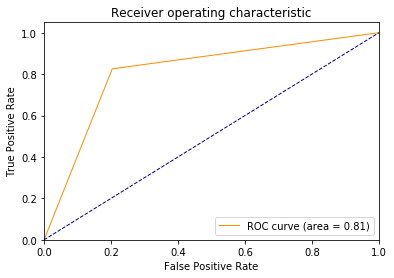

In [56]:
outcome_test = np.argmax(test_labels, 1)
predictions_test = predict_vals

fpr, tpr, thresholds = roc_curve(predictions_test, outcome_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [57]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, save_path)
    print("Model restored.") 
    print("Pos review ", new_pos_review)
    print("Neg review ", new_neg_review)
    print(predict_softmax(new_pos_review, vocab))
    print(predict_softmax(new_neg_review, vocab))

INFO:tensorflow:Restoring parameters from ./ch4-softmax-netflix-sentiment.ckpt
Model restored.
Pos review  I think that this is a fantastic movie, it really 
Neg review  Man, this movie really sucked. It was terrible. I could not possibly watch this movie again!
Predict: [[0.06452986 0.93547016]]
[1]
Predict: [[9.9964476e-01 3.5518387e-04]]
[0]
